# Generating question answer pairs from text

In [1]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [2]:
import importlib
import os

from keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# data

In [4]:

training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()


In [5]:
t = next(training_data_gen)

In [6]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

document_tokens
 [   1 4600    1   66   28 6679    5   28   11  999   60   11    1 7949
 3742   39    1    8 4262 2407    5    1    9    1    5 2212  174  915
 2893 1054 6241  171  764    6 1553    1    1    9    1   36  150 2814
   13   45    1    7   11  805    9 1124   10   11    1 1467    5   20
   11  253 1616  409 3111   13    1    1    9   11  253 2497 1616 3111
   13    1    6    4  318   12 1039   17   37 3386   11 2623    5 2505
   15    4 8743 8888   14    9 7433    1    1    1   32 1748   81 1088
   94   25    4 1156 1905  282    9   18  495  143   24 5461  105   48
 2023    1   10 1176  530    4  512   10  486    6    1   12  161   10
   29 6679   28   32   52   49    7    4    1 3285    7    4   63    5
    9    4  460 2843   17 9069    8   31    4  751    7   11   51  280
    5   29    4 1839 1376    6   28  212    5   23   32   71   52   65
 4980   13   29 6679   28   46    4  318 1748 3905 6241   13    4    1
  915  318 1526    5   43   36  453   67  183  363    6    4

In [7]:
# GloVe

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100


GLOVE
VOCAB_SIZE:  9982
EMBEDDING_DIMENS:  100


# parameters

In [8]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# architecture

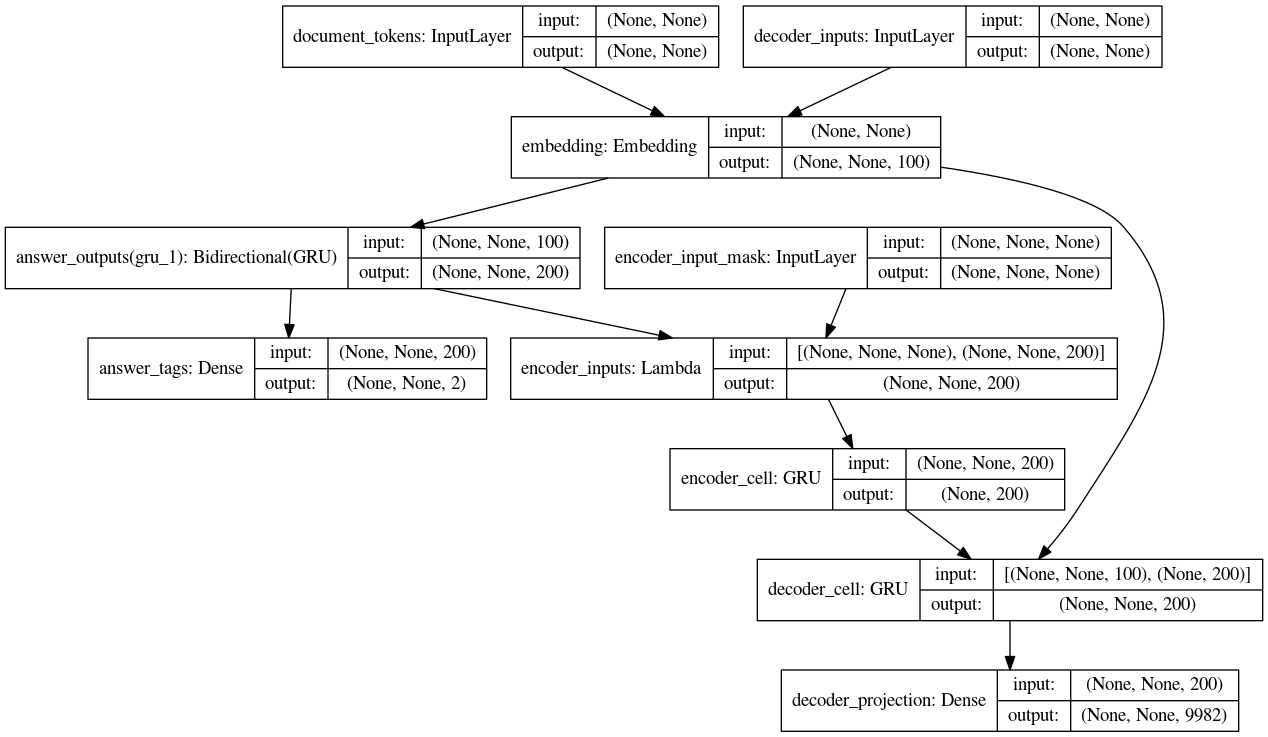

In [9]:
document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [10]:
decoder_emb.shape

TensorShape([None, None, 100])

In [11]:
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])

In [12]:
total_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998200      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    120600      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) (None, None, None)   0                                      

In [13]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [14]:
#### COMPILE TRAINING MODEL ####

opti = Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 


# train

In [15]:
training_loss_history = []
test_loss_history = []

EPOCHS = 2000
start_epoch = 1

In [16]:
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
        
        if i%10 == 0:
            print("{}: Train Loss: {} | Test Loss: {}".format(i, training_loss, test_loss))
        
    total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))

Epoch 1


/home/cataluna84/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0: Train Loss: [5.487, 0.8463666, 4.6406336] | Test Loss: [9.7156105, 0.53395665, 9.181654]
10: Train Loss: [5.562289, 0.41858268, 5.143707] | Test Loss: [8.2517, 0.27888292, 7.972818]
20: Train Loss: [3.4889627, 0.33897415, 3.1499884] | Test Loss: [6.328602, 0.31862485, 6.009977]
30: Train Loss: [2.9544423, 0.36759487, 2.5868473] | Test Loss: [5.965455, 0.27871218, 5.686743]
40: Train Loss: [3.5218282, 0.35826, 3.1635683] | Test Loss: [5.934616, 0.29257855, 5.6420374]
50: Train Loss: [3.1946046, 0.32259354, 2.8720112] | Test Loss: [5.6897545, 0.30424514, 5.3855095]
60: Train Loss: [3.1545544, 0.32687724, 2.8276772] | Test Loss: [5.674479, 0.25461373, 5.419865]
70: Train Loss: [3.0569875, 0.32930523, 2.7276824] | Test Loss: [5.668349, 0.26493505, 5.403414]
80: Train Loss: [2.9566615, 0.2790875, 2.677574] | Test Loss: [5.541098, 0.23047236, 5.3106256]
90: Train Loss: [3.1439226, 0.36192402, 2.7819986] | Test Loss: [5.4872713, 0.24672611, 5.2405453]
100: Train Loss: [2.7445574, 0.3474328

310: Train Loss: [2.3317103, 0.26362616, 2.0680842] | Test Loss: [3.790313, 0.18708684, 3.6032262]
320: Train Loss: [2.2228343, 0.29509428, 1.9277401] | Test Loss: [3.7290218, 0.19939691, 3.529625]
330: Train Loss: [2.5288625, 0.28539, 2.2434726] | Test Loss: [3.8117905, 0.19821869, 3.613572]
340: Train Loss: [2.5826445, 0.31537867, 2.2672658] | Test Loss: [3.7808414, 0.20134175, 3.5794995]
350: Train Loss: [2.330261, 0.29407516, 2.0361857] | Test Loss: [3.6860397, 0.1875364, 3.4985032]
360: Train Loss: [2.6707559, 0.31920943, 2.3515465] | Test Loss: [3.510036, 0.17783682, 3.332199]
370: Train Loss: [1.5246453, 0.36693138, 1.1577139] | Test Loss: [3.580212, 0.20121801, 3.378994]
380: Train Loss: [2.451583, 0.28954512, 2.1620378] | Test Loss: [3.5509324, 0.19370387, 3.3572285]
390: Train Loss: [1.9516947, 0.27882847, 1.6728662] | Test Loss: [3.5275726, 0.19624856, 3.331324]
400: Train Loss: [2.0709507, 0.33060807, 1.7403426] | Test Loss: [3.6268363, 0.21954232, 3.407294]
410: Train Loss

90: Train Loss: [1.6529603, 0.27288976, 1.3800706] | Test Loss: [3.2425692, 0.28046575, 2.9621034]
100: Train Loss: [2.025555, 0.3664319, 1.659123] | Test Loss: [3.088987, 0.20126489, 2.8877223]
110: Train Loss: [1.7831628, 0.2836714, 1.4994915] | Test Loss: [3.1299596, 0.25332662, 2.876633]
120: Train Loss: [1.7020066, 0.27452222, 1.4274844] | Test Loss: [3.0753953, 0.25919366, 2.8162017]
130: Train Loss: [2.1458793, 0.29678822, 1.8490909] | Test Loss: [3.0952134, 0.2971278, 2.7980857]
140: Train Loss: [1.6677527, 0.27321383, 1.3945389] | Test Loss: [3.1815817, 0.30379272, 2.877789]
150: Train Loss: [2.1259184, 0.31367314, 1.8122452] | Test Loss: [3.084127, 0.2632648, 2.820862]
160: Train Loss: [1.8437788, 0.4149633, 1.4288156] | Test Loss: [3.1007285, 0.28665608, 2.8140724]
170: Train Loss: [1.6353066, 0.29536504, 1.3399416] | Test Loss: [3.0025208, 0.23100458, 2.7715163]
180: Train Loss: [1.9823866, 0.28324807, 1.6991385] | Test Loss: [3.055841, 0.26829392, 2.787547]
190: Train Loss

400: Train Loss: [2.1824603, 0.30788895, 1.8745713] | Test Loss: [3.032189, 0.32918844, 2.7030005]
410: Train Loss: [1.9888854, 0.26717207, 1.7217133] | Test Loss: [3.1341493, 0.35061613, 2.783533]
420: Train Loss: [1.8816943, 0.25067192, 1.6310223] | Test Loss: [3.0866718, 0.33269128, 2.7539806]
430: Train Loss: [2.036065, 0.26446885, 1.7715962] | Test Loss: [3.0095165, 0.27837637, 2.7311401]
440: Train Loss: [1.9678148, 0.25844285, 1.7093719] | Test Loss: [3.0854318, 0.3216311, 2.7638006]
450: Train Loss: [1.5374889, 0.29266378, 1.2448251] | Test Loss: [3.075436, 0.3222013, 2.7532349]
460: Train Loss: [1.6946819, 0.27400348, 1.4206784] | Test Loss: [3.0255346, 0.30936968, 2.7161648]
470: Train Loss: [2.0438023, 0.23916756, 1.8046347] | Test Loss: [2.9468117, 0.30945215, 2.6373596]
480: Train Loss: [0.5517351, 0.33493936, 0.21679573] | Test Loss: [3.0226882, 0.3700997, 2.6525884]
490: Train Loss: [1.6639655, 0.32157642, 1.3423891] | Test Loss: [2.9835367, 0.28422844, 2.6993084]
500: T

180: Train Loss: [1.6713618, 0.25444615, 1.4169157] | Test Loss: [3.0042558, 0.3397064, 2.6645494]
190: Train Loss: [1.6580207, 0.22382432, 1.4341965] | Test Loss: [2.9898922, 0.29973078, 2.6901615]
200: Train Loss: [1.6574624, 0.21070665, 1.4467558] | Test Loss: [2.9849598, 0.3144691, 2.6704907]
210: Train Loss: [1.6935531, 0.25712392, 1.4364291] | Test Loss: [3.0234578, 0.3396666, 2.6837912]
220: Train Loss: [1.7273788, 0.20719023, 1.5201886] | Test Loss: [3.005171, 0.30490607, 2.700265]
230: Train Loss: [1.6316097, 0.23278823, 1.3988215] | Test Loss: [3.1114361, 0.38773513, 2.723701]
240: Train Loss: [1.4179604, 0.26235965, 1.1556008] | Test Loss: [3.0491974, 0.32180387, 2.7273936]
250: Train Loss: [1.5494155, 0.2768393, 1.2725762] | Test Loss: [3.093453, 0.34041467, 2.7530382]
260: Train Loss: [1.6924845, 0.22132061, 1.4711639] | Test Loss: [3.1216562, 0.38403392, 2.7376223]
270: Train Loss: [1.8470168, 0.2561599, 1.5908569] | Test Loss: [3.021393, 0.35477272, 2.6666203]
280: Train

490: Train Loss: [1.198106, 0.19194876, 1.0061573] | Test Loss: [2.7898254, 0.33443847, 2.4553869]
500: Train Loss: [1.4590572, 0.24963607, 1.2094212] | Test Loss: [2.763064, 0.34905636, 2.4140074]
510: Train Loss: [1.9459214, 0.23545454, 1.7104669] | Test Loss: [2.6595771, 0.30906922, 2.350508]
520: Train Loss: [1.6275883, 0.25900143, 1.3685869] | Test Loss: [2.67356, 0.29791537, 2.3756444]
Epoch 9
0: Train Loss: [1.3784561, 0.18045406, 1.1980021] | Test Loss: [2.6931973, 0.32729575, 2.3659015]
10: Train Loss: [1.6382492, 0.17218332, 1.4660659] | Test Loss: [2.7504518, 0.3517111, 2.3987408]
20: Train Loss: [1.6340417, 0.20571232, 1.4283293] | Test Loss: [2.802618, 0.35993442, 2.4426837]
30: Train Loss: [1.6834575, 0.21283968, 1.4706178] | Test Loss: [2.8767648, 0.39361042, 2.4831543]
40: Train Loss: [1.6747828, 0.19925088, 1.4755318] | Test Loss: [2.8822389, 0.3482825, 2.5339563]
50: Train Loss: [1.4888644, 0.22713135, 1.261733] | Test Loss: [2.9124072, 0.41089234, 2.501515]
60: Train

260: Train Loss: [1.6216664, 0.20677337, 1.414893] | Test Loss: [2.9885254, 0.4528155, 2.5357099]
270: Train Loss: [1.6057408, 0.21616715, 1.3895737] | Test Loss: [2.9567986, 0.38988024, 2.5669184]
280: Train Loss: [1.5252548, 0.21451603, 1.3107388] | Test Loss: [2.9313083, 0.40404487, 2.5272634]
290: Train Loss: [1.6403416, 0.20481983, 1.4355218] | Test Loss: [2.8627746, 0.39658466, 2.4661899]
300: Train Loss: [1.5929284, 0.16899091, 1.4239374] | Test Loss: [2.8816638, 0.40323734, 2.4784265]
310: Train Loss: [1.419354, 0.21107808, 1.2082759] | Test Loss: [2.9493687, 0.41287684, 2.5364919]
320: Train Loss: [1.5263696, 0.21954153, 1.306828] | Test Loss: [2.856229, 0.39507753, 2.4611516]
330: Train Loss: [0.8101022, 0.2107325, 0.5993697] | Test Loss: [2.7714481, 0.35114023, 2.4203079]
340: Train Loss: [0.78792906, 0.21200357, 0.57592547] | Test Loss: [2.660417, 0.31120965, 2.3492074]
350: Train Loss: [1.6145295, 0.22058249, 1.393947] | Test Loss: [2.8383057, 0.41347918, 2.4248266]
360: T

30: Train Loss: [1.3191696, 0.16777024, 1.1513994] | Test Loss: [2.6659086, 0.31445727, 2.3514514]
40: Train Loss: [1.4644601, 0.17654572, 1.2879144] | Test Loss: [2.6886632, 0.28389016, 2.404773]
50: Train Loss: [1.3419776, 0.15307072, 1.1889069] | Test Loss: [2.7191103, 0.29179126, 2.427319]
60: Train Loss: [1.5297807, 0.16828552, 1.3614953] | Test Loss: [2.8160408, 0.2685755, 2.5474653]
70: Train Loss: [1.497473, 0.17694736, 1.3205256] | Test Loss: [2.8702822, 0.30454943, 2.5657327]
80: Train Loss: [1.432318, 0.19701225, 1.2353058] | Test Loss: [2.9451628, 0.34067854, 2.6044843]
90: Train Loss: [1.2698687, 0.17526746, 1.0946013] | Test Loss: [2.734721, 0.2716663, 2.4630547]
100: Train Loss: [1.590348, 0.1664231, 1.4239249] | Test Loss: [2.8551416, 0.35711995, 2.4980216]
110: Train Loss: [1.3792349, 0.19496977, 1.1842651] | Test Loss: [2.9188437, 0.39934534, 2.5194983]
120: Train Loss: [1.5870295, 0.16913648, 1.4178929] | Test Loss: [2.9193683, 0.39744863, 2.5219197]
130: Train Loss:

330: Train Loss: [1.2125578, 0.16605623, 1.0465015] | Test Loss: [2.9736264, 0.36109415, 2.6125321]
340: Train Loss: [1.6272149, 0.16906269, 1.4581522] | Test Loss: [2.8874352, 0.39452007, 2.4929152]
350: Train Loss: [1.2840728, 0.1559733, 1.1280994] | Test Loss: [2.8179018, 0.34973884, 2.468163]
360: Train Loss: [1.578507, 0.19025818, 1.3882488] | Test Loss: [2.8173354, 0.36244932, 2.454886]
370: Train Loss: [1.7308757, 0.18588969, 1.544986] | Test Loss: [2.7655785, 0.2878231, 2.4777553]
380: Train Loss: [1.4327409, 0.15716098, 1.2755799] | Test Loss: [2.8432603, 0.31966603, 2.5235944]
390: Train Loss: [1.3778473, 0.1774247, 1.2004226] | Test Loss: [2.906853, 0.34670013, 2.5601528]
400: Train Loss: [1.6071503, 0.1738981, 1.4332522] | Test Loss: [2.791507, 0.28932747, 2.5021796]
410: Train Loss: [1.5218141, 0.18506578, 1.3367484] | Test Loss: [2.8801503, 0.34589028, 2.53426]
420: Train Loss: [1.0825307, 0.18583277, 0.896698] | Test Loss: [2.8392816, 0.34478688, 2.4944947]
430: Train Lo

100: Train Loss: [1.2034408, 0.15429807, 1.0491427] | Test Loss: [2.802522, 0.33475104, 2.4677708]
110: Train Loss: [1.2503262, 0.14329502, 1.1070311] | Test Loss: [2.7199051, 0.3120717, 2.4078333]
120: Train Loss: [1.2033795, 0.22215216, 0.98122734] | Test Loss: [2.7849367, 0.34587815, 2.4390585]
130: Train Loss: [1.3172439, 0.13662915, 1.1806148] | Test Loss: [2.7625089, 0.37755316, 2.3849556]
140: Train Loss: [0.5900813, 0.14437136, 0.4457099] | Test Loss: [2.7829762, 0.33283177, 2.4501443]
150: Train Loss: [1.349052, 0.14768572, 1.2013662] | Test Loss: [2.7876241, 0.3820832, 2.405541]
160: Train Loss: [1.389212, 0.15113851, 1.2380735] | Test Loss: [2.7080986, 0.35213464, 2.355964]
170: Train Loss: [1.4633052, 0.20570418, 1.257601] | Test Loss: [2.6837273, 0.32761434, 2.356113]
180: Train Loss: [1.3672371, 0.15767942, 1.2095577] | Test Loss: [2.764232, 0.31249776, 2.451734]
190: Train Loss: [1.5638993, 0.1604676, 1.4034317] | Test Loss: [2.7299228, 0.34572414, 2.3841987]
200: Train 

400: Train Loss: [1.2644906, 0.17194985, 1.0925407] | Test Loss: [2.591564, 0.326513, 2.265051]
410: Train Loss: [1.3422036, 0.16050063, 1.181703] | Test Loss: [2.66184, 0.28672063, 2.3751192]
420: Train Loss: [1.188493, 0.1699987, 1.0184942] | Test Loss: [2.8412557, 0.36507145, 2.4761841]
430: Train Loss: [1.1351095, 0.14917907, 0.98593044] | Test Loss: [2.8943205, 0.39704445, 2.497276]
440: Train Loss: [1.4692472, 0.13604534, 1.3332019] | Test Loss: [2.7663488, 0.35727394, 2.409075]
450: Train Loss: [1.3663391, 0.1411678, 1.2251713] | Test Loss: [2.681466, 0.27808386, 2.4033823]
460: Train Loss: [1.233133, 0.13476571, 1.0983672] | Test Loss: [2.7590039, 0.3525814, 2.4064224]
470: Train Loss: [1.3366792, 0.15798321, 1.178696] | Test Loss: [2.7358787, 0.35982868, 2.37605]
480: Train Loss: [1.2374349, 0.15537047, 1.0820644] | Test Loss: [2.768809, 0.35258383, 2.4162252]
490: Train Loss: [1.4517046, 0.1541847, 1.2975199] | Test Loss: [2.738589, 0.2898641, 2.448725]
500: Train Loss: [1.26

170: Train Loss: [1.1736716, 0.14319566, 1.030476] | Test Loss: [2.9155295, 0.39009625, 2.5254333]
180: Train Loss: [1.3083293, 0.1681965, 1.1401328] | Test Loss: [2.85224, 0.40074843, 2.4514916]
190: Train Loss: [1.2493136, 0.13576132, 1.1135522] | Test Loss: [2.8217275, 0.37804747, 2.44368]
200: Train Loss: [1.178336, 0.14309028, 1.0352458] | Test Loss: [2.9240015, 0.40266842, 2.521333]
210: Train Loss: [1.0706466, 0.14602162, 0.92462504] | Test Loss: [2.9436138, 0.4057319, 2.5378819]
220: Train Loss: [1.3423421, 0.1502467, 1.1920954] | Test Loss: [3.0963888, 0.5099702, 2.5864186]
230: Train Loss: [1.188888, 0.12775508, 1.0611329] | Test Loss: [3.022376, 0.46381354, 2.5585625]
240: Train Loss: [1.3530781, 0.1302442, 1.2228339] | Test Loss: [2.7996328, 0.34111118, 2.4585216]
250: Train Loss: [1.2601976, 0.14761612, 1.1125815] | Test Loss: [2.6519597, 0.33043167, 2.321528]
260: Train Loss: [1.0662838, 0.15552647, 0.91075736] | Test Loss: [2.7778342, 0.3592165, 2.4186177]
270: Train Los

470: Train Loss: [1.2815678, 0.13101524, 1.1505526] | Test Loss: [2.9645913, 0.41400623, 2.550585]
480: Train Loss: [1.2138222, 0.13127406, 1.0825481] | Test Loss: [2.9384913, 0.4769382, 2.461553]
490: Train Loss: [1.3454813, 0.12680414, 1.2186772] | Test Loss: [2.898781, 0.42545515, 2.473326]
500: Train Loss: [0.88930976, 0.14034092, 0.74896884] | Test Loss: [2.7648625, 0.32836154, 2.436501]
510: Train Loss: [0.9165116, 0.11419805, 0.80231357] | Test Loss: [2.8150752, 0.44365138, 2.3714237]
520: Train Loss: [1.1727906, 0.13702306, 1.0357676] | Test Loss: [2.733444, 0.39459825, 2.3388457]
Epoch 20
0: Train Loss: [1.0251687, 0.10852229, 0.91664636] | Test Loss: [2.8299413, 0.5078768, 2.3220644]
10: Train Loss: [1.1404305, 0.1208349, 1.0195955] | Test Loss: [2.6549911, 0.3750525, 2.2799387]
20: Train Loss: [0.9014856, 0.1063496, 0.79513603] | Test Loss: [2.639733, 0.3507088, 2.2890244]
30: Train Loss: [0.85946625, 0.113329574, 0.74613667] | Test Loss: [2.756253, 0.4223271, 2.333926]
40: 

240: Train Loss: [1.1241114, 0.12303565, 1.0010757] | Test Loss: [2.9820175, 0.56367356, 2.418344]
250: Train Loss: [1.2016724, 0.10879354, 1.0928789] | Test Loss: [2.9528427, 0.5035663, 2.4492764]
260: Train Loss: [1.2267148, 0.15009461, 1.0766202] | Test Loss: [2.923379, 0.5226878, 2.400691]
270: Train Loss: [1.0841801, 0.13111009, 0.95307004] | Test Loss: [2.7711396, 0.4443363, 2.3268032]
280: Train Loss: [1.204725, 0.13124937, 1.0734757] | Test Loss: [2.9727705, 0.5016559, 2.4711146]
290: Train Loss: [0.9631841, 0.12882774, 0.83435637] | Test Loss: [2.9100535, 0.4783992, 2.4316542]
300: Train Loss: [0.87272125, 0.14371233, 0.7290089] | Test Loss: [2.918221, 0.5056306, 2.4125905]
310: Train Loss: [0.7083672, 0.09997358, 0.60839367] | Test Loss: [2.9329257, 0.47628656, 2.456639]
320: Train Loss: [1.1954819, 0.10972498, 1.0857569] | Test Loss: [2.8614078, 0.4584599, 2.402948]
330: Train Loss: [1.1480584, 0.1139587, 1.0340997] | Test Loss: [2.9655905, 0.5164035, 2.449187]
340: Train Lo

10: Train Loss: [0.7752143, 0.093580306, 0.681634] | Test Loss: [2.991784, 0.5132471, 2.478537]
20: Train Loss: [1.0075498, 0.11333949, 0.8942102] | Test Loss: [3.0661416, 0.61388963, 2.452252]
30: Train Loss: [0.9724268, 0.10294274, 0.869484] | Test Loss: [2.9827447, 0.58548635, 2.3972583]
40: Train Loss: [1.030206, 0.13217579, 0.8980302] | Test Loss: [2.9358325, 0.5736299, 2.3622026]
50: Train Loss: [1.054056, 0.11433301, 0.9397231] | Test Loss: [2.8454013, 0.50519955, 2.3402019]
60: Train Loss: [1.022631, 0.11228541, 0.9103456] | Test Loss: [2.8297586, 0.46309018, 2.3666685]
70: Train Loss: [1.0282499, 0.1028125, 0.92543733] | Test Loss: [2.9870424, 0.56719774, 2.4198446]
80: Train Loss: [0.9308035, 0.10990529, 0.8208982] | Test Loss: [2.923757, 0.5618848, 2.3618722]
90: Train Loss: [0.92802006, 0.09838028, 0.8296398] | Test Loss: [2.962742, 0.5382755, 2.4244666]
100: Train Loss: [1.0142468, 0.13055426, 0.88369256] | Test Loss: [3.0151958, 0.56169236, 2.4535034]
110: Train Loss: [0.

310: Train Loss: [0.85035825, 0.09707542, 0.75328285] | Test Loss: [2.8148491, 0.42543307, 2.389416]
320: Train Loss: [0.8990748, 0.1247102, 0.7743646] | Test Loss: [2.6804078, 0.35348037, 2.3269274]
330: Train Loss: [0.5407077, 0.111672685, 0.429035] | Test Loss: [2.790964, 0.4362101, 2.3547537]
340: Train Loss: [1.103849, 0.10609271, 0.99775636] | Test Loss: [2.8029814, 0.44674525, 2.3562362]
350: Train Loss: [1.0726779, 0.108981065, 0.9636968] | Test Loss: [2.9921288, 0.5815779, 2.4105508]
360: Train Loss: [0.94932485, 0.1141809, 0.8351439] | Test Loss: [2.901831, 0.60219884, 2.299632]
370: Train Loss: [0.8748778, 0.099084966, 0.77579284] | Test Loss: [2.822814, 0.54798216, 2.2748318]
380: Train Loss: [0.85584664, 0.12487217, 0.7309745] | Test Loss: [2.8336349, 0.49977478, 2.3338602]
390: Train Loss: [0.5618422, 0.11384299, 0.44799924] | Test Loss: [2.9436493, 0.5284862, 2.415163]
400: Train Loss: [0.873807, 0.14052768, 0.73327935] | Test Loss: [2.964472, 0.56580144, 2.3986707]
410:

80: Train Loss: [0.9525964, 0.1177339, 0.83486253] | Test Loss: [3.0706904, 0.5461621, 2.5245283]
90: Train Loss: [0.70601875, 0.08176504, 0.6242537] | Test Loss: [2.992352, 0.5396754, 2.4526765]
100: Train Loss: [0.8444244, 0.10854453, 0.7358799] | Test Loss: [2.9681363, 0.5319653, 2.436171]
110: Train Loss: [1.0243787, 0.09652474, 0.9278539] | Test Loss: [3.0017524, 0.54670036, 2.455052]
120: Train Loss: [0.7302844, 0.09753506, 0.6327493] | Test Loss: [3.0780969, 0.55848956, 2.5196073]
130: Train Loss: [0.8245115, 0.099824175, 0.72468734] | Test Loss: [3.0664303, 0.5437939, 2.5226364]
140: Train Loss: [0.7599241, 0.09700878, 0.66291535] | Test Loss: [3.017485, 0.56742543, 2.4500594]
150: Train Loss: [0.8183104, 0.0986252, 0.7196852] | Test Loss: [3.1629107, 0.6693192, 2.4935915]
160: Train Loss: [0.9371613, 0.094900995, 0.8422603] | Test Loss: [2.9684563, 0.5204514, 2.448005]
170: Train Loss: [0.9910352, 0.107241325, 0.8837939] | Test Loss: [2.9783053, 0.5088053, 2.4695]
180: Train L

380: Train Loss: [1.1035615, 0.09599454, 1.0075669] | Test Loss: [2.9490209, 0.55024374, 2.398777]
390: Train Loss: [0.9276347, 0.125676, 0.8019587] | Test Loss: [2.7872307, 0.49170175, 2.295529]
400: Train Loss: [0.44920948, 0.09953764, 0.34967184] | Test Loss: [2.7654848, 0.46439356, 2.3010912]
410: Train Loss: [1.0155671, 0.11945244, 0.8961146] | Test Loss: [2.8060184, 0.39988285, 2.4061356]
420: Train Loss: [0.88675666, 0.117183656, 0.76957303] | Test Loss: [2.831636, 0.44819632, 2.3834395]
430: Train Loss: [0.90091205, 0.10168132, 0.7992307] | Test Loss: [2.8260238, 0.44365293, 2.382371]
440: Train Loss: [0.87177956, 0.08891256, 0.782867] | Test Loss: [3.0282757, 0.5682103, 2.4600654]
450: Train Loss: [0.8980329, 0.09275527, 0.80527765] | Test Loss: [2.9546704, 0.62156487, 2.3331056]
460: Train Loss: [0.7287514, 0.104201466, 0.6245499] | Test Loss: [2.8710299, 0.6054998, 2.26553]
470: Train Loss: [0.9681553, 0.121807195, 0.8463481] | Test Loss: [2.812481, 0.5596822, 2.2527988]
480

150: Train Loss: [0.7494212, 0.087604694, 0.6618165] | Test Loss: [3.2112489, 0.6691418, 2.542107]
160: Train Loss: [0.63831246, 0.08778275, 0.5505297] | Test Loss: [3.2919083, 0.68875396, 2.6031544]
170: Train Loss: [0.8148693, 0.08551031, 0.729359] | Test Loss: [3.2495458, 0.59656644, 2.6529794]
180: Train Loss: [0.36998713, 0.06703369, 0.30295345] | Test Loss: [3.3266518, 0.6718604, 2.6547914]
190: Train Loss: [0.8684912, 0.099801466, 0.7686897] | Test Loss: [3.2328448, 0.59755504, 2.6352897]
200: Train Loss: [0.9084988, 0.104648635, 0.8038502] | Test Loss: [3.082665, 0.58865327, 2.4940116]
210: Train Loss: [0.8627828, 0.13783371, 0.72494906] | Test Loss: [2.9586298, 0.49382082, 2.464809]
220: Train Loss: [0.74771017, 0.093536794, 0.6541734] | Test Loss: [2.9314015, 0.47849432, 2.452907]
230: Train Loss: [0.82287776, 0.1071876, 0.71569014] | Test Loss: [3.1122715, 0.6392768, 2.4729948]
240: Train Loss: [0.9682512, 0.075108625, 0.8931426] | Test Loss: [2.8870919, 0.48323512, 2.403856

450: Train Loss: [0.564749, 0.07221181, 0.4925372] | Test Loss: [3.2242117, 0.538511, 2.6857007]
460: Train Loss: [0.8228266, 0.11987314, 0.7029535] | Test Loss: [3.182643, 0.50972164, 2.6729214]
470: Train Loss: [0.98272127, 0.083635084, 0.8990862] | Test Loss: [3.240049, 0.5335336, 2.7065153]
480: Train Loss: [0.80320656, 0.07393238, 0.7292742] | Test Loss: [3.2808392, 0.569583, 2.7112563]
490: Train Loss: [0.89590496, 0.09921686, 0.7966881] | Test Loss: [3.2034593, 0.58994305, 2.6135163]
500: Train Loss: [0.80874854, 0.09884898, 0.70989954] | Test Loss: [3.1605215, 0.5626868, 2.5978348]
510: Train Loss: [0.7782852, 0.0925584, 0.6857268] | Test Loss: [3.2447934, 0.59004706, 2.6547463]
520: Train Loss: [0.8918287, 0.13555358, 0.7562751] | Test Loss: [3.1432965, 0.5315442, 2.6117523]
Epoch 31
0: Train Loss: [0.7777995, 0.10503204, 0.67276746] | Test Loss: [3.0568905, 0.4946635, 2.562227]
10: Train Loss: [0.81047523, 0.09039493, 0.7200803] | Test Loss: [2.9549954, 0.43988368, 2.5151117]

220: Train Loss: [0.74848235, 0.1096631, 0.6388192] | Test Loss: [3.341822, 0.89535683, 2.446465]
230: Train Loss: [0.8800638, 0.0899466, 0.7901172] | Test Loss: [3.203459, 0.701451, 2.502008]
240: Train Loss: [0.77525234, 0.06787365, 0.7073787] | Test Loss: [3.271553, 0.6548025, 2.6167505]
250: Train Loss: [0.81107175, 0.11982591, 0.69124585] | Test Loss: [3.3432539, 0.72553307, 2.6177208]
260: Train Loss: [0.8707002, 0.13407858, 0.7366216] | Test Loss: [3.2837942, 0.8037351, 2.4800591]
270: Train Loss: [0.8956104, 0.080036856, 0.8155735] | Test Loss: [3.113001, 0.68572855, 2.4272726]
280: Train Loss: [0.8690639, 0.104555115, 0.7645088] | Test Loss: [3.0294685, 0.6396512, 2.3898172]
290: Train Loss: [0.75861347, 0.08810305, 0.6705104] | Test Loss: [3.2294188, 0.5801052, 2.6493134]
300: Train Loss: [0.7092585, 0.09615494, 0.61310357] | Test Loss: [3.2581682, 0.5961114, 2.662057]
310: Train Loss: [0.41340083, 0.07967503, 0.33372578] | Test Loss: [3.281007, 0.6287934, 2.6522136]
320: Tra

520: Train Loss: [0.780337, 0.14899471, 0.63134223] | Test Loss: [3.0180657, 0.48327994, 2.5347857]
Epoch 34
0: Train Loss: [0.7192272, 0.10039871, 0.6188285] | Test Loss: [2.9748018, 0.5223887, 2.452413]
10: Train Loss: [0.70129794, 0.09289639, 0.60840154] | Test Loss: [3.0684557, 0.5403012, 2.5281544]
20: Train Loss: [0.7912917, 0.092670135, 0.6986216] | Test Loss: [3.1035109, 0.52483165, 2.5786793]
30: Train Loss: [0.80538285, 0.09141182, 0.713971] | Test Loss: [3.0921946, 0.45812643, 2.634068]
40: Train Loss: [0.6307179, 0.07700284, 0.55371505] | Test Loss: [3.0894551, 0.5935286, 2.4959264]
50: Train Loss: [0.51138157, 0.08089416, 0.4304874] | Test Loss: [3.1639462, 0.612239, 2.5517073]
60: Train Loss: [0.75807583, 0.08361619, 0.67445964] | Test Loss: [3.1301048, 0.5734704, 2.5566344]
70: Train Loss: [0.7459203, 0.087643825, 0.6582765] | Test Loss: [3.0944462, 0.53346485, 2.5609813]
80: Train Loss: [0.79234505, 0.06852634, 0.7238187] | Test Loss: [3.120192, 0.57580155, 2.5443904]
9

290: Train Loss: [0.737723, 0.10245636, 0.6352666] | Test Loss: [3.2954812, 0.59387916, 2.701602]
300: Train Loss: [0.85171646, 0.08288238, 0.76883405] | Test Loss: [3.2345698, 0.6300964, 2.6044734]
310: Train Loss: [0.68532294, 0.14459915, 0.5407238] | Test Loss: [3.414271, 0.6456351, 2.768636]
320: Train Loss: [0.7257345, 0.07223086, 0.6535036] | Test Loss: [3.4577026, 0.6496757, 2.808027]
330: Train Loss: [0.7881584, 0.13226023, 0.6558982] | Test Loss: [3.2953057, 0.60032284, 2.694983]
340: Train Loss: [0.76564837, 0.073857374, 0.691791] | Test Loss: [3.4367757, 0.67953616, 2.7572396]
350: Train Loss: [0.9052683, 0.07366398, 0.8316043] | Test Loss: [3.4412432, 0.6740727, 2.7671704]
360: Train Loss: [0.7118269, 0.08242578, 0.62940115] | Test Loss: [3.5561085, 0.79916435, 2.7569442]
370: Train Loss: [0.3394015, 0.10495923, 0.2344423] | Test Loss: [3.4788587, 0.71109533, 2.7677634]
380: Train Loss: [0.7274017, 0.11121369, 0.616188] | Test Loss: [3.6374497, 0.8268548, 2.8105948]
390: Tr

60: Train Loss: [0.622543, 0.062479343, 0.56006366] | Test Loss: [3.4328914, 0.7800549, 2.6528366]
70: Train Loss: [0.56200844, 0.080089815, 0.48191863] | Test Loss: [3.220972, 0.7164815, 2.5044906]
80: Train Loss: [0.62384796, 0.08429685, 0.53955114] | Test Loss: [3.270783, 0.69954306, 2.57124]
90: Train Loss: [0.69317806, 0.072114855, 0.6210632] | Test Loss: [3.3096116, 0.7542055, 2.555406]
100: Train Loss: [0.6934504, 0.06473942, 0.628711] | Test Loss: [3.3352568, 0.8043211, 2.5309358]
110: Train Loss: [0.63053113, 0.08695238, 0.54357874] | Test Loss: [3.4020753, 0.7242967, 2.6777787]
120: Train Loss: [0.60799927, 0.088467434, 0.51953185] | Test Loss: [3.340333, 0.68576294, 2.65457]
130: Train Loss: [0.66146517, 0.09359071, 0.5678745] | Test Loss: [3.2948618, 0.65009165, 2.6447701]
140: Train Loss: [0.7446828, 0.11314159, 0.6315412] | Test Loss: [3.64301, 0.7889099, 2.8541]
150: Train Loss: [0.6815316, 0.08978661, 0.591745] | Test Loss: [3.2361453, 0.640415, 2.5957303]
160: Train Lo

360: Train Loss: [0.6816874, 0.08871534, 0.5929721] | Test Loss: [3.230316, 0.4822848, 2.7480311]
370: Train Loss: [0.74344635, 0.08675819, 0.65668815] | Test Loss: [3.2130814, 0.4638037, 2.7492776]
380: Train Loss: [0.6275908, 0.10093859, 0.52665216] | Test Loss: [3.350088, 0.5030562, 2.8470316]
390: Train Loss: [0.8326827, 0.05354401, 0.77913874] | Test Loss: [3.1028767, 0.42683655, 2.6760402]
400: Train Loss: [0.6588652, 0.12352511, 0.53534013] | Test Loss: [3.341511, 0.49742228, 2.8440888]
410: Train Loss: [0.69083583, 0.06781838, 0.62301743] | Test Loss: [3.1397374, 0.44289225, 2.696845]
420: Train Loss: [0.61620647, 0.08088381, 0.53532267] | Test Loss: [3.1704707, 0.52420914, 2.6462615]
430: Train Loss: [0.70618755, 0.094220445, 0.6119671] | Test Loss: [3.0068169, 0.52718246, 2.4796345]
440: Train Loss: [0.6319472, 0.09509396, 0.53685325] | Test Loss: [3.0179424, 0.539252, 2.4786904]
450: Train Loss: [0.7013639, 0.08571622, 0.6156477] | Test Loss: [3.1238205, 0.49113727, 2.632683

130: Train Loss: [0.65389025, 0.077488326, 0.57640195] | Test Loss: [3.535549, 0.50074893, 3.0348]
140: Train Loss: [0.7732785, 0.07195577, 0.70132273] | Test Loss: [3.4659534, 0.48394644, 2.9820068]
150: Train Loss: [0.6633625, 0.08998615, 0.57337636] | Test Loss: [3.3159573, 0.45814633, 2.857811]
160: Train Loss: [0.6197257, 0.0832407, 0.536485] | Test Loss: [3.2981997, 0.4430338, 2.855166]
170: Train Loss: [0.6773164, 0.09351014, 0.5838063] | Test Loss: [3.1560397, 0.41971946, 2.7363203]
180: Train Loss: [0.6076512, 0.08439453, 0.52325666] | Test Loss: [3.157022, 0.48534474, 2.6716774]
190: Train Loss: [0.6562158, 0.0787597, 0.5774561] | Test Loss: [3.0774412, 0.4523397, 2.6251016]
200: Train Loss: [0.6165733, 0.0999471, 0.5166262] | Test Loss: [3.1754344, 0.41598564, 2.7594488]
210: Train Loss: [0.66140056, 0.08921387, 0.5721867] | Test Loss: [3.1740665, 0.48413613, 2.6899304]
220: Train Loss: [0.58132434, 0.087832645, 0.49349168] | Test Loss: [3.1280546, 0.49410358, 2.633951]
230:

430: Train Loss: [0.66080695, 0.064850435, 0.5959565] | Test Loss: [3.042327, 0.42848632, 2.6138406]
440: Train Loss: [0.70199746, 0.12521784, 0.5767796] | Test Loss: [3.1932745, 0.38890603, 2.8043685]
450: Train Loss: [0.62040687, 0.10583523, 0.51457167] | Test Loss: [3.241961, 0.5176633, 2.7242978]
460: Train Loss: [0.6499208, 0.063604586, 0.5863162] | Test Loss: [3.3514802, 0.4749166, 2.8765635]
470: Train Loss: [0.71074176, 0.088953234, 0.6217885] | Test Loss: [3.3384397, 0.46524805, 2.8731916]
480: Train Loss: [0.69644463, 0.11548004, 0.58096457] | Test Loss: [3.4546025, 0.5021279, 2.9524746]
490: Train Loss: [0.60204285, 0.076291144, 0.5257517] | Test Loss: [3.3029244, 0.4258224, 2.877102]
500: Train Loss: [0.8026181, 0.0987112, 0.7039069] | Test Loss: [3.4490566, 0.49194294, 2.9571137]
510: Train Loss: [0.7020107, 0.090289906, 0.6117208] | Test Loss: [3.5207207, 0.5401244, 2.9805963]
520: Train Loss: [0.65828484, 0.092070386, 0.56621444] | Test Loss: [3.6071455, 0.54818124, 3.05

190: Train Loss: [0.6347707, 0.067906655, 0.566864] | Test Loss: [3.8341916, 0.61695343, 3.2172382]
200: Train Loss: [0.60900533, 0.085774556, 0.5232308] | Test Loss: [3.8383222, 0.60189867, 3.2364235]
210: Train Loss: [0.5283464, 0.060107954, 0.46823847] | Test Loss: [3.8214564, 0.5387887, 3.2826679]
220: Train Loss: [0.6031523, 0.098945335, 0.50420696] | Test Loss: [3.815386, 0.5959609, 3.2194252]
230: Train Loss: [0.62524235, 0.120118, 0.50512433] | Test Loss: [3.76082, 0.73510754, 3.0257123]
240: Train Loss: [0.5160635, 0.083991125, 0.4320724] | Test Loss: [3.7552595, 0.6635452, 3.0917144]
250: Train Loss: [0.69354725, 0.09635043, 0.5971968] | Test Loss: [3.5717292, 0.59992725, 2.971802]
260: Train Loss: [0.6136184, 0.10448232, 0.509136] | Test Loss: [3.752178, 0.5893236, 3.1628544]
270: Train Loss: [0.6420464, 0.080578096, 0.5614683] | Test Loss: [3.9005494, 0.6595197, 3.2410297]
280: Train Loss: [0.63175607, 0.06860953, 0.56314653] | Test Loss: [3.701307, 0.6241806, 3.0771265]
29

490: Train Loss: [0.49232125, 0.09222018, 0.40010107] | Test Loss: [3.6384306, 0.5720071, 3.0664234]
500: Train Loss: [0.5499067, 0.06983955, 0.48006713] | Test Loss: [3.9278696, 0.67204976, 3.2558198]
510: Train Loss: [0.5358599, 0.09009739, 0.4457625] | Test Loss: [3.8348553, 0.6947709, 3.1400845]
520: Train Loss: [0.6234678, 0.07213636, 0.55133146] | Test Loss: [3.95505, 0.77492887, 3.1801212]
Epoch 45
0: Train Loss: [0.5092081, 0.06207638, 0.44713172] | Test Loss: [3.8762183, 0.73461217, 3.141606]
10: Train Loss: [0.553279, 0.083919264, 0.4693597] | Test Loss: [3.9710755, 0.6931336, 3.277942]
20: Train Loss: [0.5621609, 0.0785888, 0.4835721] | Test Loss: [4.031961, 0.6447426, 3.3872185]
30: Train Loss: [0.6375798, 0.069178246, 0.5684016] | Test Loss: [3.8140886, 0.572057, 3.2420316]
40: Train Loss: [0.47955287, 0.07318257, 0.4063703] | Test Loss: [3.905924, 0.6226213, 3.2833028]
50: Train Loss: [0.5130269, 0.07021244, 0.44281444] | Test Loss: [3.8675585, 0.63835573, 3.2292027]
60: 

260: Train Loss: [0.53268754, 0.065275215, 0.46741235] | Test Loss: [4.1853023, 0.69407517, 3.491227]
270: Train Loss: [0.5310377, 0.09810301, 0.43293467] | Test Loss: [4.2079186, 0.6468937, 3.561025]
280: Train Loss: [0.5662826, 0.065768436, 0.50051415] | Test Loss: [3.9847646, 0.6637355, 3.321029]
290: Train Loss: [0.64864916, 0.0682544, 0.58039474] | Test Loss: [4.0932474, 0.7095119, 3.3837357]
300: Train Loss: [0.5832185, 0.0738948, 0.5093237] | Test Loss: [3.8036132, 0.61324936, 3.190364]
310: Train Loss: [0.6078029, 0.07161041, 0.53619254] | Test Loss: [4.075361, 0.7341375, 3.3412235]
320: Train Loss: [0.6208586, 0.09645746, 0.5244011] | Test Loss: [3.7602134, 0.63140666, 3.1288068]
330: Train Loss: [0.5173427, 0.061089363, 0.45625335] | Test Loss: [3.6471658, 0.6198442, 3.0273216]
340: Train Loss: [0.65474504, 0.086959735, 0.5677853] | Test Loss: [3.711711, 0.6511539, 3.060557]
350: Train Loss: [0.6120081, 0.094257645, 0.51775044] | Test Loss: [3.666453, 0.6236455, 3.0428073]
36

30: Train Loss: [0.3438932, 0.09638918, 0.24750401] | Test Loss: [4.0391765, 0.6313058, 3.4078705]
40: Train Loss: [0.27760917, 0.060222182, 0.21738698] | Test Loss: [4.249608, 0.6756013, 3.5740066]
50: Train Loss: [0.49561697, 0.06668757, 0.42892942] | Test Loss: [4.4014626, 0.70975906, 3.6917033]
60: Train Loss: [0.4862655, 0.072365545, 0.41389996] | Test Loss: [4.1778226, 0.71204466, 3.4657779]
70: Train Loss: [0.47009364, 0.079976745, 0.3901169] | Test Loss: [4.199188, 0.7017343, 3.4974542]
80: Train Loss: [0.5077101, 0.07434091, 0.43336922] | Test Loss: [4.3190317, 0.696551, 3.6224809]
90: Train Loss: [0.5711428, 0.064826526, 0.50631624] | Test Loss: [4.3846097, 0.69299114, 3.6916184]
100: Train Loss: [0.4899028, 0.06997536, 0.41992745] | Test Loss: [4.6583886, 0.79718727, 3.8612015]
110: Train Loss: [0.49856782, 0.07325066, 0.42531717] | Test Loss: [4.4290247, 0.7702195, 3.6588054]
120: Train Loss: [0.48542204, 0.06443799, 0.42098406] | Test Loss: [4.384408, 0.75899345, 3.6254144

320: Train Loss: [0.6051526, 0.07474259, 0.53041] | Test Loss: [3.8318563, 0.6010181, 3.2308383]
330: Train Loss: [0.5688062, 0.057463594, 0.5113426] | Test Loss: [3.7858906, 0.5639261, 3.2219646]
340: Train Loss: [0.5902252, 0.08246445, 0.50776076] | Test Loss: [3.7639709, 0.5200788, 3.243892]
350: Train Loss: [0.48436862, 0.058098987, 0.42626962] | Test Loss: [3.7708735, 0.49341652, 3.277457]
360: Train Loss: [0.28814232, 0.07096981, 0.2171725] | Test Loss: [3.7193868, 0.5607981, 3.1585886]
370: Train Loss: [0.46389052, 0.09175386, 0.37213665] | Test Loss: [3.5952833, 0.5628539, 3.0324295]
380: Train Loss: [0.574258, 0.07414317, 0.50011486] | Test Loss: [3.6217093, 0.53626364, 3.0854456]
390: Train Loss: [0.6546488, 0.07817518, 0.5764736] | Test Loss: [3.7623403, 0.5631148, 3.1992254]
400: Train Loss: [0.6124417, 0.069385104, 0.5430566] | Test Loss: [3.6376348, 0.4920923, 3.1455424]
410: Train Loss: [0.60001063, 0.088625975, 0.51138467] | Test Loss: [3.606089, 0.48979855, 3.1162906]


90: Train Loss: [0.59077495, 0.0844537, 0.50632125] | Test Loss: [3.9906132, 0.5323389, 3.4582744]
100: Train Loss: [0.45301458, 0.07930595, 0.37370864] | Test Loss: [3.8495312, 0.5421105, 3.3074207]
110: Train Loss: [0.33243084, 0.06547035, 0.2669605] | Test Loss: [3.9143846, 0.64934474, 3.26504]
120: Train Loss: [0.5542964, 0.0692315, 0.4850649] | Test Loss: [3.6527624, 0.6026603, 3.0501022]
130: Train Loss: [0.3954034, 0.046113864, 0.3492895] | Test Loss: [3.7133765, 0.6663588, 3.0470176]
140: Train Loss: [0.5234687, 0.07325168, 0.450217] | Test Loss: [3.8508325, 0.69846106, 3.1523714]
150: Train Loss: [0.54056275, 0.059970103, 0.48059264] | Test Loss: [3.8353271, 0.71962386, 3.1157033]
160: Train Loss: [0.51491493, 0.07146801, 0.44344693] | Test Loss: [3.9136665, 0.75438803, 3.1592784]
170: Train Loss: [0.5236784, 0.08895135, 0.4347271] | Test Loss: [3.548014, 0.63886046, 2.9091535]
180: Train Loss: [0.6085655, 0.07330109, 0.53526443] | Test Loss: [3.7242777, 0.67850655, 3.0457711]

380: Train Loss: [0.5614117, 0.0680073, 0.49340436] | Test Loss: [3.9059722, 0.64507896, 3.2608933]
390: Train Loss: [0.49540722, 0.086557254, 0.40884998] | Test Loss: [3.653114, 0.6096728, 3.0434413]
400: Train Loss: [0.6585753, 0.087498166, 0.5710771] | Test Loss: [3.7914436, 0.67611647, 3.1153271]
410: Train Loss: [0.36865884, 0.13093588, 0.23772298] | Test Loss: [3.8594332, 0.7304119, 3.1290214]
420: Train Loss: [0.61370456, 0.075814754, 0.53788984] | Test Loss: [3.9757748, 0.7310245, 3.2447503]
430: Train Loss: [0.52722913, 0.11120027, 0.41602886] | Test Loss: [3.8538861, 0.65104216, 3.202844]
440: Train Loss: [0.5315737, 0.06869246, 0.46288124] | Test Loss: [4.4026885, 0.72227633, 3.6804123]
450: Train Loss: [0.46546954, 0.060630914, 0.40483862] | Test Loss: [4.2806683, 0.71412265, 3.5665455]
460: Train Loss: [0.6356972, 0.09254433, 0.54315287] | Test Loss: [4.228792, 0.6520998, 3.5766926]
470: Train Loss: [0.570909, 0.087712206, 0.48319682] | Test Loss: [4.1494427, 0.6838763, 3.

140: Train Loss: [0.43867654, 0.07928861, 0.35938793] | Test Loss: [3.852529, 0.6041972, 3.2483318]
150: Train Loss: [0.49124643, 0.07088554, 0.4203609] | Test Loss: [4.1368613, 0.65001637, 3.486845]
160: Train Loss: [0.45006922, 0.0673761, 0.3826931] | Test Loss: [4.1152506, 0.6888996, 3.4263508]
170: Train Loss: [0.546449, 0.12722881, 0.41922018] | Test Loss: [4.018549, 0.64622295, 3.372326]
180: Train Loss: [0.47106606, 0.0654117, 0.40565434] | Test Loss: [4.2503476, 0.67597306, 3.5743747]
190: Train Loss: [0.4618296, 0.0666479, 0.3951817] | Test Loss: [4.085536, 0.6477059, 3.43783]
200: Train Loss: [0.552194, 0.08031997, 0.471874] | Test Loss: [4.231181, 0.6564372, 3.5747437]
210: Train Loss: [0.5557407, 0.05139193, 0.50434875] | Test Loss: [4.219265, 0.61479324, 3.604472]
220: Train Loss: [0.5216911, 0.089046866, 0.4326442] | Test Loss: [4.19382, 0.6347154, 3.5591044]
230: Train Loss: [0.55116445, 0.111006215, 0.44015825] | Test Loss: [4.002226, 0.57816905, 3.424057]
240: Train Lo

440: Train Loss: [0.4933216, 0.07843616, 0.41488543] | Test Loss: [4.0266333, 0.6575589, 3.3690746]
450: Train Loss: [0.4929514, 0.07170048, 0.4212509] | Test Loss: [4.013138, 0.6094209, 3.403717]
460: Train Loss: [0.558097, 0.067415446, 0.49068156] | Test Loss: [3.9674053, 0.64856327, 3.318842]
470: Train Loss: [0.39300293, 0.07512633, 0.3178766] | Test Loss: [4.1695437, 0.61821586, 3.551328]
480: Train Loss: [0.2678071, 0.06298711, 0.20481999] | Test Loss: [3.8358815, 0.6320546, 3.203827]
490: Train Loss: [0.5984162, 0.10202268, 0.49639356] | Test Loss: [3.8894515, 0.63396394, 3.2554874]
500: Train Loss: [0.3336833, 0.12177195, 0.21191135] | Test Loss: [3.7679117, 0.5807538, 3.1871579]
510: Train Loss: [0.5566943, 0.07405555, 0.48263878] | Test Loss: [3.8144236, 0.59172475, 3.2226987]
520: Train Loss: [0.55601144, 0.08696038, 0.46905103] | Test Loss: [3.9696975, 0.6780168, 3.2916806]
Epoch 56
0: Train Loss: [0.2778107, 0.10197073, 0.17583998] | Test Loss: [4.0625653, 0.6839491, 3.378

200: Train Loss: [0.50169116, 0.07779297, 0.4238982] | Test Loss: [4.0824323, 0.6909765, 3.391456]
210: Train Loss: [0.49562758, 0.077436164, 0.4181914] | Test Loss: [4.1478205, 0.683068, 3.4647527]
220: Train Loss: [0.46614033, 0.074701086, 0.39143923] | Test Loss: [4.145786, 0.809587, 3.3361988]
230: Train Loss: [0.5073556, 0.041625388, 0.46573016] | Test Loss: [3.9183297, 0.78165644, 3.1366732]
240: Train Loss: [0.5894693, 0.10647558, 0.48299375] | Test Loss: [4.113465, 0.83959454, 3.2738705]
250: Train Loss: [0.48426282, 0.07571373, 0.4085491] | Test Loss: [3.7897124, 0.82454693, 2.9651656]
260: Train Loss: [0.39518604, 0.07604319, 0.31914285] | Test Loss: [4.006024, 0.82242185, 3.183602]
270: Train Loss: [0.4839773, 0.07248383, 0.41149345] | Test Loss: [3.8002014, 0.83474785, 2.9654536]
280: Train Loss: [0.39471105, 0.060100067, 0.33461097] | Test Loss: [3.9955173, 0.80565846, 3.189859]
290: Train Loss: [0.46814504, 0.065185815, 0.40295923] | Test Loss: [3.989183, 0.8634077, 3.125

490: Train Loss: [0.47887546, 0.11563979, 0.36323568] | Test Loss: [3.7142859, 0.73587173, 2.978414]
500: Train Loss: [0.53138196, 0.061888285, 0.46949366] | Test Loss: [3.4955459, 0.7277797, 2.7677662]
510: Train Loss: [0.56232965, 0.0887993, 0.47353032] | Test Loss: [3.7434263, 0.8280806, 2.9153457]
520: Train Loss: [0.60583955, 0.089996144, 0.5158434] | Test Loss: [3.8481274, 0.84206617, 3.006061]
Epoch 59
0: Train Loss: [0.49842417, 0.07434643, 0.42407775] | Test Loss: [3.9226484, 0.8494908, 3.0731575]
10: Train Loss: [0.507062, 0.068158634, 0.4389034] | Test Loss: [3.9909232, 0.83009595, 3.1608272]
20: Train Loss: [0.4434604, 0.058841143, 0.38461927] | Test Loss: [3.7747762, 0.77837914, 2.996397]
30: Train Loss: [0.4421534, 0.068521, 0.3736324] | Test Loss: [3.9111946, 0.7974236, 3.113771]
40: Train Loss: [0.56989205, 0.0694353, 0.50045675] | Test Loss: [3.8974667, 0.7622212, 3.1352456]
50: Train Loss: [0.5100877, 0.12585244, 0.38423532] | Test Loss: [3.9463584, 0.7481597, 3.19819

250: Train Loss: [0.47782624, 0.08399366, 0.39383256] | Test Loss: [3.861709, 0.7708289, 3.0908802]
260: Train Loss: [0.5334401, 0.063241035, 0.47019908] | Test Loss: [4.094585, 0.6845528, 3.4100323]
270: Train Loss: [0.45235375, 0.060367525, 0.39198622] | Test Loss: [4.2223625, 0.79035157, 3.4320111]
280: Train Loss: [0.46515965, 0.110164486, 0.35499516] | Test Loss: [4.157666, 0.69733274, 3.4603333]
290: Train Loss: [0.56635004, 0.10833735, 0.4580127] | Test Loss: [4.2470336, 0.7799748, 3.467059]
300: Train Loss: [0.49426603, 0.060860917, 0.43340513] | Test Loss: [4.423477, 0.7426446, 3.6808324]
310: Train Loss: [0.515306, 0.08487252, 0.43043348] | Test Loss: [4.474127, 0.7534488, 3.7206779]
320: Train Loss: [0.56294584, 0.0839786, 0.47896725] | Test Loss: [4.290496, 0.6606215, 3.6298745]
330: Train Loss: [0.51501346, 0.07312697, 0.44188645] | Test Loss: [3.930328, 0.6564139, 3.2739139]
340: Train Loss: [0.48670015, 0.05380447, 0.4328957] | Test Loss: [3.8683686, 0.64116657, 3.227202

10: Train Loss: [0.51940995, 0.049768906, 0.46964103] | Test Loss: [3.7887254, 0.7588004, 3.029925]
20: Train Loss: [0.47836405, 0.090382606, 0.38798144] | Test Loss: [3.9697726, 0.7663954, 3.2033772]
30: Train Loss: [0.41445798, 0.045805052, 0.36865294] | Test Loss: [4.095203, 0.8100251, 3.285178]
40: Train Loss: [0.44600093, 0.0933626, 0.35263833] | Test Loss: [4.0879164, 0.7879071, 3.3000093]
50: Train Loss: [0.53430706, 0.07463442, 0.45967263] | Test Loss: [4.314491, 0.7492746, 3.565216]
60: Train Loss: [0.36174732, 0.06727949, 0.29446784] | Test Loss: [4.2648406, 0.73795414, 3.5268865]
70: Train Loss: [0.5249377, 0.072896115, 0.4520416] | Test Loss: [4.377552, 0.7617448, 3.6158073]
80: Train Loss: [0.26090634, 0.061427973, 0.19947836] | Test Loss: [4.596693, 0.74478626, 3.8519065]
90: Train Loss: [0.4110685, 0.063562945, 0.34750554] | Test Loss: [4.3985877, 0.744432, 3.6541557]
100: Train Loss: [0.42339313, 0.04753478, 0.37585837] | Test Loss: [4.253142, 0.79467267, 3.4584694]
110

300: Train Loss: [0.44349048, 0.090402156, 0.35308832] | Test Loss: [4.5550737, 0.84720385, 3.70787]
310: Train Loss: [0.46368343, 0.08336155, 0.3803219] | Test Loss: [4.6388655, 0.9079068, 3.730959]
320: Train Loss: [0.5513513, 0.06371218, 0.48763916] | Test Loss: [4.565876, 0.8912142, 3.6746616]
330: Train Loss: [0.50202334, 0.058906034, 0.4431173] | Test Loss: [4.6554713, 0.97577375, 3.6796975]
340: Train Loss: [0.25062874, 0.07939456, 0.17123418] | Test Loss: [4.6779046, 0.9662994, 3.711605]
350: Train Loss: [0.47539002, 0.06972222, 0.4056678] | Test Loss: [4.792352, 0.971597, 3.820755]
360: Train Loss: [0.45549864, 0.07400534, 0.3814933] | Test Loss: [4.778294, 0.88633776, 3.8919563]
370: Train Loss: [0.29416588, 0.08632166, 0.20784423] | Test Loss: [4.396173, 0.85384643, 3.5423267]
380: Train Loss: [0.48789883, 0.08515562, 0.4027432] | Test Loss: [4.44069, 0.8375348, 3.6031551]
390: Train Loss: [0.45279425, 0.061578084, 0.39121616] | Test Loss: [4.2806845, 0.85013896, 3.4305453]


60: Train Loss: [0.36846444, 0.05338336, 0.3150811] | Test Loss: [4.9332995, 0.8772588, 4.056041]
70: Train Loss: [0.43759334, 0.07403476, 0.3635586] | Test Loss: [4.7272587, 0.8208538, 3.906405]
80: Train Loss: [0.5531403, 0.13223715, 0.42090315] | Test Loss: [4.6160793, 0.8633286, 3.7527509]
90: Train Loss: [0.46740654, 0.054160446, 0.4132461] | Test Loss: [4.591119, 0.8279916, 3.763127]
100: Train Loss: [0.4093522, 0.05216739, 0.35718483] | Test Loss: [4.5467443, 0.8647948, 3.6819496]
110: Train Loss: [0.51077497, 0.086125545, 0.42464945] | Test Loss: [4.472116, 0.77625835, 3.6958575]
120: Train Loss: [0.3513039, 0.064233005, 0.2870709] | Test Loss: [4.617316, 0.86160195, 3.755714]
130: Train Loss: [0.43167064, 0.058833446, 0.3728372] | Test Loss: [4.7546315, 0.9320016, 3.82263]
140: Train Loss: [0.45355117, 0.054603856, 0.39894733] | Test Loss: [4.6668916, 0.9703847, 3.696507]
150: Train Loss: [0.44335252, 0.06985729, 0.37349522] | Test Loss: [4.8898764, 1.0517228, 3.8381534]
160: 

350: Train Loss: [0.47535193, 0.07272238, 0.40262955] | Test Loss: [4.4881444, 0.7589179, 3.7292264]
360: Train Loss: [0.46277705, 0.07446029, 0.38831675] | Test Loss: [4.4485173, 0.8059991, 3.6425183]
370: Train Loss: [0.4322665, 0.0522875, 0.379979] | Test Loss: [4.2760124, 0.7703596, 3.505653]
380: Train Loss: [0.4517645, 0.08170854, 0.37005594] | Test Loss: [4.273226, 0.7977624, 3.4754634]
390: Train Loss: [0.35891923, 0.06539047, 0.29352877] | Test Loss: [4.332085, 0.8470986, 3.4849865]
400: Train Loss: [0.49082145, 0.057722002, 0.43309945] | Test Loss: [4.6393404, 0.9545194, 3.684821]
410: Train Loss: [0.4921457, 0.090684704, 0.40146098] | Test Loss: [4.5188656, 0.8775296, 3.641336]
420: Train Loss: [0.45038557, 0.064191766, 0.3861938] | Test Loss: [4.5032163, 0.9265813, 3.576635]
430: Train Loss: [0.4570397, 0.059779625, 0.3972601] | Test Loss: [4.325345, 0.90425247, 3.4210925]
440: Train Loss: [0.26684234, 0.06381186, 0.20303047] | Test Loss: [4.399128, 0.95089406, 3.448234]
45

110: Train Loss: [0.47457308, 0.06064125, 0.41393182] | Test Loss: [4.131644, 0.77978116, 3.3518627]
120: Train Loss: [0.37505266, 0.05540072, 0.31965193] | Test Loss: [4.0125866, 0.7014373, 3.3111491]
130: Train Loss: [0.44674116, 0.0557934, 0.39094776] | Test Loss: [4.0565214, 0.7867665, 3.2697551]
140: Train Loss: [0.45722175, 0.056922637, 0.4002991] | Test Loss: [4.0105605, 0.80879545, 3.201765]
150: Train Loss: [0.395025, 0.05857452, 0.3364505] | Test Loss: [4.1236777, 0.90961665, 3.214061]
160: Train Loss: [0.410219, 0.05405873, 0.35616028] | Test Loss: [4.0762405, 0.77257293, 3.3036675]
170: Train Loss: [0.51583076, 0.09957843, 0.41625232] | Test Loss: [4.0656776, 0.78757876, 3.278099]
180: Train Loss: [0.3953972, 0.054126874, 0.34127033] | Test Loss: [4.1782475, 0.83165294, 3.3465946]
190: Train Loss: [0.45279315, 0.055428315, 0.39736483] | Test Loss: [4.4897156, 0.85012, 3.6395955]
200: Train Loss: [0.36662534, 0.055933964, 0.3106914] | Test Loss: [4.5269685, 0.8653391, 3.6616

400: Train Loss: [0.39590776, 0.08750188, 0.30840588] | Test Loss: [4.36293, 0.8956644, 3.4672656]
410: Train Loss: [0.4960166, 0.111230075, 0.38478652] | Test Loss: [4.2840357, 0.85306287, 3.430973]
420: Train Loss: [0.4265318, 0.06619557, 0.3603362] | Test Loss: [3.9967084, 0.79384667, 3.2028618]
430: Train Loss: [0.46247023, 0.08823373, 0.3742365] | Test Loss: [3.8365664, 0.78571683, 3.0508497]
440: Train Loss: [0.5035746, 0.059607755, 0.44396687] | Test Loss: [3.8606162, 0.84208095, 3.0185354]
450: Train Loss: [0.42718044, 0.06586669, 0.36131376] | Test Loss: [3.8365085, 0.83758354, 2.998925]
460: Train Loss: [0.4395066, 0.06606225, 0.37344435] | Test Loss: [3.8228958, 0.8295043, 2.9933915]
470: Train Loss: [0.45082712, 0.104261205, 0.3465659] | Test Loss: [3.9370449, 0.7813036, 3.1557412]
480: Train Loss: [0.51552147, 0.12188409, 0.3936374] | Test Loss: [4.0552883, 0.7782191, 3.277069]
490: Train Loss: [0.45109344, 0.06824219, 0.38285124] | Test Loss: [3.8643343, 0.7138384, 3.1504

160: Train Loss: [0.24749604, 0.074130036, 0.17336601] | Test Loss: [3.9565532, 0.7664549, 3.1900983]
170: Train Loss: [0.4371725, 0.06211787, 0.37505463] | Test Loss: [3.9046679, 0.77985716, 3.1248107]
180: Train Loss: [0.42906916, 0.058110677, 0.37095848] | Test Loss: [3.9928498, 0.8155155, 3.1773343]
190: Train Loss: [0.50732344, 0.11543872, 0.3918847] | Test Loss: [4.094717, 0.9098401, 3.1848767]
200: Train Loss: [0.44155714, 0.06273475, 0.3788224] | Test Loss: [4.164056, 0.78955024, 3.3745055]
210: Train Loss: [0.42661896, 0.06477174, 0.36184722] | Test Loss: [4.344691, 0.8451413, 3.4995494]
220: Train Loss: [0.43438303, 0.06482302, 0.36956003] | Test Loss: [4.326175, 0.7981435, 3.5280316]
230: Train Loss: [0.43249038, 0.085603036, 0.34688735] | Test Loss: [4.485137, 0.7980598, 3.6870773]
240: Train Loss: [0.463256, 0.07621986, 0.38703614] | Test Loss: [4.4462857, 0.734487, 3.711799]
250: Train Loss: [0.4415241, 0.059294574, 0.3822295] | Test Loss: [4.397239, 0.8718173, 3.5254219]

450: Train Loss: [0.33267674, 0.074641466, 0.25803527] | Test Loss: [4.482323, 0.9367849, 3.5455384]
460: Train Loss: [0.40134025, 0.059029534, 0.3423107] | Test Loss: [4.158675, 0.92000043, 3.2386746]
470: Train Loss: [0.41812572, 0.06634461, 0.3517811] | Test Loss: [4.126045, 0.8807769, 3.2452683]
480: Train Loss: [0.47398376, 0.0753233, 0.39866048] | Test Loss: [4.21301, 0.9751041, 3.237906]
490: Train Loss: [0.4039321, 0.053836722, 0.35009536] | Test Loss: [3.936953, 0.82475007, 3.1122031]
500: Train Loss: [0.44341412, 0.07280988, 0.37060425] | Test Loss: [4.0064754, 0.8625443, 3.143931]
510: Train Loss: [0.48241857, 0.08924362, 0.39317495] | Test Loss: [4.027496, 0.8555069, 3.171989]
520: Train Loss: [0.4724729, 0.06355446, 0.40891844] | Test Loss: [4.5977697, 0.90384173, 3.6939278]
Epoch 73
0: Train Loss: [0.4155586, 0.052355282, 0.36320332] | Test Loss: [4.715142, 0.8423177, 3.8728242]
10: Train Loss: [0.42294678, 0.0624727, 0.36047408] | Test Loss: [4.2194233, 0.7982068, 3.4212

210: Train Loss: [0.42335787, 0.052424226, 0.37093365] | Test Loss: [4.4565926, 0.91005754, 3.546535]
220: Train Loss: [0.23818217, 0.053121075, 0.1850611] | Test Loss: [4.331775, 0.93200654, 3.3997688]
230: Train Loss: [0.3721754, 0.05429854, 0.31787685] | Test Loss: [4.42882, 0.89625984, 3.5325603]
240: Train Loss: [0.48392355, 0.07706748, 0.40685606] | Test Loss: [4.3964915, 0.9153327, 3.4811587]
250: Train Loss: [0.46915272, 0.07665855, 0.39249417] | Test Loss: [4.311612, 0.9984344, 3.3131776]
260: Train Loss: [0.34434116, 0.052135404, 0.29220575] | Test Loss: [4.625995, 1.02176, 3.6042352]
270: Train Loss: [0.34459463, 0.05099818, 0.29359645] | Test Loss: [4.5700097, 1.0172669, 3.5527427]
280: Train Loss: [0.45372447, 0.07961587, 0.3741086] | Test Loss: [4.2239504, 0.93862915, 3.285321]
290: Train Loss: [0.38638002, 0.068526335, 0.3178537] | Test Loss: [4.204904, 0.8432206, 3.3616836]
300: Train Loss: [0.522664, 0.06322754, 0.45943645] | Test Loss: [4.152269, 0.8379709, 3.3142982]

500: Train Loss: [0.4028889, 0.050735008, 0.3521539] | Test Loss: [4.309066, 0.78572834, 3.5233376]
510: Train Loss: [0.3924984, 0.05088383, 0.34161457] | Test Loss: [4.13922, 0.7727561, 3.366464]
520: Train Loss: [0.490565, 0.081191584, 0.40937343] | Test Loss: [4.4291463, 0.86684406, 3.562302]
Epoch 76
0: Train Loss: [0.23916551, 0.05625636, 0.18290915] | Test Loss: [4.5448303, 0.8926149, 3.6522155]
10: Train Loss: [0.44095993, 0.055551954, 0.38540798] | Test Loss: [4.4919353, 0.8879243, 3.604011]
20: Train Loss: [0.38002288, 0.07425105, 0.30577183] | Test Loss: [4.41957, 0.84049845, 3.5790715]
30: Train Loss: [0.3959326, 0.062155355, 0.33377725] | Test Loss: [4.4546204, 0.90225273, 3.5523677]
40: Train Loss: [0.39780045, 0.067179464, 0.33062097] | Test Loss: [4.583302, 0.7841705, 3.7991314]
50: Train Loss: [0.29679257, 0.045003977, 0.2517886] | Test Loss: [4.590101, 0.84251964, 3.747581]
60: Train Loss: [0.4507183, 0.090005904, 0.3607124] | Test Loss: [4.876815, 0.83382785, 4.042987

260: Train Loss: [0.45118105, 0.07720093, 0.37398013] | Test Loss: [4.1896677, 0.76286536, 3.4268022]
270: Train Loss: [0.31737489, 0.0490539, 0.26832098] | Test Loss: [4.292197, 0.7882607, 3.5039368]
280: Train Loss: [0.35413432, 0.07098885, 0.28314546] | Test Loss: [4.325822, 0.78907895, 3.5367427]
290: Train Loss: [0.38560376, 0.06749648, 0.31810728] | Test Loss: [4.386328, 0.82133794, 3.5649903]
300: Train Loss: [0.39963293, 0.07209938, 0.32753354] | Test Loss: [4.343874, 0.80049753, 3.5433762]
310: Train Loss: [0.29305482, 0.054938655, 0.23811617] | Test Loss: [4.4640694, 0.88005584, 3.5840137]
320: Train Loss: [0.38580376, 0.08109357, 0.30471018] | Test Loss: [4.103092, 0.9028974, 3.2001946]
330: Train Loss: [0.4210725, 0.06532124, 0.35575128] | Test Loss: [4.3077765, 0.7602719, 3.5475044]
340: Train Loss: [0.41748786, 0.077981934, 0.3395059] | Test Loss: [4.18736, 0.77328944, 3.4140701]
350: Train Loss: [0.39580542, 0.08405953, 0.31174588] | Test Loss: [4.3164196, 0.7417975, 3.5

20: Train Loss: [0.4541936, 0.09073386, 0.36345974] | Test Loss: [4.4613466, 0.90972364, 3.551623]
30: Train Loss: [0.36115313, 0.058736384, 0.30241674] | Test Loss: [4.5742035, 0.8658397, 3.7083638]
40: Train Loss: [0.45059463, 0.058292847, 0.3923018] | Test Loss: [4.4890065, 0.8506449, 3.6383617]
50: Train Loss: [0.41167712, 0.056570552, 0.35510656] | Test Loss: [4.5437126, 0.9732488, 3.570464]
60: Train Loss: [0.4119373, 0.06129505, 0.35064223] | Test Loss: [4.4266825, 0.9353139, 3.4913685]
70: Train Loss: [0.2514547, 0.066114, 0.18534072] | Test Loss: [4.567813, 0.9487454, 3.6190677]
80: Train Loss: [0.40110648, 0.05279393, 0.34831256] | Test Loss: [4.464489, 0.8987919, 3.5656972]
90: Train Loss: [0.3472263, 0.05725676, 0.28996953] | Test Loss: [4.32721, 0.87822914, 3.4489808]
100: Train Loss: [0.3519047, 0.071252234, 0.28065246] | Test Loss: [4.3846107, 0.87781805, 3.5067928]
110: Train Loss: [0.37642172, 0.062924206, 0.3134975] | Test Loss: [4.3807354, 0.8586329, 3.5221024]
120: 

320: Train Loss: [0.44437808, 0.05717849, 0.38719958] | Test Loss: [4.9174876, 0.89040077, 4.0270867]
330: Train Loss: [0.36681917, 0.055661563, 0.3111576] | Test Loss: [4.933302, 0.9868057, 3.9464965]
340: Train Loss: [0.40108752, 0.07962476, 0.32146275] | Test Loss: [4.9972177, 1.0510551, 3.9461627]
350: Train Loss: [0.28820056, 0.050566647, 0.23763391] | Test Loss: [4.9148345, 0.989017, 3.9258175]
360: Train Loss: [0.3504108, 0.07571278, 0.27469802] | Test Loss: [5.039034, 1.1194102, 3.9196239]
370: Train Loss: [0.35379615, 0.05982812, 0.29396802] | Test Loss: [4.903348, 1.0552772, 3.8480709]
380: Train Loss: [0.4375664, 0.09296105, 0.34460536] | Test Loss: [5.113074, 1.066678, 4.046396]
390: Train Loss: [0.4263878, 0.064793944, 0.36159384] | Test Loss: [5.0884786, 1.0895413, 3.9989371]
400: Train Loss: [0.43654096, 0.04566594, 0.390875] | Test Loss: [4.8519125, 1.0684482, 3.7834644]
410: Train Loss: [0.40725234, 0.0982165, 0.30903584] | Test Loss: [4.943391, 1.0270646, 3.9163265]
4

90: Train Loss: [0.4073066, 0.06789264, 0.33941397] | Test Loss: [4.956684, 0.8448636, 4.1118207]
100: Train Loss: [0.3635245, 0.0564969, 0.3070276] | Test Loss: [5.0562863, 0.8452916, 4.2109947]
110: Train Loss: [0.37629965, 0.05902927, 0.31727037] | Test Loss: [4.8311586, 0.7088408, 4.122318]
120: Train Loss: [0.35417435, 0.05543069, 0.29874367] | Test Loss: [4.840411, 0.7077848, 4.1326265]
130: Train Loss: [0.4283244, 0.082483865, 0.34584054] | Test Loss: [4.6868997, 0.742122, 3.9447777]
140: Train Loss: [0.3671038, 0.07163034, 0.29547346] | Test Loss: [4.825003, 0.80372745, 4.0212755]
150: Train Loss: [0.38035157, 0.05828471, 0.32206687] | Test Loss: [4.999818, 0.82484555, 4.174972]
160: Train Loss: [0.40507364, 0.0800064, 0.32506725] | Test Loss: [5.2522182, 0.86601067, 4.3862076]
170: Train Loss: [0.4313137, 0.055982944, 0.37533075] | Test Loss: [5.0918226, 0.79624665, 4.295576]
180: Train Loss: [0.4248625, 0.09670169, 0.32816082] | Test Loss: [5.06812, 0.77789044, 4.2902293]
190

380: Train Loss: [0.3822353, 0.039592408, 0.34264287] | Test Loss: [4.473101, 0.7546113, 3.71849]
390: Train Loss: [0.4788283, 0.13518934, 0.34363896] | Test Loss: [4.7717733, 0.7784524, 3.993321]
400: Train Loss: [0.38238555, 0.090969026, 0.29141653] | Test Loss: [4.629419, 0.73674065, 3.892678]
410: Train Loss: [0.44003406, 0.054781824, 0.38525224] | Test Loss: [4.8287096, 0.8359699, 3.99274]
420: Train Loss: [0.4182635, 0.06027117, 0.35799232] | Test Loss: [4.6915894, 0.8180441, 3.8735452]
430: Train Loss: [0.3883414, 0.05693965, 0.33140174] | Test Loss: [4.8283033, 0.881583, 3.9467206]
440: Train Loss: [0.42339697, 0.062161494, 0.36123547] | Test Loss: [4.854547, 0.88920754, 3.9653397]
450: Train Loss: [0.39411485, 0.08045371, 0.31366116] | Test Loss: [4.8045864, 0.9031167, 3.9014697]
460: Train Loss: [0.40494573, 0.06670947, 0.33823627] | Test Loss: [4.381619, 0.83516973, 3.5464492]
470: Train Loss: [0.46733633, 0.056403693, 0.41093263] | Test Loss: [4.377974, 0.8521718, 3.5258021

140: Train Loss: [0.3833972, 0.08475744, 0.29863974] | Test Loss: [5.0822415, 1.1130596, 3.9691818]
150: Train Loss: [0.37420848, 0.07229179, 0.3019167] | Test Loss: [4.8465276, 0.9616462, 3.8848813]
160: Train Loss: [0.3316325, 0.061205205, 0.2704273] | Test Loss: [4.8729, 0.9980197, 3.8748803]
170: Train Loss: [0.44206917, 0.08331865, 0.35875052] | Test Loss: [4.8758116, 0.9667062, 3.9091053]
180: Train Loss: [0.3425581, 0.05438216, 0.2881759] | Test Loss: [4.6775227, 0.96437764, 3.713145]
190: Train Loss: [0.38847536, 0.07891394, 0.30956143] | Test Loss: [4.469448, 0.94459325, 3.5248547]
200: Train Loss: [0.3809216, 0.070666224, 0.31025538] | Test Loss: [4.521281, 0.9694777, 3.551803]
210: Train Loss: [0.38594067, 0.07276438, 0.31317627] | Test Loss: [4.542258, 0.89766705, 3.6445909]
220: Train Loss: [0.42805314, 0.07471561, 0.35333753] | Test Loss: [4.53822, 0.901266, 3.636954]
230: Train Loss: [0.33893222, 0.081863195, 0.25706902] | Test Loss: [4.7382865, 0.92929107, 3.8089955]
24

430: Train Loss: [0.39778522, 0.06854585, 0.32923937] | Test Loss: [4.56839, 0.7798641, 3.788526]
440: Train Loss: [0.45135424, 0.08055726, 0.37079698] | Test Loss: [4.7596335, 0.93111384, 3.8285198]
450: Train Loss: [0.4256016, 0.06548235, 0.36011925] | Test Loss: [4.8218737, 0.91783726, 3.9040363]
460: Train Loss: [0.40781072, 0.0762282, 0.33158252] | Test Loss: [4.695919, 0.9534333, 3.7424858]
470: Train Loss: [0.4203203, 0.077053316, 0.343267] | Test Loss: [4.5524697, 0.90112674, 3.651343]
480: Train Loss: [0.41102803, 0.07725674, 0.3337713] | Test Loss: [4.796215, 0.8082149, 3.9880004]
490: Train Loss: [0.38372624, 0.07097673, 0.3127495] | Test Loss: [4.8769417, 0.8991304, 3.977811]
500: Train Loss: [0.377185, 0.06936703, 0.30781797] | Test Loss: [4.6625624, 0.859488, 3.8030744]
510: Train Loss: [0.34810162, 0.05561073, 0.29249087] | Test Loss: [4.7797847, 0.925186, 3.8545985]
520: Train Loss: [0.36191958, 0.06743412, 0.29448545] | Test Loss: [4.9065843, 0.92988044, 3.9767036]
Epo

190: Train Loss: [0.318059, 0.057493366, 0.26056564] | Test Loss: [4.6961513, 1.0370163, 3.659135]
200: Train Loss: [0.4005286, 0.0796134, 0.3209152] | Test Loss: [4.7162447, 1.0186479, 3.6975968]
210: Train Loss: [0.40322822, 0.10752724, 0.295701] | Test Loss: [4.638148, 0.9987615, 3.6393864]
220: Train Loss: [0.33779925, 0.06124806, 0.2765512] | Test Loss: [4.8235946, 1.0365666, 3.787028]
230: Train Loss: [0.32704803, 0.07841136, 0.24863666] | Test Loss: [4.748655, 1.0410933, 3.7075615]
240: Train Loss: [0.36200517, 0.054172743, 0.30783242] | Test Loss: [4.741928, 0.94782954, 3.7940984]
250: Train Loss: [0.37037367, 0.059759393, 0.31061426] | Test Loss: [4.8078303, 0.9981804, 3.80965]
260: Train Loss: [0.31135598, 0.06460729, 0.24674869] | Test Loss: [4.7894716, 1.0317215, 3.75775]
270: Train Loss: [0.35521656, 0.07119011, 0.28402644] | Test Loss: [4.8330116, 1.0547283, 3.7782834]
280: Train Loss: [0.40037346, 0.07864695, 0.3217265] | Test Loss: [4.845041, 1.0873593, 3.7576814]
290: 

490: Train Loss: [0.38227382, 0.057138693, 0.32513514] | Test Loss: [5.0110617, 1.183743, 3.827319]
500: Train Loss: [0.24241833, 0.09297024, 0.1494481] | Test Loss: [4.8680058, 1.0496132, 3.8183925]
510: Train Loss: [0.42380244, 0.10119133, 0.32261112] | Test Loss: [5.057913, 1.022301, 4.0356116]
520: Train Loss: [0.40645045, 0.0759926, 0.33045787] | Test Loss: [4.848915, 0.98532665, 3.8635883]
Epoch 90
0: Train Loss: [0.36543065, 0.05337432, 0.31205633] | Test Loss: [4.6147, 0.9556854, 3.6590145]
10: Train Loss: [0.38738984, 0.058942154, 0.3284477] | Test Loss: [4.455653, 0.9002578, 3.5553951]
20: Train Loss: [0.39068827, 0.041613914, 0.34907436] | Test Loss: [4.3174806, 0.9033474, 3.414133]
30: Train Loss: [0.2795285, 0.052683912, 0.2268446] | Test Loss: [4.599668, 0.9944531, 3.605215]
40: Train Loss: [0.38983896, 0.06458492, 0.32525405] | Test Loss: [4.3734055, 0.8607292, 3.5126762]
50: Train Loss: [0.28959095, 0.08401262, 0.20557833] | Test Loss: [4.551884, 0.9504577, 3.6014266]
6

260: Train Loss: [0.32064483, 0.05798995, 0.26265487] | Test Loss: [4.568658, 0.8183414, 3.7503166]
270: Train Loss: [0.3851092, 0.072991714, 0.31211746] | Test Loss: [4.672886, 0.9044451, 3.768441]
280: Train Loss: [0.34903574, 0.0760636, 0.27297214] | Test Loss: [4.715878, 0.9112502, 3.8046277]
290: Train Loss: [0.40604237, 0.09881254, 0.30722982] | Test Loss: [4.886818, 0.88636607, 4.000452]
300: Train Loss: [0.35366264, 0.09816984, 0.2554928] | Test Loss: [4.824091, 1.0244356, 3.7996552]
310: Train Loss: [0.37451053, 0.054227456, 0.3202831] | Test Loss: [4.64962, 0.85315657, 3.7964637]
320: Train Loss: [0.4091425, 0.07453734, 0.33460516] | Test Loss: [4.632564, 0.87219983, 3.760364]
330: Train Loss: [0.35102275, 0.086537056, 0.2644857] | Test Loss: [4.4926944, 0.86482, 3.6278744]
340: Train Loss: [0.42583138, 0.075747736, 0.35008365] | Test Loss: [4.490404, 0.8304893, 3.6599147]
350: Train Loss: [0.43589205, 0.1295126, 0.30637944] | Test Loss: [4.624932, 0.8273009, 3.797631]
360: T

30: Train Loss: [0.4045569, 0.07774771, 0.3268092] | Test Loss: [4.797552, 1.0397527, 3.7577991]
40: Train Loss: [0.4022904, 0.07438649, 0.32790393] | Test Loss: [4.880131, 1.0740321, 3.8060985]
50: Train Loss: [0.36641306, 0.10507746, 0.2613356] | Test Loss: [5.3636, 0.9435551, 4.4200444]
60: Train Loss: [0.2998446, 0.05045512, 0.24938947] | Test Loss: [5.276332, 1.0117629, 4.2645693]
70: Train Loss: [0.37734506, 0.040764213, 0.33658084] | Test Loss: [5.222742, 0.97047925, 4.2522626]
80: Train Loss: [0.39373854, 0.082335435, 0.3114031] | Test Loss: [4.9865294, 1.0456905, 3.940839]
90: Train Loss: [0.3467513, 0.04303971, 0.3037116] | Test Loss: [4.85938, 0.9939176, 3.865462]
100: Train Loss: [0.33255178, 0.057349745, 0.27520204] | Test Loss: [4.666265, 1.0089588, 3.6573062]
110: Train Loss: [0.38360536, 0.07956814, 0.3040372] | Test Loss: [4.8086586, 1.0062706, 3.8023877]
120: Train Loss: [0.3412415, 0.048833165, 0.29240835] | Test Loss: [4.834072, 0.9969039, 3.8371682]
130: Train Loss

320: Train Loss: [0.1942408, 0.056607407, 0.13763338] | Test Loss: [4.1705356, 1.0397807, 3.130755]
330: Train Loss: [0.26956803, 0.06471613, 0.2048519] | Test Loss: [4.3554616, 0.9566702, 3.3987916]
340: Train Loss: [0.34159556, 0.06197493, 0.27962062] | Test Loss: [4.737583, 1.1164479, 3.621135]
350: Train Loss: [0.42344818, 0.10514518, 0.318303] | Test Loss: [4.5662465, 1.0099766, 3.55627]
360: Train Loss: [0.2600075, 0.037628468, 0.22237903] | Test Loss: [4.2794, 1.0251133, 3.2542865]
370: Train Loss: [0.29957977, 0.047770977, 0.2518088] | Test Loss: [4.3000507, 1.0711542, 3.2288966]
380: Train Loss: [0.393999, 0.07866832, 0.31533068] | Test Loss: [4.401952, 0.94864815, 3.4533038]
390: Train Loss: [0.3763662, 0.09634805, 0.28001815] | Test Loss: [4.701609, 0.9937264, 3.7078826]
400: Train Loss: [0.3658891, 0.051079057, 0.31481004] | Test Loss: [4.6384525, 1.0195456, 3.6189067]
410: Train Loss: [0.30180216, 0.045568872, 0.25623327] | Test Loss: [4.628556, 1.0696021, 3.5589535]
420: 

90: Train Loss: [0.3597105, 0.056555882, 0.30315462] | Test Loss: [4.9393044, 1.0065798, 3.9327247]
100: Train Loss: [0.3245287, 0.051089812, 0.27343887] | Test Loss: [4.9765906, 1.0237963, 3.9527943]
110: Train Loss: [0.29421064, 0.05156169, 0.24264894] | Test Loss: [4.9232163, 0.8989028, 4.0243134]
120: Train Loss: [0.34823477, 0.055214237, 0.29302055] | Test Loss: [4.963005, 1.0047376, 3.9582677]
130: Train Loss: [0.32752264, 0.06288208, 0.26464057] | Test Loss: [4.906306, 0.99204606, 3.9142597]
140: Train Loss: [0.32950714, 0.045938935, 0.2835682] | Test Loss: [4.755379, 1.0045958, 3.7507834]
150: Train Loss: [0.36970532, 0.07131426, 0.29839107] | Test Loss: [4.790681, 1.1224139, 3.6682668]
160: Train Loss: [0.4456263, 0.08262589, 0.3630004] | Test Loss: [4.8861995, 1.0161082, 3.8700912]
170: Train Loss: [0.2823949, 0.053200617, 0.22919425] | Test Loss: [4.658643, 0.9539242, 3.7047188]
180: Train Loss: [0.34536666, 0.05886762, 0.28649902] | Test Loss: [4.8099804, 0.97154236, 3.8384

390: Train Loss: [0.4092249, 0.07130297, 0.33792192] | Test Loss: [5.217845, 0.98552024, 4.2323246]
400: Train Loss: [0.3750177, 0.05602216, 0.31899554] | Test Loss: [5.2978373, 1.0599935, 4.2378435]
410: Train Loss: [0.3482654, 0.071726374, 0.27653903] | Test Loss: [5.872934, 1.0940593, 4.7788744]
420: Train Loss: [0.43665385, 0.096569106, 0.34008473] | Test Loss: [5.4199047, 0.95148486, 4.46842]
430: Train Loss: [0.3544254, 0.06251103, 0.29191437] | Test Loss: [5.4345107, 0.9696946, 4.464816]
440: Train Loss: [0.34830302, 0.07793946, 0.27036357] | Test Loss: [5.5736027, 0.860872, 4.712731]
450: Train Loss: [0.3264108, 0.06851546, 0.25789535] | Test Loss: [5.3997054, 0.9090869, 4.4906187]
460: Train Loss: [0.34198755, 0.064405166, 0.27758238] | Test Loss: [5.5791216, 0.90201795, 4.6771035]
470: Train Loss: [0.3729133, 0.102481864, 0.27043143] | Test Loss: [5.409376, 0.9866992, 4.422677]
480: Train Loss: [0.30414116, 0.073702015, 0.23043914] | Test Loss: [5.7389235, 1.1488676, 4.590056

160: Train Loss: [0.274417, 0.06964786, 0.20476915] | Test Loss: [4.6692114, 1.0886214, 3.58059]
170: Train Loss: [0.30959156, 0.046238042, 0.26335353] | Test Loss: [4.558048, 1.0911688, 3.466879]
180: Train Loss: [0.32239184, 0.10147521, 0.22091663] | Test Loss: [4.929592, 1.1048723, 3.8247197]
190: Train Loss: [0.38540608, 0.072612, 0.31279406] | Test Loss: [5.114995, 1.1178616, 3.9971333]
200: Train Loss: [0.35668442, 0.062092785, 0.29459164] | Test Loss: [4.7090235, 1.0756488, 3.6333747]
210: Train Loss: [0.38638914, 0.088536575, 0.29785258] | Test Loss: [5.102328, 1.0664572, 4.0358706]
220: Train Loss: [0.39445913, 0.058006365, 0.33645275] | Test Loss: [5.1037054, 1.0498759, 4.0538297]
230: Train Loss: [0.18725601, 0.06154974, 0.12570627] | Test Loss: [4.9872584, 1.0963672, 3.8908913]
240: Train Loss: [0.32043836, 0.059213907, 0.26122445] | Test Loss: [4.9286447, 1.0054854, 3.9231591]
250: Train Loss: [0.32629967, 0.051332623, 0.27496704] | Test Loss: [5.106188, 1.052334, 4.053854

450: Train Loss: [0.3439219, 0.07437179, 0.2695501] | Test Loss: [4.2702565, 0.9955491, 3.2747073]
460: Train Loss: [0.32532212, 0.053308923, 0.2720132] | Test Loss: [4.468978, 1.0316749, 3.4373028]
470: Train Loss: [0.38494128, 0.057784636, 0.32715663] | Test Loss: [4.562116, 1.0045894, 3.5575268]
480: Train Loss: [0.4657992, 0.086296216, 0.37950298] | Test Loss: [4.4708004, 1.0607287, 3.4100716]
490: Train Loss: [0.36135843, 0.061426163, 0.29993227] | Test Loss: [4.162401, 0.96760595, 3.1947951]
500: Train Loss: [0.30211243, 0.06043852, 0.2416739] | Test Loss: [3.9763942, 0.9053088, 3.0710855]
510: Train Loss: [0.3587722, 0.07162554, 0.28714666] | Test Loss: [4.0418277, 1.0116247, 3.0302029]
520: Train Loss: [0.33601522, 0.06509416, 0.27092105] | Test Loss: [4.012669, 1.0426592, 2.97001]
Epoch 101
0: Train Loss: [0.3456134, 0.071641855, 0.27397153] | Test Loss: [3.9325242, 0.99004143, 2.9424827]
10: Train Loss: [0.3141088, 0.06426804, 0.24984074] | Test Loss: [3.8582442, 0.9903231, 2

220: Train Loss: [0.3640286, 0.047239028, 0.31678957] | Test Loss: [4.5659084, 1.0550197, 3.5108886]
230: Train Loss: [0.38341507, 0.07822547, 0.3051896] | Test Loss: [4.6611285, 1.0199724, 3.641156]
240: Train Loss: [0.30469185, 0.035304908, 0.26938695] | Test Loss: [4.6904016, 0.99794835, 3.6924534]
250: Train Loss: [0.35867178, 0.052329037, 0.30634275] | Test Loss: [4.6113563, 0.97165406, 3.6397023]
260: Train Loss: [0.28820375, 0.043626722, 0.24457702] | Test Loss: [4.515394, 1.0128049, 3.5025895]
270: Train Loss: [0.31511664, 0.0587063, 0.25641036] | Test Loss: [4.5811176, 0.98070216, 3.6004157]
280: Train Loss: [0.32366598, 0.051308762, 0.27235723] | Test Loss: [4.7679753, 1.002141, 3.7658343]
290: Train Loss: [0.39650556, 0.07422259, 0.32228297] | Test Loss: [4.7337275, 0.9364813, 3.7972462]
300: Train Loss: [0.30769482, 0.048323575, 0.25937125] | Test Loss: [4.6830206, 0.94679344, 3.736227]
310: Train Loss: [0.31896403, 0.05255935, 0.2664047] | Test Loss: [4.6931257, 1.0379515,

510: Train Loss: [0.25997323, 0.11498187, 0.14499135] | Test Loss: [5.045542, 1.0245503, 4.0209913]
520: Train Loss: [0.32330424, 0.06976601, 0.25353822] | Test Loss: [4.8841915, 0.9441884, 3.9400032]
Epoch 104
0: Train Loss: [0.3190832, 0.057588596, 0.2614946] | Test Loss: [4.8735256, 0.9298943, 3.9436314]
10: Train Loss: [0.36156082, 0.09626215, 0.26529866] | Test Loss: [4.6352587, 0.9401077, 3.695151]
20: Train Loss: [0.30566752, 0.057154056, 0.24851346] | Test Loss: [4.7714734, 0.8867529, 3.8847203]
30: Train Loss: [0.34872624, 0.061811674, 0.28691456] | Test Loss: [4.8515177, 0.99338305, 3.8581347]
40: Train Loss: [0.27376214, 0.05535518, 0.21840696] | Test Loss: [4.844342, 0.92789215, 3.91645]
50: Train Loss: [0.29010966, 0.084286846, 0.20582281] | Test Loss: [4.4815454, 0.874507, 3.6070385]
60: Train Loss: [0.32114744, 0.054078892, 0.26706854] | Test Loss: [4.914366, 0.9564584, 3.9579074]
70: Train Loss: [0.3374877, 0.050746977, 0.28674072] | Test Loss: [4.9199314, 0.9096329, 4.

270: Train Loss: [0.30723307, 0.08145166, 0.2257814] | Test Loss: [4.888171, 1.095196, 3.7929752]
280: Train Loss: [0.3389407, 0.06634093, 0.2725998] | Test Loss: [4.8431807, 1.0531065, 3.790074]
290: Train Loss: [0.3212324, 0.062166937, 0.25906548] | Test Loss: [4.8920245, 1.1765387, 3.7154858]
300: Train Loss: [0.32954562, 0.08406248, 0.24548313] | Test Loss: [4.9267783, 1.1394787, 3.7872996]
310: Train Loss: [0.35756484, 0.07940051, 0.27816433] | Test Loss: [4.815774, 1.0927482, 3.7230258]
320: Train Loss: [0.37089795, 0.05655904, 0.31433892] | Test Loss: [5.330397, 1.1556164, 4.174781]
330: Train Loss: [0.40340936, 0.053169545, 0.3502398] | Test Loss: [5.5528316, 1.2827735, 4.270058]
340: Train Loss: [0.34660727, 0.07392886, 0.2726784] | Test Loss: [5.4799094, 1.2528399, 4.2270694]
350: Train Loss: [0.34416133, 0.0680961, 0.27606523] | Test Loss: [5.4076014, 1.1689807, 4.2386208]
360: Train Loss: [0.3536821, 0.07612408, 0.27755803] | Test Loss: [5.257979, 1.1776339, 4.080345]
370: 

30: Train Loss: [0.3866239, 0.05739525, 0.32922864] | Test Loss: [5.177269, 1.0480877, 4.1291814]
40: Train Loss: [0.34061778, 0.056051124, 0.28456664] | Test Loss: [5.0564866, 1.07543, 3.9810567]
50: Train Loss: [0.3199342, 0.06162736, 0.25830683] | Test Loss: [5.2669725, 1.0953525, 4.17162]
60: Train Loss: [0.35697922, 0.055136483, 0.30184275] | Test Loss: [5.236328, 1.0697134, 4.166615]
70: Train Loss: [0.2999248, 0.064361535, 0.23556325] | Test Loss: [5.2140727, 1.0219141, 4.1921587]
80: Train Loss: [0.33156526, 0.03927312, 0.29229215] | Test Loss: [5.1803694, 1.0972779, 4.0830917]
90: Train Loss: [0.35674694, 0.05910349, 0.29764345] | Test Loss: [5.0656705, 1.06729, 3.9983807]
100: Train Loss: [0.34180897, 0.061194506, 0.28061447] | Test Loss: [5.1585236, 1.0511788, 4.1073446]
110: Train Loss: [0.31100726, 0.050422262, 0.260585] | Test Loss: [4.925831, 0.9930398, 3.9327912]
120: Train Loss: [0.34759405, 0.049443197, 0.29815087] | Test Loss: [4.8411107, 0.9918282, 3.8492825]
130: T

320: Train Loss: [0.32990727, 0.06763381, 0.26227346] | Test Loss: [4.922929, 1.0100191, 3.91291]
330: Train Loss: [0.3351033, 0.0585062, 0.2765971] | Test Loss: [4.9898996, 1.0741122, 3.9157875]
340: Train Loss: [0.32091793, 0.06490032, 0.25601763] | Test Loss: [4.9046054, 1.0658978, 3.8387074]
350: Train Loss: [0.28936297, 0.04844031, 0.24092266] | Test Loss: [5.257725, 1.0775406, 4.1801844]
360: Train Loss: [0.40461484, 0.049109995, 0.35550484] | Test Loss: [5.071705, 1.1177953, 3.9539094]
370: Train Loss: [0.34508592, 0.072271444, 0.27281448] | Test Loss: [5.168225, 1.163503, 4.0047216]
380: Train Loss: [0.33646697, 0.06843982, 0.26802716] | Test Loss: [5.200852, 1.1446581, 4.056194]
390: Train Loss: [0.26870915, 0.053596947, 0.21511221] | Test Loss: [5.307129, 1.132988, 4.174141]
400: Train Loss: [0.3527189, 0.06619628, 0.2865226] | Test Loss: [5.3442516, 1.1460402, 4.198211]
410: Train Loss: [0.33960837, 0.06415066, 0.2754577] | Test Loss: [5.2912884, 1.1720554, 4.119233]
420: Tr

90: Train Loss: [0.27044395, 0.047005557, 0.22343838] | Test Loss: [4.9684453, 1.1217668, 3.8466785]
100: Train Loss: [0.299659, 0.051608227, 0.2480508] | Test Loss: [4.912565, 1.1327726, 3.7797928]
110: Train Loss: [0.30296046, 0.07354979, 0.22941068] | Test Loss: [5.1080966, 1.1991752, 3.9089215]
120: Train Loss: [0.3130864, 0.060173426, 0.25291297] | Test Loss: [5.0881186, 1.1899678, 3.8981507]
130: Train Loss: [0.3398898, 0.054774474, 0.28511533] | Test Loss: [5.2459283, 1.1732712, 4.072657]
140: Train Loss: [0.32252464, 0.06461402, 0.2579106] | Test Loss: [4.999022, 1.1503104, 3.8487117]
150: Train Loss: [0.28161478, 0.03980321, 0.24181157] | Test Loss: [4.9977093, 1.1358242, 3.861885]
160: Train Loss: [0.33764935, 0.06454426, 0.27310508] | Test Loss: [5.1496925, 1.0443102, 4.1053824]
170: Train Loss: [0.28819123, 0.056826904, 0.23136432] | Test Loss: [5.260172, 1.0737982, 4.1863737]
180: Train Loss: [0.36445886, 0.06689873, 0.29756013] | Test Loss: [5.1812024, 0.9828448, 4.198357

390: Train Loss: [0.36425737, 0.042320203, 0.32193717] | Test Loss: [5.390738, 0.99943525, 4.3913026]
400: Train Loss: [0.3144484, 0.05811218, 0.2563362] | Test Loss: [5.2940845, 1.1319029, 4.162182]
410: Train Loss: [0.36259407, 0.07557155, 0.28702253] | Test Loss: [5.2055616, 1.0925355, 4.113026]
420: Train Loss: [0.30649322, 0.075538754, 0.23095448] | Test Loss: [5.1522903, 1.1913862, 3.9609044]
430: Train Loss: [0.45687157, 0.1231425, 0.33372906] | Test Loss: [5.2438545, 1.2397912, 4.0040636]
440: Train Loss: [0.33420825, 0.06473591, 0.26947233] | Test Loss: [5.553027, 1.3105395, 4.242488]
450: Train Loss: [0.38984782, 0.099854395, 0.2899934] | Test Loss: [5.3834863, 1.2972082, 4.086278]
460: Train Loss: [0.36872047, 0.04991441, 0.31880605] | Test Loss: [5.402977, 1.3153716, 4.0876055]
470: Train Loss: [0.30150345, 0.07814141, 0.22336203] | Test Loss: [5.407518, 1.2787882, 4.12873]
480: Train Loss: [0.30049425, 0.06584212, 0.23465212] | Test Loss: [5.2621965, 1.2714963, 3.9907002]


160: Train Loss: [0.33294547, 0.062648416, 0.27029705] | Test Loss: [4.875927, 1.0213821, 3.854545]
170: Train Loss: [0.24827367, 0.048472617, 0.19980106] | Test Loss: [5.0436106, 1.017822, 4.0257883]
180: Train Loss: [0.31019533, 0.05005702, 0.2601383] | Test Loss: [5.0185184, 0.99933827, 4.0191803]
190: Train Loss: [0.19779919, 0.059910327, 0.13788886] | Test Loss: [5.4197354, 1.131843, 4.2878923]
200: Train Loss: [0.34904537, 0.06775879, 0.28128657] | Test Loss: [5.403425, 1.1559819, 4.247443]
210: Train Loss: [0.32268497, 0.08920627, 0.2334787] | Test Loss: [5.060751, 1.1122789, 3.9484723]
220: Train Loss: [0.22258869, 0.050561108, 0.17202757] | Test Loss: [4.8886056, 1.0864401, 3.8021655]
230: Train Loss: [0.30835426, 0.048311442, 0.26004282] | Test Loss: [5.202109, 1.1361865, 4.0659223]
240: Train Loss: [0.3001065, 0.062091526, 0.23801498] | Test Loss: [5.504806, 1.1387566, 4.3660493]
250: Train Loss: [0.24284703, 0.042578906, 0.20026812] | Test Loss: [5.4886456, 1.105061, 4.3835

450: Train Loss: [0.37902853, 0.06318452, 0.315844] | Test Loss: [5.350315, 0.9526601, 4.397655]
460: Train Loss: [0.30731383, 0.057302017, 0.2500118] | Test Loss: [5.2625146, 0.90944797, 4.3530664]
470: Train Loss: [0.39301476, 0.08600786, 0.3070069] | Test Loss: [5.5599484, 1.0715173, 4.488431]
480: Train Loss: [0.3428554, 0.076768704, 0.2660867] | Test Loss: [5.6237783, 1.0528452, 4.5709333]
490: Train Loss: [0.27381817, 0.07949617, 0.19432199] | Test Loss: [5.522907, 0.96398896, 4.558918]
500: Train Loss: [0.37281516, 0.07570138, 0.29711378] | Test Loss: [5.1462665, 0.8950672, 4.2511992]
510: Train Loss: [0.31743318, 0.075451985, 0.24198121] | Test Loss: [5.578509, 1.0073901, 4.571119]
520: Train Loss: [0.40141422, 0.0878244, 0.3135898] | Test Loss: [5.7757206, 0.9848731, 4.7908473]
Epoch 115
0: Train Loss: [0.27791256, 0.058394447, 0.21951813] | Test Loss: [5.9696755, 0.9567809, 5.0128946]
10: Train Loss: [0.29836944, 0.07435163, 0.2240178] | Test Loss: [5.981396, 1.0041481, 4.977

210: Train Loss: [0.36967516, 0.07847758, 0.29119757] | Test Loss: [5.3277493, 1.072713, 4.2550364]
220: Train Loss: [0.3783025, 0.062053874, 0.31624863] | Test Loss: [5.212108, 0.9945299, 4.2175784]
230: Train Loss: [0.34239107, 0.0733906, 0.26900047] | Test Loss: [5.3456197, 1.0978361, 4.2477837]
240: Train Loss: [0.27030995, 0.06889079, 0.20141916] | Test Loss: [5.5134606, 0.99781173, 4.515649]
250: Train Loss: [0.36764443, 0.052215464, 0.31542897] | Test Loss: [5.5657644, 1.0301993, 4.535565]
260: Train Loss: [0.35599905, 0.08780168, 0.26819736] | Test Loss: [5.7621417, 1.0467771, 4.7153645]
270: Train Loss: [0.3737504, 0.09616917, 0.27758121] | Test Loss: [5.4666767, 1.0990266, 4.36765]
280: Train Loss: [0.25002414, 0.09643568, 0.15358846] | Test Loss: [5.020192, 0.9970599, 4.0231323]
290: Train Loss: [0.347997, 0.06921862, 0.2787784] | Test Loss: [5.176695, 0.9864547, 4.19024]
300: Train Loss: [0.3400652, 0.050959375, 0.28910583] | Test Loss: [5.3703904, 1.0532469, 4.3171434]
310

510: Train Loss: [0.294406, 0.052000664, 0.24240533] | Test Loss: [5.0518994, 0.9763804, 4.075519]
520: Train Loss: [0.2957269, 0.05604839, 0.23967852] | Test Loss: [4.9884815, 1.011711, 3.9767704]
Epoch 118
0: Train Loss: [0.3224773, 0.06961235, 0.25286496] | Test Loss: [4.911017, 0.97037035, 3.9406466]
10: Train Loss: [0.2846878, 0.062293686, 0.22239411] | Test Loss: [4.8502293, 0.9649927, 3.8852367]
20: Train Loss: [0.30946043, 0.049687874, 0.25977257] | Test Loss: [4.776864, 1.0160747, 3.7607892]
30: Train Loss: [0.28470403, 0.051281605, 0.23342241] | Test Loss: [4.9088583, 1.0464281, 3.86243]
40: Train Loss: [0.28381655, 0.06517366, 0.21864288] | Test Loss: [5.016987, 1.0723479, 3.9446387]
50: Train Loss: [0.23601277, 0.050868705, 0.18514407] | Test Loss: [4.745151, 1.0205908, 3.7245603]
60: Train Loss: [0.29482594, 0.061209228, 0.23361671] | Test Loss: [4.7455516, 0.974471, 3.7710807]
70: Train Loss: [0.30722725, 0.04163095, 0.2655963] | Test Loss: [4.684279, 0.9039178, 3.7803612

280: Train Loss: [0.29578906, 0.049433302, 0.24635576] | Test Loss: [5.683821, 1.1740791, 4.5097423]
290: Train Loss: [0.3387252, 0.065613, 0.2731122] | Test Loss: [5.681267, 1.2387202, 4.442547]
300: Train Loss: [0.30071598, 0.06958074, 0.23113525] | Test Loss: [5.7539897, 1.1754278, 4.578562]
310: Train Loss: [0.41357684, 0.14166297, 0.27191386] | Test Loss: [5.3802676, 1.0644809, 4.315787]
320: Train Loss: [0.3275594, 0.06676446, 0.26079497] | Test Loss: [5.5821085, 1.1681119, 4.4139967]
330: Train Loss: [0.31114843, 0.046856653, 0.2642918] | Test Loss: [5.702006, 1.1407915, 4.5612144]
340: Train Loss: [0.32482287, 0.05401517, 0.2708077] | Test Loss: [5.78847, 1.1762223, 4.6122475]
350: Train Loss: [0.17362663, 0.065167226, 0.1084594] | Test Loss: [5.914621, 1.2090126, 4.7056084]
360: Train Loss: [0.32806468, 0.045313697, 0.282751] | Test Loss: [5.893075, 1.1791213, 4.713954]
370: Train Loss: [0.3607452, 0.09215183, 0.26859337] | Test Loss: [5.909463, 1.144418, 4.7650447]
380: Train

50: Train Loss: [0.26441234, 0.04186348, 0.22254887] | Test Loss: [5.154066, 1.1595592, 3.9945068]
60: Train Loss: [0.28228828, 0.05846264, 0.22382565] | Test Loss: [4.9922943, 1.1557821, 3.836512]
70: Train Loss: [0.28687313, 0.06049818, 0.22637494] | Test Loss: [4.9979906, 1.1671883, 3.8308022]
80: Train Loss: [0.30496192, 0.060086936, 0.244875] | Test Loss: [4.94857, 1.1879352, 3.7606347]
90: Train Loss: [0.32386607, 0.080419995, 0.24344607] | Test Loss: [5.0465736, 1.1363615, 3.910212]
100: Train Loss: [0.25451228, 0.050743476, 0.2037688] | Test Loss: [5.0451927, 1.0650858, 3.9801068]
110: Train Loss: [0.26310873, 0.04255934, 0.2205494] | Test Loss: [4.9740057, 1.1016914, 3.8723145]
120: Train Loss: [0.2952683, 0.070911594, 0.2243567] | Test Loss: [5.008856, 1.1073408, 3.9015148]
130: Train Loss: [0.22080538, 0.04326149, 0.17754388] | Test Loss: [5.2422204, 1.045837, 4.1963835]
140: Train Loss: [0.29007548, 0.06720549, 0.22286998] | Test Loss: [5.2467384, 1.0645019, 4.1822367]
150:

350: Train Loss: [0.31283885, 0.062499546, 0.2503393] | Test Loss: [5.9386797, 1.2286325, 4.7100472]
360: Train Loss: [0.35047156, 0.07015104, 0.28032053] | Test Loss: [5.8364763, 1.2832425, 4.5532336]
370: Train Loss: [0.3287568, 0.043304857, 0.28545195] | Test Loss: [5.907869, 1.2626038, 4.645265]
380: Train Loss: [0.3490863, 0.04627004, 0.30281627] | Test Loss: [5.711623, 1.2128689, 4.4987545]
390: Train Loss: [0.24700141, 0.05921641, 0.187785] | Test Loss: [5.7127132, 1.2993114, 4.4134016]
400: Train Loss: [0.3014922, 0.05445431, 0.24703792] | Test Loss: [5.7009144, 1.2537616, 4.4471526]
410: Train Loss: [0.42965397, 0.0833315, 0.34632248] | Test Loss: [5.02762, 1.2247072, 3.8029125]
420: Train Loss: [0.32074562, 0.06321889, 0.25752673] | Test Loss: [4.9615016, 1.2656883, 3.6958134]
430: Train Loss: [0.34553596, 0.05233843, 0.29319754] | Test Loss: [5.682532, 1.2256919, 4.45684]
440: Train Loss: [0.3755352, 0.072094955, 0.30344024] | Test Loss: [5.485037, 1.2527975, 4.2322392]
450:

110: Train Loss: [0.33897632, 0.0556306, 0.28334573] | Test Loss: [5.812256, 1.1742733, 4.637983]
120: Train Loss: [0.25023967, 0.046045646, 0.20419402] | Test Loss: [6.244096, 1.1939007, 5.050195]
130: Train Loss: [0.28109723, 0.0458653, 0.23523192] | Test Loss: [5.307187, 1.2030257, 4.1041613]
140: Train Loss: [0.30991554, 0.056553744, 0.2533618] | Test Loss: [5.19697, 1.1877911, 4.009179]
150: Train Loss: [0.29489392, 0.06421592, 0.230678] | Test Loss: [5.1022563, 1.1329952, 3.9692612]
160: Train Loss: [0.27501264, 0.049778167, 0.22523446] | Test Loss: [4.827859, 1.0844194, 3.7434394]
170: Train Loss: [0.32475424, 0.104498126, 0.2202561] | Test Loss: [5.1429105, 1.0694022, 4.0735083]
180: Train Loss: [0.28964096, 0.06271395, 0.22692701] | Test Loss: [5.609993, 1.2370169, 4.3729763]
190: Train Loss: [0.26326948, 0.038797177, 0.2244723] | Test Loss: [5.634015, 1.2046529, 4.4293623]
200: Train Loss: [0.32142228, 0.07915205, 0.24227025] | Test Loss: [5.405207, 1.2810068, 4.1242003]
210:

410: Train Loss: [0.32256493, 0.10522242, 0.21734251] | Test Loss: [5.4994707, 1.1223711, 4.3770995]
420: Train Loss: [0.35421282, 0.059964895, 0.29424793] | Test Loss: [5.5375814, 1.2374235, 4.300158]
430: Train Loss: [0.3177728, 0.07009322, 0.24767959] | Test Loss: [5.6749425, 1.194313, 4.4806294]
440: Train Loss: [0.3237019, 0.049475785, 0.2742261] | Test Loss: [5.554896, 1.1629672, 4.3919287]
450: Train Loss: [0.30583426, 0.059874486, 0.24595977] | Test Loss: [5.74436, 1.1652443, 4.5791154]
460: Train Loss: [0.36168846, 0.09409199, 0.26759648] | Test Loss: [5.4363, 1.1029401, 4.3333597]
470: Train Loss: [0.32270178, 0.052244317, 0.27045748] | Test Loss: [6.1172404, 1.1298113, 4.987429]
480: Train Loss: [0.44575712, 0.13324839, 0.31250873] | Test Loss: [6.0662885, 1.174007, 4.8922815]
490: Train Loss: [0.26903278, 0.06946296, 0.19956982] | Test Loss: [5.634103, 1.095916, 4.538187]
500: Train Loss: [0.34266332, 0.10261229, 0.24005103] | Test Loss: [5.881058, 1.213648, 4.6674104]
510:

180: Train Loss: [0.32945043, 0.06865588, 0.26079455] | Test Loss: [5.42409, 1.1565742, 4.2675157]
190: Train Loss: [0.29966956, 0.061287507, 0.23838204] | Test Loss: [5.305882, 1.1065477, 4.199334]
200: Train Loss: [0.28054324, 0.054187622, 0.22635563] | Test Loss: [5.2704916, 1.094236, 4.1762557]
210: Train Loss: [0.28429776, 0.056608982, 0.22768879] | Test Loss: [5.355936, 1.1976724, 4.1582637]
220: Train Loss: [0.3148796, 0.051903497, 0.2629761] | Test Loss: [5.1588955, 1.191047, 3.9678485]
230: Train Loss: [0.30756706, 0.07187876, 0.23568831] | Test Loss: [5.229902, 1.1597242, 4.0701776]
240: Train Loss: [0.35381615, 0.04195763, 0.3118585] | Test Loss: [5.3368654, 1.1950163, 4.141849]
250: Train Loss: [0.28559664, 0.055369463, 0.23022719] | Test Loss: [5.4654264, 1.1849184, 4.280508]
260: Train Loss: [0.24396776, 0.04947794, 0.19448982] | Test Loss: [5.705534, 1.17278, 4.532754]
270: Train Loss: [0.293594, 0.043649383, 0.24994463] | Test Loss: [5.797255, 1.1767302, 4.620525]
280: 

480: Train Loss: [0.24938695, 0.065911576, 0.18347538] | Test Loss: [5.365659, 1.223437, 4.1422224]
490: Train Loss: [0.32893538, 0.08573995, 0.24319543] | Test Loss: [5.442828, 1.1513052, 4.291523]
500: Train Loss: [0.22639988, 0.05320431, 0.17319557] | Test Loss: [5.34431, 1.2704256, 4.073884]
510: Train Loss: [0.25539637, 0.03985406, 0.21554232] | Test Loss: [5.3966837, 1.227368, 4.169316]
520: Train Loss: [0.23379117, 0.05181162, 0.18197955] | Test Loss: [5.70891, 1.2157108, 4.4931993]
Epoch 129
0: Train Loss: [0.3025312, 0.06432222, 0.238209] | Test Loss: [5.660543, 1.140471, 4.520072]
10: Train Loss: [0.22470681, 0.03528491, 0.1894219] | Test Loss: [5.282258, 1.1843488, 4.0979095]
20: Train Loss: [0.24065779, 0.060134623, 0.18052317] | Test Loss: [5.4233456, 1.193587, 4.2297587]
30: Train Loss: [0.30946016, 0.07877394, 0.23068623] | Test Loss: [5.551076, 1.2706808, 4.280395]
40: Train Loss: [0.26878846, 0.04535229, 0.22343616] | Test Loss: [5.76484, 1.1561524, 4.608688]
50: Train

250: Train Loss: [0.34479308, 0.072794385, 0.2719987] | Test Loss: [5.582029, 1.072309, 4.50972]
260: Train Loss: [0.2583562, 0.054016348, 0.20433986] | Test Loss: [5.3898783, 1.0686381, 4.3212404]
270: Train Loss: [0.28992274, 0.05209743, 0.2378253] | Test Loss: [5.3361483, 0.97759265, 4.358556]
280: Train Loss: [0.41408724, 0.08113714, 0.3329501] | Test Loss: [5.164914, 1.061508, 4.103406]
290: Train Loss: [0.3139938, 0.09357453, 0.22041929] | Test Loss: [5.5089216, 1.0851686, 4.4237533]
300: Train Loss: [0.2542143, 0.05161169, 0.2026026] | Test Loss: [5.6104445, 1.1527525, 4.457692]
310: Train Loss: [0.27733898, 0.052960135, 0.22437884] | Test Loss: [5.547768, 1.2232691, 4.324499]
320: Train Loss: [0.2917041, 0.07426382, 0.21744026] | Test Loss: [5.912871, 1.2163482, 4.6965227]
330: Train Loss: [0.16116992, 0.059580833, 0.101589076] | Test Loss: [5.7891455, 1.1440827, 4.645063]
340: Train Loss: [0.29394054, 0.052234057, 0.24170648] | Test Loss: [5.773386, 1.1777192, 4.595667]
350: T

10: Train Loss: [0.27847654, 0.05543982, 0.2230367] | Test Loss: [5.0900917, 0.9652393, 4.124852]
20: Train Loss: [0.331073, 0.04652224, 0.28455076] | Test Loss: [4.834297, 0.96887064, 3.8654265]
30: Train Loss: [0.29238474, 0.080903836, 0.21148092] | Test Loss: [4.7284064, 0.9872983, 3.741108]
40: Train Loss: [0.21489109, 0.054290235, 0.16060086] | Test Loss: [4.9878845, 1.0300928, 3.9577918]
50: Train Loss: [0.33768803, 0.09419459, 0.24349345] | Test Loss: [5.2505684, 1.0020541, 4.248514]
60: Train Loss: [0.29483706, 0.053625498, 0.24121156] | Test Loss: [5.1343575, 0.9342601, 4.2000976]
70: Train Loss: [0.25781465, 0.057018343, 0.20079629] | Test Loss: [5.4597807, 1.0011356, 4.458645]
80: Train Loss: [0.29785416, 0.061939344, 0.23591481] | Test Loss: [5.546379, 1.0758793, 4.4705]
90: Train Loss: [0.24902742, 0.045112085, 0.20391533] | Test Loss: [6.16485, 1.1444199, 5.02043]
100: Train Loss: [0.31937605, 0.07333062, 0.24604543] | Test Loss: [6.4983726, 1.1291265, 5.369246]
110: Trai

310: Train Loss: [0.322742, 0.07313892, 0.24960306] | Test Loss: [4.8936453, 1.0425909, 3.8510544]
320: Train Loss: [0.34373847, 0.06630877, 0.2774297] | Test Loss: [4.6834164, 1.0312456, 3.652171]
330: Train Loss: [0.33394736, 0.073148236, 0.26079914] | Test Loss: [4.682671, 1.035509, 3.647162]
340: Train Loss: [0.2792986, 0.047593117, 0.23170547] | Test Loss: [4.8518553, 1.1325098, 3.7193456]
350: Train Loss: [0.3136626, 0.09059643, 0.22306615] | Test Loss: [4.9763117, 1.1527786, 3.8235333]
360: Train Loss: [0.17853194, 0.06359351, 0.114938445] | Test Loss: [4.7184486, 1.0545638, 3.6638846]
370: Train Loss: [0.33838972, 0.05334809, 0.28504163] | Test Loss: [4.995217, 1.0208178, 3.974399]
380: Train Loss: [0.2854619, 0.0747339, 0.210728] | Test Loss: [5.4498553, 1.0154756, 4.4343796]
390: Train Loss: [0.30916497, 0.05959397, 0.249571] | Test Loss: [5.2861834, 1.0378008, 4.2483826]
400: Train Loss: [0.3002259, 0.06308118, 0.23714472] | Test Loss: [4.921833, 0.94324803, 3.9785848]
410: 

80: Train Loss: [0.20327455, 0.0597534, 0.14352114] | Test Loss: [6.029061, 1.2589544, 4.7701063]
90: Train Loss: [0.2590284, 0.06186069, 0.19716771] | Test Loss: [6.0063305, 1.1083992, 4.897931]
100: Train Loss: [0.27378562, 0.04347768, 0.23030794] | Test Loss: [6.2558217, 1.2290964, 5.0267253]
110: Train Loss: [0.28777227, 0.06131059, 0.22646168] | Test Loss: [6.0539885, 1.2419889, 4.812]
120: Train Loss: [0.27411392, 0.055559505, 0.2185544] | Test Loss: [5.939409, 1.2300876, 4.709321]
130: Train Loss: [0.31294027, 0.07465651, 0.23828377] | Test Loss: [5.727486, 1.2004867, 4.5269995]
140: Train Loss: [0.24848294, 0.04205195, 0.20643099] | Test Loss: [5.959019, 1.1484231, 4.810596]
150: Train Loss: [0.23889574, 0.046010166, 0.19288558] | Test Loss: [5.9505706, 1.0429449, 4.9076257]
160: Train Loss: [0.31029105, 0.08404335, 0.22624771] | Test Loss: [5.553074, 1.0784847, 4.4745893]
170: Train Loss: [0.28028652, 0.05274749, 0.22753902] | Test Loss: [5.503638, 0.97083634, 4.5328016]
180: 

380: Train Loss: [0.29484567, 0.064919464, 0.22992621] | Test Loss: [5.936509, 1.2072248, 4.7292843]
390: Train Loss: [0.30590943, 0.050552934, 0.2553565] | Test Loss: [5.8108373, 1.0871463, 4.723691]
400: Train Loss: [0.28988326, 0.06810534, 0.2217779] | Test Loss: [5.660091, 1.1366029, 4.523488]
410: Train Loss: [0.308917, 0.07096766, 0.23794933] | Test Loss: [5.787362, 1.1658416, 4.6215205]
420: Train Loss: [0.3030531, 0.06017147, 0.24288164] | Test Loss: [4.9387374, 1.0895976, 3.8491397]
430: Train Loss: [0.26664686, 0.054627758, 0.2120191] | Test Loss: [5.239695, 1.0933317, 4.1463633]
440: Train Loss: [0.22785802, 0.04018949, 0.18766853] | Test Loss: [5.0209136, 1.0249476, 3.995966]
450: Train Loss: [0.32588905, 0.053186085, 0.27270296] | Test Loss: [5.282748, 0.95546895, 4.327279]
460: Train Loss: [0.27008224, 0.054257937, 0.21582429] | Test Loss: [5.2879567, 1.016086, 4.2718706]
470: Train Loss: [0.3647478, 0.10054786, 0.26419994] | Test Loss: [5.241152, 1.0759804, 4.1651716]
48

150: Train Loss: [0.26950222, 0.057867188, 0.21163502] | Test Loss: [6.5502386, 1.0864972, 5.4637413]
160: Train Loss: [0.31456178, 0.10366346, 0.21089831] | Test Loss: [6.404787, 1.0574963, 5.347291]
170: Train Loss: [0.27148947, 0.04631915, 0.22517031] | Test Loss: [6.6140566, 1.1447871, 5.4692698]
180: Train Loss: [0.24150936, 0.04156202, 0.19994734] | Test Loss: [6.62407, 1.1839392, 5.440131]
190: Train Loss: [0.28101292, 0.049500454, 0.23151246] | Test Loss: [6.584611, 1.1326907, 5.45192]
200: Train Loss: [0.23578957, 0.03578716, 0.2000024] | Test Loss: [6.098053, 1.0889888, 5.009064]
210: Train Loss: [0.30698705, 0.05715607, 0.24983096] | Test Loss: [6.596701, 1.163331, 5.43337]
220: Train Loss: [0.3178722, 0.06136543, 0.25650677] | Test Loss: [6.8301516, 1.1611669, 5.668985]
230: Train Loss: [0.27284384, 0.06604064, 0.2068032] | Test Loss: [7.0211234, 1.1696104, 5.851513]
240: Train Loss: [0.30101904, 0.045814663, 0.25520438] | Test Loss: [6.368141, 1.1934683, 5.1746726]
250: Tr

450: Train Loss: [0.24859518, 0.042325824, 0.20626935] | Test Loss: [5.9419794, 1.2418106, 4.700169]
460: Train Loss: [0.28890452, 0.047886815, 0.2410177] | Test Loss: [6.2172623, 1.1964598, 5.0208025]
470: Train Loss: [0.18537126, 0.062663935, 0.12270733] | Test Loss: [6.4479074, 1.1600235, 5.2878838]
480: Train Loss: [0.32623518, 0.08730047, 0.23893471] | Test Loss: [6.441418, 1.114221, 5.327197]
490: Train Loss: [0.26933545, 0.04560002, 0.22373544] | Test Loss: [5.879618, 1.0598322, 4.819786]
500: Train Loss: [0.33576846, 0.075475015, 0.26029345] | Test Loss: [5.4018927, 1.2233114, 4.178581]
510: Train Loss: [0.3492139, 0.06488912, 0.28432477] | Test Loss: [5.952932, 1.1997486, 4.7531834]
520: Train Loss: [0.31122646, 0.0502618, 0.26096466] | Test Loss: [5.834223, 1.277224, 4.5569987]
Epoch 140
0: Train Loss: [0.3224026, 0.061772987, 0.2606296] | Test Loss: [5.598508, 1.312665, 4.285843]
10: Train Loss: [0.25808418, 0.06457515, 0.19350903] | Test Loss: [5.5292187, 1.4299476, 4.09927

220: Train Loss: [0.21637648, 0.049601994, 0.16677448] | Test Loss: [6.358364, 1.1134919, 5.244872]
230: Train Loss: [0.32405832, 0.05633875, 0.26771957] | Test Loss: [6.276683, 1.1152645, 5.1614184]
240: Train Loss: [0.30096573, 0.05567, 0.24529573] | Test Loss: [5.963679, 0.97612584, 4.987553]
250: Train Loss: [0.30037874, 0.07258913, 0.2277896] | Test Loss: [5.9768734, 1.0131853, 4.963688]
260: Train Loss: [0.23246399, 0.06620347, 0.16626053] | Test Loss: [5.8829117, 1.0292126, 4.853699]
270: Train Loss: [0.25210756, 0.04678839, 0.20531918] | Test Loss: [6.2483716, 1.0630599, 5.185312]
280: Train Loss: [0.24680175, 0.04880165, 0.1980001] | Test Loss: [6.2894964, 1.0579202, 5.231576]
290: Train Loss: [0.24530357, 0.033025034, 0.21227853] | Test Loss: [6.372671, 1.0860204, 5.2866507]
300: Train Loss: [0.2546451, 0.058201615, 0.1964435] | Test Loss: [6.3508644, 1.0345334, 5.316331]
310: Train Loss: [0.28983888, 0.067072056, 0.22276683] | Test Loss: [6.3488803, 1.0902907, 5.2585897]
320

520: Train Loss: [0.2574374, 0.043831483, 0.21360593] | Test Loss: [4.6676283, 1.2408755, 3.4267528]
Epoch 143
0: Train Loss: [0.19303845, 0.039980203, 0.15305825] | Test Loss: [4.7133913, 1.2644403, 3.4489512]
10: Train Loss: [0.27498236, 0.0570549, 0.21792746] | Test Loss: [5.2267303, 1.3098677, 3.9168625]
20: Train Loss: [0.28736416, 0.058353253, 0.22901091] | Test Loss: [5.204863, 1.238992, 3.965871]
30: Train Loss: [0.21863177, 0.05842743, 0.16020434] | Test Loss: [5.4027085, 1.2875689, 4.1151395]
40: Train Loss: [0.24624391, 0.04558425, 0.20065966] | Test Loss: [5.079173, 1.2818283, 3.7973447]
50: Train Loss: [0.26036802, 0.058088187, 0.20227984] | Test Loss: [4.950925, 1.2618572, 3.6890678]
60: Train Loss: [0.2359826, 0.0666228, 0.16935979] | Test Loss: [4.6219583, 1.2163576, 3.4056008]
70: Train Loss: [0.31498772, 0.078773744, 0.23621398] | Test Loss: [4.6169066, 1.1710138, 3.4458928]
80: Train Loss: [0.30663496, 0.06497437, 0.2416606] | Test Loss: [4.742129, 1.279735, 3.462394

280: Train Loss: [0.24275896, 0.052462388, 0.19029658] | Test Loss: [6.598832, 1.2011688, 5.3976636]
290: Train Loss: [0.2917826, 0.050802123, 0.24098046] | Test Loss: [6.5306096, 1.3133806, 5.217229]
300: Train Loss: [0.24390979, 0.054629385, 0.1892804] | Test Loss: [6.0244007, 1.2850815, 4.7393193]
310: Train Loss: [0.2727258, 0.054593798, 0.218132] | Test Loss: [5.3319054, 1.3119112, 4.0199943]
320: Train Loss: [0.30443445, 0.05150156, 0.25293288] | Test Loss: [5.2577386, 1.4571354, 3.8006032]
330: Train Loss: [0.29776204, 0.054607406, 0.24315464] | Test Loss: [4.6063533, 1.3218927, 3.2844605]
340: Train Loss: [0.28674904, 0.07359261, 0.21315643] | Test Loss: [4.7014136, 1.1455054, 3.5559082]
350: Train Loss: [0.2801767, 0.078265786, 0.20191091] | Test Loss: [4.69326, 1.1597949, 3.5334651]
360: Train Loss: [0.28393975, 0.059938956, 0.22400078] | Test Loss: [5.7641234, 1.1351458, 4.628978]
370: Train Loss: [0.30215487, 0.04869428, 0.2534606] | Test Loss: [5.882264, 1.2382132, 4.64405

50: Train Loss: [0.351634, 0.116311274, 0.23532273] | Test Loss: [6.661131, 1.3595266, 5.3016043]
60: Train Loss: [0.25156027, 0.047192827, 0.20436744] | Test Loss: [6.8615713, 1.4242564, 5.437315]
70: Train Loss: [0.23168975, 0.06786978, 0.16381997] | Test Loss: [6.5356803, 1.4723498, 5.0633307]
80: Train Loss: [0.22142203, 0.053492542, 0.16792949] | Test Loss: [5.9563336, 1.3580599, 4.5982738]
90: Train Loss: [0.24067502, 0.0518706, 0.18880442] | Test Loss: [5.7721753, 1.3500834, 4.422092]
100: Train Loss: [0.26355463, 0.054604918, 0.2089497] | Test Loss: [5.8464565, 1.2990459, 4.5474105]
110: Train Loss: [0.21074323, 0.070700556, 0.14004268] | Test Loss: [5.7790527, 1.3141, 4.4649525]
120: Train Loss: [0.2698155, 0.05046233, 0.21935318] | Test Loss: [5.4770937, 1.3176522, 4.1594415]
130: Train Loss: [0.24784616, 0.03913481, 0.20871134] | Test Loss: [5.6644206, 1.3011049, 4.3633156]
140: Train Loss: [0.29760683, 0.08360093, 0.2140059] | Test Loss: [6.23774, 1.5050277, 4.7327123]
150:

350: Train Loss: [0.33237004, 0.06640165, 0.26596838] | Test Loss: [6.434134, 1.3006033, 5.1335306]
360: Train Loss: [0.315001, 0.091200605, 0.22380042] | Test Loss: [6.17733, 1.2790658, 4.898264]
370: Train Loss: [0.24613129, 0.042429205, 0.20370208] | Test Loss: [6.308654, 1.5222132, 4.786441]
380: Train Loss: [0.32158846, 0.066635825, 0.25495264] | Test Loss: [6.649974, 1.5304729, 5.119501]
390: Train Loss: [0.33083192, 0.10482454, 0.22600737] | Test Loss: [6.37617, 1.3352506, 5.0409193]
400: Train Loss: [0.32751584, 0.09213439, 0.23538147] | Test Loss: [6.608621, 1.5805041, 5.028117]
410: Train Loss: [0.23813921, 0.056457434, 0.18168178] | Test Loss: [6.4473414, 1.5319141, 4.915427]
420: Train Loss: [0.34141728, 0.09280996, 0.24860732] | Test Loss: [6.2880855, 1.4455466, 4.842539]
430: Train Loss: [0.24869528, 0.07189405, 0.17680123] | Test Loss: [6.3092465, 1.3819858, 4.927261]
440: Train Loss: [0.34897658, 0.05954095, 0.28943563] | Test Loss: [5.9857078, 1.396053, 4.589655]
450: 

120: Train Loss: [0.27463752, 0.04698388, 0.22765364] | Test Loss: [5.891799, 1.2292956, 4.6625032]
130: Train Loss: [0.30924526, 0.087847814, 0.22139744] | Test Loss: [5.370989, 1.1847814, 4.1862073]
140: Train Loss: [0.26139337, 0.038246904, 0.22314645] | Test Loss: [5.5042715, 1.2597992, 4.244472]
150: Train Loss: [0.2891664, 0.062128868, 0.22703753] | Test Loss: [5.4706464, 1.2779961, 4.1926503]
160: Train Loss: [0.20490058, 0.03652024, 0.16838033] | Test Loss: [5.7003937, 1.4321011, 4.2682924]
170: Train Loss: [0.24343607, 0.042080414, 0.20135565] | Test Loss: [6.2594576, 1.5145001, 4.7449574]
180: Train Loss: [0.27877438, 0.048803907, 0.22997048] | Test Loss: [6.0458193, 1.4399683, 4.605851]
190: Train Loss: [0.32286644, 0.07072379, 0.25214267] | Test Loss: [5.8346577, 1.3963411, 4.438317]
200: Train Loss: [0.21945432, 0.056293674, 0.16316064] | Test Loss: [5.827395, 1.3613153, 4.4660797]
210: Train Loss: [0.23368007, 0.042473964, 0.19120611] | Test Loss: [5.957049, 1.3231869, 4.

410: Train Loss: [0.27231833, 0.06499518, 0.20732316] | Test Loss: [6.317329, 1.3090138, 5.008315]
420: Train Loss: [0.36559638, 0.06916049, 0.2964359] | Test Loss: [6.096204, 1.3221626, 4.774041]
430: Train Loss: [0.2952325, 0.049784977, 0.24544753] | Test Loss: [6.2166033, 1.2725723, 4.944031]
440: Train Loss: [0.26444107, 0.06292142, 0.20151967] | Test Loss: [6.4805317, 1.2080642, 5.2724676]
450: Train Loss: [0.33619797, 0.064441815, 0.27175617] | Test Loss: [6.390355, 1.2282963, 5.162059]
460: Train Loss: [0.2795117, 0.055332832, 0.22417887] | Test Loss: [5.9104366, 1.2177911, 4.6926455]
470: Train Loss: [0.28509447, 0.04085873, 0.24423574] | Test Loss: [5.7302666, 1.2380536, 4.4922132]
480: Train Loss: [0.32877305, 0.06957061, 0.25920245] | Test Loss: [5.8531537, 1.3001307, 4.553023]
490: Train Loss: [0.3107415, 0.071274236, 0.23946728] | Test Loss: [5.7217536, 1.2125373, 4.5092163]
500: Train Loss: [0.23452091, 0.046343956, 0.18817696] | Test Loss: [6.180399, 1.0786083, 5.1017904

180: Train Loss: [0.21631953, 0.028457535, 0.187862] | Test Loss: [6.040922, 1.1698651, 4.871057]
190: Train Loss: [0.2818304, 0.0447248, 0.23710561] | Test Loss: [6.239269, 1.2259923, 5.0132766]
200: Train Loss: [0.29989713, 0.0777372, 0.22215994] | Test Loss: [5.6326504, 1.1096473, 4.523003]
210: Train Loss: [0.2712897, 0.050594464, 0.22069526] | Test Loss: [5.6169357, 1.1998938, 4.417042]
220: Train Loss: [0.31283063, 0.07561296, 0.23721765] | Test Loss: [5.589303, 1.1109968, 4.4783063]
230: Train Loss: [0.28378642, 0.06378619, 0.22000024] | Test Loss: [5.2911854, 1.1923736, 4.0988116]
240: Train Loss: [0.27493268, 0.0630878, 0.21184489] | Test Loss: [5.4179335, 1.0992117, 4.318722]
250: Train Loss: [0.26292443, 0.04825778, 0.21466665] | Test Loss: [5.425727, 1.1541444, 4.2715826]
260: Train Loss: [0.3294549, 0.07337022, 0.25608468] | Test Loss: [5.5440245, 1.1427019, 4.401323]
270: Train Loss: [0.26936066, 0.05675176, 0.21260889] | Test Loss: [5.942477, 1.2018769, 4.7406006]
280: T

480: Train Loss: [0.25646958, 0.050457604, 0.20601197] | Test Loss: [6.331707, 1.0810157, 5.2506914]
490: Train Loss: [0.33246204, 0.07772875, 0.2547333] | Test Loss: [6.2365656, 1.1663841, 5.0701814]
500: Train Loss: [0.27018264, 0.05527125, 0.21491139] | Test Loss: [6.2770762, 1.191403, 5.0856733]
510: Train Loss: [0.3174964, 0.07345174, 0.24404465] | Test Loss: [6.5512257, 1.2615316, 5.2896943]
520: Train Loss: [0.26191053, 0.04145598, 0.22045456] | Test Loss: [6.577825, 1.2774059, 5.3004193]
Epoch 154
0: Train Loss: [0.22304758, 0.038597293, 0.1844503] | Test Loss: [6.5204945, 1.1734266, 5.347068]
10: Train Loss: [0.20148516, 0.043069527, 0.15841563] | Test Loss: [6.496711, 1.1234186, 5.373292]
20: Train Loss: [0.24087901, 0.057316173, 0.18356284] | Test Loss: [6.3498564, 1.2034533, 5.146403]
30: Train Loss: [0.24966323, 0.049324073, 0.20033915] | Test Loss: [6.131648, 1.1654451, 4.9662027]
40: Train Loss: [0.2765187, 0.047785785, 0.22873291] | Test Loss: [6.369671, 1.2509552, 5.11

250: Train Loss: [0.31262434, 0.04511936, 0.267505] | Test Loss: [6.5912504, 1.3063724, 5.2848783]
260: Train Loss: [0.28617805, 0.067634135, 0.21854392] | Test Loss: [6.1754284, 1.3506949, 4.8247333]
270: Train Loss: [0.28608048, 0.06293278, 0.2231477] | Test Loss: [5.8922176, 1.2821349, 4.6100826]
280: Train Loss: [0.264065, 0.04950784, 0.21455716] | Test Loss: [5.8436337, 1.3081361, 4.5354977]
290: Train Loss: [0.29801154, 0.056031417, 0.24198012] | Test Loss: [6.3381653, 1.3242368, 5.0139284]
300: Train Loss: [0.29494956, 0.05702934, 0.23792022] | Test Loss: [7.064504, 1.4767303, 5.587774]
310: Train Loss: [0.3187113, 0.060885616, 0.2578257] | Test Loss: [6.069331, 1.34827, 4.721061]
320: Train Loss: [0.2846237, 0.066319145, 0.21830456] | Test Loss: [6.1878166, 1.3999567, 4.78786]
330: Train Loss: [0.29647985, 0.04559523, 0.25088462] | Test Loss: [6.371881, 1.3222488, 5.049632]
340: Train Loss: [0.28780708, 0.0975521, 0.19025497] | Test Loss: [6.687171, 1.3072731, 5.379898]
350: Tr

20: Train Loss: [0.2194872, 0.048755657, 0.17073154] | Test Loss: [5.344372, 1.0929782, 4.2513933]
30: Train Loss: [0.22044139, 0.04705523, 0.17338616] | Test Loss: [5.1994476, 1.0776031, 4.121845]
40: Train Loss: [0.21140182, 0.068530574, 0.14287125] | Test Loss: [5.4329276, 1.14925, 4.2836776]
50: Train Loss: [0.24581389, 0.08426981, 0.16154408] | Test Loss: [5.2532835, 1.125913, 4.1273704]
60: Train Loss: [0.23896812, 0.055684824, 0.1832833] | Test Loss: [5.403393, 1.0972006, 4.3061924]
70: Train Loss: [0.29144296, 0.07868682, 0.21275614] | Test Loss: [5.160556, 1.0183527, 4.1422033]
80: Train Loss: [0.24338591, 0.06981709, 0.17356883] | Test Loss: [5.4047728, 1.1505599, 4.254213]
90: Train Loss: [0.235362, 0.04270945, 0.19265254] | Test Loss: [4.964634, 1.1475787, 3.8170555]
100: Train Loss: [0.275082, 0.056802634, 0.21827935] | Test Loss: [4.9268575, 1.1273679, 3.7994895]
110: Train Loss: [0.23554787, 0.043152656, 0.19239521] | Test Loss: [4.933769, 1.2149194, 3.71885]
120: Train 

320: Train Loss: [0.16704097, 0.044776212, 0.122264765] | Test Loss: [6.9298067, 1.1702662, 5.7595406]
330: Train Loss: [0.27006403, 0.06380842, 0.20625561] | Test Loss: [6.2085714, 1.1184769, 5.0900946]
340: Train Loss: [0.2543723, 0.07701993, 0.17735237] | Test Loss: [6.7656865, 1.1791185, 5.586568]
350: Train Loss: [0.28668326, 0.07397054, 0.2127127] | Test Loss: [6.7769356, 1.3548163, 5.422119]
360: Train Loss: [0.22633794, 0.06543375, 0.1609042] | Test Loss: [6.6566076, 1.2756121, 5.3809958]
370: Train Loss: [0.26107797, 0.055597566, 0.2054804] | Test Loss: [6.8911357, 1.3319979, 5.559138]
380: Train Loss: [0.24418138, 0.06570813, 0.17847325] | Test Loss: [6.810179, 1.3860235, 5.4241557]
390: Train Loss: [0.28592268, 0.081593044, 0.20432964] | Test Loss: [6.6903706, 1.3989954, 5.291375]
400: Train Loss: [0.24536982, 0.033525, 0.21184482] | Test Loss: [6.2615423, 1.2821261, 4.9794164]
410: Train Loss: [0.24037753, 0.043758433, 0.1966191] | Test Loss: [6.419257, 1.325278, 5.093979]


80: Train Loss: [0.26938048, 0.057662416, 0.21171807] | Test Loss: [5.949271, 1.1672285, 4.7820425]
90: Train Loss: [0.23385797, 0.043189198, 0.19066878] | Test Loss: [5.781834, 1.130659, 4.651175]
100: Train Loss: [0.3073591, 0.07434703, 0.23301208] | Test Loss: [6.0162544, 1.1574982, 4.858756]
110: Train Loss: [0.25027502, 0.057471953, 0.19280307] | Test Loss: [6.1254478, 1.1957903, 4.9296575]
120: Train Loss: [0.23570727, 0.061929286, 0.17377798] | Test Loss: [6.064004, 1.3002925, 4.7637115]
130: Train Loss: [0.21428223, 0.066477895, 0.14780433] | Test Loss: [5.336406, 1.1516005, 4.184806]
140: Train Loss: [0.23166548, 0.03862762, 0.19303785] | Test Loss: [5.758226, 1.1722045, 4.5860214]
150: Train Loss: [0.23310602, 0.044756632, 0.18834938] | Test Loss: [5.8260126, 1.1838075, 4.642205]
160: Train Loss: [0.15363, 0.055155776, 0.09847423] | Test Loss: [5.9459333, 1.1263908, 4.8195424]
170: Train Loss: [0.2998475, 0.050374825, 0.2494727] | Test Loss: [6.027655, 1.2023715, 4.8252835]
1

380: Train Loss: [0.2154283, 0.03766458, 0.17776372] | Test Loss: [4.819353, 1.1451259, 3.6742272]
390: Train Loss: [0.27854025, 0.08879492, 0.18974532] | Test Loss: [5.0137086, 1.1714205, 3.8422883]
400: Train Loss: [0.23659036, 0.05153606, 0.1850543] | Test Loss: [5.341668, 1.2139547, 4.1277137]
410: Train Loss: [0.29949486, 0.09242824, 0.20706661] | Test Loss: [5.361553, 1.280296, 4.0812573]
420: Train Loss: [0.21877918, 0.050491575, 0.1682876] | Test Loss: [5.797175, 1.2747847, 4.5223904]
430: Train Loss: [0.24566185, 0.067803435, 0.17785841] | Test Loss: [5.714402, 1.3247598, 4.3896422]
440: Train Loss: [0.30056122, 0.07475624, 0.22580497] | Test Loss: [5.236252, 1.1466882, 4.089564]
450: Train Loss: [0.28379092, 0.049558915, 0.23423201] | Test Loss: [5.747382, 1.1897293, 4.557653]
460: Train Loss: [0.21255808, 0.057799086, 0.15475899] | Test Loss: [5.722779, 1.2654009, 4.457378]
470: Train Loss: [0.21783395, 0.033445615, 0.18438834] | Test Loss: [5.698092, 1.2163892, 4.481703]
48

140: Train Loss: [0.3123776, 0.102306336, 0.21007127] | Test Loss: [6.778341, 1.5026422, 5.2756987]
150: Train Loss: [0.2828377, 0.03960928, 0.2432284] | Test Loss: [6.1941295, 1.3921995, 4.80193]
160: Train Loss: [0.22295155, 0.031190723, 0.19176082] | Test Loss: [6.30171, 1.4934331, 4.808277]
170: Train Loss: [0.3171283, 0.06946804, 0.24766026] | Test Loss: [5.7659016, 1.4967283, 4.269173]
180: Train Loss: [0.24782702, 0.05016947, 0.19765756] | Test Loss: [5.741043, 1.486347, 4.2546964]
190: Train Loss: [0.22236429, 0.03703466, 0.18532963] | Test Loss: [5.9538817, 1.4530054, 4.5008764]
200: Train Loss: [0.23094822, 0.05398525, 0.17696297] | Test Loss: [5.7671914, 1.484543, 4.2826486]
210: Train Loss: [0.2875176, 0.0775831, 0.20993452] | Test Loss: [5.1727104, 1.4298631, 3.7428474]
220: Train Loss: [0.27829486, 0.06528079, 0.21301407] | Test Loss: [5.5930905, 1.3727951, 4.2202954]
230: Train Loss: [0.2529137, 0.05185259, 0.20106111] | Test Loss: [5.9335356, 1.4167423, 4.5167933]
240: 

440: Train Loss: [0.23611796, 0.062297102, 0.17382085] | Test Loss: [6.2049356, 1.3924698, 4.8124657]
450: Train Loss: [0.25671875, 0.04139699, 0.21532176] | Test Loss: [6.3016014, 1.4273226, 4.874279]
460: Train Loss: [0.26909283, 0.051992673, 0.21710016] | Test Loss: [6.595139, 1.5150989, 5.08004]
470: Train Loss: [0.24994451, 0.05607101, 0.1938735] | Test Loss: [6.634014, 1.4391776, 5.1948366]
480: Train Loss: [0.2980974, 0.07651364, 0.22158377] | Test Loss: [6.6175942, 1.3809309, 5.2366633]
490: Train Loss: [0.294469, 0.07259483, 0.22187416] | Test Loss: [6.3521037, 1.347961, 5.0041428]
500: Train Loss: [0.3101176, 0.08139872, 0.22871889] | Test Loss: [6.5006886, 1.2720072, 5.228681]
510: Train Loss: [0.26733673, 0.039765313, 0.22757143] | Test Loss: [6.521226, 1.3379889, 5.183237]
520: Train Loss: [0.2705515, 0.06724095, 0.20331053] | Test Loss: [6.2749834, 1.2481414, 5.026842]
Epoch 165
0: Train Loss: [0.29597908, 0.05856257, 0.23741652] | Test Loss: [6.2598042, 1.2367541, 5.0230

210: Train Loss: [0.2670914, 0.077615224, 0.18947618] | Test Loss: [5.8849134, 1.427892, 4.457021]
220: Train Loss: [0.25778392, 0.06206995, 0.19571397] | Test Loss: [5.8472576, 1.3694237, 4.4778337]
230: Train Loss: [0.280476, 0.051398017, 0.22907798] | Test Loss: [5.2554946, 1.3277196, 3.927775]
240: Train Loss: [0.24710229, 0.037302066, 0.20980023] | Test Loss: [5.408881, 1.3052189, 4.1036625]
250: Train Loss: [0.24217266, 0.050193228, 0.19197942] | Test Loss: [5.599906, 1.4404643, 4.1594415]
260: Train Loss: [0.25130045, 0.084402636, 0.16689782] | Test Loss: [5.3264236, 1.4131091, 3.9133148]
270: Train Loss: [0.208033, 0.042346127, 0.16568688] | Test Loss: [5.7672677, 1.4528618, 4.314406]
280: Train Loss: [0.26870376, 0.038942434, 0.22976133] | Test Loss: [6.013156, 1.4874891, 4.5256667]
290: Train Loss: [0.26917988, 0.07556942, 0.19361047] | Test Loss: [5.7629004, 1.4237406, 4.3391595]
300: Train Loss: [0.22425745, 0.049996156, 0.1742613] | Test Loss: [6.0007987, 1.3905302, 4.6102

500: Train Loss: [0.15550643, 0.05409708, 0.10140935] | Test Loss: [6.7065797, 1.3712248, 5.335355]
510: Train Loss: [0.26730016, 0.04737238, 0.21992779] | Test Loss: [6.652212, 1.3647592, 5.287453]
520: Train Loss: [0.31325483, 0.10557786, 0.20767699] | Test Loss: [6.5121436, 1.3921785, 5.119965]
Epoch 168
0: Train Loss: [0.20318542, 0.043895263, 0.15929016] | Test Loss: [5.8045654, 1.3832176, 4.4213476]
10: Train Loss: [0.25198132, 0.05677229, 0.19520903] | Test Loss: [5.415361, 1.3596697, 4.0556912]
20: Train Loss: [0.16139193, 0.04620548, 0.115186445] | Test Loss: [5.973135, 1.5157651, 4.45737]
30: Train Loss: [0.26102686, 0.04615555, 0.21487132] | Test Loss: [5.713993, 1.4199098, 4.294083]
40: Train Loss: [0.3342626, 0.060964104, 0.2732985] | Test Loss: [6.1621675, 1.4343488, 4.727819]
50: Train Loss: [0.26991028, 0.08037713, 0.18953313] | Test Loss: [6.027932, 1.3711016, 4.656831]
60: Train Loss: [0.3180807, 0.07585474, 0.24222596] | Test Loss: [5.881262, 1.3751194, 4.5061426]
70

270: Train Loss: [0.20860127, 0.045328625, 0.16327263] | Test Loss: [5.7474456, 1.1989943, 4.5484514]
280: Train Loss: [0.25791776, 0.060168102, 0.19774967] | Test Loss: [5.829744, 1.2152185, 4.6145253]
290: Train Loss: [0.2487021, 0.04186021, 0.20684189] | Test Loss: [5.73213, 1.2762247, 4.4559054]
300: Train Loss: [0.29929727, 0.09719366, 0.20210361] | Test Loss: [5.512965, 1.1761138, 4.3368516]
310: Train Loss: [0.26936525, 0.10421567, 0.16514958] | Test Loss: [5.576479, 1.2537527, 4.3227262]
320: Train Loss: [0.20607242, 0.04180667, 0.16426575] | Test Loss: [5.3851175, 1.3208629, 4.0642548]
330: Train Loss: [0.29411447, 0.04968308, 0.2444314] | Test Loss: [5.695222, 1.2467002, 4.4485216]
340: Train Loss: [0.28933674, 0.07560836, 0.2137284] | Test Loss: [5.629184, 1.3016165, 4.327567]
350: Train Loss: [0.2759379, 0.0854232, 0.19051471] | Test Loss: [5.627514, 1.2971518, 4.330362]
360: Train Loss: [0.24957293, 0.080487154, 0.16908579] | Test Loss: [5.8764687, 1.3420014, 4.534467]
370

30: Train Loss: [0.25610182, 0.038868256, 0.21723355] | Test Loss: [5.989869, 1.1047304, 4.8851385]
40: Train Loss: [0.2081315, 0.05047952, 0.15765199] | Test Loss: [5.8765664, 1.1236051, 4.752961]
50: Train Loss: [0.1878164, 0.043841843, 0.14397456] | Test Loss: [5.9301844, 1.1173311, 4.8128533]
60: Train Loss: [0.25622508, 0.07816863, 0.17805645] | Test Loss: [5.79238, 1.0967957, 4.6955843]
70: Train Loss: [0.2020028, 0.03477303, 0.16722976] | Test Loss: [5.9322653, 1.1200457, 4.8122196]
80: Train Loss: [0.19604072, 0.037761513, 0.15827921] | Test Loss: [5.842176, 1.0991236, 4.7430525]
90: Train Loss: [0.2628944, 0.072498456, 0.19039592] | Test Loss: [5.937723, 1.1162786, 4.8214445]
100: Train Loss: [0.23803535, 0.072681, 0.16535434] | Test Loss: [5.750865, 1.1466291, 4.604236]
110: Train Loss: [0.18602407, 0.047457382, 0.13856669] | Test Loss: [5.642553, 1.1083894, 4.5341635]
120: Train Loss: [0.24862175, 0.04602773, 0.20259401] | Test Loss: [5.6660223, 1.1040428, 4.56198]
130: Trai

330: Train Loss: [0.24057215, 0.04896788, 0.19160427] | Test Loss: [7.334689, 1.5675868, 5.7671022]
340: Train Loss: [0.29592627, 0.055943478, 0.2399828] | Test Loss: [7.4536524, 1.5171975, 5.936455]
350: Train Loss: [0.35643739, 0.094592705, 0.2618447] | Test Loss: [7.4416776, 1.6022524, 5.839425]
360: Train Loss: [0.28244153, 0.061953012, 0.22048852] | Test Loss: [7.1059256, 1.587974, 5.5179515]
370: Train Loss: [0.25401744, 0.04297516, 0.21104227] | Test Loss: [6.9751005, 1.457543, 5.5175576]
380: Train Loss: [0.2757498, 0.0755945, 0.20015532] | Test Loss: [6.208584, 1.5626831, 4.6459007]
390: Train Loss: [0.25460452, 0.0779424, 0.1766621] | Test Loss: [6.312245, 1.3918546, 4.92039]
400: Train Loss: [0.23506959, 0.040253263, 0.19481632] | Test Loss: [6.260968, 1.4100187, 4.85095]
410: Train Loss: [0.334979, 0.070782125, 0.26419687] | Test Loss: [6.1284137, 1.5472189, 4.581195]
420: Train Loss: [0.32078704, 0.075227305, 0.24555974] | Test Loss: [5.983898, 1.5366905, 4.447208]
430: Tr

100: Train Loss: [0.18078417, 0.038983196, 0.14180097] | Test Loss: [5.26895, 1.4334269, 3.8355231]
110: Train Loss: [0.23795813, 0.04991068, 0.18804745] | Test Loss: [5.0187397, 1.4022107, 3.616529]
120: Train Loss: [0.24360645, 0.0398402, 0.20376624] | Test Loss: [5.1689844, 1.2799582, 3.8890262]
130: Train Loss: [0.174322, 0.049902394, 0.1244196] | Test Loss: [5.7595077, 1.4037948, 4.355713]
140: Train Loss: [0.1801663, 0.049540207, 0.1306261] | Test Loss: [5.9802146, 1.2780272, 4.7021875]
150: Train Loss: [0.24175903, 0.04780626, 0.19395277] | Test Loss: [5.794336, 1.4169489, 4.377387]
160: Train Loss: [0.19656406, 0.049558777, 0.14700529] | Test Loss: [5.8315287, 1.3255769, 4.505952]
170: Train Loss: [0.30048198, 0.04337785, 0.25710413] | Test Loss: [5.6980753, 1.2655283, 4.432547]
180: Train Loss: [0.25297922, 0.049616147, 0.20336306] | Test Loss: [5.6842237, 1.3500217, 4.334202]
190: Train Loss: [0.24898621, 0.05386514, 0.19512108] | Test Loss: [5.6419344, 1.2714255, 4.370509]
2

390: Train Loss: [0.24196021, 0.06582311, 0.1761371] | Test Loss: [5.687846, 1.3646244, 4.3232217]
400: Train Loss: [0.27200243, 0.076562054, 0.19544037] | Test Loss: [6.127002, 1.3205558, 4.806446]
410: Train Loss: [0.21295026, 0.0379082, 0.17504206] | Test Loss: [5.6940165, 1.3780038, 4.3160124]
420: Train Loss: [0.2784417, 0.03962421, 0.23881748] | Test Loss: [6.053794, 1.4129809, 4.640813]
430: Train Loss: [0.27454388, 0.0872367, 0.18730716] | Test Loss: [6.465848, 1.3071185, 5.1587296]
440: Train Loss: [0.24829483, 0.044789035, 0.2035058] | Test Loss: [6.6414223, 1.2365258, 5.4048967]
450: Train Loss: [0.27996773, 0.07575499, 0.20421274] | Test Loss: [7.145137, 1.2149817, 5.9301553]
460: Train Loss: [0.28367013, 0.07719418, 0.20647594] | Test Loss: [6.9048443, 1.2862539, 5.6185904]
470: Train Loss: [0.22105032, 0.038142845, 0.18290748] | Test Loss: [6.8996186, 1.4516616, 5.447957]
480: Train Loss: [0.22061998, 0.054016802, 0.16660318] | Test Loss: [6.9190702, 1.4346564, 5.484414]


160: Train Loss: [0.26601377, 0.09029432, 0.17571945] | Test Loss: [6.853201, 1.450358, 5.402843]
170: Train Loss: [0.28247392, 0.06005176, 0.22242217] | Test Loss: [6.5253077, 1.3144823, 5.2108254]
180: Train Loss: [0.29159543, 0.060748145, 0.23084728] | Test Loss: [6.6788397, 1.4046205, 5.274219]
190: Train Loss: [0.30824155, 0.05884492, 0.24939664] | Test Loss: [6.658005, 1.3379911, 5.320014]
200: Train Loss: [0.28791848, 0.055054173, 0.2328643] | Test Loss: [6.9525423, 1.5208848, 5.431658]
210: Train Loss: [0.2745642, 0.049054343, 0.22550987] | Test Loss: [7.094613, 1.5071871, 5.587426]
220: Train Loss: [0.24448273, 0.04746803, 0.1970147] | Test Loss: [7.4524775, 1.6167319, 5.835746]
230: Train Loss: [0.23344979, 0.064223535, 0.16922624] | Test Loss: [7.052462, 1.5558773, 5.496585]
240: Train Loss: [0.33153474, 0.15428899, 0.17724577] | Test Loss: [6.947219, 1.561452, 5.385767]
250: Train Loss: [0.24285404, 0.047362175, 0.19549187] | Test Loss: [6.7122393, 1.31597, 5.3962693]
260: 

460: Train Loss: [0.22412893, 0.0436605, 0.18046843] | Test Loss: [5.7734275, 1.4302253, 4.343202]
470: Train Loss: [0.2781035, 0.05044117, 0.22766234] | Test Loss: [5.7421694, 1.2884544, 4.453715]
480: Train Loss: [0.25947726, 0.04986704, 0.20961021] | Test Loss: [5.571748, 1.2876627, 4.2840853]
490: Train Loss: [0.28629187, 0.0714262, 0.21486567] | Test Loss: [5.7180653, 1.3302487, 4.3878164]
500: Train Loss: [0.2514307, 0.04586797, 0.20556271] | Test Loss: [6.5133405, 1.4009337, 5.1124067]
510: Train Loss: [0.14733116, 0.053547006, 0.09378416] | Test Loss: [6.264448, 1.3745184, 4.88993]
520: Train Loss: [0.1741049, 0.06999361, 0.10411129] | Test Loss: [6.65154, 1.4960113, 5.1555285]
Epoch 179
0: Train Loss: [0.25415245, 0.06204771, 0.19210473] | Test Loss: [6.8538685, 1.4880937, 5.3657746]
10: Train Loss: [0.25198993, 0.03838723, 0.2136027] | Test Loss: [6.5100574, 1.3879082, 5.1221495]
20: Train Loss: [0.2081601, 0.048306294, 0.15985382] | Test Loss: [6.92829, 1.3499063, 5.5783834]

230: Train Loss: [0.25267202, 0.04660661, 0.20606542] | Test Loss: [6.856168, 0.9401337, 5.916034]
240: Train Loss: [0.28154248, 0.08381576, 0.19772671] | Test Loss: [6.866787, 1.0536344, 5.813153]
250: Train Loss: [0.3014232, 0.076178126, 0.22524507] | Test Loss: [6.696208, 1.1106265, 5.585582]
260: Train Loss: [0.23329835, 0.054427873, 0.17887047] | Test Loss: [6.5971804, 1.1052662, 5.4919143]
270: Train Loss: [0.25022957, 0.064399615, 0.18582995] | Test Loss: [6.5062895, 1.0344262, 5.4718633]
280: Train Loss: [0.27297702, 0.04129217, 0.23168485] | Test Loss: [6.7467003, 1.0429347, 5.703766]
290: Train Loss: [0.14693281, 0.06644617, 0.08048663] | Test Loss: [6.629223, 1.1370071, 5.4922156]
300: Train Loss: [0.22432254, 0.04164587, 0.18267667] | Test Loss: [6.820467, 1.1628942, 5.6575727]
310: Train Loss: [0.22047642, 0.07874856, 0.14172786] | Test Loss: [6.5032825, 1.101328, 5.4019547]
320: Train Loss: [0.20358166, 0.048931383, 0.15465027] | Test Loss: [6.5691833, 1.1878847, 5.381298

520: Train Loss: [0.30299622, 0.052343607, 0.2506526] | Test Loss: [6.333848, 1.1407964, 5.1930513]
Epoch 182
0: Train Loss: [0.22768638, 0.0477812, 0.17990518] | Test Loss: [6.2124887, 1.0546178, 5.157871]
10: Train Loss: [0.22761723, 0.035597365, 0.19201986] | Test Loss: [6.207798, 1.0675476, 5.1402507]
20: Train Loss: [0.21602787, 0.052724343, 0.16330352] | Test Loss: [6.375014, 1.0984005, 5.276613]
30: Train Loss: [0.21294674, 0.04389964, 0.1690471] | Test Loss: [6.3689327, 1.0890615, 5.279871]
40: Train Loss: [0.19750342, 0.04130873, 0.15619469] | Test Loss: [6.5609655, 1.0097773, 5.5511885]
50: Train Loss: [0.2849114, 0.07654188, 0.20836951] | Test Loss: [6.743053, 1.0488325, 5.6942205]
60: Train Loss: [0.3242516, 0.082553655, 0.24169792] | Test Loss: [6.755036, 1.0951959, 5.65984]
70: Train Loss: [0.22676976, 0.040323954, 0.1864458] | Test Loss: [6.7382417, 1.1333097, 5.604932]
80: Train Loss: [0.13464822, 0.045096718, 0.0895515] | Test Loss: [6.8762217, 1.233531, 5.6426907]
90:

290: Train Loss: [0.18789941, 0.04468214, 0.14321727] | Test Loss: [6.305945, 1.1207234, 5.1852217]
300: Train Loss: [0.24815667, 0.09482096, 0.1533357] | Test Loss: [6.132448, 1.0879774, 5.044471]
310: Train Loss: [0.21253781, 0.051393557, 0.16114426] | Test Loss: [6.3128214, 1.0929083, 5.219913]
320: Train Loss: [0.28135583, 0.09564414, 0.1857117] | Test Loss: [6.2611275, 1.106431, 5.1546965]
330: Train Loss: [0.25191918, 0.039718874, 0.2122003] | Test Loss: [6.014044, 1.1068305, 4.907213]
340: Train Loss: [0.2480666, 0.039008595, 0.20905802] | Test Loss: [6.197075, 1.1398833, 5.057192]
350: Train Loss: [0.29140243, 0.04360902, 0.2477934] | Test Loss: [5.7018285, 1.1067461, 4.5950823]
360: Train Loss: [0.24840361, 0.043980792, 0.20442282] | Test Loss: [5.5387154, 1.1170866, 4.421629]
370: Train Loss: [0.23726389, 0.07820382, 0.15906006] | Test Loss: [5.5479493, 1.1174536, 4.4304957]
380: Train Loss: [0.24084195, 0.041738223, 0.19910373] | Test Loss: [5.879562, 1.086834, 4.792728]
390

50: Train Loss: [0.16384704, 0.04444367, 0.11940337] | Test Loss: [6.239317, 1.2324746, 5.0068426]
60: Train Loss: [0.20932919, 0.044039156, 0.16529003] | Test Loss: [6.14917, 1.3056929, 4.843477]
70: Train Loss: [0.25814757, 0.06122151, 0.19692606] | Test Loss: [6.175211, 1.3664079, 4.808803]
80: Train Loss: [0.18762934, 0.049277477, 0.13835186] | Test Loss: [6.1197295, 1.4088217, 4.710908]
90: Train Loss: [0.1941945, 0.043597, 0.1505975] | Test Loss: [6.072811, 1.3905171, 4.682294]
100: Train Loss: [0.24254143, 0.04933598, 0.19320546] | Test Loss: [5.7222233, 1.3753346, 4.3468885]
110: Train Loss: [0.304425, 0.087628715, 0.2167963] | Test Loss: [5.9519663, 1.3579485, 4.5940175]
120: Train Loss: [0.22540115, 0.06054469, 0.16485646] | Test Loss: [5.8579526, 1.3425156, 4.515437]
130: Train Loss: [0.2486086, 0.04207779, 0.20653081] | Test Loss: [6.0307684, 1.2528099, 4.7779584]
140: Train Loss: [0.19968781, 0.037036356, 0.16265145] | Test Loss: [6.150928, 1.2413107, 4.9096174]
150: Train

350: Train Loss: [0.24086004, 0.0419147, 0.19894534] | Test Loss: [6.1464605, 1.1320257, 5.014435]
360: Train Loss: [0.1628935, 0.058388397, 0.104505114] | Test Loss: [6.0364294, 1.099077, 4.937352]
370: Train Loss: [0.2106131, 0.06032732, 0.15028578] | Test Loss: [5.847949, 1.0755588, 4.7723904]
380: Train Loss: [0.21825269, 0.066714145, 0.15153854] | Test Loss: [5.895313, 1.1019017, 4.7934113]
390: Train Loss: [0.24743758, 0.047935355, 0.19950223] | Test Loss: [6.270584, 1.146916, 5.123668]
400: Train Loss: [0.26763552, 0.108931534, 0.158704] | Test Loss: [6.3596487, 1.070078, 5.289571]
410: Train Loss: [0.2205571, 0.061991204, 0.1585659] | Test Loss: [5.9542036, 1.0313085, 4.922895]
420: Train Loss: [0.27995738, 0.04781698, 0.2321404] | Test Loss: [6.3564672, 1.0670068, 5.28946]
430: Train Loss: [0.25991645, 0.050571464, 0.209345] | Test Loss: [6.0207987, 1.0124143, 5.008384]
440: Train Loss: [0.2621021, 0.0660489, 0.1960532] | Test Loss: [6.2344985, 1.0822455, 5.152253]
450: Train 

120: Train Loss: [0.25224456, 0.052358378, 0.19988617] | Test Loss: [6.635143, 1.3334303, 5.3017125]
130: Train Loss: [0.23193097, 0.04108078, 0.1908502] | Test Loss: [6.6161566, 1.2298203, 5.3863363]
140: Train Loss: [0.2650337, 0.090117894, 0.17491579] | Test Loss: [6.9505973, 1.2235216, 5.7270756]
150: Train Loss: [0.23806661, 0.07622524, 0.16184136] | Test Loss: [6.7295537, 1.2140433, 5.5155106]
160: Train Loss: [0.22966671, 0.041582543, 0.18808417] | Test Loss: [6.9299994, 1.2532232, 5.676776]
170: Train Loss: [0.23040128, 0.055250224, 0.17515105] | Test Loss: [6.574984, 1.1865516, 5.3884325]
180: Train Loss: [0.23826084, 0.03651157, 0.20174927] | Test Loss: [6.4044714, 1.1990719, 5.2053995]
190: Train Loss: [0.23600966, 0.07758305, 0.1584266] | Test Loss: [6.1056376, 1.2907258, 4.814912]
200: Train Loss: [0.29085168, 0.058396414, 0.23245527] | Test Loss: [6.077538, 1.3398508, 4.737687]
210: Train Loss: [0.28144073, 0.06086371, 0.22057703] | Test Loss: [6.1301622, 1.2502633, 4.879

410: Train Loss: [0.2606256, 0.080752134, 0.17987348] | Test Loss: [5.7005205, 1.4607048, 4.2398157]
420: Train Loss: [0.23888144, 0.046845295, 0.19203614] | Test Loss: [5.5448923, 1.410145, 4.1347475]
430: Train Loss: [0.2732838, 0.09177109, 0.18151273] | Test Loss: [5.8205056, 1.3936857, 4.42682]
440: Train Loss: [0.23563893, 0.05937841, 0.17626052] | Test Loss: [5.8887835, 1.429596, 4.4591875]
450: Train Loss: [0.26126766, 0.07279759, 0.18847008] | Test Loss: [5.9083242, 1.3921375, 4.5161867]
460: Train Loss: [0.1973319, 0.07318627, 0.12414563] | Test Loss: [5.9150777, 1.3237166, 4.591361]
470: Train Loss: [0.24879175, 0.046477254, 0.2023145] | Test Loss: [6.0889487, 1.3530563, 4.7358923]
480: Train Loss: [0.23967531, 0.050226185, 0.18944913] | Test Loss: [6.3016424, 1.4283576, 4.873285]
490: Train Loss: [0.2692689, 0.11116375, 0.15810515] | Test Loss: [6.744714, 1.4817903, 5.2629237]
500: Train Loss: [0.25427562, 0.07962868, 0.17464694] | Test Loss: [7.0427327, 1.5544049, 5.488328]

180: Train Loss: [0.20244414, 0.03837579, 0.16406834] | Test Loss: [6.524516, 1.392834, 5.131682]
190: Train Loss: [0.16780579, 0.07827123, 0.08953456] | Test Loss: [6.390232, 1.4260709, 4.964161]
200: Train Loss: [0.26029214, 0.061260525, 0.1990316] | Test Loss: [6.680586, 1.4155873, 5.2649984]
210: Train Loss: [0.22676496, 0.04907754, 0.17768742] | Test Loss: [6.692537, 1.3563932, 5.3361435]
220: Train Loss: [0.21768197, 0.051755533, 0.16592644] | Test Loss: [6.1098614, 1.401314, 4.7085476]
230: Train Loss: [0.23246557, 0.061993137, 0.17047243] | Test Loss: [6.511455, 1.3107376, 5.2007174]
240: Train Loss: [0.21214285, 0.066439286, 0.14570357] | Test Loss: [7.1069155, 1.4075601, 5.6993556]
250: Train Loss: [0.26866737, 0.044508483, 0.22415888] | Test Loss: [6.8771515, 1.3869137, 5.4902377]
260: Train Loss: [0.22300516, 0.04248318, 0.18052198] | Test Loss: [6.6902885, 1.2848551, 5.405433]
270: Train Loss: [0.23129526, 0.07001848, 0.16127679] | Test Loss: [7.145306, 1.3097348, 5.835571

480: Train Loss: [0.1971154, 0.057971027, 0.13914438] | Test Loss: [6.331284, 1.5274433, 4.8038406]
490: Train Loss: [0.25328246, 0.055528678, 0.19775379] | Test Loss: [6.2713876, 1.5516129, 4.7197747]
500: Train Loss: [0.23932077, 0.039116304, 0.20020446] | Test Loss: [6.3394957, 1.5311797, 4.808316]
510: Train Loss: [0.2575458, 0.06366806, 0.19387774] | Test Loss: [6.6339684, 1.5332769, 5.1006913]
520: Train Loss: [0.23819795, 0.063645236, 0.17455271] | Test Loss: [6.585669, 1.4880458, 5.0976233]
Epoch 193
0: Train Loss: [0.26345563, 0.05597037, 0.20748524] | Test Loss: [6.497713, 1.4676049, 5.030108]
10: Train Loss: [0.22759628, 0.043577157, 0.18401913] | Test Loss: [6.3541155, 1.4466679, 4.907448]
20: Train Loss: [0.2136001, 0.04386983, 0.16973026] | Test Loss: [6.616088, 1.3707086, 5.2453794]
30: Train Loss: [0.21539235, 0.06293305, 0.1524593] | Test Loss: [6.5862293, 1.4295492, 5.15668]
40: Train Loss: [0.20843957, 0.035548497, 0.17289108] | Test Loss: [6.7335544, 1.3831495, 5.35

250: Train Loss: [0.137668, 0.05652872, 0.08113928] | Test Loss: [6.767454, 1.6788341, 5.08862]
260: Train Loss: [0.19465753, 0.0404391, 0.15421844] | Test Loss: [7.3187575, 1.7020707, 5.616687]
270: Train Loss: [0.2919117, 0.12522157, 0.16669013] | Test Loss: [7.0964737, 1.6820134, 5.41446]
280: Train Loss: [0.20998271, 0.04130764, 0.16867507] | Test Loss: [6.982929, 1.745204, 5.2377253]
290: Train Loss: [0.19912899, 0.05517408, 0.1439549] | Test Loss: [6.915551, 1.6762387, 5.2393126]
300: Train Loss: [0.2669329, 0.05743754, 0.20949537] | Test Loss: [6.99984, 1.6607955, 5.339044]
310: Train Loss: [0.22242995, 0.047529966, 0.17489998] | Test Loss: [6.6168575, 1.5588237, 5.058034]
320: Train Loss: [0.21088707, 0.041487407, 0.16939966] | Test Loss: [6.5562134, 1.5460757, 5.0101376]
330: Train Loss: [0.22334316, 0.047428474, 0.17591469] | Test Loss: [6.4503245, 1.5392122, 4.9111123]
340: Train Loss: [0.18813325, 0.052662384, 0.13547087] | Test Loss: [6.63823, 1.5389997, 5.0992303]
350: Tr

20: Train Loss: [0.26255304, 0.052989837, 0.20956321] | Test Loss: [6.430221, 1.193875, 5.2363462]
30: Train Loss: [0.23945382, 0.06244547, 0.17700835] | Test Loss: [6.2919903, 1.3258045, 4.9661856]
40: Train Loss: [0.23819412, 0.06679894, 0.17139518] | Test Loss: [6.088114, 1.401033, 4.687081]
50: Train Loss: [0.25610906, 0.055476286, 0.20063278] | Test Loss: [5.8981013, 1.3931209, 4.5049806]
60: Train Loss: [0.23876995, 0.057305414, 0.18146454] | Test Loss: [6.3707714, 1.4164917, 4.9542794]
70: Train Loss: [0.21771628, 0.06008736, 0.15762892] | Test Loss: [6.8155828, 1.4074374, 5.4081454]
80: Train Loss: [0.26936835, 0.054940224, 0.21442813] | Test Loss: [6.7614646, 1.3832073, 5.3782573]
90: Train Loss: [0.21607742, 0.06635562, 0.14972179] | Test Loss: [6.9465637, 1.4280207, 5.5185432]
100: Train Loss: [0.21143253, 0.049232066, 0.16220047] | Test Loss: [6.8034267, 1.3638667, 5.43956]
110: Train Loss: [0.23989414, 0.042664412, 0.19722973] | Test Loss: [6.8017936, 1.3417004, 5.460093]


320: Train Loss: [0.22056207, 0.06732367, 0.1532384] | Test Loss: [6.2223797, 1.2724255, 4.949954]
330: Train Loss: [0.18431139, 0.056845866, 0.12746553] | Test Loss: [6.4656196, 1.3550452, 5.1105742]
340: Train Loss: [0.22005965, 0.062281687, 0.15777797] | Test Loss: [6.322953, 1.3108965, 5.012057]
350: Train Loss: [0.24485192, 0.06467051, 0.1801814] | Test Loss: [6.4317603, 1.4290972, 5.002663]
360: Train Loss: [0.2925424, 0.12658887, 0.16595355] | Test Loss: [6.019394, 1.2121668, 4.807227]
370: Train Loss: [0.2570908, 0.06914089, 0.18794991] | Test Loss: [6.096938, 1.338165, 4.7587733]
380: Train Loss: [0.26383826, 0.07505977, 0.18877849] | Test Loss: [6.153206, 1.3274347, 4.8257713]
390: Train Loss: [0.25665736, 0.06313877, 0.19351861] | Test Loss: [6.3112154, 1.3405464, 4.9706693]
400: Train Loss: [0.2625839, 0.046602346, 0.21598156] | Test Loss: [6.419974, 1.2587913, 5.1611824]
410: Train Loss: [0.22874656, 0.04304629, 0.18570027] | Test Loss: [6.293796, 1.3196279, 4.9741683]
420

80: Train Loss: [0.20143817, 0.05845536, 0.14298281] | Test Loss: [6.49965, 1.274842, 5.2248077]
90: Train Loss: [0.24409163, 0.05461475, 0.18947688] | Test Loss: [6.3808484, 1.2527641, 5.128084]
100: Train Loss: [0.24088186, 0.05950104, 0.18138082] | Test Loss: [6.4308667, 1.181759, 5.249108]
110: Train Loss: [0.2046229, 0.05022004, 0.15440285] | Test Loss: [6.8759904, 1.2304238, 5.6455665]
120: Train Loss: [0.20935243, 0.05268914, 0.1566633] | Test Loss: [6.7230496, 1.186297, 5.5367527]
130: Train Loss: [0.26220685, 0.102960385, 0.15924646] | Test Loss: [6.426748, 1.2553186, 5.171429]
140: Train Loss: [0.23265347, 0.057027575, 0.17562589] | Test Loss: [6.4091344, 1.1324047, 5.2767296]
150: Train Loss: [0.24140103, 0.075450495, 0.16595054] | Test Loss: [6.075753, 1.1174049, 4.9583483]
160: Train Loss: [0.23588637, 0.07819528, 0.15769109] | Test Loss: [6.026215, 1.1968104, 4.829405]
170: Train Loss: [0.21733329, 0.040273182, 0.17706011] | Test Loss: [6.516384, 1.1921101, 5.324274]
180:

380: Train Loss: [0.22974707, 0.047724295, 0.18202278] | Test Loss: [6.277747, 1.1868036, 5.090944]
390: Train Loss: [0.28284946, 0.07875571, 0.20409375] | Test Loss: [6.589384, 1.242244, 5.34714]
400: Train Loss: [0.28347522, 0.052224226, 0.231251] | Test Loss: [6.564513, 1.1942902, 5.370223]
410: Train Loss: [0.24889158, 0.042066853, 0.20682472] | Test Loss: [6.370482, 1.1805744, 5.1899076]
420: Train Loss: [0.255207, 0.060190033, 0.19501698] | Test Loss: [6.0860124, 1.1615624, 4.92445]
430: Train Loss: [0.28841782, 0.08499999, 0.20341784] | Test Loss: [6.4055943, 1.0870543, 5.31854]
440: Train Loss: [0.20858487, 0.03193648, 0.1766484] | Test Loss: [6.0515327, 1.0692358, 4.982297]
450: Train Loss: [0.18438517, 0.045915473, 0.1384697] | Test Loss: [6.011306, 1.221702, 4.7896037]
460: Train Loss: [0.2611634, 0.066844456, 0.19431895] | Test Loss: [5.991928, 1.2739185, 4.7180095]
470: Train Loss: [0.22619383, 0.04602686, 0.18016697] | Test Loss: [6.505104, 1.2479758, 5.2571282]
480: Trai

150: Train Loss: [0.26035315, 0.084414646, 0.1759385] | Test Loss: [6.677498, 1.1600169, 5.517481]
160: Train Loss: [0.25610793, 0.05265352, 0.20345439] | Test Loss: [6.478971, 1.2202153, 5.2587557]
170: Train Loss: [0.22874478, 0.042755246, 0.18598953] | Test Loss: [6.52365, 1.2922393, 5.231411]
180: Train Loss: [0.2174454, 0.04868243, 0.16876298] | Test Loss: [6.243137, 1.2155269, 5.02761]
190: Train Loss: [0.25145745, 0.05535865, 0.19609882] | Test Loss: [6.4328485, 1.2572445, 5.175604]
200: Train Loss: [0.20733273, 0.06222119, 0.14511155] | Test Loss: [6.2801576, 1.2718958, 5.0082617]
210: Train Loss: [0.2253502, 0.05544679, 0.16990341] | Test Loss: [6.208111, 1.232543, 4.975568]
220: Train Loss: [0.27820858, 0.050709788, 0.22749878] | Test Loss: [6.288666, 1.2541368, 5.0345287]
230: Train Loss: [0.21704768, 0.042855572, 0.1741921] | Test Loss: [6.3443656, 1.2230438, 5.1213217]
240: Train Loss: [0.19835816, 0.079002775, 0.11935539] | Test Loss: [6.3444886, 1.22928, 5.1152086]
250: 

440: Train Loss: [0.2619342, 0.051595066, 0.21033911] | Test Loss: [6.1263247, 1.4682198, 4.658105]
450: Train Loss: [0.23235464, 0.06543373, 0.16692092] | Test Loss: [5.9613457, 1.3693197, 4.5920258]
460: Train Loss: [0.1463352, 0.04199257, 0.104342625] | Test Loss: [5.9715366, 1.3639352, 4.6076016]
470: Train Loss: [0.22405091, 0.0512997, 0.1727512] | Test Loss: [6.188859, 1.3171532, 4.8717055]
480: Train Loss: [0.18620941, 0.043845396, 0.14236401] | Test Loss: [5.650716, 1.2984657, 4.35225]
490: Train Loss: [0.2441327, 0.04728284, 0.19684985] | Test Loss: [5.6413054, 1.2908512, 4.3504543]
500: Train Loss: [0.25121102, 0.060379963, 0.19083105] | Test Loss: [5.7552547, 1.3857028, 4.3695517]
510: Train Loss: [0.23751277, 0.065031506, 0.17248127] | Test Loss: [5.861179, 1.2223388, 4.63884]
520: Train Loss: [0.22419927, 0.033461925, 0.19073734] | Test Loss: [5.4220147, 1.2217804, 4.2002344]
Epoch 204
0: Train Loss: [0.23284984, 0.07425718, 0.15859266] | Test Loss: [5.3832335, 1.2326541, 

200: Train Loss: [0.22623809, 0.064252764, 0.16198532] | Test Loss: [6.0151772, 1.2133096, 4.8018675]
210: Train Loss: [0.24814458, 0.07759793, 0.17054665] | Test Loss: [6.1014113, 1.177649, 4.9237623]
220: Train Loss: [0.21751355, 0.040869474, 0.17664407] | Test Loss: [6.471648, 1.2950169, 5.1766315]
230: Train Loss: [0.22928244, 0.053100057, 0.17618239] | Test Loss: [6.8202906, 1.4316112, 5.3886795]
240: Train Loss: [0.21039279, 0.05779253, 0.15260026] | Test Loss: [6.7376504, 1.3946549, 5.3429956]
250: Train Loss: [0.2325679, 0.062266774, 0.17030112] | Test Loss: [6.684261, 1.5397269, 5.144534]
260: Train Loss: [0.1843178, 0.04898543, 0.13533238] | Test Loss: [6.4394355, 1.4692911, 4.9701443]
270: Train Loss: [0.24314554, 0.063552916, 0.17959262] | Test Loss: [6.2149305, 1.4753858, 4.739545]
280: Train Loss: [0.23402427, 0.045370404, 0.18865387] | Test Loss: [6.228425, 1.4328374, 4.7955875]
290: Train Loss: [0.23697782, 0.07345147, 0.16352634] | Test Loss: [6.257008, 1.4845308, 4.77

490: Train Loss: [0.20906547, 0.03622121, 0.17284426] | Test Loss: [6.543336, 1.2619095, 5.2814264]
500: Train Loss: [0.2577611, 0.05744683, 0.20031427] | Test Loss: [5.835896, 1.156984, 4.678912]
510: Train Loss: [0.19507107, 0.06613872, 0.12893236] | Test Loss: [5.916989, 1.279405, 4.6375837]
520: Train Loss: [0.2285245, 0.06608889, 0.16243562] | Test Loss: [6.243804, 1.2054691, 5.038335]
Epoch 207
0: Train Loss: [0.20833507, 0.062441133, 0.14589395] | Test Loss: [6.194806, 1.1920878, 5.0027184]
10: Train Loss: [0.2151624, 0.06348232, 0.15168008] | Test Loss: [5.6922593, 1.205873, 4.4863863]
20: Train Loss: [0.16711962, 0.04079886, 0.12632076] | Test Loss: [5.7860126, 1.1967155, 4.5892973]
30: Train Loss: [0.20554385, 0.043302733, 0.16224112] | Test Loss: [5.9752617, 1.1178014, 4.85746]
40: Train Loss: [0.21082743, 0.0451306, 0.16569683] | Test Loss: [6.104928, 1.1367056, 4.9682226]
50: Train Loss: [0.24006541, 0.04788537, 0.19218004] | Test Loss: [6.441802, 1.2341564, 5.207646]
60: 

260: Train Loss: [0.22972056, 0.09022747, 0.1394931] | Test Loss: [6.421151, 1.2274255, 5.1937256]
270: Train Loss: [0.24373773, 0.07253499, 0.17120273] | Test Loss: [6.965767, 1.1541725, 5.8115945]
280: Train Loss: [0.20625111, 0.034640756, 0.17161036] | Test Loss: [6.6414404, 1.1867335, 5.454707]
290: Train Loss: [0.21046923, 0.050725672, 0.15974356] | Test Loss: [6.6083984, 1.2997422, 5.308656]
300: Train Loss: [0.1884747, 0.034957543, 0.15351716] | Test Loss: [6.826493, 1.2712642, 5.5552287]
310: Train Loss: [0.20428665, 0.031368192, 0.17291845] | Test Loss: [6.7743454, 1.2826399, 5.4917054]
320: Train Loss: [0.21407203, 0.0358859, 0.17818613] | Test Loss: [6.5360975, 1.2283876, 5.30771]
330: Train Loss: [0.22118732, 0.04646055, 0.17472677] | Test Loss: [6.7559166, 1.2563673, 5.4995494]
340: Train Loss: [0.22377361, 0.0404315, 0.18334211] | Test Loss: [6.465256, 1.2892932, 5.175963]
350: Train Loss: [0.22578621, 0.053311903, 0.17247431] | Test Loss: [5.368981, 1.2121314, 4.1568494]

30: Train Loss: [0.25301585, 0.04889288, 0.20412298] | Test Loss: [5.851708, 1.3528074, 4.4989004]
40: Train Loss: [0.32943428, 0.084860034, 0.24457425] | Test Loss: [5.734355, 1.3394127, 4.3949423]
50: Train Loss: [0.18953304, 0.043505374, 0.14602767] | Test Loss: [5.9945135, 1.2990665, 4.695447]
60: Train Loss: [0.2098546, 0.052789286, 0.15706532] | Test Loss: [6.130101, 1.3225237, 4.8075776]
70: Train Loss: [0.23670907, 0.06225592, 0.17445315] | Test Loss: [5.946414, 1.2641401, 4.682274]
80: Train Loss: [0.2165145, 0.0493279, 0.1671866] | Test Loss: [5.845641, 1.3287013, 4.51694]
90: Train Loss: [0.2308759, 0.07509819, 0.15577771] | Test Loss: [6.240156, 1.3222075, 4.9179487]
100: Train Loss: [0.26458144, 0.05726859, 0.20731284] | Test Loss: [5.4908285, 1.3822696, 4.108559]
110: Train Loss: [0.23130463, 0.04688413, 0.1844205] | Test Loss: [5.422928, 1.4832, 3.9397278]
120: Train Loss: [0.25609314, 0.072004385, 0.18408877] | Test Loss: [6.087455, 1.5176884, 4.5697665]
130: Train Loss

330: Train Loss: [0.26040408, 0.089036755, 0.17136733] | Test Loss: [6.4749317, 1.1784391, 5.2964926]
340: Train Loss: [0.23099932, 0.052799925, 0.1781994] | Test Loss: [6.428624, 1.2626522, 5.1659718]
350: Train Loss: [0.23010245, 0.046416022, 0.18368644] | Test Loss: [6.4439754, 1.2381654, 5.20581]
360: Train Loss: [0.15624604, 0.06542387, 0.09082216] | Test Loss: [6.1042047, 1.3145422, 4.7896624]
370: Train Loss: [0.22292928, 0.061412305, 0.16151698] | Test Loss: [6.1803436, 1.3414049, 4.8389387]
380: Train Loss: [0.2199291, 0.05829996, 0.16162914] | Test Loss: [6.251375, 1.3100755, 4.9412994]
390: Train Loss: [0.20235154, 0.03716706, 0.16518448] | Test Loss: [6.979414, 1.1785764, 5.8008375]
400: Train Loss: [0.28074893, 0.057606943, 0.223142] | Test Loss: [6.654346, 1.1891342, 5.465212]
410: Train Loss: [0.24207301, 0.05810738, 0.18396564] | Test Loss: [5.937546, 1.3133621, 4.6241837]
420: Train Loss: [0.31655127, 0.15072754, 0.16582371] | Test Loss: [6.2068386, 1.351615, 4.8552237

90: Train Loss: [0.20350182, 0.087041214, 0.1164606] | Test Loss: [5.8214865, 1.2841337, 4.5373526]
100: Train Loss: [0.20129964, 0.07881373, 0.12248591] | Test Loss: [5.73858, 1.2757326, 4.4628477]
110: Train Loss: [0.22385985, 0.06868575, 0.15517409] | Test Loss: [5.774947, 1.2781986, 4.4967484]
120: Train Loss: [0.117075995, 0.034604006, 0.08247199] | Test Loss: [5.7874804, 1.3450416, 4.4424386]
130: Train Loss: [0.18934861, 0.0751407, 0.11420791] | Test Loss: [5.8510737, 1.314716, 4.536358]
140: Train Loss: [0.17145866, 0.037394725, 0.13406394] | Test Loss: [5.9037476, 1.2599584, 4.6437893]
150: Train Loss: [0.16687538, 0.0321471, 0.13472828] | Test Loss: [5.8638916, 1.3936223, 4.470269]
160: Train Loss: [0.2615936, 0.06174879, 0.19984482] | Test Loss: [6.242926, 1.3136625, 4.9292636]
170: Train Loss: [0.20068896, 0.05239187, 0.14829709] | Test Loss: [6.4093223, 1.2496897, 5.1596327]
180: Train Loss: [0.20202643, 0.035981227, 0.1660452] | Test Loss: [5.968896, 1.2830874, 4.6858087]

380: Train Loss: [0.21028623, 0.05267694, 0.1576093] | Test Loss: [6.318642, 1.2838169, 5.0348253]
390: Train Loss: [0.2089042, 0.04786005, 0.16104417] | Test Loss: [6.1888013, 1.2205338, 4.9682674]
400: Train Loss: [0.18653913, 0.045870367, 0.14066876] | Test Loss: [6.10993, 1.2889798, 4.82095]
410: Train Loss: [0.2591197, 0.05792192, 0.20119777] | Test Loss: [6.4031653, 1.3052998, 5.0978656]
420: Train Loss: [0.25586206, 0.05422372, 0.20163834] | Test Loss: [6.5693603, 1.2580773, 5.311283]
430: Train Loss: [0.21042499, 0.046064343, 0.16436064] | Test Loss: [6.7919292, 1.2053702, 5.586559]
440: Train Loss: [0.22482508, 0.0417956, 0.18302949] | Test Loss: [6.7629714, 1.2281173, 5.534854]
450: Train Loss: [0.22417481, 0.075057104, 0.14911771] | Test Loss: [6.819765, 1.4696281, 5.3501368]
460: Train Loss: [0.21115844, 0.05036047, 0.16079797] | Test Loss: [7.1977754, 1.5546955, 5.6430798]
470: Train Loss: [0.26709622, 0.06918804, 0.1979082] | Test Loss: [6.2910166, 1.4283502, 4.8626666]
4

150: Train Loss: [0.26348847, 0.05599657, 0.2074919] | Test Loss: [6.8129883, 1.1852205, 5.627768]
160: Train Loss: [0.21200594, 0.06828444, 0.1437215] | Test Loss: [6.9085474, 1.1563876, 5.75216]
170: Train Loss: [0.23078449, 0.056442007, 0.17434248] | Test Loss: [6.8590984, 1.1870862, 5.6720123]
180: Train Loss: [0.22755715, 0.054396626, 0.17316052] | Test Loss: [6.803319, 1.1738266, 5.6294923]
190: Train Loss: [0.18222712, 0.070833445, 0.111393675] | Test Loss: [6.8244057, 1.2351589, 5.5892467]
200: Train Loss: [0.22651103, 0.050417818, 0.1760932] | Test Loss: [6.6775074, 1.2422458, 5.4352617]
210: Train Loss: [0.2196011, 0.05778271, 0.16181839] | Test Loss: [6.543712, 1.1443983, 5.399314]
220: Train Loss: [0.19464365, 0.042276986, 0.15236665] | Test Loss: [6.8294125, 1.1882846, 5.641128]
230: Train Loss: [0.30330905, 0.08520531, 0.21810374] | Test Loss: [7.187299, 1.3016615, 5.8856373]
240: Train Loss: [0.20645216, 0.057576455, 0.1488757] | Test Loss: [7.1582932, 1.2695278, 5.88876

440: Train Loss: [0.21637252, 0.068324655, 0.14804786] | Test Loss: [5.9649506, 1.4072349, 4.557716]
450: Train Loss: [0.21101281, 0.064238764, 0.14677404] | Test Loss: [5.978019, 1.3379942, 4.640025]
460: Train Loss: [0.21588075, 0.05446008, 0.16142067] | Test Loss: [5.9813585, 1.3215075, 4.659851]
470: Train Loss: [0.21306594, 0.059115108, 0.15395083] | Test Loss: [6.090725, 1.3293846, 4.76134]
480: Train Loss: [0.21166578, 0.07492446, 0.13674133] | Test Loss: [6.1675544, 1.5237936, 4.6437607]
490: Train Loss: [0.27115142, 0.09126824, 0.1798832] | Test Loss: [5.8190117, 1.3634096, 4.455602]
500: Train Loss: [0.22293492, 0.082135245, 0.14079967] | Test Loss: [5.9160886, 1.4526635, 4.463425]
510: Train Loss: [0.29633504, 0.103590295, 0.19274476] | Test Loss: [5.730357, 1.3711884, 4.359169]
520: Train Loss: [0.22053437, 0.04070866, 0.17982571] | Test Loss: [5.448581, 1.3811458, 4.0674353]
Epoch 218
0: Train Loss: [0.17861995, 0.055675395, 0.122944556] | Test Loss: [5.3270283, 1.3996065,

200: Train Loss: [0.16851935, 0.036481697, 0.13203765] | Test Loss: [5.6252723, 1.421559, 4.2037134]
210: Train Loss: [0.16618316, 0.03903093, 0.12715223] | Test Loss: [5.999751, 1.4004812, 4.59927]
220: Train Loss: [0.14019507, 0.05128371, 0.088911355] | Test Loss: [6.221341, 1.3462234, 4.875118]
230: Train Loss: [0.19388607, 0.049261346, 0.14462472] | Test Loss: [6.152541, 1.3812826, 4.771259]
240: Train Loss: [0.21357566, 0.062673174, 0.15090248] | Test Loss: [6.521516, 1.4309351, 5.090581]
250: Train Loss: [0.224533, 0.055792984, 0.16874002] | Test Loss: [6.760247, 1.3405225, 5.4197245]
260: Train Loss: [0.27445415, 0.07065672, 0.20379743] | Test Loss: [6.475786, 1.3886297, 5.087157]
270: Train Loss: [0.21626785, 0.06555387, 0.150714] | Test Loss: [6.174325, 1.3496531, 4.8246717]
280: Train Loss: [0.19074923, 0.033718035, 0.1570312] | Test Loss: [6.3707294, 1.4719182, 4.8988113]
290: Train Loss: [0.19199969, 0.039043184, 0.1529565] | Test Loss: [6.490021, 1.4702395, 5.0197816]
300:

500: Train Loss: [0.17483091, 0.04632996, 0.12850095] | Test Loss: [6.837754, 1.3290281, 5.5087256]
510: Train Loss: [0.18265589, 0.04954805, 0.13310784] | Test Loss: [7.0112743, 1.2846559, 5.7266183]
520: Train Loss: [0.22163112, 0.04947999, 0.17215113] | Test Loss: [6.7482934, 1.3559465, 5.392347]
Epoch 221
0: Train Loss: [0.1833007, 0.04489844, 0.13840227] | Test Loss: [6.614369, 1.2797636, 5.334605]
10: Train Loss: [0.2047663, 0.059949163, 0.14481714] | Test Loss: [6.3901634, 1.2798195, 5.110344]
20: Train Loss: [0.21821496, 0.046616163, 0.17159879] | Test Loss: [6.5365806, 1.3897063, 5.1468744]
30: Train Loss: [0.20696533, 0.046179432, 0.1607859] | Test Loss: [6.048411, 1.3380785, 4.7103324]
40: Train Loss: [0.21766125, 0.035634298, 0.18202695] | Test Loss: [5.9176745, 1.3149725, 4.602702]
50: Train Loss: [0.2675326, 0.043646112, 0.22388649] | Test Loss: [5.9107976, 1.2423844, 4.668413]
60: Train Loss: [0.19766687, 0.045785517, 0.15188135] | Test Loss: [6.085082, 1.2880937, 4.7969

260: Train Loss: [0.24253355, 0.055016924, 0.18751663] | Test Loss: [6.202327, 1.2695658, 4.932761]
270: Train Loss: [0.20325951, 0.04937536, 0.15388416] | Test Loss: [6.3370667, 1.2981184, 5.0389485]
280: Train Loss: [0.22499555, 0.055386037, 0.16960952] | Test Loss: [6.6478696, 1.2604424, 5.3874273]
290: Train Loss: [0.1936782, 0.04870206, 0.14497614] | Test Loss: [6.463212, 1.2162046, 5.2470074]
300: Train Loss: [0.26530296, 0.05860055, 0.20670241] | Test Loss: [6.5441256, 1.175183, 5.3689423]
310: Train Loss: [0.26352048, 0.07081388, 0.19270661] | Test Loss: [6.8017263, 1.137324, 5.6644025]
320: Train Loss: [0.21339376, 0.042961787, 0.17043197] | Test Loss: [6.69407, 1.2240579, 5.4700117]
330: Train Loss: [0.22408883, 0.047166277, 0.17692256] | Test Loss: [6.3449526, 1.2496237, 5.095329]
340: Train Loss: [0.23570237, 0.06546694, 0.17023543] | Test Loss: [6.2884183, 1.3420862, 4.946332]
350: Train Loss: [0.21910068, 0.07938198, 0.1397187] | Test Loss: [6.7699633, 1.3196123, 5.450350

20: Train Loss: [0.2272544, 0.055781424, 0.17147298] | Test Loss: [7.343003, 1.4893564, 5.8536463]
30: Train Loss: [0.22317383, 0.048059646, 0.17511418] | Test Loss: [6.994548, 1.5215299, 5.4730177]
40: Train Loss: [0.15639214, 0.050842788, 0.10554936] | Test Loss: [6.931873, 1.5711884, 5.3606844]
50: Train Loss: [0.16462335, 0.04262999, 0.12199336] | Test Loss: [7.1548567, 1.5865302, 5.5683265]
60: Train Loss: [0.19173422, 0.044796087, 0.14693815] | Test Loss: [7.3534975, 1.6616069, 5.6918907]
70: Train Loss: [0.17682806, 0.044170424, 0.13265763] | Test Loss: [7.5813065, 1.6553868, 5.9259195]
80: Train Loss: [0.17757893, 0.033638667, 0.14394026] | Test Loss: [6.3690805, 1.5736806, 4.7954]
90: Train Loss: [0.22080533, 0.05995588, 0.16084945] | Test Loss: [6.2104793, 1.4370532, 4.773426]
100: Train Loss: [0.12722892, 0.039444927, 0.087783985] | Test Loss: [5.770999, 1.4761031, 4.2948956]
110: Train Loss: [0.23391692, 0.05447988, 0.17943704] | Test Loss: [5.878928, 1.4411075, 4.4378204]


310: Train Loss: [0.22920841, 0.06657561, 0.16263281] | Test Loss: [6.4948134, 1.6103541, 4.8844595]
320: Train Loss: [0.2201117, 0.05692271, 0.16318898] | Test Loss: [6.496194, 1.5311807, 4.965013]
330: Train Loss: [0.21302679, 0.038537137, 0.17448966] | Test Loss: [6.5512624, 1.496535, 5.0547276]
340: Train Loss: [0.16277851, 0.053247165, 0.10953134] | Test Loss: [6.4564705, 1.5882536, 4.868217]
350: Train Loss: [0.20254637, 0.060221996, 0.14232437] | Test Loss: [6.4299574, 1.4892514, 4.940706]
360: Train Loss: [0.29008114, 0.104765914, 0.18531522] | Test Loss: [6.48664, 1.5587289, 4.9279113]
370: Train Loss: [0.2231501, 0.088311575, 0.13483852] | Test Loss: [6.1998057, 1.620809, 4.5789967]
380: Train Loss: [0.19966361, 0.04892429, 0.15073931] | Test Loss: [5.611617, 1.5422585, 4.0693583]
390: Train Loss: [0.25596344, 0.06797434, 0.1879891] | Test Loss: [5.3737917, 1.4367872, 3.9370046]
400: Train Loss: [0.22841188, 0.039000027, 0.18941185] | Test Loss: [6.130832, 1.6040465, 4.526786

70: Train Loss: [0.22031765, 0.053448275, 0.16686937] | Test Loss: [6.21431, 1.4103893, 4.8039207]
80: Train Loss: [0.19423121, 0.03196979, 0.16226143] | Test Loss: [6.274381, 1.4319099, 4.842471]
90: Train Loss: [0.16178228, 0.04749504, 0.11428724] | Test Loss: [6.4620924, 1.4942173, 4.967875]
100: Train Loss: [0.17415665, 0.047780152, 0.1263765] | Test Loss: [6.629118, 1.5642515, 5.0648665]
110: Train Loss: [0.1837208, 0.038003575, 0.14571722] | Test Loss: [6.573416, 1.4987168, 5.0746994]
120: Train Loss: [0.22452833, 0.04995227, 0.17457606] | Test Loss: [6.7727695, 1.4595264, 5.313243]
130: Train Loss: [0.2168335, 0.06476468, 0.15206882] | Test Loss: [6.857716, 1.4696646, 5.3880515]
140: Train Loss: [0.17825066, 0.035920832, 0.14232983] | Test Loss: [6.505909, 1.4360145, 5.0698943]
150: Train Loss: [0.20389041, 0.056312453, 0.14757796] | Test Loss: [6.1733294, 1.3061486, 4.867181]
160: Train Loss: [0.26696646, 0.092731126, 0.17423533] | Test Loss: [5.922252, 1.3027776, 4.6194744]
17

360: Train Loss: [0.17658895, 0.048855342, 0.1277336] | Test Loss: [6.4759426, 1.5142856, 4.961657]
370: Train Loss: [0.2326318, 0.042040747, 0.19059105] | Test Loss: [6.6311207, 1.3505881, 5.280533]
380: Train Loss: [0.19239247, 0.043480836, 0.14891163] | Test Loss: [7.113936, 1.4713703, 5.6425657]
390: Train Loss: [0.20577225, 0.049196474, 0.15657577] | Test Loss: [6.626975, 1.4804213, 5.146554]
400: Train Loss: [0.27232838, 0.04798182, 0.22434656] | Test Loss: [6.238863, 1.5435095, 4.6953535]
410: Train Loss: [0.23797558, 0.050315212, 0.18766037] | Test Loss: [6.3562346, 1.7289575, 4.627277]
420: Train Loss: [0.22346526, 0.050314862, 0.1731504] | Test Loss: [6.014247, 1.5962102, 4.4180365]
430: Train Loss: [0.23280457, 0.07480522, 0.15799935] | Test Loss: [6.14843, 1.5185153, 4.6299143]
440: Train Loss: [0.26062405, 0.06955544, 0.19106862] | Test Loss: [6.0819488, 1.4539589, 4.62799]
450: Train Loss: [0.18388145, 0.057875678, 0.12600577] | Test Loss: [6.282963, 1.6130131, 4.6699495]

120: Train Loss: [0.22767042, 0.06005001, 0.1676204] | Test Loss: [6.016143, 1.4899046, 4.5262384]
130: Train Loss: [0.1532973, 0.06469942, 0.088597886] | Test Loss: [5.8850207, 1.3467264, 4.5382943]
140: Train Loss: [0.23848455, 0.05739582, 0.18108873] | Test Loss: [6.0714865, 1.3011781, 4.7703085]
150: Train Loss: [0.2026175, 0.04144006, 0.16117744] | Test Loss: [6.151652, 1.3086201, 4.843032]
160: Train Loss: [0.228244, 0.042227127, 0.18601687] | Test Loss: [6.0887485, 1.2334079, 4.8553405]
170: Train Loss: [0.22713122, 0.050096415, 0.1770348] | Test Loss: [5.710333, 1.3154867, 4.394846]
180: Train Loss: [0.22607116, 0.05729471, 0.16877645] | Test Loss: [6.440365, 1.3015195, 5.1388454]
190: Train Loss: [0.23207657, 0.07243255, 0.15964402] | Test Loss: [6.298397, 1.3193312, 4.979066]
200: Train Loss: [0.19483557, 0.047685284, 0.1471503] | Test Loss: [6.221297, 1.3821502, 4.8391466]
210: Train Loss: [0.18820387, 0.037023433, 0.15118045] | Test Loss: [6.4620357, 1.3507155, 5.11132]
220

410: Train Loss: [0.21230286, 0.061658118, 0.15064475] | Test Loss: [6.718614, 1.3704432, 5.3481708]
420: Train Loss: [0.24407965, 0.066318266, 0.17776138] | Test Loss: [6.486611, 1.3846029, 5.102008]
430: Train Loss: [0.22355306, 0.059713967, 0.16383909] | Test Loss: [5.8547277, 1.3703903, 4.4843373]
440: Train Loss: [0.20367008, 0.06516075, 0.13850933] | Test Loss: [5.5417953, 1.3907207, 4.1510744]
450: Train Loss: [0.1879197, 0.05478719, 0.13313252] | Test Loss: [5.5939264, 1.2813962, 4.3125305]
460: Train Loss: [0.21689554, 0.043411564, 0.17348397] | Test Loss: [5.658151, 1.3072119, 4.3509393]
470: Train Loss: [0.20220609, 0.04080269, 0.1614034] | Test Loss: [5.902981, 1.2130336, 4.689947]
480: Train Loss: [0.24181814, 0.07203327, 0.16978487] | Test Loss: [6.200786, 1.3688617, 4.8319244]
490: Train Loss: [0.22630219, 0.05921182, 0.16709037] | Test Loss: [6.326519, 1.4097245, 4.9167943]
500: Train Loss: [0.2543111, 0.08153642, 0.1727747] | Test Loss: [6.0793514, 1.6051496, 4.4742017

180: Train Loss: [0.20225802, 0.0629744, 0.13928363] | Test Loss: [6.522382, 1.7789254, 4.7434564]
190: Train Loss: [0.21319406, 0.054794207, 0.15839985] | Test Loss: [6.977481, 1.7037877, 5.273693]
200: Train Loss: [0.25199208, 0.066947296, 0.18504478] | Test Loss: [6.774857, 1.6072229, 5.167634]
210: Train Loss: [0.14326186, 0.06464749, 0.07861438] | Test Loss: [6.481273, 1.6908191, 4.790454]
220: Train Loss: [0.24614687, 0.05689693, 0.18924995] | Test Loss: [6.988539, 1.6867579, 5.301781]
230: Train Loss: [0.20889288, 0.053493258, 0.15539962] | Test Loss: [7.2440104, 1.6675905, 5.57642]
240: Train Loss: [0.23148733, 0.05411928, 0.17736804] | Test Loss: [7.589788, 1.5675541, 6.022234]
250: Train Loss: [0.26680928, 0.07307925, 0.19373003] | Test Loss: [7.9254403, 1.6164637, 6.3089767]
260: Train Loss: [0.23485869, 0.06657437, 0.16828431] | Test Loss: [7.267128, 1.6847856, 5.582342]
270: Train Loss: [0.24267453, 0.071348585, 0.17132594] | Test Loss: [7.358476, 1.8173696, 5.5411067]
280

470: Train Loss: [0.2760834, 0.0903805, 0.1857029] | Test Loss: [7.117968, 1.3780664, 5.7399015]
480: Train Loss: [0.25648063, 0.04616148, 0.21031916] | Test Loss: [7.111266, 1.4821227, 5.629143]
490: Train Loss: [0.24861136, 0.0646118, 0.18399955] | Test Loss: [6.803385, 1.3595194, 5.4438653]
500: Train Loss: [0.26714456, 0.081747115, 0.18539743] | Test Loss: [6.944353, 1.3301171, 5.614236]
510: Train Loss: [0.22812077, 0.03719536, 0.19092542] | Test Loss: [7.542721, 1.4452302, 6.0974903]
520: Train Loss: [0.22785218, 0.06768346, 0.16016872] | Test Loss: [7.3566647, 1.5549948, 5.8016696]
Epoch 235
0: Train Loss: [0.19940804, 0.044618543, 0.15478949] | Test Loss: [7.3887444, 1.5174034, 5.8713408]
10: Train Loss: [0.21253306, 0.04965606, 0.162877] | Test Loss: [7.394453, 1.4808757, 5.913577]
20: Train Loss: [0.20636147, 0.035590306, 0.17077117] | Test Loss: [7.1930227, 1.5380718, 5.654951]
30: Train Loss: [0.26181743, 0.042513896, 0.21930352] | Test Loss: [6.9811983, 1.5439041, 5.437294

230: Train Loss: [0.1877931, 0.038147554, 0.14964555] | Test Loss: [7.0737834, 1.4131159, 5.6606674]
240: Train Loss: [0.21282284, 0.061608925, 0.15121391] | Test Loss: [7.1466904, 1.3671042, 5.7795863]
250: Train Loss: [0.25075784, 0.06866181, 0.18209603] | Test Loss: [7.1498895, 1.3808378, 5.7690516]
260: Train Loss: [0.23745093, 0.07688899, 0.16056193] | Test Loss: [7.346395, 1.3391463, 6.007249]
270: Train Loss: [0.16900155, 0.039240085, 0.12976147] | Test Loss: [7.620672, 1.3992661, 6.221406]
280: Train Loss: [0.20861378, 0.049718134, 0.15889564] | Test Loss: [7.561899, 1.4254458, 6.1364536]
290: Train Loss: [0.16412458, 0.041709896, 0.12241468] | Test Loss: [7.6571984, 1.4737825, 6.183416]
300: Train Loss: [0.19141378, 0.029912412, 0.16150136] | Test Loss: [7.5603924, 1.504999, 6.055393]
310: Train Loss: [0.19861902, 0.061256528, 0.1373625] | Test Loss: [7.539378, 1.532695, 6.0066833]
320: Train Loss: [0.26693237, 0.083440855, 0.1834915] | Test Loss: [7.20924, 1.5413048, 5.667935

Epoch 238
0: Train Loss: [0.18684448, 0.05833069, 0.1285138] | Test Loss: [6.350356, 1.1937941, 5.156562]
10: Train Loss: [0.18882269, 0.039749064, 0.14907363] | Test Loss: [6.736696, 1.3008391, 5.435857]
20: Train Loss: [0.20406276, 0.03946327, 0.1645995] | Test Loss: [6.764118, 1.3570426, 5.407076]
30: Train Loss: [0.19885764, 0.05444359, 0.14441404] | Test Loss: [6.0350595, 1.2569226, 4.7781367]
40: Train Loss: [0.21077631, 0.04530589, 0.16547042] | Test Loss: [7.279888, 1.3774507, 5.902437]
50: Train Loss: [0.21652383, 0.04578914, 0.17073469] | Test Loss: [7.005283, 1.3999672, 5.6053157]
60: Train Loss: [0.21299306, 0.052486263, 0.16050678] | Test Loss: [5.4574275, 1.3048873, 4.15254]
70: Train Loss: [0.18664074, 0.052526385, 0.13411435] | Test Loss: [5.5584674, 1.338242, 4.2202253]
80: Train Loss: [0.16737507, 0.061084773, 0.1062903] | Test Loss: [5.7225547, 1.3175821, 4.4049726]
90: Train Loss: [0.19251645, 0.10180687, 0.09070957] | Test Loss: [5.7397356, 1.3909999, 4.348736]
100

300: Train Loss: [0.16533384, 0.03967095, 0.1256629] | Test Loss: [7.3197603, 1.4270585, 5.8927016]
310: Train Loss: [0.17070137, 0.03781204, 0.13288933] | Test Loss: [7.6653247, 1.400773, 6.2645516]
320: Train Loss: [0.24154662, 0.0737358, 0.16781081] | Test Loss: [7.361704, 1.5313619, 5.830342]
330: Train Loss: [0.20065668, 0.04132374, 0.15933295] | Test Loss: [7.2568073, 1.4508432, 5.805964]
340: Train Loss: [0.21776125, 0.061677154, 0.15608409] | Test Loss: [7.318144, 1.3677778, 5.950366]
350: Train Loss: [0.21204586, 0.037400138, 0.17464572] | Test Loss: [7.54274, 1.4050149, 6.137725]
360: Train Loss: [0.19400008, 0.065976605, 0.12802348] | Test Loss: [7.3733106, 1.3718138, 6.001497]
370: Train Loss: [0.26960465, 0.05855175, 0.2110529] | Test Loss: [7.050747, 1.2947036, 5.7560434]
380: Train Loss: [0.25215274, 0.03753178, 0.21462098] | Test Loss: [6.861252, 1.2932956, 5.567956]
390: Train Loss: [0.22625165, 0.057802167, 0.16844948] | Test Loss: [6.5513034, 1.2422956, 5.3090076]
40

60: Train Loss: [0.21173525, 0.03279342, 0.17894183] | Test Loss: [6.404408, 1.4897909, 4.914617]
70: Train Loss: [0.17422105, 0.0409729, 0.13324815] | Test Loss: [6.756879, 1.5113242, 5.2455544]
80: Train Loss: [0.26369226, 0.049283832, 0.21440841] | Test Loss: [7.0267005, 1.5908984, 5.435802]
90: Train Loss: [0.1251572, 0.050314166, 0.074843034] | Test Loss: [6.5057697, 1.6484386, 4.8573313]
100: Train Loss: [0.2215832, 0.08009747, 0.14148574] | Test Loss: [6.637311, 1.5954294, 5.0418816]
110: Train Loss: [0.20472187, 0.0429297, 0.16179217] | Test Loss: [6.749808, 1.5574476, 5.1923604]
120: Train Loss: [0.27507794, 0.07566285, 0.1994151] | Test Loss: [6.664257, 1.5743532, 5.089904]
130: Train Loss: [0.23869142, 0.059498966, 0.17919245] | Test Loss: [6.342396, 1.5683279, 4.774068]
140: Train Loss: [0.19134068, 0.040625736, 0.15071495] | Test Loss: [5.8849673, 1.5616969, 4.3232703]
150: Train Loss: [0.18713863, 0.045299903, 0.14183873] | Test Loss: [6.2701116, 1.5752093, 4.6949024]
160

350: Train Loss: [0.23925543, 0.09309992, 0.1461555] | Test Loss: [5.0786057, 1.4277289, 3.6508765]
360: Train Loss: [0.2693103, 0.109689325, 0.15962099] | Test Loss: [5.3461647, 1.4102381, 3.9359264]
370: Train Loss: [0.21540803, 0.051010318, 0.16439772] | Test Loss: [5.5078764, 1.3995596, 4.108317]
380: Train Loss: [0.22261277, 0.052491426, 0.17012134] | Test Loss: [5.8640018, 1.5552448, 4.308757]
390: Train Loss: [0.21993782, 0.054562908, 0.1653749] | Test Loss: [6.0025225, 1.591835, 4.4106874]
400: Train Loss: [0.21619555, 0.07175195, 0.1444436] | Test Loss: [6.065681, 1.5972185, 4.4684625]
410: Train Loss: [0.14742258, 0.040591978, 0.1068306] | Test Loss: [6.606156, 1.6807448, 4.925411]
420: Train Loss: [0.30436122, 0.104008496, 0.20035274] | Test Loss: [6.4727097, 1.5371288, 4.9355807]
430: Train Loss: [0.19563991, 0.049412988, 0.14622691] | Test Loss: [5.648346, 1.455125, 4.193221]
440: Train Loss: [0.20384069, 0.035125542, 0.16871515] | Test Loss: [5.2820096, 1.4783303, 3.80367

110: Train Loss: [0.23629692, 0.06792984, 0.16836707] | Test Loss: [6.82751, 1.5990434, 5.2284665]
120: Train Loss: [0.19972926, 0.034409974, 0.1653193] | Test Loss: [6.5810566, 1.5409372, 5.0401196]
130: Train Loss: [0.19734417, 0.036170393, 0.16117378] | Test Loss: [6.7669373, 1.6282189, 5.1387186]
140: Train Loss: [0.185599, 0.040289413, 0.14530958] | Test Loss: [6.7143736, 1.6068633, 5.1075106]
150: Train Loss: [0.14932495, 0.038470056, 0.110854894] | Test Loss: [6.943763, 1.548794, 5.394969]
160: Train Loss: [0.15626377, 0.033558484, 0.12270529] | Test Loss: [7.1726136, 1.5976958, 5.574918]
170: Train Loss: [0.25103676, 0.05332208, 0.19771467] | Test Loss: [7.5632677, 1.6864444, 5.8768234]
180: Train Loss: [0.29088157, 0.06799295, 0.22288863] | Test Loss: [7.2914495, 1.5835557, 5.707894]
190: Train Loss: [0.23104183, 0.037088986, 0.19395284] | Test Loss: [7.318354, 1.5495849, 5.7687693]
200: Train Loss: [0.18487987, 0.05640233, 0.12847754] | Test Loss: [7.8133187, 1.515644, 6.2976

400: Train Loss: [0.21272856, 0.040769696, 0.17195886] | Test Loss: [6.136652, 1.3123946, 4.8242574]
410: Train Loss: [0.24062699, 0.07083956, 0.16978744] | Test Loss: [6.1663694, 1.2379463, 4.928423]
420: Train Loss: [0.23878719, 0.063944444, 0.17484275] | Test Loss: [6.0641904, 1.211558, 4.8526325]
430: Train Loss: [0.34207642, 0.15056045, 0.19151595] | Test Loss: [5.8838873, 1.213074, 4.6708136]
440: Train Loss: [0.24131218, 0.058268026, 0.18304415] | Test Loss: [6.01636, 1.2544608, 4.761899]
450: Train Loss: [0.26519895, 0.066510916, 0.19868802] | Test Loss: [6.0165367, 1.2891365, 4.7274003]
460: Train Loss: [0.20557576, 0.059733476, 0.14584228] | Test Loss: [5.7566333, 1.297171, 4.459462]
470: Train Loss: [0.20969471, 0.07035694, 0.13933778] | Test Loss: [5.6804004, 1.3176829, 4.3627176]
480: Train Loss: [0.24763379, 0.06850902, 0.17912477] | Test Loss: [5.950439, 1.3084993, 4.6419396]
490: Train Loss: [0.18421534, 0.031781152, 0.15243419] | Test Loss: [6.524493, 1.492048, 5.03244

160: Train Loss: [0.21161298, 0.05252484, 0.15908815] | Test Loss: [6.2390904, 1.3303396, 4.908751]
170: Train Loss: [0.34433234, 0.098387375, 0.24594498] | Test Loss: [6.6050096, 1.3194846, 5.285525]
180: Train Loss: [0.19613457, 0.05145918, 0.14467539] | Test Loss: [6.9035797, 1.3370351, 5.5665445]
190: Train Loss: [0.13510382, 0.04234338, 0.09276044] | Test Loss: [6.209495, 1.2640623, 4.9454327]
200: Train Loss: [0.2096279, 0.059269737, 0.15035816] | Test Loss: [5.7133875, 1.2982256, 4.415162]
210: Train Loss: [0.19494733, 0.030873949, 0.16407338] | Test Loss: [6.0999613, 1.2828486, 4.8171124]
220: Train Loss: [0.21316367, 0.036076497, 0.17708717] | Test Loss: [5.974867, 1.2151158, 4.759751]
230: Train Loss: [0.24369685, 0.08596951, 0.15772735] | Test Loss: [6.182311, 1.2401416, 4.9421697]
240: Train Loss: [0.17093074, 0.036802612, 0.13412812] | Test Loss: [6.1366205, 1.2743406, 4.86228]
250: Train Loss: [0.16106513, 0.04129614, 0.11976899] | Test Loss: [6.2242284, 1.1963533, 5.0278

450: Train Loss: [0.30586356, 0.066863135, 0.23900041] | Test Loss: [6.910402, 1.5900254, 5.3203764]
460: Train Loss: [0.21641374, 0.061413277, 0.15500046] | Test Loss: [7.2956963, 1.5057547, 5.789942]
470: Train Loss: [0.19103687, 0.047366846, 0.14367002] | Test Loss: [7.0528183, 1.5001061, 5.5527124]
480: Train Loss: [0.21723291, 0.0716389, 0.14559402] | Test Loss: [6.777571, 1.4251548, 5.3524165]
490: Train Loss: [0.1891371, 0.03274005, 0.15639706] | Test Loss: [6.266381, 1.3443865, 4.921994]
500: Train Loss: [0.1984572, 0.06289759, 0.1355596] | Test Loss: [6.495976, 1.401287, 5.094689]
510: Train Loss: [0.19549862, 0.045239076, 0.15025954] | Test Loss: [7.2313166, 1.4260236, 5.805293]
520: Train Loss: [0.23858498, 0.04465698, 0.193928] | Test Loss: [7.310163, 1.345275, 5.964888]
Epoch 249
0: Train Loss: [0.11160512, 0.046456154, 0.06514897] | Test Loss: [7.5418005, 1.3463991, 6.195401]
10: Train Loss: [0.22759047, 0.03892428, 0.1886662] | Test Loss: [7.7536626, 1.3146611, 6.4390016

210: Train Loss: [0.19635995, 0.042920392, 0.15343955] | Test Loss: [7.092781, 1.3433069, 5.749474]
220: Train Loss: [0.26314414, 0.058912206, 0.20423192] | Test Loss: [7.5637016, 1.3033766, 6.260325]
230: Train Loss: [0.18922439, 0.06266175, 0.12656264] | Test Loss: [7.5512233, 1.3596135, 6.19161]
240: Train Loss: [0.21509711, 0.035227135, 0.17986998] | Test Loss: [7.2991004, 1.3957677, 5.9033327]
250: Train Loss: [0.21630172, 0.054477587, 0.16182414] | Test Loss: [7.160609, 1.3886781, 5.7719307]
260: Train Loss: [0.21540894, 0.066566244, 0.14884269] | Test Loss: [6.906354, 1.4205662, 5.485788]
270: Train Loss: [0.19033909, 0.052289218, 0.13804987] | Test Loss: [6.83032, 1.5173784, 5.3129416]
280: Train Loss: [0.19262852, 0.05060908, 0.14201944] | Test Loss: [7.0333433, 1.5193644, 5.513979]
290: Train Loss: [0.2426734, 0.068202235, 0.17447117] | Test Loss: [6.3599944, 1.5034757, 4.8565187]
300: Train Loss: [0.21774329, 0.05431753, 0.16342576] | Test Loss: [5.708531, 1.5453516, 4.16317

500: Train Loss: [0.2702074, 0.12850246, 0.14170493] | Test Loss: [7.3263993, 1.5246953, 5.801704]
510: Train Loss: [0.2602829, 0.05427007, 0.20601285] | Test Loss: [7.45765, 1.4638838, 5.9937663]
520: Train Loss: [0.17301594, 0.05964868, 0.11336726] | Test Loss: [7.189599, 1.531492, 5.6581073]
Epoch 252
0: Train Loss: [0.21084139, 0.04004989, 0.17079149] | Test Loss: [6.8982797, 1.5641705, 5.3341093]
10: Train Loss: [0.23087639, 0.051046405, 0.17982998] | Test Loss: [6.876602, 1.5812728, 5.2953296]
20: Train Loss: [0.21685751, 0.058250327, 0.15860718] | Test Loss: [7.099825, 1.6063142, 5.4935107]
30: Train Loss: [0.26244512, 0.12089818, 0.14154695] | Test Loss: [7.468564, 1.6435703, 5.8249936]
40: Train Loss: [0.2121034, 0.05120948, 0.16089392] | Test Loss: [7.3891234, 1.6994567, 5.6896667]
50: Train Loss: [0.1670223, 0.051567197, 0.115455106] | Test Loss: [7.537472, 1.7017372, 5.8357344]
60: Train Loss: [0.21516952, 0.046352807, 0.16881672] | Test Loss: [7.7482376, 1.6653521, 6.08288

260: Train Loss: [0.21963236, 0.037314598, 0.18231776] | Test Loss: [6.57615, 1.539761, 5.036389]
270: Train Loss: [0.22796053, 0.058113076, 0.16984746] | Test Loss: [6.4344587, 1.6611197, 4.773339]
280: Train Loss: [0.22077756, 0.05683048, 0.16394708] | Test Loss: [6.6228476, 1.6719545, 4.950893]
290: Train Loss: [0.13911484, 0.033556916, 0.105557926] | Test Loss: [6.7479095, 1.5958374, 5.152072]
300: Train Loss: [0.18312299, 0.0652027, 0.1179203] | Test Loss: [6.4689813, 1.6289573, 4.840024]
310: Train Loss: [0.2170241, 0.047102258, 0.16992185] | Test Loss: [6.532066, 1.7457815, 4.7862844]
320: Train Loss: [0.214838, 0.061214812, 0.15362318] | Test Loss: [6.8149924, 1.6252389, 5.1897535]
330: Train Loss: [0.15908147, 0.040631566, 0.11844991] | Test Loss: [6.9754734, 1.7027041, 5.2727695]
340: Train Loss: [0.20606998, 0.043809164, 0.16226082] | Test Loss: [6.95407, 1.5366392, 5.417431]
350: Train Loss: [0.23433417, 0.06694478, 0.1673894] | Test Loss: [6.8200817, 1.4287268, 5.391355]
3

20: Train Loss: [0.18879125, 0.042930655, 0.14586058] | Test Loss: [6.772147, 1.6070998, 5.1650476]
30: Train Loss: [0.1949307, 0.06432231, 0.1306084] | Test Loss: [6.4898796, 1.597532, 4.892348]
40: Train Loss: [0.1430364, 0.0398907, 0.1031457] | Test Loss: [6.6852493, 1.6971134, 4.988136]
50: Train Loss: [0.17154361, 0.059560593, 0.11198302] | Test Loss: [6.7173457, 1.6918758, 5.02547]
60: Train Loss: [0.16649008, 0.04965898, 0.1168311] | Test Loss: [6.606775, 1.6982249, 4.90855]
70: Train Loss: [0.129858, 0.040830918, 0.089027084] | Test Loss: [6.1046534, 1.626127, 4.478526]
80: Train Loss: [0.10094786, 0.029358322, 0.07158954] | Test Loss: [6.1659565, 1.636245, 4.5297112]
90: Train Loss: [0.20684525, 0.036944374, 0.16990088] | Test Loss: [6.081999, 1.7513304, 4.3306684]
100: Train Loss: [0.229043, 0.08188214, 0.14716087] | Test Loss: [6.4118943, 1.6476215, 4.7642727]
110: Train Loss: [0.15751033, 0.04748888, 0.11002145] | Test Loss: [6.7830234, 1.7024703, 5.080553]
120: Train Loss:

320: Train Loss: [0.21653724, 0.07536412, 0.14117312] | Test Loss: [5.9566817, 1.5075182, 4.4491634]
330: Train Loss: [0.18290985, 0.03147217, 0.15143767] | Test Loss: [5.863893, 1.4411077, 4.4227853]
340: Train Loss: [0.18117985, 0.037277233, 0.14390261] | Test Loss: [6.047865, 1.4141182, 4.6337466]
350: Train Loss: [0.25000438, 0.05927867, 0.19072571] | Test Loss: [6.037933, 1.5076318, 4.530301]
360: Train Loss: [0.26353312, 0.08671172, 0.17682141] | Test Loss: [6.3068285, 1.5676267, 4.7392015]
370: Train Loss: [0.19896565, 0.04445723, 0.15450843] | Test Loss: [6.664688, 1.5813005, 5.083388]
380: Train Loss: [0.23246725, 0.048077043, 0.1843902] | Test Loss: [6.5344653, 1.6719905, 4.862475]
390: Train Loss: [0.21191096, 0.044687733, 0.16722323] | Test Loss: [6.6047945, 1.6509299, 4.9538646]
400: Train Loss: [0.1923725, 0.038165126, 0.15420738] | Test Loss: [6.910658, 1.6296419, 5.281016]
410: Train Loss: [0.20987432, 0.07052475, 0.13934956] | Test Loss: [6.6306605, 1.5237517, 5.106909

80: Train Loss: [0.21163785, 0.04357921, 0.16805865] | Test Loss: [6.26649, 1.541786, 4.7247043]
90: Train Loss: [0.20186594, 0.036264233, 0.16560172] | Test Loss: [6.5119605, 1.5676378, 4.9443226]
100: Train Loss: [0.19477388, 0.047185916, 0.14758797] | Test Loss: [6.673669, 1.5336449, 5.1400237]
110: Train Loss: [0.22176965, 0.050731543, 0.1710381] | Test Loss: [6.641202, 1.5536041, 5.087598]
120: Train Loss: [0.25948584, 0.08436516, 0.17512067] | Test Loss: [6.6662645, 1.5560453, 5.110219]
130: Train Loss: [0.22723679, 0.06875624, 0.15848055] | Test Loss: [6.993617, 1.6478071, 5.34581]
140: Train Loss: [0.17247292, 0.037958257, 0.13451467] | Test Loss: [6.929662, 1.7050635, 5.224599]
150: Train Loss: [0.19810349, 0.04012997, 0.15797351] | Test Loss: [6.2431326, 1.636229, 4.6069036]
160: Train Loss: [0.18699983, 0.03171315, 0.15528667] | Test Loss: [6.756225, 1.5597714, 5.1964536]
170: Train Loss: [0.19586456, 0.043132097, 0.15273246] | Test Loss: [7.5393915, 1.482115, 6.0572762]
180

380: Train Loss: [0.1990477, 0.053291384, 0.14575632] | Test Loss: [6.4475827, 1.5203282, 4.9272547]
390: Train Loss: [0.1797469, 0.03884077, 0.14090613] | Test Loss: [6.093773, 1.4719495, 4.6218233]
400: Train Loss: [0.22645175, 0.06778235, 0.15866941] | Test Loss: [6.1528215, 1.3935634, 4.7592583]
410: Train Loss: [0.22031784, 0.09069394, 0.12962389] | Test Loss: [6.5002575, 1.4427415, 5.057516]
420: Train Loss: [0.22031729, 0.066470504, 0.15384679] | Test Loss: [6.483552, 1.5972135, 4.8863387]
430: Train Loss: [0.20161235, 0.08736263, 0.11424973] | Test Loss: [6.798379, 1.4721205, 5.326258]
440: Train Loss: [0.16863574, 0.0419638, 0.12667194] | Test Loss: [6.6535, 1.4356452, 5.217855]
450: Train Loss: [0.17427859, 0.043724995, 0.13055359] | Test Loss: [6.692405, 1.5754752, 5.11693]
460: Train Loss: [0.18422031, 0.041531596, 0.14268872] | Test Loss: [6.516001, 1.6040255, 4.911976]
470: Train Loss: [0.17809555, 0.035957698, 0.14213786] | Test Loss: [6.2085886, 1.7290261, 4.4795623]
48

150: Train Loss: [0.2085891, 0.05759474, 0.15099436] | Test Loss: [5.7852044, 1.5125518, 4.2726526]
160: Train Loss: [0.1578716, 0.048057, 0.10981461] | Test Loss: [6.0176263, 1.4535733, 4.564053]
170: Train Loss: [0.22563028, 0.051446874, 0.17418341] | Test Loss: [6.2018147, 1.486912, 4.714903]
180: Train Loss: [0.15459928, 0.03264633, 0.12195296] | Test Loss: [6.603922, 1.5209764, 5.0829453]
190: Train Loss: [0.22183861, 0.0378537, 0.1839849] | Test Loss: [6.41164, 1.5041678, 4.907472]
200: Train Loss: [0.16554523, 0.037356965, 0.12818827] | Test Loss: [6.424364, 1.5917742, 4.8325896]
210: Train Loss: [0.17150635, 0.06926529, 0.10224106] | Test Loss: [6.766891, 1.5492002, 5.217691]
220: Train Loss: [0.19381866, 0.054443777, 0.13937488] | Test Loss: [6.8712626, 1.5548536, 5.316409]
230: Train Loss: [0.24281272, 0.09294244, 0.14987029] | Test Loss: [6.8136635, 1.6565802, 5.157083]
240: Train Loss: [0.18923724, 0.052693177, 0.13654406] | Test Loss: [6.6995564, 1.6388735, 5.060683]
250: 

450: Train Loss: [0.2512827, 0.08426855, 0.16701414] | Test Loss: [6.5897512, 1.6076413, 4.98211]
460: Train Loss: [0.21146251, 0.04705092, 0.16441159] | Test Loss: [6.1892548, 1.6797569, 4.5094976]
470: Train Loss: [0.25320357, 0.07255584, 0.18064773] | Test Loss: [6.3052244, 1.6524839, 4.6527405]
480: Train Loss: [0.20068094, 0.052526258, 0.14815468] | Test Loss: [6.4782186, 1.6549228, 4.8232956]
490: Train Loss: [0.20928004, 0.042682935, 0.16659711] | Test Loss: [6.678788, 1.653407, 5.025381]
500: Train Loss: [0.2205396, 0.06955039, 0.15098922] | Test Loss: [6.5923634, 1.6280603, 4.964303]
510: Train Loss: [0.22820583, 0.051347695, 0.17685813] | Test Loss: [6.625241, 1.5513778, 5.073863]
520: Train Loss: [0.28804165, 0.087416984, 0.20062467] | Test Loss: [7.0846043, 1.6253946, 5.45921]
Epoch 263
0: Train Loss: [0.10764754, 0.039475925, 0.06817161] | Test Loss: [7.1488123, 1.5969282, 5.551884]
10: Train Loss: [0.1836302, 0.050162643, 0.13346756] | Test Loss: [7.036106, 1.5167794, 5.5

210: Train Loss: [0.21102165, 0.066483915, 0.14453773] | Test Loss: [7.733365, 1.5009168, 6.232448]
220: Train Loss: [0.17342159, 0.031492904, 0.14192869] | Test Loss: [7.5209813, 1.4707712, 6.05021]
230: Train Loss: [0.18561828, 0.033586014, 0.15203227] | Test Loss: [7.8816414, 1.5656495, 6.315992]
240: Train Loss: [0.15713283, 0.03750536, 0.11962748] | Test Loss: [7.2149262, 1.6155257, 5.5994005]
250: Train Loss: [0.19155988, 0.044908714, 0.14665116] | Test Loss: [6.899598, 1.6252167, 5.2743816]
260: Train Loss: [0.17505985, 0.026036328, 0.14902353] | Test Loss: [7.1242514, 1.662673, 5.4615784]
270: Train Loss: [0.19554025, 0.04456538, 0.15097487] | Test Loss: [7.0934014, 1.6760316, 5.41737]
280: Train Loss: [0.24086884, 0.057165742, 0.1837031] | Test Loss: [7.076009, 1.6927587, 5.38325]
290: Train Loss: [0.20775592, 0.047881115, 0.15987481] | Test Loss: [7.139552, 1.676542, 5.46301]
300: Train Loss: [0.207774, 0.037175704, 0.1705983] | Test Loss: [7.077949, 1.6107248, 5.467224]
310:

500: Train Loss: [0.2017408, 0.05064791, 0.15109289] | Test Loss: [6.660489, 1.6860938, 4.9743953]
510: Train Loss: [0.18999153, 0.04113581, 0.14885573] | Test Loss: [6.667145, 1.8004016, 4.866743]
520: Train Loss: [0.22694507, 0.06023702, 0.16670805] | Test Loss: [6.802768, 1.6735746, 5.129194]
Epoch 266
0: Train Loss: [0.17079759, 0.06266328, 0.108134314] | Test Loss: [6.828232, 1.6594071, 5.1688247]
10: Train Loss: [0.21662357, 0.041220665, 0.17540291] | Test Loss: [6.7545896, 1.666644, 5.0879455]
20: Train Loss: [0.23407994, 0.06172568, 0.17235427] | Test Loss: [6.860585, 1.6691798, 5.1914053]
30: Train Loss: [0.19182777, 0.04410763, 0.14772014] | Test Loss: [6.76262, 1.5928228, 5.1697974]
40: Train Loss: [0.20293614, 0.065735154, 0.13720098] | Test Loss: [6.270432, 1.5938944, 4.6765375]
50: Train Loss: [0.24106596, 0.048685398, 0.19238056] | Test Loss: [6.7194867, 1.720605, 4.998882]
60: Train Loss: [0.19379315, 0.049003582, 0.14478956] | Test Loss: [6.9307184, 1.6457211, 5.284997

260: Train Loss: [0.18391232, 0.058865532, 0.12504679] | Test Loss: [8.288947, 1.9227909, 6.3661566]
270: Train Loss: [0.1587248, 0.055781197, 0.10294361] | Test Loss: [8.000076, 1.9247195, 6.075357]
280: Train Loss: [0.22432226, 0.05648199, 0.16784027] | Test Loss: [7.96473, 1.9031768, 6.061553]
290: Train Loss: [0.20570752, 0.06506217, 0.14064535] | Test Loss: [8.068002, 2.0078776, 6.060124]
300: Train Loss: [0.17784257, 0.05986708, 0.11797549] | Test Loss: [7.9189253, 2.0012279, 5.9176974]
310: Train Loss: [0.2055166, 0.04303312, 0.16248348] | Test Loss: [8.077562, 2.0816607, 5.9959016]
320: Train Loss: [0.15242878, 0.069023035, 0.08340573] | Test Loss: [7.984684, 2.045882, 5.938802]
330: Train Loss: [0.1898464, 0.049759217, 0.14008717] | Test Loss: [7.73942, 1.9078224, 5.831598]
340: Train Loss: [0.20581052, 0.045912933, 0.15989758] | Test Loss: [8.484811, 1.8837671, 6.6010437]
350: Train Loss: [0.1893577, 0.072171524, 0.11718617] | Test Loss: [8.648702, 1.7990046, 6.849697]
360: T

30: Train Loss: [0.16826274, 0.050553568, 0.11770917] | Test Loss: [7.451371, 1.8190664, 5.6323047]
40: Train Loss: [0.19529441, 0.052049745, 0.14324467] | Test Loss: [7.4905667, 1.8080899, 5.682477]
50: Train Loss: [0.19127844, 0.046757516, 0.14452092] | Test Loss: [7.2126026, 1.8260623, 5.3865404]
60: Train Loss: [0.20662972, 0.050501842, 0.15612788] | Test Loss: [7.038674, 1.9380201, 5.1006536]
70: Train Loss: [0.14671108, 0.049299575, 0.09741151] | Test Loss: [7.080682, 1.9434298, 5.137252]
80: Train Loss: [0.16074884, 0.03926528, 0.12148356] | Test Loss: [6.991619, 1.8903667, 5.1012526]
90: Train Loss: [0.18677562, 0.04213405, 0.14464158] | Test Loss: [7.0518355, 1.7948719, 5.2569637]
100: Train Loss: [0.21350771, 0.027526898, 0.18598081] | Test Loss: [7.1557436, 1.8523909, 5.303353]
110: Train Loss: [0.19316241, 0.037904583, 0.15525784] | Test Loss: [7.359431, 1.8131552, 5.5462756]
120: Train Loss: [0.16116151, 0.037036184, 0.12412533] | Test Loss: [7.023835, 1.7915553, 5.23228]


320: Train Loss: [0.22593124, 0.050922427, 0.17500882] | Test Loss: [7.449417, 1.8034148, 5.6460023]
330: Train Loss: [0.18788788, 0.049244486, 0.1386434] | Test Loss: [7.38729, 2.0095444, 5.3777456]
340: Train Loss: [0.20212138, 0.065062724, 0.13705865] | Test Loss: [7.3705153, 1.9114252, 5.45909]
350: Train Loss: [0.22669247, 0.035672735, 0.19101973] | Test Loss: [7.290175, 1.9400495, 5.3501253]
360: Train Loss: [0.21583298, 0.054339975, 0.161493] | Test Loss: [7.4873734, 1.8682569, 5.6191163]
370: Train Loss: [0.19774525, 0.04497813, 0.15276712] | Test Loss: [7.4187326, 1.7890393, 5.6296935]
380: Train Loss: [0.21094215, 0.0524822, 0.15845995] | Test Loss: [7.463872, 1.8642405, 5.5996313]
390: Train Loss: [0.22565146, 0.041779842, 0.18387161] | Test Loss: [7.558938, 1.9390311, 5.619907]
400: Train Loss: [0.14384797, 0.06869563, 0.075152345] | Test Loss: [7.4950247, 1.9163028, 5.578722]
410: Train Loss: [0.21222422, 0.04754603, 0.16467819] | Test Loss: [7.2575517, 2.0107121, 5.246839

80: Train Loss: [0.19702993, 0.03401531, 0.16301462] | Test Loss: [6.6426525, 1.9574383, 4.685214]
90: Train Loss: [0.17924953, 0.056426905, 0.12282262] | Test Loss: [6.7615814, 1.9473264, 4.814255]
100: Train Loss: [0.1853822, 0.02742502, 0.15795718] | Test Loss: [6.7480965, 1.9097179, 4.8383784]
110: Train Loss: [0.25218913, 0.07583245, 0.17635669] | Test Loss: [7.2007265, 1.9893736, 5.211353]
120: Train Loss: [0.20314641, 0.05554835, 0.14759806] | Test Loss: [7.122775, 1.9927633, 5.130012]
130: Train Loss: [0.22198787, 0.047918346, 0.17406952] | Test Loss: [7.475505, 2.0580082, 5.4174967]
140: Train Loss: [0.18607084, 0.055709466, 0.13036138] | Test Loss: [7.1380334, 1.9993764, 5.138657]
150: Train Loss: [0.22870594, 0.11542836, 0.11327759] | Test Loss: [7.130575, 1.8015273, 5.3290477]
160: Train Loss: [0.24660477, 0.08437591, 0.16222887] | Test Loss: [7.2136073, 1.8424257, 5.3711815]
170: Train Loss: [0.18295985, 0.04204174, 0.14091812] | Test Loss: [7.3611016, 1.9107431, 5.4503584

370: Train Loss: [0.2221795, 0.06825969, 0.15391982] | Test Loss: [7.0564404, 1.5577577, 5.4986825]
380: Train Loss: [0.18080096, 0.054139357, 0.1266616] | Test Loss: [6.5075665, 1.6393461, 4.8682203]
390: Train Loss: [0.21737437, 0.053481787, 0.16389258] | Test Loss: [6.1739917, 1.6350735, 4.538918]
400: Train Loss: [0.20951603, 0.03599392, 0.17352211] | Test Loss: [6.443962, 1.6741178, 4.7698445]
410: Train Loss: [0.2331037, 0.06141226, 0.17169145] | Test Loss: [6.5354767, 1.6219965, 4.9134803]
420: Train Loss: [0.2647891, 0.09997364, 0.16481546] | Test Loss: [6.1492767, 1.5320615, 4.617215]
430: Train Loss: [0.18845005, 0.044486806, 0.14396325] | Test Loss: [6.15799, 1.5751371, 4.582853]
440: Train Loss: [0.18611957, 0.03614281, 0.14997676] | Test Loss: [6.454091, 1.6214888, 4.8326025]
450: Train Loss: [0.20686194, 0.054008573, 0.15285337] | Test Loss: [6.369058, 1.6455745, 4.7234836]
460: Train Loss: [0.21415402, 0.056100175, 0.15805385] | Test Loss: [6.7307596, 1.6644, 5.0663595]


130: Train Loss: [0.1132615, 0.047900885, 0.06536061] | Test Loss: [7.8573484, 1.7101247, 6.1472235]
140: Train Loss: [0.2536361, 0.03846008, 0.215176] | Test Loss: [7.970325, 1.7143145, 6.2560105]
150: Train Loss: [0.20906231, 0.07038015, 0.13868216] | Test Loss: [7.7461386, 1.7858977, 5.960241]
160: Train Loss: [0.20996247, 0.06041269, 0.14954978] | Test Loss: [7.6620574, 1.65564, 6.0064173]
170: Train Loss: [0.24087249, 0.05735466, 0.18351783] | Test Loss: [7.590286, 1.735381, 5.8549047]
180: Train Loss: [0.21978715, 0.043615066, 0.17617208] | Test Loss: [7.436551, 1.7610289, 5.6755223]
190: Train Loss: [0.17798132, 0.032904867, 0.14507645] | Test Loss: [7.597258, 1.8780798, 5.719178]
200: Train Loss: [0.26760268, 0.08154018, 0.18606248] | Test Loss: [8.019771, 1.9273314, 6.092439]
210: Train Loss: [0.21174452, 0.04267909, 0.16906543] | Test Loss: [7.63751, 1.8044134, 5.8330965]
220: Train Loss: [0.17173445, 0.039065827, 0.13266863] | Test Loss: [7.4345484, 1.7691305, 5.6654177]
230

420: Train Loss: [0.20964904, 0.058195814, 0.15145323] | Test Loss: [8.045762, 1.9740267, 6.0717354]
430: Train Loss: [0.22141883, 0.0623836, 0.15903524] | Test Loss: [7.636869, 1.7888784, 5.8479905]
440: Train Loss: [0.20593584, 0.038589682, 0.16734615] | Test Loss: [7.4977946, 1.7985659, 5.699229]
450: Train Loss: [0.2314114, 0.039906286, 0.19150512] | Test Loss: [7.7748003, 1.748409, 6.0263915]
460: Train Loss: [0.22676587, 0.038887583, 0.18787828] | Test Loss: [7.988753, 1.8605208, 6.128232]
470: Train Loss: [0.2079311, 0.04418483, 0.16374627] | Test Loss: [7.712933, 1.7426962, 5.970237]
480: Train Loss: [0.1791398, 0.070002556, 0.109137245] | Test Loss: [7.103476, 1.7686862, 5.3347898]
490: Train Loss: [0.24890277, 0.052285325, 0.19661744] | Test Loss: [6.858797, 1.6868563, 5.171941]
500: Train Loss: [0.218536, 0.07159077, 0.14694524] | Test Loss: [7.1023126, 1.7730875, 5.329225]
510: Train Loss: [0.18871126, 0.034133926, 0.15457733] | Test Loss: [7.6981983, 1.8939431, 5.804255]
5

180: Train Loss: [0.15941271, 0.057043232, 0.10236948] | Test Loss: [6.9432926, 1.8045852, 5.138707]
190: Train Loss: [0.15220743, 0.04450021, 0.107707225] | Test Loss: [6.9688206, 1.805131, 5.1636896]
200: Train Loss: [0.20094359, 0.06093272, 0.14001088] | Test Loss: [7.2387543, 1.7726977, 5.466057]
210: Train Loss: [0.19702381, 0.06683765, 0.13018616] | Test Loss: [7.2229195, 1.7156116, 5.507308]
220: Train Loss: [0.17182337, 0.03218482, 0.13963854] | Test Loss: [7.4009757, 1.8215872, 5.5793886]
230: Train Loss: [0.17550139, 0.08210908, 0.09339231] | Test Loss: [7.3721147, 1.9024807, 5.469634]
240: Train Loss: [0.173391, 0.044765335, 0.12862566] | Test Loss: [7.1842527, 1.7421744, 5.4420786]
250: Train Loss: [0.18745786, 0.04864178, 0.13881609] | Test Loss: [7.247978, 1.7668977, 5.4810805]
260: Train Loss: [0.21022606, 0.06329528, 0.14693077] | Test Loss: [7.751831, 1.8992922, 5.8525386]
270: Train Loss: [0.17978944, 0.066931754, 0.112857684] | Test Loss: [7.5905166, 1.9093777, 5.681

470: Train Loss: [0.22067137, 0.05333471, 0.16733666] | Test Loss: [6.3220577, 1.6905195, 4.6315384]
480: Train Loss: [0.23503223, 0.06554482, 0.16948742] | Test Loss: [6.663741, 1.7060113, 4.95773]
490: Train Loss: [0.29372245, 0.077331685, 0.21639077] | Test Loss: [6.635911, 1.5546381, 5.081273]
500: Train Loss: [0.20914839, 0.05404168, 0.15510671] | Test Loss: [7.100327, 1.5846134, 5.5157137]
510: Train Loss: [0.15296093, 0.07690363, 0.07605731] | Test Loss: [7.4039345, 1.7106218, 5.6933126]
520: Train Loss: [0.17421684, 0.041160922, 0.13305591] | Test Loss: [7.5815735, 1.6895628, 5.8920107]
Epoch 280
0: Train Loss: [0.15300249, 0.045169882, 0.1078326] | Test Loss: [7.4723053, 1.6408455, 5.8314595]
10: Train Loss: [0.19456717, 0.055748247, 0.13881893] | Test Loss: [7.073624, 1.6608652, 5.412759]
20: Train Loss: [0.18979836, 0.036851857, 0.1529465] | Test Loss: [6.462837, 1.692242, 4.770595]
30: Train Loss: [0.17950864, 0.05245675, 0.12705189] | Test Loss: [5.9695225, 1.6743376, 4.29

230: Train Loss: [0.22844337, 0.046940595, 0.18150277] | Test Loss: [7.419088, 1.6280476, 5.7910404]
240: Train Loss: [0.20423754, 0.06801619, 0.13622135] | Test Loss: [7.395108, 1.7801917, 5.614917]
250: Train Loss: [0.29942858, 0.077909134, 0.22151944] | Test Loss: [7.6526217, 1.9048476, 5.747774]
260: Train Loss: [0.21183714, 0.033450857, 0.17838629] | Test Loss: [7.078726, 1.8311262, 5.2475996]
270: Train Loss: [0.2347039, 0.07681129, 0.15789261] | Test Loss: [7.7018223, 1.8665893, 5.8352327]
280: Train Loss: [0.19071913, 0.033176053, 0.15754308] | Test Loss: [8.202534, 1.9137636, 6.28877]
290: Train Loss: [0.21584722, 0.097041905, 0.11880532] | Test Loss: [8.030078, 1.862168, 6.1679096]
300: Train Loss: [0.17758486, 0.04814169, 0.12944317] | Test Loss: [7.712351, 1.8305764, 5.8817744]
310: Train Loss: [0.22181314, 0.044378486, 0.17743465] | Test Loss: [7.768923, 1.9769009, 5.7920218]
320: Train Loss: [0.21430674, 0.0384649, 0.17584184] | Test Loss: [7.940608, 1.9223726, 6.018235]


Epoch 283
0: Train Loss: [0.1665982, 0.046735376, 0.119862825] | Test Loss: [6.6513143, 1.9110559, 4.740258]
10: Train Loss: [0.19072226, 0.043766893, 0.14695536] | Test Loss: [6.4318533, 1.9017748, 4.5300784]
20: Train Loss: [0.2035082, 0.045116015, 0.15839218] | Test Loss: [6.320088, 1.8274363, 4.4926515]
30: Train Loss: [0.17811911, 0.037706792, 0.14041232] | Test Loss: [6.281731, 1.7079746, 4.5737567]
40: Train Loss: [0.20973465, 0.053974323, 0.15576032] | Test Loss: [6.2200756, 1.7480645, 4.472011]
50: Train Loss: [0.19718474, 0.07022656, 0.12695819] | Test Loss: [6.5456758, 1.7185854, 4.8270903]
60: Train Loss: [0.24981487, 0.06320399, 0.18661088] | Test Loss: [6.694734, 1.6963668, 4.9983673]
70: Train Loss: [0.21319497, 0.043201644, 0.16999333] | Test Loss: [6.8959064, 1.7482231, 5.147683]
80: Train Loss: [0.22438338, 0.043239214, 0.18114416] | Test Loss: [7.2376914, 1.7545422, 5.483149]
90: Train Loss: [0.26453733, 0.072778404, 0.19175895] | Test Loss: [7.502584, 1.9095216, 5.5

290: Train Loss: [0.18857318, 0.040777497, 0.14779568] | Test Loss: [7.01629, 1.8097801, 5.20651]
300: Train Loss: [0.17852104, 0.033025905, 0.14549513] | Test Loss: [6.581498, 1.7959249, 4.785573]
310: Train Loss: [0.1854333, 0.06588804, 0.119545266] | Test Loss: [6.563616, 1.6752933, 4.8883224]
320: Train Loss: [0.20205629, 0.081169456, 0.12088684] | Test Loss: [7.1273746, 1.9132978, 5.214077]
330: Train Loss: [0.1700306, 0.03765902, 0.13237157] | Test Loss: [7.160485, 1.7972215, 5.363263]
340: Train Loss: [0.19055945, 0.06556442, 0.12499502] | Test Loss: [6.617298, 1.5579141, 5.059384]
350: Train Loss: [0.24023926, 0.08040894, 0.15983033] | Test Loss: [6.7699957, 1.6412755, 5.1287203]
360: Train Loss: [0.21155271, 0.05330473, 0.15824798] | Test Loss: [6.5058103, 1.6594158, 4.8463945]
370: Train Loss: [0.18592662, 0.054497194, 0.13142942] | Test Loss: [6.514204, 1.6305982, 4.883606]
380: Train Loss: [0.11856131, 0.040876545, 0.07768477] | Test Loss: [6.9402447, 1.7486413, 5.1916037]


50: Train Loss: [0.17029129, 0.0499271, 0.12036419] | Test Loss: [8.283846, 1.8090578, 6.4747877]
60: Train Loss: [0.13206324, 0.03402996, 0.09803327] | Test Loss: [8.177835, 1.747783, 6.4300528]
70: Train Loss: [0.20542152, 0.05109329, 0.15432823] | Test Loss: [8.217775, 1.8106104, 6.4071646]
80: Train Loss: [0.19485667, 0.036261283, 0.15859538] | Test Loss: [7.478343, 1.9040194, 5.5743237]
90: Train Loss: [0.1725296, 0.05719522, 0.11533438] | Test Loss: [7.8696117, 1.9881754, 5.8814363]
100: Train Loss: [0.18702957, 0.049361106, 0.13766846] | Test Loss: [7.7931833, 1.855298, 5.9378853]
110: Train Loss: [0.20833555, 0.05300692, 0.15532863] | Test Loss: [7.769814, 1.8278829, 5.9419312]
120: Train Loss: [0.18171746, 0.040577862, 0.1411396] | Test Loss: [7.649416, 1.8125346, 5.8368816]
130: Train Loss: [0.16858506, 0.03467798, 0.13390708] | Test Loss: [7.473132, 1.7716825, 5.7014494]
140: Train Loss: [0.19779737, 0.063130856, 0.13466652] | Test Loss: [7.227646, 1.7645638, 5.4630823]
150:

350: Train Loss: [0.24746507, 0.078269176, 0.16919589] | Test Loss: [6.151847, 1.4926932, 4.659154]
360: Train Loss: [0.228518, 0.05839132, 0.17012668] | Test Loss: [6.0294566, 1.5756264, 4.4538302]
370: Train Loss: [0.21735401, 0.052426156, 0.16492786] | Test Loss: [6.2763834, 1.7273576, 4.549026]
380: Train Loss: [0.21256298, 0.056938626, 0.15562434] | Test Loss: [6.524394, 1.8423413, 4.6820526]
390: Train Loss: [0.25282714, 0.09988729, 0.15293986] | Test Loss: [7.006422, 1.8002169, 5.206205]
400: Train Loss: [0.20788306, 0.06491085, 0.14297222] | Test Loss: [7.113771, 1.9965008, 5.11727]
410: Train Loss: [0.18788438, 0.053723827, 0.13416055] | Test Loss: [6.95146, 1.8871645, 5.0642953]
420: Train Loss: [0.2070891, 0.05018296, 0.15690614] | Test Loss: [7.21205, 1.8781973, 5.333853]
430: Train Loss: [0.18220711, 0.051516205, 0.1306909] | Test Loss: [7.252314, 1.8201842, 5.43213]
440: Train Loss: [0.18630558, 0.0684628, 0.11784278] | Test Loss: [7.0364194, 1.7326446, 5.303775]
450: Tra

120: Train Loss: [0.13644706, 0.059504833, 0.07694222] | Test Loss: [8.2281475, 1.946819, 6.281328]
130: Train Loss: [0.2292805, 0.042985205, 0.1862953] | Test Loss: [8.074685, 1.8680665, 6.2066183]
140: Train Loss: [0.13855332, 0.029270947, 0.10928238] | Test Loss: [7.2647505, 1.7857211, 5.4790297]
150: Train Loss: [0.22042738, 0.053609606, 0.16681777] | Test Loss: [8.1868725, 1.8079259, 6.3789463]
160: Train Loss: [0.17631876, 0.03729534, 0.13902342] | Test Loss: [7.7922993, 1.7577525, 6.034547]
170: Train Loss: [0.20891592, 0.063271694, 0.14564422] | Test Loss: [7.153637, 1.6988796, 5.454757]
180: Train Loss: [0.27715132, 0.091014676, 0.18613665] | Test Loss: [7.2493696, 1.7204168, 5.5289526]
190: Train Loss: [0.1852946, 0.03437348, 0.15092112] | Test Loss: [7.0657988, 1.5342486, 5.5315504]
200: Train Loss: [0.16924939, 0.032930925, 0.13631846] | Test Loss: [6.7233005, 1.6629267, 5.060374]
210: Train Loss: [0.18635009, 0.043400705, 0.14294939] | Test Loss: [6.1410666, 1.6494827, 4.4

410: Train Loss: [0.21032949, 0.050908998, 0.15942049] | Test Loss: [7.0289383, 1.7338974, 5.2950406]
420: Train Loss: [0.20964007, 0.046018973, 0.1636211] | Test Loss: [6.7275667, 1.6806753, 5.046891]
430: Train Loss: [0.22575797, 0.04880843, 0.17694955] | Test Loss: [6.6960883, 1.6890723, 5.007016]
440: Train Loss: [0.17847125, 0.054957334, 0.123513915] | Test Loss: [6.94546, 1.7103434, 5.2351165]
450: Train Loss: [0.1725808, 0.0296953, 0.14288549] | Test Loss: [6.9171567, 1.7244886, 5.192668]
460: Train Loss: [0.18089527, 0.047944635, 0.13295063] | Test Loss: [6.695681, 1.6854362, 5.010245]
470: Train Loss: [0.19104917, 0.044516344, 0.14653283] | Test Loss: [6.590825, 1.8805616, 4.7102633]
480: Train Loss: [0.20423669, 0.038374446, 0.16586225] | Test Loss: [6.260934, 1.8762945, 4.3846393]
490: Train Loss: [0.18247008, 0.053281404, 0.12918867] | Test Loss: [6.1777706, 1.7819793, 4.395791]
500: Train Loss: [0.19825697, 0.073690094, 0.12456688] | Test Loss: [6.421511, 1.8441435, 4.5773

170: Train Loss: [0.19402772, 0.07192215, 0.122105576] | Test Loss: [6.5938897, 1.7314519, 4.8624377]
180: Train Loss: [0.15644293, 0.050870094, 0.105572835] | Test Loss: [6.284471, 1.7087239, 4.575747]
190: Train Loss: [0.15993626, 0.03997732, 0.119958945] | Test Loss: [6.726242, 1.752704, 4.973538]
200: Train Loss: [0.207788, 0.050511595, 0.1572764] | Test Loss: [6.941039, 1.7462748, 5.194764]
210: Train Loss: [0.14852561, 0.03876477, 0.10976084] | Test Loss: [6.3861384, 1.7068725, 4.679266]
220: Train Loss: [0.19492307, 0.032170244, 0.16275282] | Test Loss: [6.2096176, 1.7021754, 4.507442]
230: Train Loss: [0.21852675, 0.09371243, 0.124814324] | Test Loss: [6.7508016, 1.6075236, 5.143278]
240: Train Loss: [0.15008304, 0.03977176, 0.11031128] | Test Loss: [6.490894, 1.658759, 4.8321347]
250: Train Loss: [0.1619679, 0.06485922, 0.09710868] | Test Loss: [6.8806515, 1.7226039, 5.1580477]
260: Train Loss: [0.19612722, 0.05476287, 0.14136435] | Test Loss: [7.091516, 1.7123704, 5.3791456]


460: Train Loss: [0.21069014, 0.06371597, 0.14697416] | Test Loss: [7.750804, 1.4449077, 6.3058963]
470: Train Loss: [0.2142173, 0.060090955, 0.15412635] | Test Loss: [7.2691717, 1.3725241, 5.8966475]
480: Train Loss: [0.22898489, 0.043392293, 0.1855926] | Test Loss: [7.3850646, 1.4809326, 5.904132]
490: Train Loss: [0.18864805, 0.063738964, 0.12490908] | Test Loss: [7.593623, 1.4622496, 6.1313734]
500: Train Loss: [0.24405658, 0.06875844, 0.17529814] | Test Loss: [7.1670732, 1.5756385, 5.591435]
510: Train Loss: [0.22303656, 0.0574703, 0.16556625] | Test Loss: [7.3083277, 1.6116402, 5.6966877]
520: Train Loss: [0.20859048, 0.05877082, 0.14981966] | Test Loss: [7.6377172, 1.6701947, 5.9675226]
Epoch 294
0: Train Loss: [0.14624646, 0.04441984, 0.10182663] | Test Loss: [7.3305626, 1.6253836, 5.705179]
10: Train Loss: [0.16635147, 0.051206637, 0.11514483] | Test Loss: [6.8407917, 1.5350782, 5.3057137]
20: Train Loss: [0.110960424, 0.032568935, 0.078391485] | Test Loss: [7.0061307, 1.54148

220: Train Loss: [0.1886188, 0.059338123, 0.12928067] | Test Loss: [6.5300026, 1.6081837, 4.9218187]
230: Train Loss: [0.19889261, 0.041313127, 0.15757948] | Test Loss: [6.4183097, 1.7408829, 4.677427]
240: Train Loss: [0.19784528, 0.03178006, 0.16606522] | Test Loss: [6.719812, 1.6411691, 5.078643]
250: Train Loss: [0.23359284, 0.08571709, 0.14787574] | Test Loss: [6.7572455, 1.6120591, 5.1451864]
260: Train Loss: [0.18915771, 0.075920045, 0.113237664] | Test Loss: [7.120011, 1.667922, 5.452089]
270: Train Loss: [0.121265784, 0.0398533, 0.08141249] | Test Loss: [7.0847473, 1.6923571, 5.3923903]
280: Train Loss: [0.18363494, 0.050641812, 0.13299313] | Test Loss: [7.072978, 1.6951182, 5.37786]
290: Train Loss: [0.17336625, 0.045217894, 0.12814836] | Test Loss: [7.5864925, 1.7245519, 5.8619404]
300: Train Loss: [0.17374367, 0.05329003, 0.12045363] | Test Loss: [7.7888975, 1.7329102, 6.0559874]
310: Train Loss: [0.20642763, 0.06271489, 0.14371274] | Test Loss: [7.6154885, 1.6164671, 5.999

510: Train Loss: [0.20549466, 0.04706593, 0.15842873] | Test Loss: [7.7817354, 1.4278007, 6.353935]
520: Train Loss: [0.21715565, 0.046764743, 0.1703909] | Test Loss: [7.863119, 1.5402999, 6.322819]
Epoch 297
0: Train Loss: [0.20347542, 0.048558906, 0.15491651] | Test Loss: [7.9778056, 1.4884462, 6.4893594]
10: Train Loss: [0.17698285, 0.03843009, 0.13855276] | Test Loss: [8.179319, 1.6200949, 6.559224]
20: Train Loss: [0.18809326, 0.049666148, 0.13842711] | Test Loss: [8.111142, 1.685783, 6.4253592]
30: Train Loss: [0.22053471, 0.066370554, 0.15416417] | Test Loss: [7.959298, 1.6968927, 6.2624054]
40: Train Loss: [0.1669315, 0.036217254, 0.13071424] | Test Loss: [8.013814, 1.786732, 6.2270823]
50: Train Loss: [0.21183231, 0.043237433, 0.16859488] | Test Loss: [7.947777, 1.8624847, 6.085292]
60: Train Loss: [0.21477865, 0.05792056, 0.15685809] | Test Loss: [7.9437666, 1.7924467, 6.15132]
70: Train Loss: [0.15970036, 0.047278985, 0.11242137] | Test Loss: [7.3970284, 1.6020275, 5.795001]

280: Train Loss: [0.18098602, 0.049504384, 0.13148163] | Test Loss: [7.305564, 1.800277, 5.5052867]
290: Train Loss: [0.17191473, 0.061964042, 0.109950684] | Test Loss: [7.285934, 1.8282318, 5.457702]
300: Train Loss: [0.22972357, 0.051428396, 0.17829518] | Test Loss: [7.2519116, 1.6722394, 5.5796723]
310: Train Loss: [0.1602521, 0.061845466, 0.09840663] | Test Loss: [7.3121963, 1.6641665, 5.64803]
320: Train Loss: [0.24564089, 0.060054448, 0.18558644] | Test Loss: [6.937709, 1.6453004, 5.2924085]
330: Train Loss: [0.21331269, 0.08467654, 0.12863614] | Test Loss: [6.5141344, 1.6708846, 4.84325]
340: Train Loss: [0.18360431, 0.03944218, 0.14416213] | Test Loss: [6.752619, 1.7630428, 4.989576]
350: Train Loss: [0.18951035, 0.035651907, 0.15385844] | Test Loss: [6.927149, 1.8169181, 5.1102304]
360: Train Loss: [0.1810983, 0.04935718, 0.13174112] | Test Loss: [7.4753222, 1.898564, 5.5767584]
370: Train Loss: [0.16003019, 0.04007601, 0.11995417] | Test Loss: [7.6941175, 1.8463415, 5.847776]

40: Train Loss: [0.17519604, 0.035261735, 0.1399343] | Test Loss: [7.6046658, 1.6507304, 5.953935]
50: Train Loss: [0.24180074, 0.048258647, 0.1935421] | Test Loss: [8.267328, 1.6419792, 6.6253486]
60: Train Loss: [0.2062608, 0.06320004, 0.14306076] | Test Loss: [8.265798, 1.6312472, 6.6345506]
70: Train Loss: [0.18969598, 0.067584306, 0.12211168] | Test Loss: [8.432244, 1.6954411, 6.7368035]
80: Train Loss: [0.1800589, 0.051500306, 0.12855859] | Test Loss: [8.368408, 1.6604189, 6.7079897]
90: Train Loss: [0.1820703, 0.033688653, 0.14838165] | Test Loss: [8.115608, 1.6777194, 6.437889]
100: Train Loss: [0.15192188, 0.051502936, 0.10041895] | Test Loss: [8.118426, 1.6743847, 6.4440413]
110: Train Loss: [0.23526084, 0.086487666, 0.14877318] | Test Loss: [8.10162, 1.5866619, 6.5149574]
120: Train Loss: [0.16436729, 0.0517371, 0.11263018] | Test Loss: [7.8467016, 1.6550806, 6.191621]
130: Train Loss: [0.14827608, 0.062247653, 0.08602843] | Test Loss: [7.545016, 1.6603459, 5.88467]
140: Tra

330: Train Loss: [0.17203233, 0.03755025, 0.13448209] | Test Loss: [7.473879, 1.4558909, 6.017988]
340: Train Loss: [0.2040765, 0.0825363, 0.121540196] | Test Loss: [7.3376455, 1.4727231, 5.8649225]
350: Train Loss: [0.15143743, 0.040156156, 0.11128127] | Test Loss: [7.967121, 1.5608916, 6.4062295]
360: Train Loss: [0.17284277, 0.061363682, 0.11147908] | Test Loss: [7.8052106, 1.4926535, 6.312557]
370: Train Loss: [0.1744367, 0.042104695, 0.13233201] | Test Loss: [7.318839, 1.5573347, 5.761504]
380: Train Loss: [0.18883571, 0.037549213, 0.1512865] | Test Loss: [7.2429266, 1.6083868, 5.6345396]
390: Train Loss: [0.07450168, 0.035435908, 0.039065775] | Test Loss: [7.5411015, 1.6417801, 5.899321]
400: Train Loss: [0.21480045, 0.06808342, 0.14671703] | Test Loss: [7.14932, 1.6327463, 5.516574]
410: Train Loss: [0.15988982, 0.039681032, 0.12020879] | Test Loss: [7.226999, 1.6483859, 5.578613]
420: Train Loss: [0.19178626, 0.035097048, 0.15668921] | Test Loss: [7.3847666, 1.7375033, 5.647263

90: Train Loss: [0.17573912, 0.042404518, 0.1333346] | Test Loss: [6.0430155, 1.2725382, 4.7704773]
100: Train Loss: [0.21522132, 0.053268228, 0.16195309] | Test Loss: [5.6750097, 1.2504051, 4.4246044]
110: Train Loss: [0.1553962, 0.03690085, 0.118495345] | Test Loss: [5.6396337, 1.1782985, 4.461335]
120: Train Loss: [0.19438006, 0.06474806, 0.129632] | Test Loss: [5.9406676, 1.2268525, 4.713815]
130: Train Loss: [0.19592197, 0.03850689, 0.15741508] | Test Loss: [5.717228, 1.2711746, 4.4460535]
140: Train Loss: [0.2184731, 0.06308479, 0.15538831] | Test Loss: [5.4253216, 1.216707, 4.208615]
150: Train Loss: [0.1732174, 0.024935024, 0.14828238] | Test Loss: [5.827382, 1.318066, 4.509316]
160: Train Loss: [0.21950577, 0.06412931, 0.15537646] | Test Loss: [6.3515987, 1.3926995, 4.9588995]
170: Train Loss: [0.18950161, 0.040396214, 0.1491054] | Test Loss: [6.1986527, 1.397246, 4.801407]
180: Train Loss: [0.22001405, 0.038012475, 0.18200158] | Test Loss: [6.485683, 1.472566, 5.013117]
190: 

380: Train Loss: [0.20234573, 0.0693436, 0.13300213] | Test Loss: [6.5874767, 1.3077493, 5.2797275]
390: Train Loss: [0.19638662, 0.04663308, 0.14975354] | Test Loss: [6.8030367, 1.3880002, 5.4150367]
400: Train Loss: [0.15524913, 0.059294272, 0.09595486] | Test Loss: [6.9992175, 1.4290138, 5.570204]
410: Train Loss: [0.22370437, 0.06886642, 0.15483795] | Test Loss: [6.7575502, 1.4592459, 5.298304]
420: Train Loss: [0.20127413, 0.052303217, 0.1489709] | Test Loss: [6.5078, 1.3753148, 5.1324854]
430: Train Loss: [0.17171076, 0.037833516, 0.13387725] | Test Loss: [6.411768, 1.4197739, 4.991994]
440: Train Loss: [0.20523128, 0.067468025, 0.13776326] | Test Loss: [6.7073727, 1.4479315, 5.2594414]
450: Train Loss: [0.23675448, 0.059829958, 0.17692451] | Test Loss: [6.6528063, 1.276964, 5.375842]
460: Train Loss: [0.20829386, 0.032998, 0.17529586] | Test Loss: [6.877428, 1.4110674, 5.4663606]
470: Train Loss: [0.22606395, 0.061193775, 0.16487017] | Test Loss: [6.739051, 1.3984728, 5.340578]


140: Train Loss: [0.1672261, 0.03816781, 0.1290583] | Test Loss: [6.8364377, 1.480341, 5.3560967]
150: Train Loss: [0.1781599, 0.04635295, 0.13180694] | Test Loss: [7.039857, 1.5366876, 5.503169]
160: Train Loss: [0.17838028, 0.05201094, 0.12636934] | Test Loss: [7.282794, 1.4160717, 5.8667226]
170: Train Loss: [0.18075305, 0.032719977, 0.14803307] | Test Loss: [6.925662, 1.378475, 5.547187]
180: Train Loss: [0.21023315, 0.06728915, 0.14294401] | Test Loss: [7.0370626, 1.4497823, 5.5872803]
190: Train Loss: [0.20494322, 0.061307903, 0.14363532] | Test Loss: [7.4542923, 1.4573218, 5.9969707]
200: Train Loss: [0.19524951, 0.030284801, 0.1649647] | Test Loss: [8.202904, 1.4762523, 6.726651]
210: Train Loss: [0.18848144, 0.055115655, 0.13336578] | Test Loss: [7.8230596, 1.6042353, 6.2188244]
220: Train Loss: [0.1704611, 0.059777766, 0.11068334] | Test Loss: [7.623426, 1.6619169, 5.961509]
230: Train Loss: [0.18791959, 0.02844491, 0.15947467] | Test Loss: [7.806917, 1.5518355, 6.2550817]
24

440: Train Loss: [0.16153559, 0.038782798, 0.1227528] | Test Loss: [6.8500137, 1.8659384, 4.9840755]
450: Train Loss: [0.22222719, 0.033088148, 0.18913904] | Test Loss: [7.1963325, 1.927413, 5.2689195]
460: Train Loss: [0.24742845, 0.063496314, 0.18393214] | Test Loss: [7.3354273, 1.7726731, 5.562754]
470: Train Loss: [0.15339552, 0.02850818, 0.12488733] | Test Loss: [7.420582, 1.8001195, 5.6204624]
480: Train Loss: [0.20663764, 0.04509082, 0.16154681] | Test Loss: [7.414504, 1.6800768, 5.734427]
490: Train Loss: [0.16710204, 0.038938835, 0.1281632] | Test Loss: [7.5792704, 1.6311643, 5.9481063]
500: Train Loss: [0.18779682, 0.057171047, 0.13062577] | Test Loss: [7.721779, 1.629544, 6.092235]
510: Train Loss: [0.20128821, 0.055305902, 0.14598231] | Test Loss: [8.681194, 1.6319313, 7.049263]
520: Train Loss: [0.17327654, 0.0393404, 0.13393615] | Test Loss: [8.788579, 1.670337, 7.118242]
Epoch 308
0: Train Loss: [0.20445573, 0.038050402, 0.16640534] | Test Loss: [8.437395, 1.6794052, 6.7

200: Train Loss: [0.18109114, 0.03715622, 0.14393492] | Test Loss: [7.255931, 1.842273, 5.4136577]
210: Train Loss: [0.18031447, 0.05128554, 0.12902893] | Test Loss: [7.3595533, 1.8752434, 5.4843097]
220: Train Loss: [0.20357199, 0.07778731, 0.12578468] | Test Loss: [7.319762, 1.8989108, 5.4208517]
230: Train Loss: [0.15699686, 0.046055686, 0.11094118] | Test Loss: [7.226774, 1.7962949, 5.4304795]
240: Train Loss: [0.13926093, 0.035189565, 0.104071364] | Test Loss: [7.328367, 1.8203722, 5.507995]
250: Train Loss: [0.17400774, 0.036080442, 0.1379273] | Test Loss: [7.2939563, 1.7314688, 5.5624876]
260: Train Loss: [0.18742535, 0.043942045, 0.1434833] | Test Loss: [7.0261197, 1.6528949, 5.3732247]
270: Train Loss: [0.23323596, 0.0876235, 0.14561246] | Test Loss: [7.243734, 1.7612562, 5.4824777]
280: Train Loss: [0.1762723, 0.039159104, 0.1371132] | Test Loss: [7.267679, 1.7463205, 5.521359]
290: Train Loss: [0.14291611, 0.03871517, 0.10420094] | Test Loss: [7.5879574, 1.9219673, 5.6659904

490: Train Loss: [0.20114845, 0.056320142, 0.1448283] | Test Loss: [7.1005254, 1.4882364, 5.612289]
500: Train Loss: [0.23349196, 0.06277079, 0.17072116] | Test Loss: [6.8578033, 1.5382448, 5.3195586]
510: Train Loss: [0.18868026, 0.049883556, 0.1387967] | Test Loss: [6.8768806, 1.4521658, 5.4247146]
520: Train Loss: [0.23206668, 0.043032233, 0.18903445] | Test Loss: [6.7911043, 1.5094587, 5.281646]
Epoch 311
0: Train Loss: [0.2091114, 0.07549596, 0.13361545] | Test Loss: [6.2710752, 1.526922, 4.744153]
10: Train Loss: [0.12539959, 0.034111865, 0.09128773] | Test Loss: [6.4234157, 1.374318, 5.0490975]
20: Train Loss: [0.17629886, 0.037800025, 0.13849883] | Test Loss: [6.7968693, 1.4410092, 5.35586]
30: Train Loss: [0.20208828, 0.04817432, 0.15391396] | Test Loss: [6.2649336, 1.4324065, 4.832527]
40: Train Loss: [0.21117257, 0.0569865, 0.15418607] | Test Loss: [6.805839, 1.5314108, 5.2744284]
50: Train Loss: [0.19254746, 0.036567863, 0.15597959] | Test Loss: [7.1446075, 1.5644567, 5.580

250: Train Loss: [0.18679446, 0.04344862, 0.14334583] | Test Loss: [7.842804, 1.9223531, 5.9204507]
260: Train Loss: [0.19093165, 0.050590876, 0.14034078] | Test Loss: [7.26485, 1.9984554, 5.2663946]
270: Train Loss: [0.24993609, 0.09018071, 0.15975538] | Test Loss: [7.254175, 1.874571, 5.3796043]
280: Train Loss: [0.19302948, 0.059071306, 0.13395818] | Test Loss: [7.5724535, 1.6609788, 5.9114747]
290: Train Loss: [0.16777861, 0.059170306, 0.108608305] | Test Loss: [7.187958, 1.6807375, 5.5072203]
300: Train Loss: [0.19692196, 0.039946992, 0.15697497] | Test Loss: [7.033888, 1.6684245, 5.3654633]
310: Train Loss: [0.24573103, 0.10216773, 0.1435633] | Test Loss: [6.9416194, 1.8172884, 5.124331]
320: Train Loss: [0.18354174, 0.053373784, 0.13016796] | Test Loss: [7.187418, 1.7508547, 5.436563]
330: Train Loss: [0.2177144, 0.10159096, 0.11612343] | Test Loss: [6.7306423, 1.8656149, 4.8650274]
340: Train Loss: [0.18251511, 0.041685235, 0.14082988] | Test Loss: [6.58428, 1.8071238, 4.777156

10: Train Loss: [0.13761602, 0.059128024, 0.078488] | Test Loss: [8.058892, 1.7295923, 6.3293]
20: Train Loss: [0.1750122, 0.06372854, 0.11128365] | Test Loss: [8.162647, 1.6708635, 6.491784]
30: Train Loss: [0.11286521, 0.04141504, 0.071450174] | Test Loss: [8.309552, 1.7184074, 6.5911446]
40: Train Loss: [0.1556374, 0.04583051, 0.10980689] | Test Loss: [8.4112015, 1.7565527, 6.654649]
50: Train Loss: [0.13974148, 0.04419499, 0.09554649] | Test Loss: [8.442122, 1.7767001, 6.665422]
60: Train Loss: [0.19538267, 0.061033484, 0.13434918] | Test Loss: [7.9629283, 1.761294, 6.2016344]
70: Train Loss: [0.18091215, 0.062159393, 0.11875276] | Test Loss: [8.113808, 1.7486883, 6.365119]
80: Train Loss: [0.16676849, 0.037667207, 0.12910129] | Test Loss: [7.920443, 1.7378162, 6.1826267]
90: Train Loss: [0.13236113, 0.034009047, 0.09835208] | Test Loss: [7.7588344, 1.6696982, 6.089136]
100: Train Loss: [0.13177443, 0.047824174, 0.08395026] | Test Loss: [8.00629, 1.6611964, 6.3450937]
110: Train Lo

310: Train Loss: [0.213707, 0.05581843, 0.15788856] | Test Loss: [8.17331, 1.9157375, 6.2575727]
320: Train Loss: [0.20201649, 0.042086888, 0.1599296] | Test Loss: [8.150182, 1.761564, 6.3886175]
330: Train Loss: [0.18229415, 0.053518936, 0.12877521] | Test Loss: [7.318134, 1.8215908, 5.496543]
340: Train Loss: [0.19060513, 0.055392858, 0.13521227] | Test Loss: [7.446986, 1.8196929, 5.627293]
350: Train Loss: [0.2029133, 0.044841733, 0.15807156] | Test Loss: [6.9298444, 1.7094771, 5.2203674]
360: Train Loss: [0.16702032, 0.032165147, 0.13485518] | Test Loss: [7.1150274, 1.7254775, 5.3895497]
370: Train Loss: [0.15956448, 0.045721535, 0.11384295] | Test Loss: [8.0949955, 1.6635208, 6.431474]
380: Train Loss: [0.23199531, 0.113189854, 0.11880545] | Test Loss: [7.8312807, 1.6389787, 6.192302]
390: Train Loss: [0.17592618, 0.039480332, 0.13644585] | Test Loss: [7.4362717, 1.5926163, 5.843655]
400: Train Loss: [0.18825221, 0.03919771, 0.1490545] | Test Loss: [6.5620785, 1.6419934, 4.920085]

70: Train Loss: [0.16414495, 0.044089768, 0.120055184] | Test Loss: [6.102981, 1.731526, 4.371455]
80: Train Loss: [0.22342691, 0.046060618, 0.17736629] | Test Loss: [6.231107, 1.7428641, 4.488243]
90: Train Loss: [0.1703296, 0.035151903, 0.1351777] | Test Loss: [6.252013, 1.7496067, 4.5024066]
100: Train Loss: [0.16696131, 0.043051675, 0.123909645] | Test Loss: [6.2327304, 1.7926337, 4.440097]
110: Train Loss: [0.17927225, 0.052618623, 0.12665363] | Test Loss: [6.547862, 1.7401844, 4.8076777]
120: Train Loss: [0.17224507, 0.031320672, 0.1409244] | Test Loss: [6.063346, 1.7520044, 4.3113413]
130: Train Loss: [0.1755178, 0.05290268, 0.122615114] | Test Loss: [6.267094, 1.7417773, 4.5253167]
140: Train Loss: [0.19287331, 0.04488561, 0.14798771] | Test Loss: [6.338902, 1.7790246, 4.5598774]
150: Train Loss: [0.1689926, 0.030968916, 0.13802367] | Test Loss: [6.9867296, 1.8834226, 5.103307]
160: Train Loss: [0.22359085, 0.048146006, 0.17544484] | Test Loss: [7.527559, 1.9899715, 5.537587]
1

370: Train Loss: [0.22737071, 0.043189615, 0.1841811] | Test Loss: [7.7806664, 2.0784316, 5.7022347]
380: Train Loss: [0.1869131, 0.02832856, 0.15858455] | Test Loss: [7.9926386, 2.074621, 5.918018]
390: Train Loss: [0.16809517, 0.063020125, 0.105075054] | Test Loss: [7.972962, 2.064714, 5.908248]
400: Train Loss: [0.18686767, 0.046477705, 0.14038996] | Test Loss: [7.594455, 1.9997576, 5.594697]
410: Train Loss: [0.20378925, 0.05667303, 0.14711621] | Test Loss: [8.130308, 2.009191, 6.121117]
420: Train Loss: [0.18356934, 0.048227653, 0.13534169] | Test Loss: [7.2742634, 1.9601711, 5.314092]
430: Train Loss: [0.2092357, 0.06978809, 0.13944761] | Test Loss: [7.1577983, 1.8780011, 5.279797]
440: Train Loss: [0.21670301, 0.043755915, 0.1729471] | Test Loss: [7.298553, 1.911822, 5.386731]
450: Train Loss: [0.17890498, 0.03831438, 0.14059061] | Test Loss: [7.3765635, 1.9027339, 5.4738297]
460: Train Loss: [0.22658022, 0.05875276, 0.16782746] | Test Loss: [8.411697, 1.9487566, 6.462941]
470: 

140: Train Loss: [0.18401207, 0.04540806, 0.13860402] | Test Loss: [7.9045925, 2.0375917, 5.867001]
150: Train Loss: [0.15608346, 0.04268843, 0.11339504] | Test Loss: [7.5296345, 1.8848379, 5.6447964]
160: Train Loss: [0.14498957, 0.037900046, 0.10708952] | Test Loss: [7.5360603, 1.8958952, 5.640165]
170: Train Loss: [0.18134834, 0.07783662, 0.10351172] | Test Loss: [7.8330183, 1.8981379, 5.9348803]
180: Train Loss: [0.19449845, 0.07152582, 0.12297264] | Test Loss: [7.108651, 1.9228117, 5.1858397]
190: Train Loss: [0.21041676, 0.04628291, 0.16413386] | Test Loss: [7.3563137, 1.9727495, 5.3835645]
200: Train Loss: [0.15859625, 0.037443668, 0.12115258] | Test Loss: [7.4190884, 2.0602226, 5.3588657]
210: Train Loss: [0.17105898, 0.06448239, 0.1065766] | Test Loss: [7.142207, 2.20508, 4.937127]
220: Train Loss: [0.13282982, 0.039058786, 0.09377103] | Test Loss: [7.1876545, 2.1027954, 5.084859]
230: Train Loss: [0.15348849, 0.043491043, 0.109997444] | Test Loss: [7.235553, 2.1415944, 5.0939

440: Train Loss: [0.16878526, 0.04950962, 0.11927564] | Test Loss: [8.855814, 2.06367, 6.792144]
450: Train Loss: [0.20362768, 0.072694205, 0.13093346] | Test Loss: [8.802672, 1.9826976, 6.8199744]
460: Train Loss: [0.18447205, 0.07430565, 0.11016641] | Test Loss: [8.89963, 2.1388621, 6.760768]
470: Train Loss: [0.22254239, 0.064586386, 0.157956] | Test Loss: [9.477537, 2.1460826, 7.3314543]
480: Train Loss: [0.19603227, 0.071114935, 0.124917336] | Test Loss: [9.449887, 2.1708348, 7.2790527]
490: Train Loss: [0.1528378, 0.05765026, 0.09518754] | Test Loss: [8.945891, 2.204275, 6.7416167]
500: Train Loss: [0.18023548, 0.041431326, 0.13880415] | Test Loss: [9.300219, 2.1365013, 7.1637177]
510: Train Loss: [0.15201215, 0.047883023, 0.104129136] | Test Loss: [9.659913, 1.9901087, 7.6698046]
520: Train Loss: [0.20192227, 0.05345852, 0.14846376] | Test Loss: [8.81723, 2.0277996, 6.78943]
Epoch 322
0: Train Loss: [0.16643183, 0.03548576, 0.13094607] | Test Loss: [8.826647, 2.0538626, 6.772783

210: Train Loss: [0.16415936, 0.03473474, 0.12942462] | Test Loss: [7.724139, 1.8930037, 5.8311353]
220: Train Loss: [0.14517531, 0.043564804, 0.1016105] | Test Loss: [7.7181864, 1.942337, 5.7758493]
230: Train Loss: [0.18395308, 0.054070063, 0.12988302] | Test Loss: [8.368587, 1.8957494, 6.472837]
240: Train Loss: [0.15792473, 0.06008841, 0.097836316] | Test Loss: [8.372068, 1.8170124, 6.555056]
250: Train Loss: [0.17220528, 0.031765908, 0.14043938] | Test Loss: [7.8214674, 1.7866328, 6.034835]
260: Train Loss: [0.113814235, 0.039041687, 0.074772544] | Test Loss: [7.939151, 1.8967705, 6.0423803]
270: Train Loss: [0.18652152, 0.048098773, 0.13842274] | Test Loss: [7.9925714, 1.808765, 6.1838064]
280: Train Loss: [0.13940012, 0.034568146, 0.10483198] | Test Loss: [8.2914, 1.7276871, 6.563713]
290: Train Loss: [0.16334996, 0.045830138, 0.11751981] | Test Loss: [8.863118, 1.8131356, 7.0499825]
300: Train Loss: [0.15256335, 0.03270813, 0.11985522] | Test Loss: [9.613438, 2.0344555, 7.57898

510: Train Loss: [0.16491163, 0.042429578, 0.122482054] | Test Loss: [9.106861, 1.9290056, 7.1778555]
520: Train Loss: [0.21274859, 0.04485299, 0.1678956] | Test Loss: [8.748309, 1.8780687, 6.87024]
Epoch 325
0: Train Loss: [0.15259323, 0.036104545, 0.11648868] | Test Loss: [8.631284, 1.8594548, 6.7718287]
10: Train Loss: [0.20531276, 0.044313498, 0.16099927] | Test Loss: [8.246795, 1.7574667, 6.489328]
20: Train Loss: [0.19585377, 0.056644004, 0.13920976] | Test Loss: [8.490789, 1.5880575, 6.902732]
30: Train Loss: [0.1567727, 0.03407663, 0.12269607] | Test Loss: [8.784495, 1.6333042, 7.1511908]
40: Train Loss: [0.11917662, 0.041978978, 0.07719764] | Test Loss: [9.060228, 1.617005, 7.4432235]
50: Train Loss: [0.20521462, 0.04832484, 0.15688978] | Test Loss: [9.085518, 1.8228807, 7.2626367]
60: Train Loss: [0.20848566, 0.03787301, 0.17061265] | Test Loss: [8.909512, 1.9157225, 6.9937887]
70: Train Loss: [0.22093506, 0.042919066, 0.17801599] | Test Loss: [9.072302, 2.0869374, 6.9853644]

280: Train Loss: [0.11443278, 0.038910497, 0.07552229] | Test Loss: [8.816605, 2.0258396, 6.7907653]
290: Train Loss: [0.22704509, 0.088503785, 0.13854131] | Test Loss: [8.778234, 2.1186435, 6.6595902]
300: Train Loss: [0.22232045, 0.055483256, 0.1668372] | Test Loss: [8.354514, 2.1038144, 6.2506995]
310: Train Loss: [0.14178497, 0.03389878, 0.10788619] | Test Loss: [8.0365715, 1.98854, 6.048032]
320: Train Loss: [0.23574375, 0.051934544, 0.1838092] | Test Loss: [7.7596908, 1.8386317, 5.921059]
330: Train Loss: [0.1725466, 0.04728978, 0.12525682] | Test Loss: [8.239221, 1.8550068, 6.3842134]
340: Train Loss: [0.10749853, 0.03689621, 0.07060232] | Test Loss: [8.379931, 1.9194568, 6.4604745]
350: Train Loss: [0.19438213, 0.057843097, 0.13653904] | Test Loss: [8.115702, 1.899965, 6.215737]
360: Train Loss: [0.15650995, 0.034530472, 0.121979475] | Test Loss: [8.07762, 1.8016821, 6.275937]
370: Train Loss: [0.20473203, 0.05486657, 0.14986546] | Test Loss: [8.445267, 1.9587086, 6.4865584]
38

50: Train Loss: [0.14415017, 0.042843312, 0.10130685] | Test Loss: [8.586685, 2.186466, 6.400219]
60: Train Loss: [0.112775266, 0.03350132, 0.07927395] | Test Loss: [8.598654, 2.0975814, 6.501072]
70: Train Loss: [0.15210271, 0.04656172, 0.10554098] | Test Loss: [8.194106, 2.04119, 6.152916]
80: Train Loss: [0.15597397, 0.039432973, 0.116541] | Test Loss: [7.842258, 2.0580516, 5.7842064]
90: Train Loss: [0.2248973, 0.06407674, 0.16082056] | Test Loss: [7.7597857, 2.0715938, 5.688192]
100: Train Loss: [0.1364058, 0.042900402, 0.0935054] | Test Loss: [7.6417108, 1.9968296, 5.6448812]
110: Train Loss: [0.16483307, 0.05972676, 0.10510632] | Test Loss: [7.751719, 2.0259414, 5.7257776]
120: Train Loss: [0.20866111, 0.06565365, 0.14300746] | Test Loss: [7.7569704, 2.0425985, 5.7143717]
130: Train Loss: [0.14809832, 0.041670136, 0.106428176] | Test Loss: [7.5017166, 1.9285848, 5.5731316]
140: Train Loss: [0.15307476, 0.051367857, 0.1017069] | Test Loss: [7.8524275, 1.8978622, 5.954565]
150: Tr

350: Train Loss: [0.17906198, 0.036281593, 0.14278038] | Test Loss: [7.745845, 2.2689383, 5.4769063]
360: Train Loss: [0.17776795, 0.0517412, 0.12602675] | Test Loss: [7.8452744, 2.3487906, 5.496484]
370: Train Loss: [0.17747492, 0.050400767, 0.12707415] | Test Loss: [7.2435083, 2.2891872, 4.954321]
380: Train Loss: [0.13236657, 0.060257405, 0.07210916] | Test Loss: [7.4289455, 2.3689165, 5.060029]
390: Train Loss: [0.2034704, 0.04895838, 0.15451202] | Test Loss: [7.8632817, 2.4667892, 5.3964925]
400: Train Loss: [0.15859076, 0.05390091, 0.10468985] | Test Loss: [8.192139, 2.5282931, 5.663846]
410: Train Loss: [0.15725239, 0.0421062, 0.11514618] | Test Loss: [8.937143, 2.6690674, 6.2680764]
420: Train Loss: [0.1981464, 0.083880946, 0.114265464] | Test Loss: [8.365143, 2.4783459, 5.8867965]
430: Train Loss: [0.20359185, 0.060757767, 0.14283408] | Test Loss: [8.363929, 2.385198, 5.9787307]
440: Train Loss: [0.19206503, 0.050863884, 0.14120114] | Test Loss: [8.371241, 2.371318, 5.9999228]

110: Train Loss: [0.1658369, 0.029029645, 0.13680726] | Test Loss: [6.299171, 1.7915102, 4.507661]
120: Train Loss: [0.15974264, 0.05522259, 0.104520045] | Test Loss: [6.4135904, 1.8241183, 4.5894723]
130: Train Loss: [0.17570542, 0.0400321, 0.13567331] | Test Loss: [6.30397, 1.6371431, 4.6668267]
140: Train Loss: [0.15773377, 0.060332306, 0.09740146] | Test Loss: [6.412074, 1.6536195, 4.7584543]
150: Train Loss: [0.15000162, 0.051037326, 0.09896428] | Test Loss: [6.245586, 1.7405243, 4.5050616]
160: Train Loss: [0.12091657, 0.03080281, 0.09011376] | Test Loss: [6.4288683, 1.8272054, 4.6016626]
170: Train Loss: [0.16007648, 0.030519564, 0.12955692] | Test Loss: [6.63038, 1.8601564, 4.7702236]
180: Train Loss: [0.22828326, 0.05421581, 0.17406744] | Test Loss: [6.5036135, 1.8577173, 4.645896]
190: Train Loss: [0.13206396, 0.03643846, 0.0956255] | Test Loss: [7.0022426, 2.1271214, 4.875121]
200: Train Loss: [0.18074079, 0.049868256, 0.13087253] | Test Loss: [6.4031467, 2.0654705, 4.337676

410: Train Loss: [0.23204944, 0.0562562, 0.17579323] | Test Loss: [6.9959974, 2.120435, 4.8755627]
420: Train Loss: [0.23927277, 0.050594397, 0.18867838] | Test Loss: [6.4211273, 2.057963, 4.3631644]
430: Train Loss: [0.18046767, 0.04366235, 0.13680531] | Test Loss: [6.199188, 1.9120151, 4.2871733]
440: Train Loss: [0.16149154, 0.06458688, 0.09690466] | Test Loss: [6.433922, 1.9600756, 4.473846]
450: Train Loss: [0.22121775, 0.08649401, 0.13472374] | Test Loss: [6.5620666, 1.8889694, 4.673097]
460: Train Loss: [0.19151911, 0.0621308, 0.1293883] | Test Loss: [6.3680263, 1.9256848, 4.4423413]
470: Train Loss: [0.21621075, 0.059633516, 0.15657723] | Test Loss: [6.543767, 2.0320334, 4.5117335]
480: Train Loss: [0.20850447, 0.06591035, 0.14259411] | Test Loss: [6.029582, 1.8270476, 4.2025347]
490: Train Loss: [0.25839117, 0.086806186, 0.171585] | Test Loss: [5.9447536, 1.694813, 4.2499404]
500: Train Loss: [0.26041064, 0.11760045, 0.1428102] | Test Loss: [6.1305366, 1.8125349, 4.3180017]
51

170: Train Loss: [0.18799257, 0.048781585, 0.13921098] | Test Loss: [7.4747753, 2.0247645, 5.450011]
180: Train Loss: [0.15662307, 0.040575083, 0.116047986] | Test Loss: [7.5361543, 2.0151453, 5.521009]
190: Train Loss: [0.1737112, 0.030749917, 0.14296128] | Test Loss: [7.866725, 1.9076197, 5.9591055]
200: Train Loss: [0.17022009, 0.042921294, 0.1272988] | Test Loss: [7.8290434, 1.9428465, 5.8861966]
210: Train Loss: [0.12823977, 0.048144303, 0.08009546] | Test Loss: [7.308426, 1.8750031, 5.433423]
220: Train Loss: [0.1467046, 0.046455584, 0.100249015] | Test Loss: [7.214278, 1.8941244, 5.3201537]
230: Train Loss: [0.17695403, 0.03452208, 0.14243196] | Test Loss: [7.224578, 1.8640313, 5.3605466]
240: Train Loss: [0.20290485, 0.06459778, 0.13830706] | Test Loss: [7.0829506, 1.7051818, 5.3777685]
250: Train Loss: [0.18148947, 0.046891004, 0.13459846] | Test Loss: [6.9642496, 1.7849978, 5.1792517]
260: Train Loss: [0.19998205, 0.03646456, 0.16351749] | Test Loss: [6.643656, 1.7186387, 4.9

460: Train Loss: [0.18196206, 0.040780615, 0.14118144] | Test Loss: [6.1931305, 1.6634493, 4.529681]
470: Train Loss: [0.19901761, 0.07500073, 0.12401689] | Test Loss: [6.4770074, 1.7643523, 4.712655]
480: Train Loss: [0.20539905, 0.07735945, 0.1280396] | Test Loss: [6.652404, 1.8066586, 4.845745]
490: Train Loss: [0.17801495, 0.04232, 0.13569495] | Test Loss: [7.0952873, 1.8848963, 5.210391]
500: Train Loss: [0.18108238, 0.06281489, 0.11826749] | Test Loss: [7.056533, 1.8905612, 5.1659718]
510: Train Loss: [0.16382454, 0.036180362, 0.12764418] | Test Loss: [6.8808956, 1.7733505, 5.107545]
520: Train Loss: [0.22246855, 0.045625784, 0.17684278] | Test Loss: [6.692518, 1.8528508, 4.8396673]
Epoch 336
0: Train Loss: [0.15508495, 0.03385623, 0.121228725] | Test Loss: [6.7222986, 1.8600733, 4.862225]
10: Train Loss: [0.14914082, 0.047390882, 0.10174994] | Test Loss: [6.333613, 1.752664, 4.580949]
20: Train Loss: [0.17537168, 0.059001032, 0.11637065] | Test Loss: [6.313785, 1.8438421, 4.4699

220: Train Loss: [0.18697974, 0.05877395, 0.12820579] | Test Loss: [7.7581487, 1.7967186, 5.96143]
230: Train Loss: [0.1899507, 0.048586614, 0.14136408] | Test Loss: [7.9943905, 1.9178312, 6.0765595]
240: Train Loss: [0.20600258, 0.08291383, 0.12308875] | Test Loss: [7.8261857, 1.896905, 5.9292808]
250: Train Loss: [0.16171283, 0.04417786, 0.11753496] | Test Loss: [7.2111654, 1.7333834, 5.4777822]
260: Train Loss: [0.16960204, 0.026096579, 0.14350545] | Test Loss: [7.650276, 1.7830124, 5.867264]
270: Train Loss: [0.18311158, 0.042876188, 0.1402354] | Test Loss: [7.6621513, 1.8000991, 5.862052]
280: Train Loss: [0.14612424, 0.04504309, 0.10108116] | Test Loss: [7.514895, 1.8119365, 5.7029586]
290: Train Loss: [0.13561726, 0.048914462, 0.0867028] | Test Loss: [7.5612817, 1.8117174, 5.749564]
300: Train Loss: [0.20195127, 0.069062375, 0.13288888] | Test Loss: [7.5954704, 1.7824589, 5.8130116]
310: Train Loss: [0.27202898, 0.10389269, 0.1681363] | Test Loss: [8.094986, 1.9577811, 6.137205]

520: Train Loss: [0.19385253, 0.037226796, 0.15662573] | Test Loss: [7.1017466, 1.9334512, 5.1682954]
Epoch 339
0: Train Loss: [0.18167444, 0.048428744, 0.13324569] | Test Loss: [6.7679763, 1.88235, 4.8856263]
10: Train Loss: [0.16962099, 0.033985548, 0.13563544] | Test Loss: [6.345044, 1.8950288, 4.450015]
20: Train Loss: [0.15770365, 0.05398078, 0.10372288] | Test Loss: [6.3554516, 1.8425009, 4.512951]
30: Train Loss: [0.2002948, 0.05404623, 0.14624856] | Test Loss: [6.445325, 1.7973642, 4.6479607]
40: Train Loss: [0.2151528, 0.07375449, 0.14139831] | Test Loss: [6.641472, 1.8527048, 4.7887673]
50: Train Loss: [0.15772912, 0.041749593, 0.11597953] | Test Loss: [6.936607, 1.8409982, 5.0956087]
60: Train Loss: [0.21435994, 0.06025403, 0.15410592] | Test Loss: [7.048199, 1.786901, 5.261298]
70: Train Loss: [0.18191156, 0.043902047, 0.1380095] | Test Loss: [7.452405, 1.8629823, 5.5894227]
80: Train Loss: [0.20231684, 0.059538603, 0.14277823] | Test Loss: [7.443248, 1.9281721, 5.5150757]


280: Train Loss: [0.15365791, 0.048108317, 0.1055496] | Test Loss: [6.7969084, 1.8929956, 4.9039125]
290: Train Loss: [0.23877035, 0.08163306, 0.15713729] | Test Loss: [6.6411934, 1.904027, 4.7371664]
300: Train Loss: [0.10389933, 0.0355188, 0.068380535] | Test Loss: [6.7407475, 1.8005753, 4.940172]
310: Train Loss: [0.25726628, 0.082071766, 0.1751945] | Test Loss: [7.3348846, 1.8057703, 5.5291142]
320: Train Loss: [0.24934898, 0.050291654, 0.19905733] | Test Loss: [7.3408895, 1.8742651, 5.4666243]
330: Train Loss: [0.21916199, 0.064657964, 0.15450403] | Test Loss: [7.062124, 1.9764338, 5.08569]
340: Train Loss: [0.19813004, 0.06375907, 0.13437097] | Test Loss: [6.6186447, 1.9285711, 4.6900735]
350: Train Loss: [0.22580938, 0.05964616, 0.16616322] | Test Loss: [6.4206495, 2.080284, 4.3403654]
360: Train Loss: [0.22942339, 0.06043771, 0.16898568] | Test Loss: [6.566188, 1.8873037, 4.678884]
370: Train Loss: [0.19068483, 0.04605215, 0.14463267] | Test Loss: [6.821789, 1.8924931, 4.929295

40: Train Loss: [0.19643253, 0.03915382, 0.15727872] | Test Loss: [7.53345, 1.8212222, 5.712228]
50: Train Loss: [0.15531269, 0.04405526, 0.11125742] | Test Loss: [7.5332317, 1.978076, 5.5551558]
60: Train Loss: [0.15565822, 0.041242074, 0.11441614] | Test Loss: [7.558642, 1.9895078, 5.569134]
70: Train Loss: [0.1883872, 0.06025113, 0.12813607] | Test Loss: [7.2710032, 1.9870661, 5.283937]
80: Train Loss: [0.15585977, 0.05134359, 0.10451618] | Test Loss: [6.98594, 2.0974708, 4.888469]
90: Train Loss: [0.1385345, 0.033940293, 0.10459421] | Test Loss: [6.8743544, 2.0165143, 4.85784]
100: Train Loss: [0.20619093, 0.065563366, 0.14062756] | Test Loss: [7.0996256, 2.0915012, 5.0081244]
110: Train Loss: [0.12922211, 0.027993906, 0.10122821] | Test Loss: [7.1087575, 2.0310712, 5.0776863]
120: Train Loss: [0.14574173, 0.05331279, 0.09242894] | Test Loss: [6.896963, 1.9850031, 4.91196]
130: Train Loss: [0.16056423, 0.023879582, 0.13668464] | Test Loss: [6.9004154, 1.9581993, 4.942216]
140: Trai

330: Train Loss: [0.16555268, 0.04249809, 0.12305458] | Test Loss: [6.9057107, 1.9330095, 4.972701]
340: Train Loss: [0.16407058, 0.028995713, 0.13507487] | Test Loss: [7.1092935, 1.8879269, 5.2213664]
350: Train Loss: [0.16854268, 0.04133506, 0.12720762] | Test Loss: [7.4459686, 2.0379307, 5.4080377]
360: Train Loss: [0.189698, 0.10359944, 0.08609856] | Test Loss: [7.574939, 1.9304563, 5.6444826]
370: Train Loss: [0.21749343, 0.109055564, 0.108437866] | Test Loss: [7.289116, 1.8610461, 5.4280696]
380: Train Loss: [0.1358036, 0.026721282, 0.10908231] | Test Loss: [7.4536867, 1.8571701, 5.5965166]
390: Train Loss: [0.16735113, 0.048025843, 0.11932528] | Test Loss: [7.5196347, 1.9410328, 5.578602]
400: Train Loss: [0.19463997, 0.09449473, 0.100145236] | Test Loss: [7.226773, 1.8661112, 5.3606615]
410: Train Loss: [0.17871958, 0.06270384, 0.11601573] | Test Loss: [7.1851134, 1.9257708, 5.2593427]
420: Train Loss: [0.24343193, 0.04045715, 0.20297478] | Test Loss: [7.3931713, 1.9332101, 5.4

90: Train Loss: [0.16536565, 0.033096254, 0.1322694] | Test Loss: [7.207327, 2.089655, 5.117672]
100: Train Loss: [0.21829583, 0.040845808, 0.17745002] | Test Loss: [7.3326674, 1.9713836, 5.361284]
110: Train Loss: [0.1522414, 0.04351679, 0.10872461] | Test Loss: [7.026881, 1.9752314, 5.05165]
120: Train Loss: [0.20980257, 0.054391354, 0.15541121] | Test Loss: [7.3326006, 2.0437298, 5.288871]
130: Train Loss: [0.17965062, 0.027005259, 0.15264536] | Test Loss: [7.7040253, 2.0678685, 5.636157]
140: Train Loss: [0.17988479, 0.06308444, 0.11680035] | Test Loss: [7.924062, 2.1495059, 5.774556]
150: Train Loss: [0.21268, 0.060245838, 0.15243416] | Test Loss: [7.731314, 2.0894713, 5.641843]
160: Train Loss: [0.18444481, 0.07951456, 0.10493025] | Test Loss: [7.958273, 2.175683, 5.78259]
170: Train Loss: [0.16206087, 0.029723542, 0.13233733] | Test Loss: [7.7781806, 2.1831021, 5.5950785]
180: Train Loss: [0.1410856, 0.0374457, 0.1036399] | Test Loss: [7.3679385, 2.3069496, 5.060989]
190: Train 

390: Train Loss: [0.18832394, 0.035852656, 0.15247129] | Test Loss: [6.558413, 1.743379, 4.815034]
400: Train Loss: [0.20397645, 0.053807754, 0.1501687] | Test Loss: [6.5289874, 1.7813574, 4.74763]
410: Train Loss: [0.17157038, 0.029735867, 0.14183451] | Test Loss: [5.9766846, 1.7976539, 4.179031]
420: Train Loss: [0.1589505, 0.028739924, 0.13021056] | Test Loss: [6.3333273, 1.8514442, 4.481883]
430: Train Loss: [0.18478253, 0.059141748, 0.12564078] | Test Loss: [6.5514355, 1.879508, 4.6719275]
440: Train Loss: [0.26838067, 0.09658796, 0.17179272] | Test Loss: [6.4291534, 1.820199, 4.6089544]
450: Train Loss: [0.18695773, 0.068152025, 0.11880571] | Test Loss: [7.1671433, 1.9575515, 5.209592]
460: Train Loss: [0.15863039, 0.052295897, 0.10633449] | Test Loss: [7.781129, 2.036013, 5.7451158]
470: Train Loss: [0.20144846, 0.061688155, 0.1397603] | Test Loss: [7.620428, 2.0356858, 5.5847425]
480: Train Loss: [0.18764381, 0.038437877, 0.14920594] | Test Loss: [6.987095, 1.9507449, 5.03635]


150: Train Loss: [0.18407632, 0.054468248, 0.12960808] | Test Loss: [7.5967712, 2.3686135, 5.2281575]
160: Train Loss: [0.16978526, 0.03803619, 0.13174906] | Test Loss: [7.4709673, 2.3142183, 5.1567492]
170: Train Loss: [0.17602292, 0.043781497, 0.13224143] | Test Loss: [7.7139783, 2.3710852, 5.342893]
180: Train Loss: [0.22189265, 0.081887245, 0.14000541] | Test Loss: [7.633382, 2.3055694, 5.327812]
190: Train Loss: [0.19640848, 0.04987964, 0.14652884] | Test Loss: [7.411582, 2.1498091, 5.261773]
200: Train Loss: [0.16213228, 0.048159596, 0.113972686] | Test Loss: [7.270731, 2.0736897, 5.197041]
210: Train Loss: [0.15332708, 0.04484754, 0.10847953] | Test Loss: [7.5905957, 1.908202, 5.6823936]
220: Train Loss: [0.21214247, 0.07669514, 0.13544732] | Test Loss: [7.5031033, 1.9792814, 5.523822]
230: Train Loss: [0.15719387, 0.03917482, 0.11801905] | Test Loss: [6.7470245, 1.9224042, 4.8246202]
240: Train Loss: [0.20039499, 0.07038142, 0.13001357] | Test Loss: [7.1643763, 1.9576856, 5.206

450: Train Loss: [0.20616579, 0.06400199, 0.1421638] | Test Loss: [7.2318068, 2.2207186, 5.0110884]
460: Train Loss: [0.21013466, 0.053773217, 0.15636143] | Test Loss: [7.778061, 2.334123, 5.4439383]
470: Train Loss: [0.1529315, 0.04699142, 0.105940074] | Test Loss: [7.6735616, 2.219019, 5.4545426]
480: Train Loss: [0.2070083, 0.08941643, 0.11759188] | Test Loss: [6.7916765, 2.230469, 4.561208]
490: Train Loss: [0.15780836, 0.044942856, 0.112865515] | Test Loss: [7.2198186, 2.1108508, 5.108968]
500: Train Loss: [0.20506817, 0.08160512, 0.12346306] | Test Loss: [6.602683, 2.059579, 4.543104]
510: Train Loss: [0.20049226, 0.05224113, 0.14825113] | Test Loss: [6.694165, 2.154355, 4.53981]
520: Train Loss: [0.19944423, 0.056525204, 0.14291903] | Test Loss: [6.758899, 2.1098847, 4.6490145]
Epoch 350
0: Train Loss: [0.18798453, 0.056430344, 0.13155419] | Test Loss: [6.7976694, 2.1378076, 4.6598616]
10: Train Loss: [0.16269416, 0.034573033, 0.12812112] | Test Loss: [6.585386, 2.14194, 4.44344

210: Train Loss: [0.17684662, 0.040628806, 0.13621782] | Test Loss: [6.222658, 1.9198788, 4.302779]
220: Train Loss: [0.17428099, 0.038683027, 0.13559796] | Test Loss: [6.3308578, 1.8565477, 4.47431]
230: Train Loss: [0.13933785, 0.026895845, 0.11244201] | Test Loss: [6.383634, 1.831748, 4.551886]
240: Train Loss: [0.23238744, 0.07410899, 0.15827845] | Test Loss: [6.496092, 1.8568199, 4.6392717]
250: Train Loss: [0.23112476, 0.072256215, 0.15886855] | Test Loss: [6.433986, 1.9780873, 4.455899]
260: Train Loss: [0.2048488, 0.06357548, 0.14127332] | Test Loss: [7.0734673, 2.0346777, 5.0387893]
270: Train Loss: [0.17068407, 0.036789805, 0.13389426] | Test Loss: [7.628081, 1.9707736, 5.657307]
280: Train Loss: [0.1818263, 0.055467974, 0.12635832] | Test Loss: [7.545646, 2.0243917, 5.5212545]
290: Train Loss: [0.17948917, 0.034996144, 0.14449303] | Test Loss: [7.389238, 1.8828167, 5.506421]
300: Train Loss: [0.15134963, 0.030112308, 0.12123732] | Test Loss: [7.4363966, 2.011188, 5.4252086]


500: Train Loss: [0.2485664, 0.04794045, 0.20062596] | Test Loss: [6.902173, 1.8910484, 5.0111246]
510: Train Loss: [0.17534739, 0.027298272, 0.14804912] | Test Loss: [6.5716996, 1.8012366, 4.770463]
520: Train Loss: [0.2032632, 0.040065236, 0.16319796] | Test Loss: [6.7503, 1.8512473, 4.8990526]
Epoch 353
0: Train Loss: [0.1793915, 0.050014514, 0.129377] | Test Loss: [6.790172, 1.8991007, 4.8910713]
10: Train Loss: [0.15061183, 0.042093147, 0.10851868] | Test Loss: [6.6803927, 1.9941593, 4.6862335]
20: Train Loss: [0.19654284, 0.07074417, 0.12579867] | Test Loss: [6.575548, 2.0859237, 4.4896245]
30: Train Loss: [0.19332743, 0.0817659, 0.11156152] | Test Loss: [6.6400695, 2.0359368, 4.6041327]
40: Train Loss: [0.16497944, 0.04485527, 0.12012417] | Test Loss: [6.728117, 2.0268981, 4.7012186]
50: Train Loss: [0.16239178, 0.034620456, 0.12777132] | Test Loss: [7.526496, 2.076422, 5.4500737]
60: Train Loss: [0.1801856, 0.041646767, 0.13853884] | Test Loss: [7.486257, 2.1225443, 5.363713]
7

260: Train Loss: [0.1507689, 0.03876183, 0.112007074] | Test Loss: [6.9550962, 1.6665642, 5.2885323]
270: Train Loss: [0.16071527, 0.03765468, 0.12306059] | Test Loss: [7.0876117, 1.6087385, 5.4788733]
280: Train Loss: [0.17396459, 0.03522927, 0.13873532] | Test Loss: [7.3226857, 1.6458158, 5.67687]
290: Train Loss: [0.18203832, 0.051061347, 0.13097697] | Test Loss: [7.081115, 1.5976608, 5.483454]
300: Train Loss: [0.1778842, 0.043991398, 0.1338928] | Test Loss: [7.3879128, 1.6542597, 5.733653]
310: Train Loss: [0.23193975, 0.057408664, 0.17453109] | Test Loss: [7.671619, 1.7987162, 5.872903]
320: Train Loss: [0.19132085, 0.053935055, 0.1373858] | Test Loss: [7.451711, 1.6523107, 5.7994003]
330: Train Loss: [0.22103682, 0.08948184, 0.13155498] | Test Loss: [7.033811, 1.6046239, 5.4291873]
340: Train Loss: [0.2162382, 0.07890503, 0.13733317] | Test Loss: [7.298003, 1.7299726, 5.568031]
350: Train Loss: [0.095000595, 0.031501208, 0.06349939] | Test Loss: [7.0328617, 1.713011, 5.319851]
3

20: Train Loss: [0.15389338, 0.05732896, 0.09656441] | Test Loss: [8.76409, 1.5943885, 7.1697006]
30: Train Loss: [0.15625548, 0.041760873, 0.11449461] | Test Loss: [8.944268, 1.5198476, 7.424421]
40: Train Loss: [0.17900468, 0.059796035, 0.11920865] | Test Loss: [9.1156225, 1.4700218, 7.645601]
50: Train Loss: [0.18603565, 0.06894457, 0.117091075] | Test Loss: [8.925854, 1.566408, 7.359446]
60: Train Loss: [0.1389024, 0.041575532, 0.09732686] | Test Loss: [8.253503, 1.7247336, 6.528769]
70: Train Loss: [0.14405084, 0.03686416, 0.107186675] | Test Loss: [8.030262, 1.7391256, 6.2911367]
80: Train Loss: [0.15191159, 0.06819129, 0.08372029] | Test Loss: [7.6351385, 1.7631594, 5.871979]
90: Train Loss: [0.16970667, 0.037223004, 0.13248366] | Test Loss: [7.980512, 1.7109457, 6.2695665]
100: Train Loss: [0.15598126, 0.02975541, 0.12622584] | Test Loss: [7.9295807, 1.6109117, 6.318669]
110: Train Loss: [0.16297042, 0.035748452, 0.12722197] | Test Loss: [7.76612, 1.5377964, 6.2283235]
120: Tra

310: Train Loss: [0.19320847, 0.057335168, 0.1358733] | Test Loss: [6.827065, 1.8129872, 5.0140777]
320: Train Loss: [0.12695397, 0.052925706, 0.07402827] | Test Loss: [6.898183, 1.8002539, 5.097929]
330: Train Loss: [0.17991392, 0.07587058, 0.10404334] | Test Loss: [7.003518, 1.8084717, 5.1950464]
340: Train Loss: [0.14090198, 0.028567515, 0.112334475] | Test Loss: [7.449463, 1.845049, 5.604414]
350: Train Loss: [0.1669822, 0.04727325, 0.119708955] | Test Loss: [7.5144534, 1.8489255, 5.665528]
360: Train Loss: [0.23536143, 0.107296936, 0.12806448] | Test Loss: [7.401432, 1.961251, 5.4401813]
370: Train Loss: [0.21494576, 0.07472574, 0.14022003] | Test Loss: [7.1782966, 1.9621204, 5.216176]
380: Train Loss: [0.1628875, 0.066260874, 0.096626624] | Test Loss: [7.2508545, 2.0841875, 5.166667]
390: Train Loss: [0.17830908, 0.066534825, 0.11177425] | Test Loss: [7.3905993, 2.0148098, 5.375789]
400: Train Loss: [0.15956698, 0.07126198, 0.088305004] | Test Loss: [7.4644156, 1.9697675, 5.49464

70: Train Loss: [0.15828504, 0.046491295, 0.11179374] | Test Loss: [7.478855, 1.6336622, 5.845193]
80: Train Loss: [0.1434788, 0.055390816, 0.08808798] | Test Loss: [7.56247, 1.5753549, 5.987115]
90: Train Loss: [0.17964597, 0.04765099, 0.13199498] | Test Loss: [7.627459, 1.6035303, 6.0239286]
100: Train Loss: [0.14032805, 0.0564604, 0.08386765] | Test Loss: [7.494933, 1.6757756, 5.8191576]
110: Train Loss: [0.1438109, 0.04252624, 0.10128465] | Test Loss: [7.3609533, 1.7096652, 5.651288]
120: Train Loss: [0.13163155, 0.04363474, 0.08799681] | Test Loss: [7.5046473, 1.7493362, 5.755311]
130: Train Loss: [0.15494019, 0.049997598, 0.10494259] | Test Loss: [8.205133, 1.8539808, 6.351153]
140: Train Loss: [0.14820881, 0.029156305, 0.11905251] | Test Loss: [8.124994, 2.0049696, 6.120025]
150: Train Loss: [0.16832718, 0.042306624, 0.12602057] | Test Loss: [8.08664, 1.9443216, 6.1423187]
160: Train Loss: [0.20906392, 0.059383426, 0.1496805] | Test Loss: [7.804606, 1.873911, 5.930695]
170: Trai

360: Train Loss: [0.17136374, 0.045803353, 0.12556039] | Test Loss: [7.088584, 1.7396407, 5.348943]
370: Train Loss: [0.19171917, 0.038564824, 0.15315434] | Test Loss: [6.9311047, 1.6962564, 5.2348485]
380: Train Loss: [0.1790779, 0.032340445, 0.14673746] | Test Loss: [7.1807437, 1.7544074, 5.4263363]
390: Train Loss: [0.1717932, 0.04580674, 0.12598646] | Test Loss: [7.031633, 1.688378, 5.343255]
400: Train Loss: [0.20965196, 0.046528395, 0.16312356] | Test Loss: [7.236531, 1.6297055, 5.6068254]
410: Train Loss: [0.20917352, 0.06025757, 0.14891595] | Test Loss: [6.9850197, 1.6821928, 5.302827]
420: Train Loss: [0.24397287, 0.11127517, 0.1326977] | Test Loss: [6.7888756, 1.4983807, 5.290495]
430: Train Loss: [0.20727795, 0.0693244, 0.13795356] | Test Loss: [7.337351, 1.502466, 5.834885]
440: Train Loss: [0.19651812, 0.052397605, 0.14412051] | Test Loss: [7.15262, 1.530417, 5.622203]
450: Train Loss: [0.19203167, 0.057788085, 0.13424358] | Test Loss: [6.8154664, 1.477131, 5.3383355]
460:

130: Train Loss: [0.18581468, 0.04600152, 0.13981315] | Test Loss: [8.023724, 1.8975267, 6.126197]
140: Train Loss: [0.1370666, 0.027714636, 0.10935196] | Test Loss: [7.963971, 1.937938, 6.0260334]
150: Train Loss: [0.19511881, 0.043848448, 0.15127036] | Test Loss: [8.057169, 1.9212723, 6.135897]
160: Train Loss: [0.16696602, 0.03755931, 0.1294067] | Test Loss: [7.880481, 1.8095793, 6.0709014]
170: Train Loss: [0.16148208, 0.051188555, 0.11029352] | Test Loss: [7.997365, 1.9509859, 6.046379]
180: Train Loss: [0.17649204, 0.04859059, 0.12790145] | Test Loss: [7.726714, 1.8588377, 5.8678765]
190: Train Loss: [0.18562935, 0.08042735, 0.105202004] | Test Loss: [8.191839, 1.9158742, 6.275965]
200: Train Loss: [0.1719146, 0.029819407, 0.14209521] | Test Loss: [8.23643, 1.9401414, 6.296289]
210: Train Loss: [0.15634412, 0.054482907, 0.101861216] | Test Loss: [7.81447, 1.7879292, 6.0265408]
220: Train Loss: [0.20992775, 0.046460986, 0.16346677] | Test Loss: [7.7476993, 1.76932, 5.9783792]
230:

420: Train Loss: [0.1852099, 0.046696417, 0.13851349] | Test Loss: [7.371832, 1.8107946, 5.5610375]
430: Train Loss: [0.1929371, 0.0662167, 0.12672041] | Test Loss: [7.805794, 1.7765225, 6.029271]
440: Train Loss: [0.17592418, 0.03326439, 0.14265978] | Test Loss: [7.6266727, 1.8402941, 5.7863784]
450: Train Loss: [0.15446049, 0.041918807, 0.11254168] | Test Loss: [7.276725, 1.834377, 5.4423475]
460: Train Loss: [0.1828943, 0.07481094, 0.10808337] | Test Loss: [7.5557785, 1.7950475, 5.760731]
470: Train Loss: [0.14037411, 0.06894954, 0.071424566] | Test Loss: [8.075003, 1.8273134, 6.2476897]
480: Train Loss: [0.10741316, 0.04564859, 0.061764568] | Test Loss: [8.652343, 1.7516688, 6.9006743]
490: Train Loss: [0.19389826, 0.049918007, 0.14398025] | Test Loss: [8.618576, 1.7414659, 6.8771105]
500: Train Loss: [0.18231133, 0.0366162, 0.14569513] | Test Loss: [8.611009, 1.80214, 6.8088684]
510: Train Loss: [0.15346152, 0.031820416, 0.12164109] | Test Loss: [8.674739, 1.7859817, 6.888757]
520

180: Train Loss: [0.16489539, 0.024530254, 0.14036512] | Test Loss: [7.647852, 1.8099158, 5.8379364]
190: Train Loss: [0.18683639, 0.04304414, 0.14379226] | Test Loss: [7.2377663, 1.7577174, 5.4800487]
200: Train Loss: [0.1844103, 0.041774027, 0.14263628] | Test Loss: [7.25904, 1.6776497, 5.58139]
210: Train Loss: [0.17460765, 0.037300523, 0.13730712] | Test Loss: [7.4910374, 1.6927556, 5.7982817]
220: Train Loss: [0.18979627, 0.092537545, 0.09725872] | Test Loss: [7.621295, 1.6968669, 5.924428]
230: Train Loss: [0.19239143, 0.06802871, 0.12436272] | Test Loss: [7.761569, 1.6836283, 6.0779405]
240: Train Loss: [0.2422317, 0.061941206, 0.18029049] | Test Loss: [7.615302, 1.6744928, 5.9408092]
250: Train Loss: [0.16582452, 0.041436236, 0.124388285] | Test Loss: [7.5458302, 1.8279848, 5.7178454]
260: Train Loss: [0.20807132, 0.086129904, 0.12194142] | Test Loss: [7.4977503, 1.7607166, 5.737034]
270: Train Loss: [0.18844973, 0.037910506, 0.15053922] | Test Loss: [7.499943, 1.6910391, 5.808

470: Train Loss: [0.17363681, 0.035220325, 0.13841648] | Test Loss: [7.4901547, 1.6991132, 5.7910414]
480: Train Loss: [0.17501082, 0.044784054, 0.13022676] | Test Loss: [7.7262197, 1.6387845, 6.0874352]
490: Train Loss: [0.21658522, 0.07310173, 0.14348349] | Test Loss: [7.510519, 1.6436219, 5.866897]
500: Train Loss: [0.21537171, 0.04825355, 0.16711816] | Test Loss: [7.4574084, 1.646197, 5.8112116]
510: Train Loss: [0.15463863, 0.031706516, 0.12293211] | Test Loss: [7.783742, 1.4273454, 6.3563967]
520: Train Loss: [0.22853443, 0.04575839, 0.18277605] | Test Loss: [7.544923, 1.5477704, 5.9971523]
Epoch 367
0: Train Loss: [0.15528382, 0.043064732, 0.112219095] | Test Loss: [7.4670396, 1.5544223, 5.912617]
10: Train Loss: [0.16943999, 0.04467414, 0.12476585] | Test Loss: [7.326722, 1.4332273, 5.8934946]
20: Train Loss: [0.15993136, 0.047954217, 0.11197715] | Test Loss: [7.482181, 1.4202313, 6.0619497]
30: Train Loss: [0.15353276, 0.043311525, 0.11022124] | Test Loss: [7.511394, 1.4492136

230: Train Loss: [0.1362682, 0.037549987, 0.09871822] | Test Loss: [6.8423967, 1.8861926, 4.956204]
240: Train Loss: [0.1626549, 0.043193214, 0.11946169] | Test Loss: [7.084428, 1.8403337, 5.244094]
250: Train Loss: [0.19806051, 0.091944225, 0.10611629] | Test Loss: [6.723198, 1.8603598, 4.8628383]
260: Train Loss: [0.16681309, 0.046991136, 0.11982195] | Test Loss: [6.2100177, 1.8044287, 4.405589]
270: Train Loss: [0.14708456, 0.033091515, 0.11399305] | Test Loss: [6.452938, 1.7045486, 4.7483892]
280: Train Loss: [0.12219542, 0.06314966, 0.059045766] | Test Loss: [7.371338, 1.8858083, 5.4855294]
290: Train Loss: [0.21807754, 0.06457507, 0.15350248] | Test Loss: [7.4753466, 1.7233374, 5.752009]
300: Train Loss: [0.19046779, 0.055279568, 0.13518822] | Test Loss: [7.0867076, 1.6881456, 5.398562]
310: Train Loss: [0.17535967, 0.04524108, 0.13011858] | Test Loss: [7.3243847, 1.716049, 5.608336]
320: Train Loss: [0.17720443, 0.045978658, 0.13122576] | Test Loss: [6.748204, 1.7559052, 4.99229

520: Train Loss: [0.17028007, 0.059241828, 0.111038245] | Test Loss: [7.744093, 1.6006734, 6.1434193]
Epoch 370
0: Train Loss: [0.15121655, 0.033312, 0.11790455] | Test Loss: [8.009429, 1.590555, 6.4188743]
10: Train Loss: [0.14036767, 0.047837205, 0.09253047] | Test Loss: [8.106971, 1.6860822, 6.4208884]
20: Train Loss: [0.14349306, 0.031172747, 0.112320304] | Test Loss: [8.411996, 1.7187892, 6.693207]
30: Train Loss: [0.12056526, 0.033044204, 0.087521054] | Test Loss: [8.165101, 1.7251318, 6.439969]
40: Train Loss: [0.17892766, 0.0677843, 0.11114336] | Test Loss: [8.266129, 1.682012, 6.5841165]
50: Train Loss: [0.19182602, 0.049923316, 0.1419027] | Test Loss: [8.513294, 1.6795359, 6.8337584]
60: Train Loss: [0.21049179, 0.09110842, 0.11938337] | Test Loss: [8.687566, 1.6144063, 7.0731597]
70: Train Loss: [0.15972018, 0.033614174, 0.12610601] | Test Loss: [8.700142, 1.8742552, 6.8258867]
80: Train Loss: [0.13958083, 0.046051122, 0.09352971] | Test Loss: [8.698219, 2.0171132, 6.6811056

280: Train Loss: [0.19209844, 0.059631176, 0.13246727] | Test Loss: [7.6505055, 1.9019266, 5.748579]
290: Train Loss: [0.18866342, 0.03878365, 0.14987977] | Test Loss: [7.420974, 1.966049, 5.4549246]
300: Train Loss: [0.0790448, 0.019581765, 0.05946303] | Test Loss: [8.218037, 2.0058415, 6.2121954]
310: Train Loss: [0.18530464, 0.07382296, 0.11148169] | Test Loss: [7.767225, 1.8857293, 5.8814955]
320: Train Loss: [0.18126339, 0.058587626, 0.12267577] | Test Loss: [7.3422194, 1.9344192, 5.4078]
330: Train Loss: [0.13803856, 0.022582145, 0.11545641] | Test Loss: [7.131576, 1.8528944, 5.2786818]
340: Train Loss: [0.13294871, 0.025531085, 0.10741762] | Test Loss: [6.6675596, 1.7976946, 4.869865]
350: Train Loss: [0.18295494, 0.085235536, 0.0977194] | Test Loss: [7.507777, 1.8345629, 5.6732144]
360: Train Loss: [0.15757465, 0.029241396, 0.12833326] | Test Loss: [7.8707566, 1.7303416, 6.140415]
370: Train Loss: [0.20799598, 0.061382633, 0.14661334] | Test Loss: [7.324306, 1.7152773, 5.609029

40: Train Loss: [0.20118423, 0.04464892, 0.15653531] | Test Loss: [6.7066483, 1.7152072, 4.9914412]
50: Train Loss: [0.17236242, 0.04134216, 0.13102026] | Test Loss: [6.7750826, 1.7902186, 4.984864]
60: Train Loss: [0.2057882, 0.040831033, 0.16495717] | Test Loss: [6.8907933, 1.9286933, 4.9621]
70: Train Loss: [0.14234096, 0.032908015, 0.10943295] | Test Loss: [7.2967834, 1.8894628, 5.4073205]
80: Train Loss: [0.16705433, 0.033705644, 0.13334867] | Test Loss: [6.874095, 1.824355, 5.04974]
90: Train Loss: [0.18730643, 0.062059827, 0.1252466] | Test Loss: [6.898765, 1.8325559, 5.0662093]
100: Train Loss: [0.14058101, 0.07316672, 0.0674143] | Test Loss: [6.7301555, 1.9787768, 4.7513785]
110: Train Loss: [0.17774117, 0.042536773, 0.1352044] | Test Loss: [6.6345663, 1.8639125, 4.7706537]
120: Train Loss: [0.19931826, 0.04915165, 0.15016662] | Test Loss: [6.8927927, 1.8167274, 5.076065]
130: Train Loss: [0.14532796, 0.035097048, 0.11023091] | Test Loss: [7.41161, 1.7523645, 5.6592455]
140: T

330: Train Loss: [0.17564687, 0.062399793, 0.11324708] | Test Loss: [6.541205, 1.6364971, 4.904708]
340: Train Loss: [0.14413694, 0.041817434, 0.10231951] | Test Loss: [6.24876, 1.6300853, 4.6186748]
350: Train Loss: [0.16279803, 0.04070674, 0.12209129] | Test Loss: [6.90094, 1.6460539, 5.254886]
360: Train Loss: [0.16911541, 0.044501025, 0.12461439] | Test Loss: [7.684907, 1.7812777, 5.9036293]
370: Train Loss: [0.16391766, 0.040316597, 0.12360107] | Test Loss: [7.72476, 1.8590524, 5.865708]
380: Train Loss: [0.17094964, 0.04919053, 0.1217591] | Test Loss: [7.6016154, 1.8673953, 5.73422]
390: Train Loss: [0.20373394, 0.05475709, 0.14897685] | Test Loss: [7.7125473, 1.7738471, 5.9387]
400: Train Loss: [0.16405016, 0.04285807, 0.1211921] | Test Loss: [7.4076643, 1.5738196, 5.8338447]
410: Train Loss: [0.21209857, 0.08453033, 0.12756824] | Test Loss: [7.370886, 1.6526347, 5.718251]
420: Train Loss: [0.1924685, 0.046598442, 0.14587006] | Test Loss: [6.840001, 1.5988653, 5.2411356]
430: Tr

90: Train Loss: [0.16460034, 0.029519884, 0.13508046] | Test Loss: [6.6122317, 1.6307678, 4.981464]
100: Train Loss: [0.16640873, 0.034656227, 0.1317525] | Test Loss: [6.739724, 1.6242945, 5.11543]
110: Train Loss: [0.13575909, 0.029330567, 0.10642853] | Test Loss: [6.686627, 1.610355, 5.076272]
120: Train Loss: [0.20827694, 0.067303896, 0.14097305] | Test Loss: [6.960576, 1.7303896, 5.2301865]
130: Train Loss: [0.23179153, 0.041636005, 0.19015552] | Test Loss: [6.767494, 1.7843014, 4.983193]
140: Train Loss: [0.1877684, 0.07024238, 0.11752601] | Test Loss: [6.806262, 1.6869123, 5.11935]
150: Train Loss: [0.17945148, 0.061784867, 0.11766662] | Test Loss: [6.581545, 1.792083, 4.789462]
160: Train Loss: [0.19118829, 0.056396622, 0.13479167] | Test Loss: [7.178521, 1.9644121, 5.214109]
170: Train Loss: [0.17188138, 0.048371654, 0.12350973] | Test Loss: [7.064763, 1.8972013, 5.1675615]
180: Train Loss: [0.17463288, 0.031600595, 0.14303228] | Test Loss: [6.775682, 1.9358603, 4.839822]
190: 

380: Train Loss: [0.17698623, 0.029494414, 0.14749181] | Test Loss: [7.273201, 1.8021309, 5.4710703]
390: Train Loss: [0.21226002, 0.0407065, 0.17155352] | Test Loss: [7.154141, 1.8828483, 5.2712927]
400: Train Loss: [0.20540187, 0.06656275, 0.13883911] | Test Loss: [7.1094584, 1.9415449, 5.1679134]
410: Train Loss: [0.15941438, 0.04351329, 0.1159011] | Test Loss: [7.556139, 1.9524882, 5.6036506]
420: Train Loss: [0.15693134, 0.045095615, 0.11183573] | Test Loss: [7.712714, 2.0005283, 5.712186]
430: Train Loss: [0.1891654, 0.05350854, 0.13565686] | Test Loss: [7.149003, 1.9205694, 5.2284336]
440: Train Loss: [0.19458055, 0.073625155, 0.1209554] | Test Loss: [7.099867, 1.9258603, 5.1740065]
450: Train Loss: [0.18680546, 0.05121577, 0.13558969] | Test Loss: [7.2010713, 1.8511785, 5.3498926]
460: Train Loss: [0.22509155, 0.09964792, 0.12544362] | Test Loss: [7.1378527, 1.8388407, 5.299012]
470: Train Loss: [0.2280687, 0.07957557, 0.14849313] | Test Loss: [6.934023, 1.9230067, 5.0110164]
4

140: Train Loss: [0.17952254, 0.0537455, 0.12577704] | Test Loss: [7.195389, 1.7936977, 5.401691]
150: Train Loss: [0.16050601, 0.04812316, 0.112382844] | Test Loss: [7.8513336, 1.9590715, 5.892262]
160: Train Loss: [0.12918955, 0.040970862, 0.08821869] | Test Loss: [7.86236, 2.0036805, 5.85868]
170: Train Loss: [0.21482003, 0.06530737, 0.14951266] | Test Loss: [7.3319073, 2.0003765, 5.331531]
180: Train Loss: [0.16650729, 0.03728914, 0.12921815] | Test Loss: [6.930456, 1.9843278, 4.9461284]
190: Train Loss: [0.17935601, 0.027500486, 0.15185553] | Test Loss: [7.25608, 2.0078998, 5.2481804]
200: Train Loss: [0.16927043, 0.041051738, 0.1282187] | Test Loss: [7.6127605, 2.030296, 5.582464]
210: Train Loss: [0.17921454, 0.035374817, 0.14383972] | Test Loss: [7.680935, 2.0676036, 5.6133313]
220: Train Loss: [0.14103536, 0.040775243, 0.10026012] | Test Loss: [7.0608144, 1.9290828, 5.1317315]
230: Train Loss: [0.17104533, 0.033076037, 0.1379693] | Test Loss: [7.6297026, 2.0294049, 5.6002975]


430: Train Loss: [0.10869721, 0.04405792, 0.06463929] | Test Loss: [7.0870857, 1.7524463, 5.3346395]
440: Train Loss: [0.15733564, 0.033109177, 0.124226466] | Test Loss: [6.695624, 1.7301935, 4.9654303]
450: Train Loss: [0.17011249, 0.06706457, 0.103047915] | Test Loss: [5.900202, 1.6507738, 4.2494283]
460: Train Loss: [0.15071978, 0.043259796, 0.10745998] | Test Loss: [6.0639825, 1.7478676, 4.316115]
470: Train Loss: [0.2029436, 0.05455517, 0.14838843] | Test Loss: [6.2016478, 1.7401258, 4.461522]
480: Train Loss: [0.16454762, 0.039629553, 0.124918066] | Test Loss: [6.182992, 1.8486822, 4.33431]
490: Train Loss: [0.1779575, 0.053712383, 0.12424512] | Test Loss: [5.871229, 1.8314407, 4.0397882]
500: Train Loss: [0.20601839, 0.06848213, 0.13753626] | Test Loss: [6.187915, 1.8828607, 4.305054]
510: Train Loss: [0.17494749, 0.06054792, 0.11439956] | Test Loss: [6.3787384, 1.9205731, 4.458165]
520: Train Loss: [0.21473767, 0.060050294, 0.15468737] | Test Loss: [5.9091034, 1.8736961, 4.0354

190: Train Loss: [0.16425285, 0.04071866, 0.12353419] | Test Loss: [7.6893015, 1.9107499, 5.7785516]
200: Train Loss: [0.13162372, 0.0431473, 0.08847641] | Test Loss: [7.7381, 1.906539, 5.831561]
210: Train Loss: [0.16299051, 0.042100146, 0.12089036] | Test Loss: [7.849267, 1.8845932, 5.964674]
220: Train Loss: [0.2016355, 0.03501462, 0.16662088] | Test Loss: [8.00984, 1.9182714, 6.091569]
230: Train Loss: [0.19649248, 0.047132026, 0.14936045] | Test Loss: [8.01436, 1.9058404, 6.10852]
240: Train Loss: [0.1275109, 0.044051964, 0.08345894] | Test Loss: [7.965982, 1.9245623, 6.0414195]
250: Train Loss: [0.12818831, 0.05958972, 0.0685986] | Test Loss: [7.7283506, 1.9044626, 5.823888]
260: Train Loss: [0.14816135, 0.05233199, 0.09582935] | Test Loss: [7.8677826, 1.9692982, 5.898484]
270: Train Loss: [0.20016459, 0.065165035, 0.13499956] | Test Loss: [7.667783, 1.9506705, 5.717112]
280: Train Loss: [0.12550667, 0.035715614, 0.08979105] | Test Loss: [7.4242616, 1.8990083, 5.5252533]
290: Tra

480: Train Loss: [0.14045614, 0.033649456, 0.10680669] | Test Loss: [7.9710007, 1.9989486, 5.972052]
490: Train Loss: [0.13774295, 0.02827624, 0.10946671] | Test Loss: [7.7507906, 1.8608248, 5.889966]
500: Train Loss: [0.1542297, 0.06720879, 0.087020904] | Test Loss: [7.589277, 1.8408747, 5.748402]
510: Train Loss: [0.18760812, 0.07142468, 0.11618344] | Test Loss: [7.7063074, 1.8568122, 5.849495]
520: Train Loss: [0.15166678, 0.044708624, 0.10695815] | Test Loss: [7.8565574, 1.9280628, 5.9284945]
Epoch 384
0: Train Loss: [0.19865984, 0.042083107, 0.15657674] | Test Loss: [7.6898937, 1.8730662, 5.816828]
10: Train Loss: [0.16807328, 0.05197377, 0.11609951] | Test Loss: [7.779562, 1.8681513, 5.911411]
20: Train Loss: [0.12606198, 0.031211322, 0.09485065] | Test Loss: [8.213262, 2.0396042, 6.1736574]
30: Train Loss: [0.13865928, 0.044027273, 0.094632015] | Test Loss: [8.499654, 1.9112729, 6.5883813]
40: Train Loss: [0.1501115, 0.035960257, 0.11415124] | Test Loss: [8.322135, 1.8170642, 6.

240: Train Loss: [0.17948851, 0.058342636, 0.12114588] | Test Loss: [7.8633194, 1.5275977, 6.335722]
250: Train Loss: [0.16319677, 0.05856853, 0.10462824] | Test Loss: [7.9194155, 1.5282346, 6.391181]
260: Train Loss: [0.1632266, 0.059113313, 0.104113296] | Test Loss: [7.7401056, 1.5794741, 6.1606317]
270: Train Loss: [0.14824648, 0.037495255, 0.11075123] | Test Loss: [7.738349, 1.6163496, 6.1219993]
280: Train Loss: [0.19869861, 0.065152995, 0.13354562] | Test Loss: [7.839714, 1.6155808, 6.2241335]
290: Train Loss: [0.114506386, 0.031369112, 0.083137274] | Test Loss: [7.976535, 1.750982, 6.2255526]
300: Train Loss: [0.16201758, 0.046269692, 0.11574789] | Test Loss: [8.077754, 1.8444483, 6.2333055]
310: Train Loss: [0.16007005, 0.028535014, 0.13153504] | Test Loss: [8.200175, 1.8978642, 6.302311]
320: Train Loss: [0.14476451, 0.03144984, 0.113314666] | Test Loss: [7.9031963, 2.0119731, 5.8912234]
330: Train Loss: [0.14098793, 0.031221574, 0.109766364] | Test Loss: [7.8301744, 2.012202,

Epoch 387
0: Train Loss: [0.1485521, 0.03738058, 0.11117153] | Test Loss: [8.791847, 1.5298396, 7.262007]
10: Train Loss: [0.18389894, 0.02947472, 0.15442422] | Test Loss: [8.5093565, 1.6405623, 6.8687944]
20: Train Loss: [0.18277757, 0.05228762, 0.13048995] | Test Loss: [8.281215, 1.6925937, 6.5886207]
30: Train Loss: [0.1831795, 0.033841755, 0.14933774] | Test Loss: [8.415662, 1.7105306, 6.7051315]
40: Train Loss: [0.14089036, 0.049905203, 0.09098515] | Test Loss: [8.571095, 1.7543776, 6.816718]
50: Train Loss: [0.16159023, 0.05234965, 0.109240584] | Test Loss: [8.340122, 1.7185812, 6.621541]
60: Train Loss: [0.14268835, 0.04557388, 0.097114466] | Test Loss: [8.488342, 1.6883403, 6.8000016]
70: Train Loss: [0.18197246, 0.049882103, 0.13209036] | Test Loss: [8.534059, 1.7141228, 6.819936]
80: Train Loss: [0.2028784, 0.07047072, 0.13240768] | Test Loss: [7.6543117, 1.6087488, 6.0455627]
90: Train Loss: [0.1924601, 0.05722783, 0.13523227] | Test Loss: [7.835313, 1.6940477, 6.141265]
100

290: Train Loss: [0.14725125, 0.043371778, 0.103879474] | Test Loss: [6.62016, 1.5371507, 5.0830092]
300: Train Loss: [0.16210413, 0.050279096, 0.111825034] | Test Loss: [6.423362, 1.4439707, 4.979391]
310: Train Loss: [0.1918487, 0.043751907, 0.14809678] | Test Loss: [6.319157, 1.5253216, 4.7938356]
320: Train Loss: [0.14054015, 0.039415028, 0.10112512] | Test Loss: [6.0827594, 1.5300612, 4.552698]
330: Train Loss: [0.19995183, 0.07227547, 0.12767635] | Test Loss: [6.6797104, 1.5456539, 5.1340566]
340: Train Loss: [0.17859606, 0.03230228, 0.14629379] | Test Loss: [6.774719, 1.6538332, 5.120886]
350: Train Loss: [0.23886728, 0.10320398, 0.1356633] | Test Loss: [6.723082, 1.6809096, 5.0421724]
360: Train Loss: [0.20549808, 0.04241803, 0.16308005] | Test Loss: [6.4097557, 1.6371769, 4.7725787]
370: Train Loss: [0.17683426, 0.038946155, 0.1378881] | Test Loss: [6.1368356, 1.5352436, 4.601592]
380: Train Loss: [0.19698124, 0.08289388, 0.11408736] | Test Loss: [6.5412273, 1.5637501, 4.97747

50: Train Loss: [0.16896284, 0.036401503, 0.13256134] | Test Loss: [7.180497, 1.838692, 5.3418055]
60: Train Loss: [0.2050685, 0.081995375, 0.123073116] | Test Loss: [7.0082626, 1.8328389, 5.1754236]
70: Train Loss: [0.15454161, 0.036930516, 0.117611095] | Test Loss: [7.123117, 1.7454071, 5.37771]
80: Train Loss: [0.20628949, 0.04454376, 0.16174573] | Test Loss: [7.3335857, 1.782592, 5.5509934]
90: Train Loss: [0.13772795, 0.042971965, 0.094755985] | Test Loss: [7.9483595, 1.8749566, 6.073403]
100: Train Loss: [0.1747787, 0.049497582, 0.12528113] | Test Loss: [7.62186, 1.8724962, 5.749364]
110: Train Loss: [0.17496443, 0.06619782, 0.1087666] | Test Loss: [7.1022754, 1.9765295, 5.125746]
120: Train Loss: [0.15233442, 0.031190665, 0.12114375] | Test Loss: [6.7374687, 1.9140482, 4.8234205]
130: Train Loss: [0.17593987, 0.07658812, 0.099351756] | Test Loss: [6.76509, 1.9073466, 4.8577433]
140: Train Loss: [0.16736048, 0.0476416, 0.11971888] | Test Loss: [6.892118, 1.8854643, 5.006654]
150:

340: Train Loss: [0.18474327, 0.08439661, 0.10034666] | Test Loss: [6.5422387, 1.452397, 5.089842]
350: Train Loss: [0.17967288, 0.050409574, 0.12926331] | Test Loss: [6.315115, 1.4337223, 4.8813925]
360: Train Loss: [0.20510864, 0.090254284, 0.114854366] | Test Loss: [6.6014977, 1.4444473, 5.15705]
370: Train Loss: [0.23965922, 0.08465061, 0.15500861] | Test Loss: [6.169387, 1.4319901, 4.7373967]
380: Train Loss: [0.19092804, 0.06022102, 0.13070703] | Test Loss: [5.5377874, 1.3547351, 4.1830525]
390: Train Loss: [0.15692942, 0.050497744, 0.10643167] | Test Loss: [5.5779233, 1.4560732, 4.12185]
400: Train Loss: [0.17729443, 0.052174233, 0.12512021] | Test Loss: [5.86875, 1.4462095, 4.4225407]
410: Train Loss: [0.18485555, 0.05344212, 0.13141343] | Test Loss: [6.104985, 1.5441219, 4.5608635]
420: Train Loss: [0.17997125, 0.058912955, 0.1210583] | Test Loss: [6.067062, 1.6017405, 4.4653215]
430: Train Loss: [0.18105805, 0.05563921, 0.12541884] | Test Loss: [6.6664677, 1.6202826, 5.046185

100: Train Loss: [0.15384573, 0.035458, 0.11838772] | Test Loss: [6.591832, 1.6636789, 4.928153]
110: Train Loss: [0.13341746, 0.03908363, 0.09433383] | Test Loss: [7.029615, 1.8066167, 5.222998]
120: Train Loss: [0.15845603, 0.063782126, 0.0946739] | Test Loss: [7.3000417, 1.8264569, 5.4735847]
130: Train Loss: [0.13536665, 0.030725485, 0.10464117] | Test Loss: [7.56555, 1.6970621, 5.868488]
140: Train Loss: [0.16274633, 0.067975126, 0.0947712] | Test Loss: [7.1637125, 1.6393925, 5.52432]
150: Train Loss: [0.19181931, 0.048919436, 0.14289987] | Test Loss: [7.090701, 1.6200774, 5.4706235]
160: Train Loss: [0.17618486, 0.06641032, 0.10977454] | Test Loss: [7.2123165, 1.6999959, 5.5123205]
170: Train Loss: [0.14061035, 0.047851473, 0.09275888] | Test Loss: [7.310008, 1.7929575, 5.5170507]
180: Train Loss: [0.17368698, 0.031311247, 0.14237574] | Test Loss: [7.3944464, 1.7314761, 5.6629705]
190: Train Loss: [0.15760511, 0.044636592, 0.11296853] | Test Loss: [6.4676657, 1.7643259, 4.7033396

390: Train Loss: [0.20872489, 0.05145797, 0.15726691] | Test Loss: [7.3954096, 1.9115125, 5.483897]
400: Train Loss: [0.18906298, 0.04263045, 0.14643253] | Test Loss: [7.3680754, 1.9242363, 5.443839]
410: Train Loss: [0.116931334, 0.049496833, 0.067434505] | Test Loss: [7.186597, 1.8609846, 5.325612]
420: Train Loss: [0.19696103, 0.039306153, 0.15765488] | Test Loss: [7.4501038, 1.889396, 5.5607076]
430: Train Loss: [0.21490599, 0.041637227, 0.17326877] | Test Loss: [8.161816, 1.7936599, 6.368156]
440: Train Loss: [0.17690733, 0.046759445, 0.13014789] | Test Loss: [8.25268, 1.6970707, 6.555609]
450: Train Loss: [0.17343646, 0.03164101, 0.14179546] | Test Loss: [8.696637, 1.6986053, 6.9980316]
460: Train Loss: [0.14798215, 0.0406831, 0.10729905] | Test Loss: [8.296494, 1.5619382, 6.7345552]
470: Train Loss: [0.16147171, 0.03775781, 0.123713896] | Test Loss: [8.094156, 1.6182047, 6.475951]
480: Train Loss: [0.21277426, 0.065685675, 0.14708859] | Test Loss: [8.271933, 1.5398171, 6.7321153

150: Train Loss: [0.18605135, 0.053228825, 0.13282253] | Test Loss: [6.7067595, 1.5741491, 5.1326103]
160: Train Loss: [0.17705882, 0.038951963, 0.13810685] | Test Loss: [6.720341, 1.5819526, 5.1383886]
170: Train Loss: [0.12658754, 0.043095164, 0.08349237] | Test Loss: [6.392587, 1.5956942, 4.796893]
180: Train Loss: [0.17771065, 0.038408104, 0.13930255] | Test Loss: [6.708067, 1.5886251, 5.119442]
190: Train Loss: [0.15485507, 0.026027953, 0.12882712] | Test Loss: [6.835497, 1.6288098, 5.206687]
200: Train Loss: [0.13590772, 0.030889533, 0.10501819] | Test Loss: [6.89583, 1.6143392, 5.281491]
210: Train Loss: [0.20760152, 0.089338124, 0.118263386] | Test Loss: [6.552824, 1.5839064, 4.9689174]
220: Train Loss: [0.13818258, 0.0377307, 0.10045188] | Test Loss: [7.048646, 1.5536644, 5.4949813]
230: Train Loss: [0.18985495, 0.042743787, 0.14711116] | Test Loss: [7.528476, 1.4637624, 6.064714]
240: Train Loss: [0.1402154, 0.036774233, 0.10344117] | Test Loss: [7.0697675, 1.5713515, 5.49841

440: Train Loss: [0.18111688, 0.06292536, 0.118191525] | Test Loss: [7.1717362, 1.800459, 5.3712773]
450: Train Loss: [0.14900647, 0.035833318, 0.11317315] | Test Loss: [6.919676, 1.7729576, 5.1467185]
460: Train Loss: [0.19422096, 0.055369243, 0.13885172] | Test Loss: [6.6137404, 1.7962497, 4.8174906]
470: Train Loss: [0.20653847, 0.07735463, 0.12918384] | Test Loss: [7.0072603, 1.8309553, 5.176305]
480: Train Loss: [0.16143401, 0.03158604, 0.12984797] | Test Loss: [7.5228977, 1.8232796, 5.699618]
490: Train Loss: [0.115633875, 0.0503616, 0.06527227] | Test Loss: [7.6414332, 1.7723879, 5.8690453]
500: Train Loss: [0.1957925, 0.0935916, 0.102200896] | Test Loss: [7.6053486, 1.8592196, 5.746129]
510: Train Loss: [0.21081427, 0.06123669, 0.14957757] | Test Loss: [7.370091, 1.7705053, 5.5995855]
520: Train Loss: [0.15215303, 0.035375025, 0.116778] | Test Loss: [7.434185, 1.8046857, 5.6294994]
Epoch 398
0: Train Loss: [0.11154117, 0.03425842, 0.07728275] | Test Loss: [7.748986, 1.9304653, 

200: Train Loss: [0.17522697, 0.042816143, 0.13241082] | Test Loss: [9.676508, 2.1761642, 7.5003433]
210: Train Loss: [0.14716321, 0.03246349, 0.11469973] | Test Loss: [9.883071, 2.2191684, 7.6639023]
220: Train Loss: [0.15331319, 0.056359466, 0.09695372] | Test Loss: [9.908877, 2.2090547, 7.699823]
230: Train Loss: [0.23149046, 0.09532454, 0.13616592] | Test Loss: [9.780825, 2.206985, 7.5738397]
240: Train Loss: [0.1524911, 0.026123248, 0.12636785] | Test Loss: [9.580218, 2.2731264, 7.307092]
250: Train Loss: [0.14774312, 0.03523579, 0.11250733] | Test Loss: [9.204742, 2.239124, 6.965618]
260: Train Loss: [0.14524367, 0.065444924, 0.07979875] | Test Loss: [8.866997, 2.1914828, 6.675514]
270: Train Loss: [0.1431782, 0.04267399, 0.10050421] | Test Loss: [8.518782, 2.0716963, 6.447085]
280: Train Loss: [0.10733522, 0.03139221, 0.07594301] | Test Loss: [7.849697, 2.1591883, 5.690509]
290: Train Loss: [0.20565054, 0.06566201, 0.13998853] | Test Loss: [7.931492, 2.1317012, 5.7997904]
300: T

500: Train Loss: [0.19041173, 0.04125352, 0.14915821] | Test Loss: [7.351471, 1.8481802, 5.5032907]
510: Train Loss: [0.18469794, 0.057198077, 0.12749986] | Test Loss: [7.759282, 1.818417, 5.940865]
520: Train Loss: [0.14110109, 0.03183495, 0.10926615] | Test Loss: [7.837407, 1.7612548, 6.0761523]
Epoch 401
0: Train Loss: [0.15914893, 0.049200404, 0.10994852] | Test Loss: [7.875943, 1.7754253, 6.1005177]
10: Train Loss: [0.18588273, 0.04159004, 0.1442927] | Test Loss: [7.790413, 1.8172836, 5.9731293]
20: Train Loss: [0.18192258, 0.05959197, 0.12233062] | Test Loss: [7.210396, 1.8323843, 5.3780117]
30: Train Loss: [0.15994915, 0.042203348, 0.1177458] | Test Loss: [7.240567, 1.8428782, 5.397689]
40: Train Loss: [0.14858529, 0.04093174, 0.10765355] | Test Loss: [7.455071, 1.8229241, 5.632147]
50: Train Loss: [0.17349207, 0.041999962, 0.13149211] | Test Loss: [7.298364, 1.853185, 5.445179]
60: Train Loss: [0.13729121, 0.04002105, 0.09727016] | Test Loss: [7.400454, 1.8095022, 5.590952]
70:

270: Train Loss: [0.15688221, 0.062482793, 0.094399415] | Test Loss: [6.9613667, 1.9832597, 4.978107]
280: Train Loss: [0.16559927, 0.048659235, 0.11694004] | Test Loss: [6.5407968, 1.9609998, 4.579797]
290: Train Loss: [0.13204719, 0.036322024, 0.09572517] | Test Loss: [6.7176886, 1.9883708, 4.7293177]
300: Train Loss: [0.18315521, 0.06849757, 0.11465763] | Test Loss: [7.112755, 1.9941019, 5.118653]
310: Train Loss: [0.17963536, 0.046035368, 0.1336] | Test Loss: [7.0914865, 1.9400717, 5.151415]
320: Train Loss: [0.17707585, 0.051116824, 0.12595902] | Test Loss: [7.2816133, 1.9713385, 5.310275]
330: Train Loss: [0.14461698, 0.03898339, 0.10563359] | Test Loss: [7.329665, 1.9018239, 5.427841]
340: Train Loss: [0.17847143, 0.06751926, 0.11095217] | Test Loss: [6.896008, 1.7988982, 5.09711]
350: Train Loss: [0.25419047, 0.11664016, 0.13755031] | Test Loss: [6.925869, 1.869055, 5.0568137]
360: Train Loss: [0.1779842, 0.041445207, 0.13653898] | Test Loss: [6.9591, 1.9483601, 5.01074]
370: T

30: Train Loss: [0.1476907, 0.035234217, 0.11245648] | Test Loss: [9.363629, 2.2444491, 7.11918]
40: Train Loss: [0.16673657, 0.03118963, 0.13554694] | Test Loss: [9.258116, 2.248621, 7.009495]
50: Train Loss: [0.15665133, 0.04611346, 0.11053787] | Test Loss: [8.771844, 2.3192198, 6.452624]
60: Train Loss: [0.12864715, 0.036202647, 0.092444494] | Test Loss: [8.528757, 2.3362377, 6.192519]
70: Train Loss: [0.15614079, 0.061968114, 0.09417268] | Test Loss: [8.062405, 2.241577, 5.820828]
80: Train Loss: [0.1984745, 0.070311, 0.1281635] | Test Loss: [8.467338, 2.3039253, 6.1634126]
90: Train Loss: [0.17596391, 0.06367825, 0.112285666] | Test Loss: [8.752572, 2.379513, 6.3730593]
100: Train Loss: [0.15661925, 0.04363557, 0.112983674] | Test Loss: [8.60113, 2.281421, 6.319709]
110: Train Loss: [0.16955155, 0.06630555, 0.103245996] | Test Loss: [8.479328, 2.3231177, 6.1562104]
120: Train Loss: [0.19229312, 0.062261295, 0.13003182] | Test Loss: [8.869547, 2.340865, 6.5286818]
130: Train Loss: 

330: Train Loss: [0.16664705, 0.054396056, 0.11225099] | Test Loss: [7.639513, 2.1202395, 5.5192738]
340: Train Loss: [0.13551645, 0.042411856, 0.09310459] | Test Loss: [7.5649185, 1.9503417, 5.614577]
350: Train Loss: [0.1341987, 0.029273745, 0.10492495] | Test Loss: [8.079667, 2.0480154, 6.031652]
360: Train Loss: [0.22005992, 0.097977996, 0.12208192] | Test Loss: [8.475814, 2.0663695, 6.4094443]
370: Train Loss: [0.12983657, 0.031125847, 0.09871073] | Test Loss: [8.301665, 2.0419846, 6.2596807]
380: Train Loss: [0.14304338, 0.02829214, 0.11475124] | Test Loss: [8.173202, 2.1709514, 6.00225]
390: Train Loss: [0.12314767, 0.03445537, 0.0886923] | Test Loss: [8.098465, 2.2287714, 5.8696938]
400: Train Loss: [0.16379146, 0.03214549, 0.13164598] | Test Loss: [8.532575, 2.1447935, 6.387781]
410: Train Loss: [0.13998134, 0.09279958, 0.047181763] | Test Loss: [8.452468, 1.9998463, 6.4526215]
420: Train Loss: [0.13302265, 0.0469594, 0.08606325] | Test Loss: [8.595101, 1.9885579, 6.6065435]
4

90: Train Loss: [0.1243799, 0.033451345, 0.09092856] | Test Loss: [7.185535, 2.0429769, 5.142558]
100: Train Loss: [0.14992303, 0.038027734, 0.111895286] | Test Loss: [7.397819, 2.041737, 5.356082]
110: Train Loss: [0.122820936, 0.025955835, 0.0968651] | Test Loss: [7.5590057, 2.011678, 5.547328]
120: Train Loss: [0.1914346, 0.05762048, 0.13381413] | Test Loss: [7.7469287, 1.9329723, 5.8139563]
130: Train Loss: [0.12456584, 0.04411071, 0.080455124] | Test Loss: [8.001068, 2.053902, 5.9471664]
140: Train Loss: [0.17496903, 0.052460276, 0.12250876] | Test Loss: [7.875823, 2.0503273, 5.8254957]
150: Train Loss: [0.1439446, 0.032046273, 0.11189833] | Test Loss: [7.2611055, 2.0004632, 5.260642]
160: Train Loss: [0.15263994, 0.04885077, 0.103789166] | Test Loss: [7.2425747, 2.1212642, 5.12131]
170: Train Loss: [0.1680775, 0.053256027, 0.11482148] | Test Loss: [7.6879125, 1.9848377, 5.703075]
180: Train Loss: [0.1659382, 0.056094874, 0.10984333] | Test Loss: [7.846408, 1.9853793, 5.8610287]
1

380: Train Loss: [0.11728053, 0.036031816, 0.08124871] | Test Loss: [7.2684455, 2.062693, 5.2057524]
390: Train Loss: [0.182371, 0.03449249, 0.14787851] | Test Loss: [7.671439, 2.0856588, 5.58578]
400: Train Loss: [0.15606304, 0.046500806, 0.10956223] | Test Loss: [7.8581324, 2.0734725, 5.78466]
410: Train Loss: [0.21580684, 0.05490012, 0.16090672] | Test Loss: [7.209806, 1.8687032, 5.3411026]
420: Train Loss: [0.21078336, 0.06816549, 0.14261788] | Test Loss: [6.9388328, 1.8866831, 5.05215]
430: Train Loss: [0.4135564, 0.21497001, 0.19858639] | Test Loss: [6.9998064, 1.910391, 5.0894156]
440: Train Loss: [0.18625802, 0.037527215, 0.1487308] | Test Loss: [7.0522585, 1.7865884, 5.26567]
450: Train Loss: [0.17308186, 0.040432815, 0.13264905] | Test Loss: [7.097235, 1.9011164, 5.196119]
460: Train Loss: [0.19085014, 0.072684154, 0.118165985] | Test Loss: [7.1860447, 1.8392985, 5.3467464]
470: Train Loss: [0.21422353, 0.04257518, 0.17164835] | Test Loss: [7.3680196, 1.8542713, 5.513748]
480

150: Train Loss: [0.20192921, 0.05988998, 0.14203924] | Test Loss: [7.3583636, 2.1698399, 5.188524]
160: Train Loss: [0.16816373, 0.036313668, 0.13185006] | Test Loss: [7.005398, 2.144242, 4.8611555]
170: Train Loss: [0.22893068, 0.05143918, 0.1774915] | Test Loss: [7.5336294, 2.1740425, 5.359587]
180: Train Loss: [0.16711462, 0.033756226, 0.13335839] | Test Loss: [7.574687, 2.1899211, 5.384766]
190: Train Loss: [0.16000368, 0.045460228, 0.11454345] | Test Loss: [7.972844, 2.1376934, 5.8351507]
200: Train Loss: [0.14449328, 0.046644233, 0.09784904] | Test Loss: [7.95026, 2.1627777, 5.7874827]
210: Train Loss: [0.16587818, 0.0424793, 0.123398885] | Test Loss: [7.7712092, 2.1372914, 5.633918]
220: Train Loss: [0.20682105, 0.070466526, 0.13635452] | Test Loss: [7.581086, 2.1876655, 5.3934207]
230: Train Loss: [0.20478795, 0.045118883, 0.15966907] | Test Loss: [7.160917, 2.0975304, 5.0633864]
240: Train Loss: [0.17026028, 0.034465067, 0.13579522] | Test Loss: [7.2144465, 1.9653994, 5.24904

440: Train Loss: [0.18032287, 0.047152013, 0.13317086] | Test Loss: [8.379431, 2.1294796, 6.2499514]
450: Train Loss: [0.14624253, 0.04688928, 0.09935325] | Test Loss: [8.447406, 2.1863902, 6.261016]
460: Train Loss: [0.18503839, 0.054809447, 0.13022894] | Test Loss: [8.115408, 2.0215993, 6.093808]
470: Train Loss: [0.14264397, 0.029190155, 0.11345381] | Test Loss: [8.221041, 1.9933584, 6.2276826]
480: Train Loss: [0.15226293, 0.040956657, 0.111306265] | Test Loss: [8.376467, 1.9601663, 6.416301]
490: Train Loss: [0.20403543, 0.07782807, 0.12620737] | Test Loss: [8.479224, 1.8781401, 6.601084]
500: Train Loss: [0.1687483, 0.039821815, 0.12892649] | Test Loss: [8.514351, 1.8813161, 6.633035]
510: Train Loss: [0.17855611, 0.06806098, 0.11049513] | Test Loss: [8.349503, 1.834691, 6.514811]
520: Train Loss: [0.13177559, 0.028733341, 0.10304225] | Test Loss: [8.306071, 1.9652563, 6.3408146]
Epoch 412
0: Train Loss: [0.1454443, 0.04320631, 0.102237985] | Test Loss: [8.392033, 1.9829919, 6.40

210: Train Loss: [0.12027173, 0.04536029, 0.07491144] | Test Loss: [8.52018, 2.1173651, 6.4028144]
220: Train Loss: [0.14917582, 0.04422253, 0.1049533] | Test Loss: [8.40756, 2.0659413, 6.3416185]
230: Train Loss: [0.15699926, 0.045404706, 0.11159456] | Test Loss: [8.595447, 2.0222096, 6.573237]
240: Train Loss: [0.11919935, 0.039364044, 0.0798353] | Test Loss: [8.738226, 2.0526547, 6.685571]
250: Train Loss: [0.16297986, 0.04761303, 0.11536683] | Test Loss: [8.623643, 2.0944538, 6.529189]
260: Train Loss: [0.14031544, 0.024383118, 0.11593233] | Test Loss: [8.536753, 2.1271434, 6.40961]
270: Train Loss: [0.15358315, 0.050522354, 0.103060804] | Test Loss: [8.389908, 2.1583376, 6.23157]
280: Train Loss: [0.12920587, 0.0338077, 0.09539817] | Test Loss: [8.311393, 2.1380847, 6.1733084]
290: Train Loss: [0.18189013, 0.061779853, 0.12011028] | Test Loss: [7.990776, 2.1444843, 5.8462915]
300: Train Loss: [0.11892627, 0.041320723, 0.077605546] | Test Loss: [8.024873, 2.0765598, 5.9483128]
310:

510: Train Loss: [0.18503001, 0.075070284, 0.10995972] | Test Loss: [8.033588, 1.979476, 6.054112]
520: Train Loss: [0.21164244, 0.09549203, 0.11615041] | Test Loss: [7.738497, 1.9479973, 5.7904997]
Epoch 415
0: Train Loss: [0.12944445, 0.036695473, 0.092748985] | Test Loss: [7.7223063, 1.9260069, 5.7962995]
10: Train Loss: [0.18610565, 0.048138008, 0.13796765] | Test Loss: [7.3775306, 1.8753122, 5.5022182]
20: Train Loss: [0.15676701, 0.043734886, 0.11303213] | Test Loss: [7.473321, 1.940513, 5.532808]
30: Train Loss: [0.19391686, 0.046506032, 0.14741082] | Test Loss: [7.3115487, 1.9648288, 5.3467197]
40: Train Loss: [0.16368778, 0.062552385, 0.101135395] | Test Loss: [7.4897857, 2.0149274, 5.4748583]
50: Train Loss: [0.22687513, 0.077033825, 0.1498413] | Test Loss: [7.5257607, 2.0645006, 5.4612603]
60: Train Loss: [0.18505363, 0.039080963, 0.14597267] | Test Loss: [8.051552, 1.9622543, 6.089298]
70: Train Loss: [0.14997314, 0.042307597, 0.10766554] | Test Loss: [8.058735, 2.00285, 6.

280: Train Loss: [0.20891109, 0.078283995, 0.1306271] | Test Loss: [8.863055, 2.3785279, 6.4845276]
290: Train Loss: [0.17307062, 0.053370293, 0.119700335] | Test Loss: [8.8253975, 2.3242512, 6.501147]
300: Train Loss: [0.26812968, 0.07467148, 0.1934582] | Test Loss: [8.768491, 2.3661366, 6.4023542]
310: Train Loss: [0.18746433, 0.0405453, 0.14691903] | Test Loss: [8.901878, 2.4177608, 6.484118]
320: Train Loss: [0.20777966, 0.054500278, 0.15327938] | Test Loss: [9.132685, 2.5016365, 6.6310487]
330: Train Loss: [0.16428691, 0.033915244, 0.13037167] | Test Loss: [9.126942, 2.5486927, 6.5782485]
340: Train Loss: [0.14836495, 0.036403444, 0.11196151] | Test Loss: [8.655958, 2.3617647, 6.2941937]
350: Train Loss: [0.16855983, 0.036747966, 0.13181187] | Test Loss: [8.710936, 2.3411973, 6.3697386]
360: Train Loss: [0.23885605, 0.09339804, 0.14545801] | Test Loss: [8.610676, 2.3471196, 6.2635565]
370: Train Loss: [0.20805292, 0.06751843, 0.14053449] | Test Loss: [8.149069, 2.1603718, 5.988697

50: Train Loss: [0.15893246, 0.034798507, 0.12413395] | Test Loss: [7.499075, 1.856547, 5.642528]
60: Train Loss: [0.1455547, 0.041635063, 0.10391965] | Test Loss: [7.97631, 1.8700562, 6.1062536]
70: Train Loss: [0.12928812, 0.029493114, 0.09979501] | Test Loss: [8.067594, 1.9350652, 6.132529]
80: Train Loss: [0.13395108, 0.030738257, 0.103212826] | Test Loss: [8.250506, 2.0848093, 6.165697]
90: Train Loss: [0.17811324, 0.07102664, 0.1070866] | Test Loss: [8.184624, 2.0887134, 6.0959105]
100: Train Loss: [0.104765356, 0.045196224, 0.05956913] | Test Loss: [8.090217, 2.126742, 5.9634748]
110: Train Loss: [0.18234746, 0.056971703, 0.12537576] | Test Loss: [8.164086, 2.0719633, 6.092123]
120: Train Loss: [0.15132725, 0.03968136, 0.11164589] | Test Loss: [8.125124, 2.008551, 6.1165733]
130: Train Loss: [0.15759158, 0.04265536, 0.114936225] | Test Loss: [8.119791, 2.0851016, 6.03469]
140: Train Loss: [0.16312002, 0.051636163, 0.11148385] | Test Loss: [7.833178, 2.0820065, 5.7511716]
150: Tr

350: Train Loss: [0.14569728, 0.038976207, 0.10672107] | Test Loss: [9.512478, 2.0515466, 7.460931]
360: Train Loss: [0.20758167, 0.09310961, 0.11447207] | Test Loss: [9.31178, 2.19368, 7.1181]
370: Train Loss: [0.06841326, 0.037007187, 0.031406075] | Test Loss: [8.693001, 2.1700618, 6.522939]
380: Train Loss: [0.16135585, 0.026086906, 0.13526894] | Test Loss: [8.810923, 2.1903157, 6.6206064]
390: Train Loss: [0.15392332, 0.05434091, 0.099582404] | Test Loss: [9.096466, 2.3162725, 6.7801933]
400: Train Loss: [0.18536897, 0.043381352, 0.14198762] | Test Loss: [9.05681, 2.2070625, 6.849748]
410: Train Loss: [0.2313194, 0.09708998, 0.1342294] | Test Loss: [8.857101, 1.9467901, 6.910311]
420: Train Loss: [0.16906336, 0.050660186, 0.11840317] | Test Loss: [9.157183, 2.0765095, 7.080673]
430: Train Loss: [0.15934196, 0.042163577, 0.11717838] | Test Loss: [8.550909, 2.082634, 6.4682746]
440: Train Loss: [0.18231608, 0.05846212, 0.12385396] | Test Loss: [8.361508, 1.8921759, 6.4693327]
450: Tr

120: Train Loss: [0.16806975, 0.050539784, 0.117529966] | Test Loss: [7.0148954, 2.0195625, 4.995333]
130: Train Loss: [0.13803305, 0.033536356, 0.104496695] | Test Loss: [7.020569, 1.9181352, 5.1024337]
140: Train Loss: [0.14192274, 0.035074543, 0.1068482] | Test Loss: [7.783413, 2.0105388, 5.772874]
150: Train Loss: [0.16400841, 0.043510996, 0.120497406] | Test Loss: [7.926815, 2.0578356, 5.8689795]
160: Train Loss: [0.14054994, 0.04524018, 0.095309764] | Test Loss: [7.9165335, 2.0652196, 5.851314]
170: Train Loss: [0.18526423, 0.049631413, 0.13563281] | Test Loss: [8.04209, 2.02456, 6.0175304]
180: Train Loss: [0.15833187, 0.032529514, 0.12580235] | Test Loss: [7.8869987, 1.9236135, 5.963385]
190: Train Loss: [0.118464015, 0.032184392, 0.08627962] | Test Loss: [7.9444304, 1.9177831, 6.026647]
200: Train Loss: [0.19338548, 0.040333647, 0.15305184] | Test Loss: [7.972848, 1.8701112, 6.1027365]
210: Train Loss: [0.18761353, 0.067561194, 0.12005234] | Test Loss: [8.2529335, 1.9250486, 6

410: Train Loss: [0.17711242, 0.056199495, 0.120912924] | Test Loss: [7.3498936, 1.9944483, 5.3554454]
420: Train Loss: [0.20789126, 0.08924092, 0.11865033] | Test Loss: [7.4363446, 1.8970944, 5.5392504]
430: Train Loss: [0.15055163, 0.045508016, 0.10504361] | Test Loss: [7.590621, 1.9612124, 5.629409]
440: Train Loss: [0.19373278, 0.042259935, 0.15147285] | Test Loss: [7.4199677, 1.9201365, 5.499831]
450: Train Loss: [0.20192555, 0.0528198, 0.14910574] | Test Loss: [7.1493587, 1.9266098, 5.222749]
460: Train Loss: [0.18661445, 0.058449022, 0.12816544] | Test Loss: [7.4283133, 2.0607526, 5.367561]
470: Train Loss: [0.18063498, 0.044768427, 0.13586655] | Test Loss: [7.7221985, 1.9474998, 5.7746987]
480: Train Loss: [0.15385175, 0.031117573, 0.12273417] | Test Loss: [7.857654, 1.9071268, 5.950527]
490: Train Loss: [0.18619412, 0.047940455, 0.13825366] | Test Loss: [8.051089, 1.9780599, 6.073029]
500: Train Loss: [0.09000213, 0.03159522, 0.058406908] | Test Loss: [8.101957, 2.0024219, 6.0

170: Train Loss: [0.15000392, 0.051691126, 0.098312795] | Test Loss: [7.2463074, 2.2779744, 4.968333]
180: Train Loss: [0.16375265, 0.03562038, 0.12813227] | Test Loss: [7.304138, 2.285801, 5.0183372]
190: Train Loss: [0.18816236, 0.06646312, 0.12169924] | Test Loss: [7.2936745, 2.2329433, 5.0607314]
200: Train Loss: [0.16382101, 0.03178106, 0.13203995] | Test Loss: [7.54084, 2.180363, 5.3604774]
210: Train Loss: [0.18914929, 0.071585976, 0.11756332] | Test Loss: [7.7078066, 2.1661994, 5.541607]
220: Train Loss: [0.124054715, 0.03753389, 0.08652082] | Test Loss: [7.2952003, 2.144734, 5.1504664]
230: Train Loss: [0.14261886, 0.046058502, 0.09656037] | Test Loss: [7.081194, 2.1863973, 4.8947964]
240: Train Loss: [0.09406086, 0.0446686, 0.04939226] | Test Loss: [6.7908173, 2.1870944, 4.6037226]
250: Train Loss: [0.17200603, 0.0483483, 0.123657726] | Test Loss: [7.119893, 2.1063006, 5.0135922]
260: Train Loss: [0.11165444, 0.030562328, 0.08109211] | Test Loss: [7.4178686, 2.0958207, 5.3220

460: Train Loss: [0.28652138, 0.12146717, 0.16505422] | Test Loss: [8.209425, 2.45021, 5.7592154]
470: Train Loss: [0.1667523, 0.043966055, 0.12278624] | Test Loss: [8.016734, 2.4687366, 5.5479975]
480: Train Loss: [0.1796034, 0.043042507, 0.13656089] | Test Loss: [7.276311, 2.397015, 4.879296]
490: Train Loss: [0.18970402, 0.05586529, 0.13383873] | Test Loss: [7.157263, 2.3649764, 4.7922864]
500: Train Loss: [0.18023613, 0.048812605, 0.13142353] | Test Loss: [7.447665, 2.3415852, 5.10608]
510: Train Loss: [0.1657199, 0.036476355, 0.12924354] | Test Loss: [7.0788717, 2.283939, 4.794933]
520: Train Loss: [0.17242862, 0.049770366, 0.12265825] | Test Loss: [7.293602, 2.3800118, 4.9135904]
Epoch 426
0: Train Loss: [0.10390736, 0.03254104, 0.07136632] | Test Loss: [7.272357, 2.337279, 4.935078]
10: Train Loss: [0.14023645, 0.048848763, 0.09138769] | Test Loss: [7.0214148, 2.1387844, 4.8826303]
20: Train Loss: [0.09293027, 0.03631969, 0.056610584] | Test Loss: [7.3116035, 2.1174672, 5.194136

230: Train Loss: [0.14421709, 0.04248273, 0.10173436] | Test Loss: [7.3465014, 2.1336482, 5.2128534]
240: Train Loss: [0.19494662, 0.07755141, 0.11739521] | Test Loss: [7.4324207, 2.1115062, 5.3209143]
250: Train Loss: [0.1718879, 0.07223093, 0.09965697] | Test Loss: [7.41781, 2.205089, 5.212721]
260: Train Loss: [0.17635636, 0.05874324, 0.11761312] | Test Loss: [7.5618095, 2.1264055, 5.4354043]
270: Train Loss: [0.1508001, 0.04932878, 0.10147131] | Test Loss: [7.2447205, 2.1695795, 5.075141]
280: Train Loss: [0.16763815, 0.044191726, 0.12344642] | Test Loss: [7.2142835, 2.207893, 5.0063906]
290: Train Loss: [0.19934413, 0.071385585, 0.12795855] | Test Loss: [7.4355354, 2.235541, 5.199994]
300: Train Loss: [0.15877834, 0.023953618, 0.13482472] | Test Loss: [7.780366, 2.2041435, 5.5762224]
310: Train Loss: [0.1890071, 0.06575756, 0.12324954] | Test Loss: [8.252055, 2.2330775, 6.0189776]
320: Train Loss: [0.17103007, 0.053639736, 0.11739034] | Test Loss: [7.803399, 2.095629, 5.7077703]
3

520: Train Loss: [0.26275793, 0.110977046, 0.15178087] | Test Loss: [7.116787, 1.786199, 5.330588]
Epoch 429
0: Train Loss: [0.15868197, 0.049882405, 0.10879957] | Test Loss: [7.1641254, 1.822628, 5.3414974]
10: Train Loss: [0.12831561, 0.029845744, 0.09846987] | Test Loss: [7.3207364, 1.8611412, 5.459595]
20: Train Loss: [0.16841917, 0.054367695, 0.11405147] | Test Loss: [7.5956287, 1.8282565, 5.767372]
30: Train Loss: [0.21531554, 0.106044605, 0.10927093] | Test Loss: [7.6191397, 1.7669636, 5.852176]
40: Train Loss: [0.16165417, 0.037136912, 0.12451727] | Test Loss: [7.450279, 1.8437743, 5.606505]
50: Train Loss: [0.178917, 0.07113902, 0.10777798] | Test Loss: [7.2774224, 1.9759566, 5.301466]
60: Train Loss: [0.12360646, 0.03318941, 0.09041705] | Test Loss: [7.3047295, 2.033479, 5.2712507]
70: Train Loss: [0.17008612, 0.07556219, 0.09452394] | Test Loss: [7.2974286, 1.9795583, 5.31787]
80: Train Loss: [0.16376522, 0.07513384, 0.08863138] | Test Loss: [7.5696807, 1.9596163, 5.6100645]

280: Train Loss: [0.16820337, 0.046071082, 0.12213229] | Test Loss: [7.6734056, 2.127674, 5.5457315]
290: Train Loss: [0.17396444, 0.058259424, 0.11570502] | Test Loss: [7.72216, 2.1438699, 5.57829]
300: Train Loss: [0.17448626, 0.04502522, 0.12946105] | Test Loss: [7.795261, 2.229549, 5.565712]
310: Train Loss: [0.24693555, 0.08996181, 0.15697373] | Test Loss: [7.921668, 2.2654269, 5.656241]
320: Train Loss: [0.16375965, 0.039264474, 0.12449517] | Test Loss: [7.489474, 2.249596, 5.2398777]
330: Train Loss: [0.1269794, 0.04233759, 0.08464181] | Test Loss: [7.6191406, 2.2966702, 5.3224707]
340: Train Loss: [0.19446474, 0.071112804, 0.12335194] | Test Loss: [7.903041, 2.2620854, 5.6409554]
350: Train Loss: [0.15238485, 0.043428123, 0.10895672] | Test Loss: [8.087466, 2.2776072, 5.809859]
360: Train Loss: [0.1958375, 0.08848978, 0.10734771] | Test Loss: [8.319735, 2.1680787, 6.151656]
370: Train Loss: [0.16534108, 0.057815287, 0.10752579] | Test Loss: [8.85758, 2.2255216, 6.6320586]
380: 

50: Train Loss: [0.14057916, 0.038154345, 0.102424815] | Test Loss: [7.4667463, 2.3073533, 5.1593933]
60: Train Loss: [0.18275863, 0.040366128, 0.1423925] | Test Loss: [7.101714, 2.1916249, 4.9100895]
70: Train Loss: [0.19116955, 0.05963767, 0.13153188] | Test Loss: [7.4682302, 2.3137634, 5.1544666]
80: Train Loss: [0.12802629, 0.030266661, 0.097759634] | Test Loss: [7.7493067, 2.3521423, 5.3971643]
90: Train Loss: [0.15069096, 0.026945885, 0.12374508] | Test Loss: [8.3560505, 2.3567636, 5.9992867]
100: Train Loss: [0.15732676, 0.030489974, 0.12683678] | Test Loss: [8.300599, 2.4681618, 5.832437]
110: Train Loss: [0.11260992, 0.037295606, 0.07531431] | Test Loss: [7.574938, 2.4258966, 5.149041]
120: Train Loss: [0.15822196, 0.06285553, 0.095366426] | Test Loss: [7.7349772, 2.3846135, 5.3503637]
130: Train Loss: [0.1719217, 0.051463958, 0.120457746] | Test Loss: [7.6709538, 2.2217064, 5.4492474]
140: Train Loss: [0.14539047, 0.03224424, 0.11314623] | Test Loss: [7.794003, 2.1742058, 5.6

350: Train Loss: [0.22139356, 0.09591957, 0.12547399] | Test Loss: [7.6473227, 2.2672236, 5.380099]
360: Train Loss: [0.12433719, 0.023530105, 0.100807086] | Test Loss: [7.579164, 2.3392625, 5.2399015]
370: Train Loss: [0.19575804, 0.042297237, 0.1534608] | Test Loss: [7.8978004, 2.3109004, 5.5868998]
380: Train Loss: [0.18886295, 0.048637617, 0.14022534] | Test Loss: [7.956888, 2.2677867, 5.689101]
390: Train Loss: [0.18163343, 0.031502288, 0.15013114] | Test Loss: [8.188899, 2.215772, 5.973127]
400: Train Loss: [0.21647932, 0.06263928, 0.15384004] | Test Loss: [8.596699, 2.223567, 6.3731318]
410: Train Loss: [0.19673897, 0.04382183, 0.15291715] | Test Loss: [8.36208, 2.2033973, 6.1586823]
420: Train Loss: [0.18627273, 0.052339945, 0.13393278] | Test Loss: [8.091539, 2.1430733, 5.948466]
430: Train Loss: [0.16675204, 0.032219276, 0.13453276] | Test Loss: [8.306818, 2.3324351, 5.9743834]
440: Train Loss: [0.17254356, 0.037405893, 0.13513766] | Test Loss: [8.166947, 2.3441126, 5.822835]

110: Train Loss: [0.13709746, 0.042112183, 0.094985284] | Test Loss: [6.3110647, 2.056843, 4.2542214]
120: Train Loss: [0.15327078, 0.03406076, 0.11921003] | Test Loss: [6.542637, 2.0932765, 4.4493604]
130: Train Loss: [0.116585575, 0.0242049, 0.09238067] | Test Loss: [6.864872, 2.0985827, 4.766289]
140: Train Loss: [0.15169628, 0.058717415, 0.092978865] | Test Loss: [6.5510364, 1.999014, 4.5520225]
150: Train Loss: [0.16355155, 0.067202464, 0.09634909] | Test Loss: [6.578089, 2.0197673, 4.558322]
160: Train Loss: [0.15701224, 0.040308554, 0.11670368] | Test Loss: [6.7372875, 2.095819, 4.6414685]
170: Train Loss: [0.13214493, 0.04074192, 0.091403] | Test Loss: [6.942138, 1.9800714, 4.9620667]
180: Train Loss: [0.14885876, 0.04827303, 0.10058572] | Test Loss: [6.9727225, 1.9745222, 4.9982004]
190: Train Loss: [0.15993136, 0.04718502, 0.112746336] | Test Loss: [7.142212, 1.8877481, 5.2544637]
200: Train Loss: [0.13695648, 0.031449392, 0.10550708] | Test Loss: [7.237384, 1.8682091, 5.3691

400: Train Loss: [0.15735874, 0.050514985, 0.106843755] | Test Loss: [6.6899223, 1.8800642, 4.809858]
410: Train Loss: [0.14947225, 0.02019304, 0.12927921] | Test Loss: [6.5089183, 1.8097974, 4.699121]
420: Train Loss: [0.20532873, 0.085872866, 0.11945587] | Test Loss: [6.5614877, 1.8689208, 4.692567]
430: Train Loss: [0.17767711, 0.024102582, 0.15357453] | Test Loss: [7.045831, 1.9734879, 5.0723433]
440: Train Loss: [0.1727778, 0.0569088, 0.115869] | Test Loss: [7.2731814, 1.9693274, 5.303854]
450: Train Loss: [0.17454673, 0.05540924, 0.11913749] | Test Loss: [7.1046324, 1.9333527, 5.17128]
460: Train Loss: [0.14293936, 0.049493965, 0.09344539] | Test Loss: [7.2921343, 1.9515169, 5.3406177]
470: Train Loss: [0.1274693, 0.02755072, 0.099918574] | Test Loss: [7.154381, 2.0253236, 5.1290574]
480: Train Loss: [0.12152311, 0.036695033, 0.08482808] | Test Loss: [6.873951, 1.9339235, 4.9400277]
490: Train Loss: [0.16236591, 0.052679673, 0.10968624] | Test Loss: [6.747209, 1.942275, 4.804934]

160: Train Loss: [0.19619681, 0.07349996, 0.12269685] | Test Loss: [6.5584745, 1.8537893, 4.704685]
170: Train Loss: [0.16871253, 0.03631428, 0.13239825] | Test Loss: [6.3706646, 1.8614347, 4.50923]
180: Train Loss: [0.18691905, 0.056267872, 0.13065118] | Test Loss: [6.596594, 1.9066896, 4.689904]
190: Train Loss: [0.18521917, 0.063632436, 0.12158674] | Test Loss: [6.543149, 1.9006532, 4.6424956]
200: Train Loss: [0.18894017, 0.048740026, 0.14020014] | Test Loss: [5.994849, 1.914779, 4.0800705]
210: Train Loss: [0.18319434, 0.066862114, 0.11633223] | Test Loss: [6.171055, 1.8636545, 4.3074]
220: Train Loss: [0.12578201, 0.028602803, 0.097179204] | Test Loss: [6.524018, 1.8880361, 4.6359816]
230: Train Loss: [0.16405135, 0.031680565, 0.13237078] | Test Loss: [6.6919117, 1.9145126, 4.777399]
240: Train Loss: [0.17021483, 0.034085155, 0.13612968] | Test Loss: [6.993651, 1.8931093, 5.1005416]
250: Train Loss: [0.18880813, 0.04580794, 0.14300019] | Test Loss: [6.979748, 1.8127966, 5.166951]

450: Train Loss: [0.15962085, 0.04777215, 0.111848705] | Test Loss: [6.9212675, 1.9189949, 5.0022726]
460: Train Loss: [0.072455205, 0.041477226, 0.03097798] | Test Loss: [6.462535, 1.8935645, 4.56897]
470: Train Loss: [0.1543139, 0.041351367, 0.11296254] | Test Loss: [6.391124, 1.7768214, 4.6143026]
480: Train Loss: [0.20224594, 0.05183747, 0.15040846] | Test Loss: [6.415592, 1.8283178, 4.5872746]
490: Train Loss: [0.28361732, 0.11243347, 0.17118384] | Test Loss: [6.940459, 1.8983706, 5.042088]
500: Train Loss: [0.17687531, 0.0724335, 0.10444181] | Test Loss: [7.11316, 1.9089643, 5.204196]
510: Train Loss: [0.17168854, 0.027270047, 0.1444185] | Test Loss: [7.209856, 1.8922039, 5.317652]
520: Train Loss: [0.18794681, 0.092188366, 0.095758446] | Test Loss: [7.355049, 1.646869, 5.7081804]
Epoch 440
0: Train Loss: [0.2018233, 0.063209, 0.1386143] | Test Loss: [7.3475347, 1.6604608, 5.6870737]
10: Train Loss: [0.16522823, 0.053136494, 0.11209174] | Test Loss: [6.967382, 1.6206249, 5.346757

210: Train Loss: [0.14592248, 0.03646731, 0.109455176] | Test Loss: [8.161543, 2.118646, 6.042897]
220: Train Loss: [0.17180587, 0.066740446, 0.10506543] | Test Loss: [7.8486156, 2.103738, 5.744878]
230: Train Loss: [0.14960426, 0.05409217, 0.09551209] | Test Loss: [7.5963182, 2.0420551, 5.554263]
240: Train Loss: [0.15435383, 0.048547916, 0.10580591] | Test Loss: [7.8745317, 2.0977528, 5.7767787]
250: Train Loss: [0.16020596, 0.040259182, 0.11994678] | Test Loss: [7.8105483, 2.1351619, 5.6753864]
260: Train Loss: [0.15330905, 0.045867242, 0.1074418] | Test Loss: [7.5140867, 1.9933004, 5.5207863]
270: Train Loss: [0.17434855, 0.033814225, 0.14053433] | Test Loss: [7.816619, 2.084853, 5.7317657]
280: Train Loss: [0.14289293, 0.036359556, 0.10653337] | Test Loss: [7.901517, 2.1369288, 5.7645884]
290: Train Loss: [0.08210394, 0.0371293, 0.044974636] | Test Loss: [7.672961, 2.0605507, 5.6124105]
300: Train Loss: [0.15582734, 0.05381185, 0.1020155] | Test Loss: [7.240488, 2.135246, 5.105242

500: Train Loss: [0.14761283, 0.03720546, 0.11040736] | Test Loss: [6.9192133, 1.7831533, 5.1360598]
510: Train Loss: [0.17424682, 0.038950667, 0.13529615] | Test Loss: [6.891267, 1.7465322, 5.144735]
520: Train Loss: [0.11500359, 0.025146032, 0.08985756] | Test Loss: [6.9145947, 1.7553153, 5.1592793]
Epoch 443
0: Train Loss: [0.14979716, 0.03631747, 0.11347969] | Test Loss: [7.1160192, 1.7731926, 5.3428264]
10: Train Loss: [0.15236759, 0.0553113, 0.097056285] | Test Loss: [7.25171, 1.7790983, 5.472612]
20: Train Loss: [0.15770191, 0.06890087, 0.08880104] | Test Loss: [6.931444, 1.7432139, 5.1882305]
30: Train Loss: [0.106324166, 0.045498006, 0.06082616] | Test Loss: [6.847344, 1.7816855, 5.0656586]
40: Train Loss: [0.13468823, 0.036704216, 0.09798401] | Test Loss: [6.8370934, 1.7320789, 5.1050143]
50: Train Loss: [0.12397571, 0.03288852, 0.09108719] | Test Loss: [6.9058876, 1.7766302, 5.129257]
60: Train Loss: [0.16497914, 0.03572454, 0.12925461] | Test Loss: [6.719759, 1.8110102, 4.9

260: Train Loss: [0.21571264, 0.048721414, 0.16699122] | Test Loss: [7.4943185, 1.6407839, 5.8535347]
270: Train Loss: [0.12964505, 0.025838532, 0.10380652] | Test Loss: [6.569354, 1.6679317, 4.9014225]
280: Train Loss: [0.077296, 0.026248524, 0.051047478] | Test Loss: [6.3905272, 1.6730748, 4.7174525]
290: Train Loss: [0.18411063, 0.06321982, 0.1208908] | Test Loss: [6.5766773, 1.672219, 4.904458]
300: Train Loss: [0.20248201, 0.043742895, 0.15873912] | Test Loss: [6.937636, 1.7262975, 5.2113385]
310: Train Loss: [0.18139483, 0.036601458, 0.14479338] | Test Loss: [6.979241, 1.725629, 5.253612]
320: Train Loss: [0.16740844, 0.052947015, 0.114461415] | Test Loss: [7.6082816, 1.7575313, 5.8507504]
330: Train Loss: [0.18648827, 0.043348562, 0.1431397] | Test Loss: [7.762725, 1.7593981, 6.003327]
340: Train Loss: [0.18180895, 0.04487622, 0.13693273] | Test Loss: [7.618131, 1.8410364, 5.777095]
350: Train Loss: [0.19137904, 0.05427703, 0.13710201] | Test Loss: [7.3491325, 1.7995813, 5.54955

20: Train Loss: [0.38291103, 0.049751043, 0.33315998] | Test Loss: [6.972101, 1.7064288, 5.265672]
30: Train Loss: [0.3195174, 0.04396174, 0.27555567] | Test Loss: [6.963064, 1.6564318, 5.3066325]
40: Train Loss: [0.32354677, 0.057244714, 0.26630205] | Test Loss: [6.944437, 1.6821287, 5.2623086]
50: Train Loss: [0.29479572, 0.04638722, 0.24840851] | Test Loss: [6.892445, 1.6747221, 5.217723]
60: Train Loss: [0.2835232, 0.036727652, 0.24679556] | Test Loss: [7.0072384, 1.6857294, 5.321509]
70: Train Loss: [0.2501736, 0.038612045, 0.21156156] | Test Loss: [7.0176964, 1.7080334, 5.309663]
80: Train Loss: [0.40297818, 0.048557058, 0.3544211] | Test Loss: [6.8120437, 1.6734174, 5.138626]
90: Train Loss: [0.26088887, 0.0345029, 0.22638598] | Test Loss: [7.0896826, 1.7573702, 5.3323126]
100: Train Loss: [0.36583763, 0.07493313, 0.2909045] | Test Loss: [6.9714184, 1.6918921, 5.279526]
110: Train Loss: [0.206887, 0.04115556, 0.16573144] | Test Loss: [6.618829, 1.6926442, 4.9261847]
120: Train L

320: Train Loss: [0.1406205, 0.033488624, 0.10713188] | Test Loss: [6.9408693, 1.970899, 4.96997]
330: Train Loss: [0.16932154, 0.03486638, 0.13445516] | Test Loss: [7.4057093, 1.9977477, 5.407962]
340: Train Loss: [0.14851287, 0.0478923, 0.100620575] | Test Loss: [7.673367, 1.9520289, 5.7213383]
350: Train Loss: [0.14411035, 0.049932044, 0.094178304] | Test Loss: [7.784754, 1.8690408, 5.915713]
360: Train Loss: [0.13033423, 0.036550682, 0.09378355] | Test Loss: [8.106234, 1.937113, 6.169121]
370: Train Loss: [0.21113595, 0.0778112, 0.13332476] | Test Loss: [8.082678, 1.9126333, 6.1700444]
380: Train Loss: [0.17204276, 0.06008351, 0.11195924] | Test Loss: [8.078045, 1.941547, 6.1364975]
390: Train Loss: [0.12196605, 0.035883404, 0.086082645] | Test Loss: [8.15777, 2.0241036, 6.133666]
400: Train Loss: [0.18100123, 0.06247369, 0.11852755] | Test Loss: [8.23171, 1.9909109, 6.2407994]
410: Train Loss: [0.13386455, 0.040276363, 0.09358818] | Test Loss: [8.149504, 1.9520593, 6.197445]
420: 

90: Train Loss: [0.108072735, 0.040716305, 0.06735643] | Test Loss: [7.5665603, 2.1084056, 5.4581547]
100: Train Loss: [0.12921338, 0.036104072, 0.09310931] | Test Loss: [7.7152023, 2.1421611, 5.573041]
110: Train Loss: [0.1046424, 0.03710536, 0.06753704] | Test Loss: [8.122732, 2.293159, 5.8295736]
120: Train Loss: [0.11336276, 0.033225596, 0.08013716] | Test Loss: [8.015308, 2.3314052, 5.683903]
130: Train Loss: [0.12176346, 0.043263778, 0.07849968] | Test Loss: [7.731478, 2.221622, 5.509856]
140: Train Loss: [0.09666626, 0.02756351, 0.06910275] | Test Loss: [7.5956182, 2.181792, 5.4138265]
150: Train Loss: [0.10518904, 0.035776023, 0.06941302] | Test Loss: [7.489301, 2.1127386, 5.3765626]
160: Train Loss: [0.096698366, 0.030785002, 0.065913364] | Test Loss: [7.3765793, 2.102539, 5.27404]
170: Train Loss: [0.120756045, 0.043768134, 0.076987915] | Test Loss: [7.6763463, 2.2058625, 5.470484]
180: Train Loss: [0.11328475, 0.03849932, 0.07478543] | Test Loss: [7.7615337, 2.208367, 5.5531

380: Train Loss: [0.191701, 0.06614839, 0.1255526] | Test Loss: [7.221422, 1.9315889, 5.289833]
390: Train Loss: [0.12787387, 0.056353472, 0.071520396] | Test Loss: [7.3061113, 1.9839383, 5.322173]
400: Train Loss: [0.107104585, 0.0343601, 0.07274449] | Test Loss: [7.5304174, 2.0240293, 5.506388]
410: Train Loss: [0.10298927, 0.050695542, 0.052293733] | Test Loss: [8.264357, 2.0497155, 6.214641]
420: Train Loss: [0.119134985, 0.038507104, 0.08062788] | Test Loss: [8.391532, 1.963518, 6.428014]
430: Train Loss: [0.13458437, 0.034588534, 0.09999584] | Test Loss: [8.575137, 1.85519, 6.719947]
440: Train Loss: [0.13001384, 0.04585768, 0.084156156] | Test Loss: [8.715042, 1.9305954, 6.7844467]
450: Train Loss: [0.1367979, 0.048719298, 0.0880786] | Test Loss: [8.597192, 1.9869356, 6.610256]
460: Train Loss: [0.11897124, 0.022639522, 0.09633172] | Test Loss: [8.682533, 2.0551963, 6.627337]
470: Train Loss: [0.16801316, 0.077838816, 0.09017435] | Test Loss: [8.571952, 2.069721, 6.5022306]
480:

140: Train Loss: [0.18422127, 0.044126038, 0.14009523] | Test Loss: [7.5680213, 2.4240217, 5.1439996]
150: Train Loss: [0.15856688, 0.031542655, 0.12702422] | Test Loss: [7.478759, 2.4562023, 5.0225563]
160: Train Loss: [0.17369053, 0.045537423, 0.1281531] | Test Loss: [8.070675, 2.5629551, 5.50772]
170: Train Loss: [0.1846798, 0.060509328, 0.124170475] | Test Loss: [8.478971, 2.4076033, 6.0713673]
180: Train Loss: [0.15806821, 0.032181103, 0.12588711] | Test Loss: [8.550854, 2.289757, 6.2610965]
190: Train Loss: [0.19520019, 0.041680202, 0.15351999] | Test Loss: [8.297602, 2.3322396, 5.9653616]
200: Train Loss: [0.16361627, 0.026730541, 0.13688573] | Test Loss: [8.385271, 2.1875641, 6.1977067]
210: Train Loss: [0.16381209, 0.039473068, 0.12433902] | Test Loss: [8.557367, 2.1842203, 6.373147]
220: Train Loss: [0.17769985, 0.04233936, 0.1353605] | Test Loss: [8.43262, 2.1725047, 6.2601156]
230: Train Loss: [0.20017926, 0.074045524, 0.12613374] | Test Loss: [8.250119, 2.3372324, 5.912887

440: Train Loss: [0.20395988, 0.041724045, 0.16223584] | Test Loss: [6.468589, 2.1693707, 4.299218]
450: Train Loss: [0.18066648, 0.029043809, 0.15162267] | Test Loss: [6.7151356, 2.0328395, 4.682296]
460: Train Loss: [0.15463866, 0.0323394, 0.12229926] | Test Loss: [6.867913, 2.0247912, 4.8431215]
470: Train Loss: [0.22146499, 0.060881834, 0.16058315] | Test Loss: [7.1279626, 2.0266666, 5.101296]
480: Train Loss: [0.22057012, 0.04742708, 0.17314303] | Test Loss: [7.080372, 1.8906705, 5.189701]
490: Train Loss: [0.20483892, 0.045361076, 0.15947784] | Test Loss: [6.5786705, 1.9352415, 4.643429]
500: Train Loss: [0.17209056, 0.042058025, 0.13003254] | Test Loss: [6.242837, 1.9428322, 4.300005]
510: Train Loss: [0.18529063, 0.043220226, 0.14207041] | Test Loss: [6.3264055, 1.8810858, 4.4453197]
520: Train Loss: [0.23159678, 0.049435046, 0.18216173] | Test Loss: [6.8482556, 1.8784456, 4.96981]
Epoch 454
0: Train Loss: [0.1711566, 0.05819039, 0.11296621] | Test Loss: [7.1236653, 1.8907696, 

200: Train Loss: [0.11985408, 0.038634587, 0.08121949] | Test Loss: [7.4721694, 2.0901337, 5.3820357]
210: Train Loss: [0.13791257, 0.033482917, 0.10442966] | Test Loss: [7.551498, 2.0142388, 5.537259]
220: Train Loss: [0.14642994, 0.050584942, 0.095845] | Test Loss: [7.108906, 1.9992269, 5.1096787]
230: Train Loss: [0.1525256, 0.062284246, 0.09024136] | Test Loss: [6.6801405, 2.0007896, 4.679351]
240: Train Loss: [0.23002696, 0.093303464, 0.1367235] | Test Loss: [6.392472, 1.9146705, 4.4778013]
250: Train Loss: [0.14520454, 0.028119162, 0.11708538] | Test Loss: [6.531274, 1.9333051, 4.5979686]
260: Train Loss: [0.15456608, 0.06094484, 0.09362125] | Test Loss: [6.546158, 2.0097728, 4.536385]
270: Train Loss: [0.12677921, 0.03270917, 0.09407004] | Test Loss: [6.498934, 1.847312, 4.651622]
280: Train Loss: [0.16177267, 0.044342387, 0.11743028] | Test Loss: [6.437568, 1.9917017, 4.4458666]
290: Train Loss: [0.11502808, 0.037316684, 0.0777114] | Test Loss: [6.413089, 2.0488734, 4.3642154]


490: Train Loss: [0.17825772, 0.069922626, 0.10833509] | Test Loss: [7.646003, 1.9538509, 5.692152]
500: Train Loss: [0.14217836, 0.030428797, 0.11174957] | Test Loss: [8.236947, 1.9726781, 6.264269]
510: Train Loss: [0.16587153, 0.062520765, 0.10335076] | Test Loss: [8.0897045, 1.893797, 6.1959076]
520: Train Loss: [0.17587116, 0.058607846, 0.11726331] | Test Loss: [8.069677, 1.8124248, 6.257252]
Epoch 457
0: Train Loss: [0.121503145, 0.025205703, 0.09629744] | Test Loss: [8.129686, 1.8717715, 6.2579145]
10: Train Loss: [0.14242521, 0.043432266, 0.098992944] | Test Loss: [7.898999, 1.8286078, 6.070391]
20: Train Loss: [0.12628637, 0.025242144, 0.10104423] | Test Loss: [7.392917, 1.7941767, 5.5987406]
30: Train Loss: [0.12265496, 0.044159908, 0.078495055] | Test Loss: [7.544471, 1.8424432, 5.7020273]
40: Train Loss: [0.17059088, 0.032720223, 0.13787065] | Test Loss: [7.269208, 1.8201163, 5.449092]
50: Train Loss: [0.16343713, 0.076405205, 0.08703193] | Test Loss: [6.8912725, 1.8010241,

250: Train Loss: [0.1696226, 0.049217, 0.1204056] | Test Loss: [7.5693836, 1.7714148, 5.797969]
260: Train Loss: [0.12514544, 0.0332241, 0.091921344] | Test Loss: [7.609128, 1.7964252, 5.8127027]
270: Train Loss: [0.19394955, 0.08298438, 0.11096517] | Test Loss: [7.373562, 1.6992419, 5.6743197]
280: Train Loss: [0.15255064, 0.04098623, 0.11156441] | Test Loss: [7.0770187, 1.6204221, 5.4565964]
290: Train Loss: [0.14974058, 0.030415002, 0.11932557] | Test Loss: [7.004895, 1.6161957, 5.3886995]
300: Train Loss: [0.11021221, 0.04124156, 0.06897065] | Test Loss: [7.1750298, 1.7364991, 5.438531]
310: Train Loss: [0.16186826, 0.050756168, 0.11111209] | Test Loss: [6.9686236, 1.777738, 5.1908855]
320: Train Loss: [0.15837955, 0.04357175, 0.1148078] | Test Loss: [6.7420874, 1.6405332, 5.101554]
330: Train Loss: [0.16075224, 0.04007966, 0.12067258] | Test Loss: [6.81136, 1.6569513, 5.1544085]
340: Train Loss: [0.15240371, 0.051935077, 0.100468636] | Test Loss: [7.0687943, 1.6643789, 5.4044156]


10: Train Loss: [0.2118044, 0.04909796, 0.16270645] | Test Loss: [7.9715333, 2.1859317, 5.7856016]
20: Train Loss: [0.13715601, 0.024686541, 0.112469465] | Test Loss: [7.2857027, 2.0793378, 5.2063646]
30: Train Loss: [0.19185081, 0.054006673, 0.13784415] | Test Loss: [7.1792665, 2.1972804, 4.981986]
40: Train Loss: [0.16359474, 0.047111664, 0.11648307] | Test Loss: [7.064025, 2.0953362, 4.9686885]
50: Train Loss: [0.15665752, 0.028892336, 0.12776518] | Test Loss: [6.9409866, 1.968495, 4.9724917]
60: Train Loss: [0.18783861, 0.033600498, 0.15423812] | Test Loss: [7.090101, 1.9310212, 5.1590796]
70: Train Loss: [0.18365304, 0.033211578, 0.15044147] | Test Loss: [7.46786, 2.0192664, 5.448594]
80: Train Loss: [0.22941959, 0.05013793, 0.17928167] | Test Loss: [7.572101, 2.0763783, 5.495723]
90: Train Loss: [0.15968034, 0.023010055, 0.13667028] | Test Loss: [7.1914425, 2.0072813, 5.184161]
100: Train Loss: [0.2189685, 0.093523756, 0.12544474] | Test Loss: [7.0134363, 1.8631022, 5.1503344]
11

300: Train Loss: [0.16295342, 0.070260994, 0.09269243] | Test Loss: [7.867379, 1.8535476, 6.0138316]
310: Train Loss: [0.14193167, 0.043743078, 0.09818859] | Test Loss: [8.012411, 1.8248613, 6.1875496]
320: Train Loss: [0.14454137, 0.070100345, 0.07444102] | Test Loss: [7.9158144, 1.8748872, 6.0409274]
330: Train Loss: [0.16975543, 0.054298643, 0.11545678] | Test Loss: [7.747635, 1.7793624, 5.968272]
340: Train Loss: [0.18162549, 0.037999578, 0.1436259] | Test Loss: [7.7186766, 1.7599844, 5.958692]
350: Train Loss: [0.19205347, 0.04804557, 0.14400789] | Test Loss: [7.444397, 1.7735415, 5.6708555]
360: Train Loss: [0.15787122, 0.049253125, 0.10861809] | Test Loss: [7.2316084, 1.6447214, 5.586887]
370: Train Loss: [0.17289512, 0.058966406, 0.11392871] | Test Loss: [7.436453, 1.7233499, 5.713103]
380: Train Loss: [0.16461545, 0.025881562, 0.1387339] | Test Loss: [7.487831, 1.8224783, 5.665353]
390: Train Loss: [0.14646623, 0.03309818, 0.11336805] | Test Loss: [7.0977755, 1.6542892, 5.4434

60: Train Loss: [0.12285004, 0.026828878, 0.09602116] | Test Loss: [7.7030287, 2.0060403, 5.696988]
70: Train Loss: [0.14371325, 0.048238266, 0.09547498] | Test Loss: [7.3555646, 1.9620761, 5.3934884]
80: Train Loss: [0.13773754, 0.036279544, 0.101458] | Test Loss: [7.0517597, 1.9471445, 5.104615]
90: Train Loss: [0.15511085, 0.054513287, 0.10059756] | Test Loss: [6.6306276, 2.0119271, 4.6187005]
100: Train Loss: [0.14570521, 0.03925135, 0.10645386] | Test Loss: [6.269627, 1.9373509, 4.3322763]
110: Train Loss: [0.13398683, 0.035243906, 0.09874292] | Test Loss: [6.183916, 2.0085437, 4.175372]
120: Train Loss: [0.14048827, 0.04089366, 0.09959461] | Test Loss: [6.602503, 1.830931, 4.7715716]
130: Train Loss: [0.12930375, 0.035441864, 0.093861885] | Test Loss: [6.3395624, 1.8651938, 4.4743686]
140: Train Loss: [0.15083921, 0.0607277, 0.09011151] | Test Loss: [7.08331, 1.8854797, 5.19783]
150: Train Loss: [0.14305082, 0.04061008, 0.102440745] | Test Loss: [6.8340425, 1.880924, 4.953119]
16

350: Train Loss: [0.12617257, 0.028779794, 0.09739278] | Test Loss: [7.5815015, 1.9411999, 5.6403017]
360: Train Loss: [0.24167007, 0.11453362, 0.12713645] | Test Loss: [7.67517, 1.9415709, 5.733599]
370: Train Loss: [0.1351386, 0.02953327, 0.105605334] | Test Loss: [7.0883346, 1.9771763, 5.1111584]
380: Train Loss: [0.1177045, 0.029381886, 0.08832262] | Test Loss: [6.930011, 1.8629694, 5.0670414]
390: Train Loss: [0.19844237, 0.068064384, 0.13037798] | Test Loss: [6.9674296, 1.7789503, 5.1884794]
400: Train Loss: [0.17793721, 0.03774609, 0.14019112] | Test Loss: [6.776405, 1.7491618, 5.027243]
410: Train Loss: [0.15990226, 0.032792848, 0.12710941] | Test Loss: [6.7857647, 1.7804621, 5.0053024]
420: Train Loss: [0.17290995, 0.044639092, 0.12827085] | Test Loss: [6.5198727, 1.7272741, 4.7925987]
430: Train Loss: [0.16345273, 0.04935735, 0.114095375] | Test Loss: [6.270083, 1.7902498, 4.479833]
440: Train Loss: [0.12490404, 0.030390907, 0.094513126] | Test Loss: [6.4372845, 1.8002417, 4.

110: Train Loss: [0.10609299, 0.058563825, 0.04752917] | Test Loss: [7.7002964, 1.9825852, 5.7177114]
120: Train Loss: [0.15147325, 0.05124556, 0.1002277] | Test Loss: [7.609492, 2.0425963, 5.5668955]
130: Train Loss: [0.15267757, 0.041907232, 0.11077034] | Test Loss: [7.706359, 2.028656, 5.677703]
140: Train Loss: [0.15063664, 0.06666439, 0.08397226] | Test Loss: [8.492792, 2.1405923, 6.3522]
150: Train Loss: [0.1538427, 0.042143572, 0.111699134] | Test Loss: [8.887571, 2.1822658, 6.7053056]
160: Train Loss: [0.095681965, 0.044288926, 0.051393036] | Test Loss: [8.848291, 2.2312264, 6.6170645]
170: Train Loss: [0.12871349, 0.035436306, 0.093277186] | Test Loss: [8.925558, 2.3099868, 6.6155715]
180: Train Loss: [0.14765744, 0.024222072, 0.12343537] | Test Loss: [8.996622, 2.2635224, 6.7331]
190: Train Loss: [0.14620572, 0.023878573, 0.12232715] | Test Loss: [9.324812, 2.273728, 7.0510836]
200: Train Loss: [0.13706869, 0.03622139, 0.100847304] | Test Loss: [9.119754, 2.2748754, 6.844878]

400: Train Loss: [0.19432822, 0.044957448, 0.14937077] | Test Loss: [7.137583, 2.0123222, 5.1252604]
410: Train Loss: [0.17507003, 0.048083026, 0.12698701] | Test Loss: [7.537999, 2.0312698, 5.5067296]
420: Train Loss: [0.1874925, 0.053794596, 0.13369791] | Test Loss: [7.4128804, 2.0325804, 5.3803]
430: Train Loss: [0.11101579, 0.035349548, 0.07566624] | Test Loss: [7.6117296, 2.1318777, 5.4798517]
440: Train Loss: [0.19114509, 0.04940721, 0.14173788] | Test Loss: [7.8093367, 2.074564, 5.7347727]
450: Train Loss: [0.16683473, 0.035888303, 0.13094643] | Test Loss: [7.6048098, 1.9271848, 5.6776247]
460: Train Loss: [0.21208942, 0.031224232, 0.18086518] | Test Loss: [7.348597, 1.9104341, 5.438163]
470: Train Loss: [0.18183155, 0.06791985, 0.1139117] | Test Loss: [7.4908643, 1.9799528, 5.5109115]
480: Train Loss: [0.16438983, 0.05460658, 0.109783255] | Test Loss: [7.763297, 1.9013842, 5.8619127]
490: Train Loss: [0.1803869, 0.04915398, 0.13123292] | Test Loss: [7.8031297, 1.8906604, 5.9124

160: Train Loss: [0.17324519, 0.06923535, 0.10400985] | Test Loss: [7.945185, 2.251134, 5.6940513]
170: Train Loss: [0.1404476, 0.034608793, 0.105838805] | Test Loss: [7.2029386, 2.1006408, 5.102298]
180: Train Loss: [0.16254254, 0.037106246, 0.12543629] | Test Loss: [7.628885, 2.072102, 5.5567827]
190: Train Loss: [0.1902957, 0.044007245, 0.14628845] | Test Loss: [7.948395, 2.0547268, 5.8936677]
200: Train Loss: [0.11734671, 0.039729483, 0.07761723] | Test Loss: [7.756257, 2.0989282, 5.6573286]
210: Train Loss: [0.102294385, 0.049511068, 0.052783318] | Test Loss: [7.6234026, 2.0700285, 5.553374]
220: Train Loss: [0.20899343, 0.05193414, 0.1570593] | Test Loss: [7.4875083, 1.9974445, 5.4900637]
230: Train Loss: [0.15018392, 0.05187104, 0.098312885] | Test Loss: [7.562661, 1.9806691, 5.581992]
240: Train Loss: [0.20359473, 0.06998634, 0.13360839] | Test Loss: [7.378216, 1.9512562, 5.4269595]
250: Train Loss: [0.16108373, 0.05214679, 0.108936936] | Test Loss: [7.7515965, 2.1470964, 5.604

450: Train Loss: [0.15804702, 0.06277965, 0.09526738] | Test Loss: [7.8505545, 2.0449252, 5.8056293]
460: Train Loss: [0.1494985, 0.055137265, 0.09436124] | Test Loss: [7.56049, 1.983037, 5.577453]
470: Train Loss: [0.20010912, 0.06506836, 0.13504076] | Test Loss: [7.176957, 2.057644, 5.1193132]
480: Train Loss: [0.16727793, 0.040342063, 0.12693587] | Test Loss: [7.441532, 2.1020858, 5.339446]
490: Train Loss: [0.1731624, 0.06667752, 0.10648489] | Test Loss: [7.4086046, 2.1356182, 5.2729864]
500: Train Loss: [0.16702989, 0.04947146, 0.11755842] | Test Loss: [7.6985216, 2.2119472, 5.4865746]
510: Train Loss: [0.14103591, 0.042836852, 0.098199055] | Test Loss: [7.738157, 2.1849608, 5.553196]
520: Train Loss: [0.1599571, 0.03748832, 0.12246878] | Test Loss: [7.20037, 2.1280954, 5.072274]
Epoch 471
0: Train Loss: [0.15592933, 0.041312918, 0.11461642] | Test Loss: [7.118133, 2.1132655, 5.0048676]
10: Train Loss: [0.16138434, 0.043249644, 0.11813469] | Test Loss: [7.2553525, 2.0090814, 5.246

210: Train Loss: [0.1322543, 0.043513015, 0.088741295] | Test Loss: [7.5436144, 1.7597538, 5.7838607]
220: Train Loss: [0.15832362, 0.0526186, 0.105705015] | Test Loss: [7.546481, 1.724925, 5.821556]
230: Train Loss: [0.14371371, 0.035918258, 0.10779546] | Test Loss: [6.970414, 1.6720786, 5.2983356]
240: Train Loss: [0.13921069, 0.03858306, 0.10062763] | Test Loss: [7.0360756, 1.6098379, 5.4262376]
250: Train Loss: [0.16358358, 0.054632343, 0.10895123] | Test Loss: [7.3476763, 1.6254847, 5.7221913]
260: Train Loss: [0.102132544, 0.049943406, 0.052189134] | Test Loss: [7.277798, 1.6738272, 5.603971]
270: Train Loss: [0.12951568, 0.03368812, 0.09582756] | Test Loss: [7.364626, 1.7941368, 5.570489]
280: Train Loss: [0.16762859, 0.05071732, 0.11691127] | Test Loss: [7.5945024, 1.7633736, 5.831129]
290: Train Loss: [0.1488518, 0.036686774, 0.11216503] | Test Loss: [7.834942, 1.7819641, 6.052978]
300: Train Loss: [0.13187166, 0.028652385, 0.10321927] | Test Loss: [8.225148, 1.812965, 6.41218

500: Train Loss: [0.17191616, 0.043036092, 0.12888007] | Test Loss: [7.373952, 1.8705541, 5.503398]
510: Train Loss: [0.16287315, 0.04491864, 0.11795451] | Test Loss: [6.8961725, 1.7145491, 5.1816235]
520: Train Loss: [0.22081843, 0.09262598, 0.12819245] | Test Loss: [7.1270046, 1.8514626, 5.2755423]
Epoch 474
0: Train Loss: [0.108991295, 0.029703612, 0.079287685] | Test Loss: [7.288964, 1.8908297, 5.398134]
10: Train Loss: [0.14082378, 0.026581647, 0.11424214] | Test Loss: [7.909133, 1.8760191, 6.033114]
20: Train Loss: [0.11344904, 0.026291873, 0.08715716] | Test Loss: [8.10293, 1.9283406, 6.174589]
30: Train Loss: [0.1286868, 0.03984297, 0.08884383] | Test Loss: [8.049379, 2.0133624, 6.036017]
40: Train Loss: [0.13883284, 0.031310596, 0.10752224] | Test Loss: [7.6364255, 2.00112, 5.6353054]
50: Train Loss: [0.17091192, 0.03924444, 0.13166748] | Test Loss: [7.5935564, 1.9948133, 5.598743]
60: Train Loss: [0.14503965, 0.028808504, 0.11623114] | Test Loss: [7.8985033, 1.9628348, 5.9356

270: Train Loss: [0.13547269, 0.03668855, 0.09878414] | Test Loss: [7.486001, 1.6892985, 5.7967024]
280: Train Loss: [0.17721424, 0.042178527, 0.13503571] | Test Loss: [7.1522427, 1.7020333, 5.450209]
290: Train Loss: [0.1524714, 0.037970863, 0.11450054] | Test Loss: [7.2047453, 1.7503042, 5.454441]
300: Train Loss: [0.12704207, 0.041096944, 0.08594513] | Test Loss: [7.1763687, 1.6979597, 5.4784093]
310: Train Loss: [0.2302129, 0.121918194, 0.10829471] | Test Loss: [6.7531924, 1.7636782, 4.9895144]
320: Train Loss: [0.21435046, 0.06549322, 0.14885724] | Test Loss: [7.1012506, 1.7119405, 5.3893104]
330: Train Loss: [0.17434773, 0.044440318, 0.12990741] | Test Loss: [7.7921233, 1.8713913, 5.920732]
340: Train Loss: [0.15975346, 0.0355393, 0.12421416] | Test Loss: [7.4395704, 1.9553792, 5.484191]
350: Train Loss: [0.2034783, 0.06329378, 0.14018452] | Test Loss: [7.4350314, 1.853377, 5.5816545]
360: Train Loss: [0.14221703, 0.021344008, 0.12087301] | Test Loss: [7.804329, 1.7996833, 6.0046

30: Train Loss: [0.16017441, 0.04993027, 0.11024415] | Test Loss: [8.870346, 2.0107014, 6.8596444]
40: Train Loss: [0.13240021, 0.036504734, 0.095895484] | Test Loss: [9.278083, 2.0260541, 7.2520285]
50: Train Loss: [0.13922839, 0.030386804, 0.10884159] | Test Loss: [9.362944, 2.0334454, 7.3294983]
60: Train Loss: [0.12530188, 0.03803727, 0.08726461] | Test Loss: [9.655649, 2.1737528, 7.481897]
70: Train Loss: [0.1393191, 0.048897248, 0.09042186] | Test Loss: [8.759193, 2.2152445, 6.543949]
80: Train Loss: [0.15939672, 0.035786446, 0.12361027] | Test Loss: [9.141485, 2.1827905, 6.9586945]
90: Train Loss: [0.14881322, 0.03573345, 0.113079764] | Test Loss: [8.610846, 2.0806503, 6.5301948]
100: Train Loss: [0.13519028, 0.026331658, 0.108858615] | Test Loss: [8.698184, 2.0737803, 6.6244035]
110: Train Loss: [0.16393796, 0.058585066, 0.10535289] | Test Loss: [8.600828, 2.0630221, 6.537806]
120: Train Loss: [0.12849413, 0.021473398, 0.107020736] | Test Loss: [8.290604, 2.015593, 6.27501]
130

320: Train Loss: [0.12489575, 0.043754514, 0.08114124] | Test Loss: [7.6297665, 1.9162687, 5.7134976]
330: Train Loss: [0.11717047, 0.033274036, 0.083896436] | Test Loss: [7.4305916, 1.9787169, 5.4518747]
340: Train Loss: [0.13650632, 0.024892246, 0.11161408] | Test Loss: [7.513828, 1.8563315, 5.6574965]
350: Train Loss: [0.14431608, 0.03178076, 0.11253531] | Test Loss: [7.319685, 1.851629, 5.468056]
360: Train Loss: [0.13782161, 0.061579123, 0.0762425] | Test Loss: [7.1717772, 1.9134089, 5.2583685]
370: Train Loss: [0.17507316, 0.06609421, 0.10897895] | Test Loss: [7.4623966, 1.9585302, 5.503866]
380: Train Loss: [0.14096929, 0.045335975, 0.09563332] | Test Loss: [7.9215097, 1.8821294, 6.0393806]
390: Train Loss: [0.14290579, 0.030716222, 0.11218957] | Test Loss: [7.8422894, 1.9228116, 5.919478]
400: Train Loss: [0.174945, 0.052416757, 0.12252823] | Test Loss: [7.7129793, 1.9442987, 5.7686806]
410: Train Loss: [0.13993476, 0.028261097, 0.11167366] | Test Loss: [7.4290104, 2.008727, 5.

80: Train Loss: [0.120789245, 0.035894755, 0.084894486] | Test Loss: [7.568189, 1.827164, 5.741025]
90: Train Loss: [0.11479661, 0.036651935, 0.07814468] | Test Loss: [7.0434284, 1.8114588, 5.2319694]
100: Train Loss: [0.17062409, 0.05128674, 0.11933735] | Test Loss: [6.671214, 1.7439874, 4.9272265]
110: Train Loss: [0.14650549, 0.035544075, 0.110961415] | Test Loss: [6.3878717, 1.7286355, 4.659236]
120: Train Loss: [0.09212604, 0.03289159, 0.05923445] | Test Loss: [6.1308703, 1.7685723, 4.362298]
130: Train Loss: [0.190206, 0.039281875, 0.15092413] | Test Loss: [5.9393578, 1.7349864, 4.2043715]
140: Train Loss: [0.15948646, 0.035901938, 0.123584524] | Test Loss: [6.435737, 1.7811913, 4.654546]
150: Train Loss: [0.13177113, 0.03510708, 0.09666405] | Test Loss: [6.4579306, 1.8422487, 4.6156816]
160: Train Loss: [0.18025604, 0.041246697, 0.13900934] | Test Loss: [6.034828, 1.9043548, 4.130473]
170: Train Loss: [0.13657652, 0.057537492, 0.07903903] | Test Loss: [5.9874983, 1.7830883, 4.20

370: Train Loss: [0.19705951, 0.04784146, 0.14921805] | Test Loss: [7.0763125, 1.8278521, 5.2484603]
380: Train Loss: [0.22618377, 0.064669974, 0.1615138] | Test Loss: [7.189523, 1.8649563, 5.324567]
390: Train Loss: [0.15827541, 0.043614775, 0.114660636] | Test Loss: [7.116224, 1.7678264, 5.3483973]
400: Train Loss: [0.18127765, 0.05141142, 0.12986623] | Test Loss: [7.1592865, 1.6788721, 5.4804144]
410: Train Loss: [0.18121672, 0.06567166, 0.11554505] | Test Loss: [7.1389546, 1.78735, 5.3516045]
420: Train Loss: [0.10586606, 0.044649865, 0.061216194] | Test Loss: [7.055424, 1.908002, 5.1474223]
430: Train Loss: [0.11923653, 0.03158076, 0.08765577] | Test Loss: [7.0739527, 1.815368, 5.2585845]
440: Train Loss: [0.1642034, 0.049245242, 0.11495817] | Test Loss: [6.979292, 1.8073572, 5.1719346]
450: Train Loss: [0.14866981, 0.03172955, 0.11694027] | Test Loss: [6.664893, 1.785769, 4.879124]
460: Train Loss: [0.19383396, 0.058500763, 0.1353332] | Test Loss: [6.409872, 1.8069981, 4.602874]


130: Train Loss: [0.1413962, 0.04046862, 0.10092757] | Test Loss: [7.0442796, 1.8377222, 5.2065573]
140: Train Loss: [0.15646297, 0.02795706, 0.12850592] | Test Loss: [7.297258, 1.7393385, 5.5579195]
150: Train Loss: [0.2151083, 0.06685099, 0.14825732] | Test Loss: [7.3470635, 1.7076559, 5.6394076]
160: Train Loss: [0.13362876, 0.036205694, 0.09742306] | Test Loss: [7.6430187, 1.7685658, 5.874453]
170: Train Loss: [0.1415759, 0.045983512, 0.095592394] | Test Loss: [6.550638, 1.7422292, 4.808409]
180: Train Loss: [0.17960612, 0.062340673, 0.117265455] | Test Loss: [6.3402295, 1.7036816, 4.636548]
190: Train Loss: [0.15370102, 0.032382164, 0.12131886] | Test Loss: [6.445627, 1.8312218, 4.6144056]
200: Train Loss: [0.14866877, 0.031359214, 0.117309555] | Test Loss: [6.2067223, 1.8813393, 4.325383]
210: Train Loss: [0.22232042, 0.089909315, 0.1324111] | Test Loss: [6.525156, 1.8004056, 4.7247505]
220: Train Loss: [0.18436798, 0.037419565, 0.14694843] | Test Loss: [7.1812744, 1.874314, 5.30

420: Train Loss: [0.16698223, 0.037165783, 0.12981644] | Test Loss: [7.1946163, 1.9574525, 5.237164]
430: Train Loss: [0.15999335, 0.05813834, 0.10185501] | Test Loss: [7.218832, 2.0206807, 5.198151]
440: Train Loss: [0.11996291, 0.03743072, 0.08253219] | Test Loss: [7.255528, 1.9966062, 5.2589216]
450: Train Loss: [0.20323227, 0.086208954, 0.11702332] | Test Loss: [7.3405766, 1.9521838, 5.388393]
460: Train Loss: [0.15800862, 0.02810981, 0.12989882] | Test Loss: [7.033742, 2.0897806, 4.943961]
470: Train Loss: [0.15104763, 0.025951501, 0.12509613] | Test Loss: [6.968498, 2.030475, 4.938023]
480: Train Loss: [0.1742492, 0.043617234, 0.13063197] | Test Loss: [6.7554193, 2.0122828, 4.7431364]
490: Train Loss: [0.16003045, 0.058110412, 0.101920046] | Test Loss: [6.606692, 1.9915609, 4.615131]
500: Train Loss: [0.0874809, 0.039062496, 0.048418406] | Test Loss: [6.840245, 1.9777803, 4.8624644]
510: Train Loss: [0.14533645, 0.036275357, 0.10906109] | Test Loss: [6.686118, 1.9746172, 4.711501

180: Train Loss: [0.17434931, 0.06827761, 0.106071696] | Test Loss: [6.5190477, 1.8320476, 4.6870003]
190: Train Loss: [0.13641196, 0.030188004, 0.10622396] | Test Loss: [6.5985227, 1.7848514, 4.813671]
200: Train Loss: [0.12714523, 0.03671422, 0.09043101] | Test Loss: [6.553645, 1.8125803, 4.741065]
210: Train Loss: [0.13761382, 0.041177344, 0.09643648] | Test Loss: [6.2786446, 1.8322605, 4.446384]
220: Train Loss: [0.14275724, 0.030934999, 0.11182223] | Test Loss: [6.312943, 1.8347622, 4.478181]
230: Train Loss: [0.17656933, 0.033110227, 0.1434591] | Test Loss: [6.576882, 1.837701, 4.739181]
240: Train Loss: [0.12754196, 0.03211214, 0.095429815] | Test Loss: [6.5586624, 1.9758328, 4.5828295]
250: Train Loss: [0.16252224, 0.052198973, 0.11032327] | Test Loss: [6.6348395, 1.9136876, 4.721152]
260: Train Loss: [0.1523916, 0.057569284, 0.09482231] | Test Loss: [6.671811, 1.960117, 4.7116942]
270: Train Loss: [0.20780417, 0.123445734, 0.08435843] | Test Loss: [6.565611, 1.8260099, 4.73960

470: Train Loss: [0.14639772, 0.030209718, 0.116188005] | Test Loss: [6.3457017, 1.8813497, 4.464352]
480: Train Loss: [0.1593068, 0.047708713, 0.11159808] | Test Loss: [6.45778, 1.8965638, 4.5612164]
490: Train Loss: [0.1478133, 0.039481808, 0.108331494] | Test Loss: [6.8607883, 1.9247544, 4.936034]
500: Train Loss: [0.18607429, 0.04221164, 0.14386265] | Test Loss: [7.379019, 1.9121592, 5.46686]
510: Train Loss: [0.1778798, 0.05715025, 0.12072954] | Test Loss: [7.1428313, 1.7584423, 5.384389]
520: Train Loss: [0.17540056, 0.05667143, 0.11872913] | Test Loss: [6.5825615, 1.7519643, 4.830597]
Epoch 488
0: Train Loss: [0.17288026, 0.053182084, 0.11969818] | Test Loss: [6.558942, 1.7905352, 4.768407]
10: Train Loss: [0.14818089, 0.03439777, 0.11378311] | Test Loss: [6.7742643, 1.8752307, 4.8990335]
20: Train Loss: [0.12451141, 0.05043795, 0.07407346] | Test Loss: [7.0751815, 1.92977, 5.1454115]
30: Train Loss: [0.17312235, 0.045460492, 0.12766185] | Test Loss: [7.0070324, 1.9622318, 5.044

230: Train Loss: [0.13997142, 0.045096345, 0.094875075] | Test Loss: [6.901042, 1.8969692, 5.0040727]
240: Train Loss: [0.15075414, 0.03665663, 0.11409751] | Test Loss: [7.063094, 1.8534243, 5.2096696]
250: Train Loss: [0.12436097, 0.03929437, 0.0850666] | Test Loss: [6.9704914, 1.7633417, 5.20715]
260: Train Loss: [0.12464116, 0.027363956, 0.0972772] | Test Loss: [6.997238, 1.7279572, 5.269281]
270: Train Loss: [0.16116002, 0.03794655, 0.12321347] | Test Loss: [7.061542, 1.7869211, 5.274621]
280: Train Loss: [0.14624523, 0.04037967, 0.10586555] | Test Loss: [6.970485, 1.7381859, 5.2322993]
290: Train Loss: [0.122112066, 0.031121079, 0.09099098] | Test Loss: [6.8074875, 1.6983701, 5.1091175]
300: Train Loss: [0.13337788, 0.032292657, 0.101085216] | Test Loss: [6.9396915, 1.739006, 5.2006855]
310: Train Loss: [0.125192, 0.04677702, 0.07841498] | Test Loss: [6.9495864, 1.8318485, 5.117738]
320: Train Loss: [0.13805835, 0.030087553, 0.1079708] | Test Loss: [6.841009, 1.905803, 4.935206]
3

520: Train Loss: [0.1425427, 0.033994958, 0.10854775] | Test Loss: [7.415157, 2.1126943, 5.3024626]
Epoch 491
0: Train Loss: [0.17429537, 0.043018974, 0.1312764] | Test Loss: [7.4019613, 2.1354754, 5.266486]
10: Train Loss: [0.15407449, 0.049031958, 0.10504253] | Test Loss: [7.5671935, 2.0878863, 5.479307]
20: Train Loss: [0.1779367, 0.068887524, 0.10904918] | Test Loss: [7.351942, 2.0834246, 5.2685175]
30: Train Loss: [0.15104628, 0.04338418, 0.10766209] | Test Loss: [6.792545, 2.0786176, 4.7139273]
40: Train Loss: [0.09558622, 0.027902618, 0.0676836] | Test Loss: [6.569525, 2.0315056, 4.538019]
50: Train Loss: [0.1379556, 0.03621766, 0.101737946] | Test Loss: [6.5871315, 2.0972517, 4.4898796]
60: Train Loss: [0.12457665, 0.032433458, 0.09214319] | Test Loss: [7.079918, 2.1252544, 4.9546638]
70: Train Loss: [0.15555629, 0.05701577, 0.09854053] | Test Loss: [7.1089406, 2.1195078, 4.989433]
80: Train Loss: [0.1349552, 0.036921687, 0.09803351] | Test Loss: [6.7590265, 2.0977993, 4.661227

280: Train Loss: [0.15996866, 0.03998186, 0.119986795] | Test Loss: [7.34984, 2.1360428, 5.2137976]
290: Train Loss: [0.16658086, 0.03652849, 0.13005236] | Test Loss: [7.0865498, 2.1960614, 4.890488]
300: Train Loss: [0.18839073, 0.03544627, 0.15294446] | Test Loss: [6.747036, 2.177582, 4.569454]
310: Train Loss: [0.15439162, 0.04706244, 0.107329175] | Test Loss: [7.242995, 2.2584438, 4.984551]
320: Train Loss: [0.12804258, 0.03622952, 0.091813065] | Test Loss: [7.376214, 2.241343, 5.134871]
330: Train Loss: [0.14733908, 0.055448648, 0.09189043] | Test Loss: [7.3774405, 2.3263206, 5.05112]
340: Train Loss: [0.13590132, 0.04415132, 0.091749996] | Test Loss: [7.19512, 2.2908118, 4.9043083]
350: Train Loss: [0.15519086, 0.039075594, 0.116115265] | Test Loss: [7.1895447, 2.2205157, 4.969029]
360: Train Loss: [0.14070746, 0.037725516, 0.102981955] | Test Loss: [6.8859587, 2.2070427, 4.678916]
370: Train Loss: [0.19263105, 0.060379434, 0.13225162] | Test Loss: [6.9705353, 2.2432175, 4.727318

40: Train Loss: [0.12237251, 0.038580876, 0.083791636] | Test Loss: [7.265309, 2.0050006, 5.2603083]
50: Train Loss: [0.15171504, 0.036964413, 0.11475063] | Test Loss: [7.6350813, 1.9577277, 5.677354]
60: Train Loss: [0.16721272, 0.04727808, 0.11993465] | Test Loss: [7.212787, 1.9253168, 5.2874703]
70: Train Loss: [0.1311506, 0.034885526, 0.096265085] | Test Loss: [7.0517263, 1.9255049, 5.126221]
80: Train Loss: [0.15542254, 0.03306571, 0.122356825] | Test Loss: [6.626233, 1.9833843, 4.642849]
90: Train Loss: [0.13984743, 0.03586625, 0.10398118] | Test Loss: [6.3990088, 2.0642521, 4.3347564]
100: Train Loss: [0.1251112, 0.037300598, 0.087810606] | Test Loss: [6.400731, 2.109081, 4.29165]
110: Train Loss: [0.20801516, 0.079745635, 0.12826952] | Test Loss: [6.617016, 2.043656, 4.5733595]
120: Train Loss: [0.19489533, 0.043149065, 0.15174626] | Test Loss: [6.9365253, 2.0601456, 4.87638]
130: Train Loss: [0.15528615, 0.07394203, 0.08134412] | Test Loss: [7.226714, 1.9974692, 5.2292447]
140

340: Train Loss: [0.16489038, 0.062776305, 0.10211408] | Test Loss: [6.9218254, 2.041353, 4.880472]
350: Train Loss: [0.15024792, 0.024633357, 0.12561455] | Test Loss: [7.012228, 2.0852175, 4.9270105]
360: Train Loss: [0.10651334, 0.05639816, 0.050115176] | Test Loss: [7.1352296, 2.1421542, 4.9930754]
370: Train Loss: [0.13982178, 0.032968782, 0.106853] | Test Loss: [6.9911356, 2.1025555, 4.8885803]
380: Train Loss: [0.22736795, 0.050906163, 0.17646179] | Test Loss: [7.0859566, 2.1999238, 4.886033]
390: Train Loss: [0.2266671, 0.07700106, 0.14966604] | Test Loss: [7.349852, 2.218052, 5.1318]
400: Train Loss: [0.23419926, 0.09287105, 0.1413282] | Test Loss: [7.131524, 2.197021, 4.934503]
410: Train Loss: [0.16067223, 0.0448008, 0.11587144] | Test Loss: [7.0243883, 2.1889548, 4.8354335]
420: Train Loss: [0.14255543, 0.027673203, 0.11488222] | Test Loss: [7.211384, 2.2951348, 4.916249]
430: Train Loss: [0.17404014, 0.043961737, 0.1300784] | Test Loss: [7.0540667, 2.4136617, 4.6404047]
440

100: Train Loss: [0.1265069, 0.037278153, 0.08922874] | Test Loss: [7.0290365, 1.9120008, 5.117036]
110: Train Loss: [0.14296249, 0.046950333, 0.096012145] | Test Loss: [7.037243, 2.082319, 4.954924]
120: Train Loss: [0.1303705, 0.035581432, 0.09478906] | Test Loss: [6.9967394, 2.0534267, 4.9433126]
130: Train Loss: [0.21863492, 0.081710935, 0.13692398] | Test Loss: [7.058115, 1.9597883, 5.0983267]
140: Train Loss: [0.15024598, 0.041725535, 0.10852044] | Test Loss: [7.164055, 2.0305858, 5.133469]
150: Train Loss: [0.14407928, 0.043255586, 0.1008237] | Test Loss: [6.8964133, 1.9516681, 4.944745]
160: Train Loss: [0.21125782, 0.07579358, 0.13546424] | Test Loss: [6.7714806, 1.9738775, 4.797603]
170: Train Loss: [0.115296885, 0.038665798, 0.07663109] | Test Loss: [6.736963, 1.9782597, 4.758703]
180: Train Loss: [0.09031833, 0.033270717, 0.057047613] | Test Loss: [6.512462, 1.9615458, 4.550916]
190: Train Loss: [0.17166424, 0.06909967, 0.10256457] | Test Loss: [6.3351917, 1.9800987, 4.3550

390: Train Loss: [0.12950364, 0.07830367, 0.051199958] | Test Loss: [6.8191204, 2.0547884, 4.764332]
400: Train Loss: [0.12885553, 0.08657381, 0.042281713] | Test Loss: [6.6528277, 1.9920793, 4.6607485]
410: Train Loss: [0.1586299, 0.05980245, 0.09882744] | Test Loss: [6.6849627, 1.9923067, 4.692656]
420: Train Loss: [0.17056137, 0.044555664, 0.12600571] | Test Loss: [6.4413395, 2.0620494, 4.37929]
430: Train Loss: [0.16911292, 0.044314712, 0.124798216] | Test Loss: [6.522627, 2.0137832, 4.508844]
440: Train Loss: [0.15131335, 0.05342379, 0.097889565] | Test Loss: [6.477437, 1.9025762, 4.5748606]
450: Train Loss: [0.16752501, 0.050631203, 0.116893806] | Test Loss: [5.9696913, 1.7645743, 4.2051167]
460: Train Loss: [0.21546099, 0.08195499, 0.13350599] | Test Loss: [5.6505766, 1.6635166, 3.98706]
470: Train Loss: [0.16162777, 0.04720499, 0.114422776] | Test Loss: [5.7543907, 1.7737607, 3.9806302]
480: Train Loss: [0.17843494, 0.053758767, 0.124676175] | Test Loss: [5.9085493, 1.7554076, 

150: Train Loss: [0.14288333, 0.020909686, 0.12197365] | Test Loss: [7.4528947, 2.2743258, 5.178569]
160: Train Loss: [0.15692288, 0.07474817, 0.0821747] | Test Loss: [7.4714947, 2.2252758, 5.2462187]
170: Train Loss: [0.16111314, 0.03880392, 0.12230922] | Test Loss: [7.3047295, 2.127468, 5.1772614]
180: Train Loss: [0.16264929, 0.041751254, 0.12089803] | Test Loss: [7.166195, 2.1368628, 5.029332]
190: Train Loss: [0.08685857, 0.033630256, 0.05322831] | Test Loss: [7.005353, 2.1903145, 4.8150387]
200: Train Loss: [0.15469883, 0.040079948, 0.11461888] | Test Loss: [6.666365, 2.1398115, 4.5265536]
210: Train Loss: [0.16545895, 0.04281154, 0.122647405] | Test Loss: [6.96272, 2.1051388, 4.857581]
220: Train Loss: [0.13637897, 0.03504357, 0.10133541] | Test Loss: [6.7410097, 2.094515, 4.646495]
230: Train Loss: [0.17809898, 0.035214312, 0.14288466] | Test Loss: [6.2590284, 2.081957, 4.1770716]
240: Train Loss: [0.15509798, 0.034314346, 0.12078363] | Test Loss: [6.104337, 2.086688, 4.017649]

440: Train Loss: [0.1589607, 0.043605886, 0.11535481] | Test Loss: [7.2963085, 1.7064307, 5.589878]
450: Train Loss: [0.16071258, 0.034295425, 0.12641716] | Test Loss: [6.8191395, 1.6926962, 5.1264434]
460: Train Loss: [0.14334962, 0.030658783, 0.112690836] | Test Loss: [6.651898, 1.7046949, 4.947203]
470: Train Loss: [0.18310337, 0.06404559, 0.119057775] | Test Loss: [7.008756, 1.7568728, 5.2518835]
480: Train Loss: [0.15875304, 0.059698228, 0.099054806] | Test Loss: [7.088418, 1.749576, 5.338842]
490: Train Loss: [0.20525867, 0.07939253, 0.12586613] | Test Loss: [7.6233497, 1.7318836, 5.891466]
500: Train Loss: [0.24369705, 0.074216336, 0.16948071] | Test Loss: [7.5242853, 1.6810148, 5.843271]
510: Train Loss: [0.17417169, 0.04596717, 0.12820451] | Test Loss: [7.4808307, 1.7110106, 5.76982]
520: Train Loss: [0.14700778, 0.03886347, 0.108144306] | Test Loss: [7.447549, 1.713699, 5.73385]
Epoch 502
0: Train Loss: [0.15870333, 0.06729496, 0.09140836] | Test Loss: [7.2587013, 1.6907313, 

200: Train Loss: [0.19948453, 0.074595846, 0.12488867] | Test Loss: [7.809242, 2.1484208, 5.660821]
210: Train Loss: [0.12445655, 0.022844046, 0.1016125] | Test Loss: [7.3960123, 2.1211417, 5.274871]
220: Train Loss: [0.15801501, 0.045040805, 0.11297421] | Test Loss: [7.59725, 2.092528, 5.504722]
230: Train Loss: [0.23725283, 0.10222366, 0.13502917] | Test Loss: [7.5596027, 2.0463111, 5.513292]
240: Train Loss: [0.1840255, 0.067895755, 0.11612975] | Test Loss: [7.8136487, 2.0488477, 5.764801]
250: Train Loss: [0.17257363, 0.03314437, 0.13942926] | Test Loss: [7.650493, 1.993754, 5.656739]
260: Train Loss: [0.2146542, 0.069799624, 0.14485458] | Test Loss: [7.568095, 2.0113597, 5.5567355]
270: Train Loss: [0.19164655, 0.0525527, 0.13909385] | Test Loss: [7.496372, 2.0548077, 5.4415646]
280: Train Loss: [0.17610212, 0.0824498, 0.093652315] | Test Loss: [7.4941907, 2.1256719, 5.368519]
290: Train Loss: [0.138354, 0.03727269, 0.10108131] | Test Loss: [7.3835597, 2.0671196, 5.31644]
300: Tra

490: Train Loss: [0.17010012, 0.040034488, 0.13006563] | Test Loss: [6.5048947, 1.982728, 4.5221667]
500: Train Loss: [0.16684829, 0.10329704, 0.06355125] | Test Loss: [6.609247, 2.0469677, 4.5622797]
510: Train Loss: [0.19304715, 0.0643789, 0.12866825] | Test Loss: [6.6575303, 2.0861864, 4.571344]
520: Train Loss: [0.18162856, 0.047320887, 0.13430767] | Test Loss: [6.8309927, 2.1201084, 4.7108846]
Epoch 505
0: Train Loss: [0.116554424, 0.03919481, 0.07735961] | Test Loss: [7.0934677, 2.136783, 4.956685]
10: Train Loss: [0.11869975, 0.04083333, 0.07786642] | Test Loss: [7.3136277, 2.1217813, 5.1918464]
20: Train Loss: [0.14231847, 0.04914762, 0.09317085] | Test Loss: [6.9224586, 2.1021683, 4.8202906]
30: Train Loss: [0.10981197, 0.051361144, 0.058450826] | Test Loss: [6.5606804, 2.0451014, 4.5155787]
40: Train Loss: [0.12140213, 0.030359643, 0.09104249] | Test Loss: [6.1470547, 1.9982469, 4.148808]
50: Train Loss: [0.15319712, 0.05601036, 0.09718676] | Test Loss: [5.790965, 2.0466306, 

250: Train Loss: [0.13160044, 0.039890643, 0.0917098] | Test Loss: [7.073701, 1.907417, 5.166284]
260: Train Loss: [0.12394947, 0.03460997, 0.0893395] | Test Loss: [6.938699, 1.9281976, 5.0105014]
270: Train Loss: [0.1650241, 0.046470173, 0.11855392] | Test Loss: [7.3627367, 1.9354722, 5.427264]
280: Train Loss: [0.13104354, 0.03391436, 0.09712918] | Test Loss: [7.4800625, 1.9519864, 5.528076]
290: Train Loss: [0.16855896, 0.041846786, 0.12671217] | Test Loss: [7.253747, 1.887858, 5.365889]
300: Train Loss: [0.11464055, 0.039171863, 0.07546869] | Test Loss: [7.3763638, 1.9789293, 5.397434]
310: Train Loss: [0.14376684, 0.05325212, 0.09051471] | Test Loss: [7.526385, 1.9629849, 5.5634]
320: Train Loss: [0.15632066, 0.046016783, 0.11030388] | Test Loss: [7.4734964, 1.9061116, 5.5673847]
330: Train Loss: [0.12052027, 0.033846393, 0.08667388] | Test Loss: [7.5444975, 2.015016, 5.5294814]
340: Train Loss: [0.16730277, 0.036017045, 0.13128573] | Test Loss: [7.066843, 1.9984728, 5.0683703]
35

10: Train Loss: [0.17967333, 0.044619784, 0.13505355] | Test Loss: [7.340919, 1.7042608, 5.636658]
20: Train Loss: [0.12760961, 0.02305204, 0.10455757] | Test Loss: [7.2337313, 1.700876, 5.532855]
30: Train Loss: [0.12769689, 0.035965815, 0.09173107] | Test Loss: [7.4105477, 1.7648253, 5.6457224]
40: Train Loss: [0.13283277, 0.042077813, 0.09075495] | Test Loss: [7.471693, 1.8389611, 5.632732]
50: Train Loss: [0.15263465, 0.045241885, 0.107392766] | Test Loss: [7.545531, 1.8613802, 5.6841507]
60: Train Loss: [0.1488503, 0.058965977, 0.08988433] | Test Loss: [7.6246195, 1.8162024, 5.8084173]
70: Train Loss: [0.17008336, 0.045352235, 0.12473112] | Test Loss: [7.563784, 1.840727, 5.7230573]
80: Train Loss: [0.18946798, 0.07983549, 0.10963249] | Test Loss: [7.7033005, 1.9391167, 5.764184]
90: Train Loss: [0.17224024, 0.050652605, 0.121587634] | Test Loss: [7.6898184, 1.9053543, 5.7844644]
100: Train Loss: [0.15210143, 0.033448987, 0.11865243] | Test Loss: [7.228425, 1.8593156, 5.369109]
11

300: Train Loss: [0.18633765, 0.053881235, 0.1324564] | Test Loss: [7.4541583, 1.8237232, 5.630435]
310: Train Loss: [0.15513438, 0.04464591, 0.11048847] | Test Loss: [7.538312, 1.8845867, 5.653725]
320: Train Loss: [0.13082899, 0.031014757, 0.099814236] | Test Loss: [7.2733207, 1.792993, 5.4803276]
330: Train Loss: [0.17602965, 0.031678233, 0.14435142] | Test Loss: [7.3170333, 1.8592402, 5.457793]
340: Train Loss: [0.18813947, 0.06755437, 0.12058511] | Test Loss: [7.2446594, 1.9698446, 5.274815]
350: Train Loss: [0.14665693, 0.030636922, 0.11602] | Test Loss: [6.913426, 1.8509127, 5.0625134]
360: Train Loss: [0.16104506, 0.02998681, 0.13105825] | Test Loss: [6.656922, 1.7815083, 4.8754134]
370: Train Loss: [0.17939468, 0.041545715, 0.13784896] | Test Loss: [6.8691015, 1.7221361, 5.1469655]
380: Train Loss: [0.14720127, 0.051800646, 0.09540062] | Test Loss: [7.316407, 1.7648777, 5.5515294]
390: Train Loss: [0.16074862, 0.046933293, 0.11381532] | Test Loss: [7.3693194, 1.6814617, 5.6878

60: Train Loss: [0.13076998, 0.03685292, 0.093917064] | Test Loss: [7.63253, 1.7889845, 5.843546]
70: Train Loss: [0.13500836, 0.0444047, 0.090603665] | Test Loss: [7.778264, 1.8668525, 5.911412]
80: Train Loss: [0.12744308, 0.027507963, 0.099935114] | Test Loss: [7.785943, 1.7661687, 6.0197744]
90: Train Loss: [0.15539765, 0.06663872, 0.08875893] | Test Loss: [7.6145964, 1.7667018, 5.8478947]
100: Train Loss: [0.1518363, 0.04634964, 0.10548666] | Test Loss: [7.426348, 1.733389, 5.6929593]
110: Train Loss: [0.11813867, 0.027984183, 0.09015449] | Test Loss: [7.407066, 1.7158781, 5.691188]
120: Train Loss: [0.12864769, 0.039489973, 0.08915771] | Test Loss: [7.651827, 1.7412039, 5.910623]
130: Train Loss: [0.15708572, 0.042188644, 0.11489707] | Test Loss: [7.721977, 1.8188771, 5.9031]
140: Train Loss: [0.14980982, 0.028954377, 0.12085544] | Test Loss: [7.4155316, 1.8090206, 5.606511]
150: Train Loss: [0.109130554, 0.037755795, 0.07137476] | Test Loss: [7.113555, 1.7808568, 5.332698]
160: 

350: Train Loss: [0.1529205, 0.040901817, 0.11201868] | Test Loss: [8.0457115, 1.8619561, 6.183755]
360: Train Loss: [0.1625669, 0.044592664, 0.117974244] | Test Loss: [8.055827, 1.8817304, 6.1740966]
370: Train Loss: [0.1306891, 0.054404005, 0.076285094] | Test Loss: [8.111061, 1.8033892, 6.3076715]
380: Train Loss: [0.14150855, 0.037721388, 0.10378717] | Test Loss: [8.436849, 1.7703917, 6.666457]
390: Train Loss: [0.13834706, 0.047442324, 0.09090474] | Test Loss: [8.201326, 1.7365143, 6.4648123]
400: Train Loss: [0.17529452, 0.045979567, 0.12931496] | Test Loss: [8.43218, 1.7530274, 6.6791534]
410: Train Loss: [0.13824698, 0.039328706, 0.09891828] | Test Loss: [8.31869, 1.7884966, 6.5301933]
420: Train Loss: [0.11788694, 0.040426627, 0.07746031] | Test Loss: [8.216931, 1.7206848, 6.4962463]
430: Train Loss: [0.18553385, 0.065672524, 0.119861335] | Test Loss: [7.919468, 1.7199186, 6.199549]
440: Train Loss: [0.16798341, 0.06672774, 0.10125568] | Test Loss: [8.010436, 1.7834677, 6.2269

110: Train Loss: [0.16421452, 0.04930322, 0.1149113] | Test Loss: [7.4077272, 1.7822778, 5.625449]
120: Train Loss: [0.18306234, 0.0713043, 0.111758046] | Test Loss: [7.82526, 1.7430998, 6.0821605]
130: Train Loss: [0.16560663, 0.05006578, 0.115540855] | Test Loss: [7.899178, 1.7207738, 6.1784043]
140: Train Loss: [0.11578879, 0.02148244, 0.09430635] | Test Loss: [8.02159, 1.8410138, 6.180577]
150: Train Loss: [0.2436739, 0.11014694, 0.13352697] | Test Loss: [8.086819, 1.8375539, 6.2492647]
160: Train Loss: [0.12185316, 0.044588465, 0.0772647] | Test Loss: [7.4046173, 1.8320055, 5.572612]
170: Train Loss: [0.12126147, 0.035760254, 0.08550122] | Test Loss: [7.5005345, 1.8843102, 5.6162243]
180: Train Loss: [0.1264603, 0.027456136, 0.09900416] | Test Loss: [7.647471, 1.8481382, 5.7993326]
190: Train Loss: [0.17745763, 0.06567488, 0.11178275] | Test Loss: [7.3205233, 1.757199, 5.563324]
200: Train Loss: [0.1564289, 0.032923773, 0.12350512] | Test Loss: [7.4180603, 1.8543823, 5.563678]
210

400: Train Loss: [0.18046483, 0.045550942, 0.13491389] | Test Loss: [8.086995, 1.8433106, 6.243685]
410: Train Loss: [0.1936727, 0.044121828, 0.14955087] | Test Loss: [7.9373574, 1.8252587, 6.1120987]
420: Train Loss: [0.19378057, 0.06252844, 0.13125214] | Test Loss: [7.9840903, 1.8932544, 6.090836]
430: Train Loss: [0.1792237, 0.07030561, 0.10891809] | Test Loss: [7.813487, 1.8731059, 5.940381]
440: Train Loss: [0.12665378, 0.035887267, 0.09076651] | Test Loss: [7.507728, 1.7384535, 5.7692747]
450: Train Loss: [0.15887415, 0.036726244, 0.1221479] | Test Loss: [7.486145, 1.7697536, 5.7163916]
460: Train Loss: [0.14809126, 0.034711152, 0.11338011] | Test Loss: [7.1410875, 1.8156374, 5.32545]
470: Train Loss: [0.19945619, 0.07616029, 0.123295896] | Test Loss: [7.2099605, 1.8624277, 5.3475327]
480: Train Loss: [0.19945729, 0.05477663, 0.14468066] | Test Loss: [7.623044, 1.8695581, 5.7534857]
490: Train Loss: [0.18998717, 0.060729805, 0.12925737] | Test Loss: [8.111179, 1.8688555, 6.242324

160: Train Loss: [0.18964383, 0.06139126, 0.12825257] | Test Loss: [7.287119, 1.8939105, 5.3932085]
170: Train Loss: [0.113561645, 0.03642414, 0.07713751] | Test Loss: [7.6379285, 2.012312, 5.6256166]
180: Train Loss: [0.17001252, 0.07052079, 0.09949173] | Test Loss: [7.601358, 2.0073853, 5.5939727]
190: Train Loss: [0.14006786, 0.0476359, 0.09243196] | Test Loss: [8.097924, 1.9854563, 6.112468]
200: Train Loss: [0.16087651, 0.03810452, 0.122772] | Test Loss: [7.9877644, 2.071835, 5.9159293]
210: Train Loss: [0.12491566, 0.046049334, 0.078866325] | Test Loss: [7.8393364, 2.1505864, 5.6887503]
220: Train Loss: [0.11403849, 0.029186375, 0.084852114] | Test Loss: [7.398282, 2.0939267, 5.3043556]
230: Train Loss: [0.1846292, 0.05985833, 0.12477087] | Test Loss: [7.596715, 2.0225012, 5.5742135]
240: Train Loss: [0.14096518, 0.046903018, 0.094062164] | Test Loss: [7.765868, 1.9715617, 5.7943068]
250: Train Loss: [0.16200735, 0.046070855, 0.115936495] | Test Loss: [7.331395, 1.9554114, 5.3759

450: Train Loss: [0.13461155, 0.035720665, 0.098890886] | Test Loss: [8.052238, 2.3654747, 5.6867642]
460: Train Loss: [0.17036429, 0.035429943, 0.13493435] | Test Loss: [8.295664, 2.3321636, 5.9635]
470: Train Loss: [0.16450277, 0.031010458, 0.1334923] | Test Loss: [8.058498, 2.2342536, 5.8242445]
480: Train Loss: [0.16349724, 0.042876985, 0.12062025] | Test Loss: [7.7969494, 2.1365657, 5.6603837]
490: Train Loss: [0.1920776, 0.07381663, 0.11826098] | Test Loss: [8.640126, 2.1289928, 6.5111337]
500: Train Loss: [0.13122033, 0.03890802, 0.092312306] | Test Loss: [8.366128, 2.085614, 6.2805142]
510: Train Loss: [0.15997119, 0.042954367, 0.11701683] | Test Loss: [8.410265, 1.9350363, 6.475229]
520: Train Loss: [0.16233602, 0.030812107, 0.1315239] | Test Loss: [8.168994, 1.9710023, 6.1979914]
Epoch 519
0: Train Loss: [0.097948276, 0.019995825, 0.07795245] | Test Loss: [8.113022, 2.0479233, 6.065099]
10: Train Loss: [0.12208088, 0.034881443, 0.087199435] | Test Loss: [8.122124, 2.1515193, 

210: Train Loss: [0.14924872, 0.034476094, 0.11477263] | Test Loss: [5.9385056, 1.6785067, 4.259999]
220: Train Loss: [0.14878859, 0.04213234, 0.106656246] | Test Loss: [5.7908597, 1.683497, 4.1073627]
230: Train Loss: [0.1270611, 0.037521735, 0.08953937] | Test Loss: [5.8994718, 1.6784058, 4.221066]
240: Train Loss: [0.15967019, 0.047577176, 0.11209302] | Test Loss: [6.1064825, 1.6665438, 4.4399385]
250: Train Loss: [0.14839627, 0.042649023, 0.105747245] | Test Loss: [6.4772882, 1.6775343, 4.799754]
260: Train Loss: [0.17636965, 0.061101545, 0.115268104] | Test Loss: [6.4277544, 1.6869448, 4.7408094]
270: Train Loss: [0.1630329, 0.040289916, 0.12274299] | Test Loss: [6.643421, 1.6910203, 4.952401]
280: Train Loss: [0.09139216, 0.044955004, 0.04643715] | Test Loss: [6.2017846, 1.7793497, 4.422435]
290: Train Loss: [0.17791519, 0.07497888, 0.102936305] | Test Loss: [6.357732, 1.8157203, 4.5420117]
300: Train Loss: [0.1514472, 0.026439536, 0.12500767] | Test Loss: [6.608787, 1.9065539, 4

500: Train Loss: [0.19994035, 0.047483843, 0.1524565] | Test Loss: [7.6617923, 2.132403, 5.5293894]
510: Train Loss: [0.1453562, 0.045167394, 0.1001888] | Test Loss: [7.4238005, 2.1609576, 5.2628427]
520: Train Loss: [0.20113552, 0.058797512, 0.14233801] | Test Loss: [7.2346587, 2.0873814, 5.1472774]
Epoch 522
0: Train Loss: [0.13746612, 0.0403189, 0.09714722] | Test Loss: [7.240576, 2.0823095, 5.158266]
10: Train Loss: [0.16121599, 0.046687383, 0.11452861] | Test Loss: [7.2791586, 2.0202754, 5.2588835]
20: Train Loss: [0.15989864, 0.043563988, 0.116334654] | Test Loss: [7.3437257, 1.9897572, 5.3539686]
30: Train Loss: [0.19096377, 0.046181675, 0.1447821] | Test Loss: [7.59214, 1.9639418, 5.6281986]
40: Train Loss: [0.15912229, 0.053277545, 0.105844736] | Test Loss: [7.74012, 2.0293453, 5.7107744]
50: Train Loss: [0.13401985, 0.02872411, 0.10529574] | Test Loss: [7.508489, 1.9762563, 5.5322328]
60: Train Loss: [0.15616299, 0.053496175, 0.10266682] | Test Loss: [7.4324174, 2.010992, 5.4

260: Train Loss: [0.15099157, 0.03498127, 0.11601031] | Test Loss: [7.390974, 2.0066288, 5.384345]
270: Train Loss: [0.1586854, 0.063923456, 0.094761945] | Test Loss: [7.607025, 1.9173223, 5.689703]
280: Train Loss: [0.17484272, 0.10462391, 0.07021882] | Test Loss: [7.5214424, 1.945676, 5.5757666]
290: Train Loss: [0.18129426, 0.045412548, 0.1358817] | Test Loss: [7.0096807, 1.9027644, 5.1069164]
300: Train Loss: [0.17346877, 0.083639815, 0.08982896] | Test Loss: [7.0739727, 1.8944457, 5.179527]
310: Train Loss: [0.15628293, 0.04119832, 0.11508461] | Test Loss: [7.033349, 1.9167068, 5.116642]
320: Train Loss: [0.1370446, 0.039333455, 0.09771114] | Test Loss: [7.267685, 1.8859891, 5.3816957]
330: Train Loss: [0.22181606, 0.08023263, 0.14158343] | Test Loss: [7.5579076, 1.9156328, 5.642275]
340: Train Loss: [0.115467824, 0.030648818, 0.084819004] | Test Loss: [7.353071, 1.9659836, 5.387088]
350: Train Loss: [0.1636158, 0.038391892, 0.1252239] | Test Loss: [7.44134, 1.9308275, 5.5105124]


20: Train Loss: [0.13828939, 0.02519431, 0.11309508] | Test Loss: [7.3201313, 2.117799, 5.202332]
30: Train Loss: [0.10618048, 0.029983034, 0.076197445] | Test Loss: [7.1581564, 2.2034457, 4.954711]
40: Train Loss: [0.12877375, 0.038613155, 0.090160586] | Test Loss: [7.1035733, 2.1767688, 4.9268045]
50: Train Loss: [0.13827433, 0.04213694, 0.09613738] | Test Loss: [7.315472, 2.0608525, 5.2546196]
60: Train Loss: [0.14809982, 0.038362317, 0.10973751] | Test Loss: [7.547411, 2.0444043, 5.503007]
70: Train Loss: [0.1429326, 0.047926158, 0.09500644] | Test Loss: [7.64616, 2.1028006, 5.5433598]
80: Train Loss: [0.09668084, 0.043203562, 0.05347728] | Test Loss: [7.432599, 2.077223, 5.3553762]
90: Train Loss: [0.17796235, 0.06975763, 0.108204715] | Test Loss: [7.347393, 2.117156, 5.230237]
100: Train Loss: [0.13784473, 0.036701243, 0.10114349] | Test Loss: [7.2589836, 2.1568608, 5.102123]
110: Train Loss: [0.11702606, 0.03058225, 0.08644381] | Test Loss: [7.6306024, 2.1326966, 5.4979057]
120:

310: Train Loss: [0.1913346, 0.084047854, 0.107286744] | Test Loss: [7.450198, 1.9212782, 5.5289197]
320: Train Loss: [0.14728132, 0.05768771, 0.08959361] | Test Loss: [7.2976627, 1.8690091, 5.4286537]
330: Train Loss: [0.1380092, 0.047626536, 0.09038267] | Test Loss: [7.2850103, 1.8597368, 5.4252734]
340: Train Loss: [0.15890564, 0.05533711, 0.10356853] | Test Loss: [7.323785, 1.9609479, 5.362837]
350: Train Loss: [0.17350899, 0.046453957, 0.12705503] | Test Loss: [7.6519947, 1.956785, 5.6952095]
360: Train Loss: [0.13896097, 0.038899954, 0.100061014] | Test Loss: [7.35548, 1.9315307, 5.4239497]
370: Train Loss: [0.15913188, 0.053161934, 0.10596996] | Test Loss: [7.0185137, 1.939132, 5.0793815]
380: Train Loss: [0.13480832, 0.047158968, 0.087649345] | Test Loss: [7.1940804, 2.0475838, 5.146497]
390: Train Loss: [0.10170652, 0.025288206, 0.07641831] | Test Loss: [7.3161445, 1.9919958, 5.3241487]
400: Train Loss: [0.17252788, 0.06668552, 0.10584236] | Test Loss: [7.247008, 1.898974, 5.3

70: Train Loss: [0.13811179, 0.04741234, 0.09069945] | Test Loss: [6.3445997, 2.1208441, 4.223756]
80: Train Loss: [0.15804246, 0.032611497, 0.12543096] | Test Loss: [6.253466, 2.133223, 4.120243]
90: Train Loss: [0.13711524, 0.0366516, 0.10046364] | Test Loss: [6.6492343, 2.2747197, 4.3745146]
100: Train Loss: [0.13199526, 0.035121456, 0.09687381] | Test Loss: [6.927454, 2.2396247, 4.687829]
110: Train Loss: [0.15034096, 0.024239099, 0.12610187] | Test Loss: [6.9574795, 2.255956, 4.701524]
120: Train Loss: [0.14897603, 0.043608077, 0.10536795] | Test Loss: [6.8981066, 2.1959708, 4.702136]
130: Train Loss: [0.13584147, 0.04461619, 0.09122528] | Test Loss: [6.5714426, 2.1004474, 4.4709954]
140: Train Loss: [0.12577607, 0.04054867, 0.0852274] | Test Loss: [6.9069405, 2.1216295, 4.7853107]
150: Train Loss: [0.17594276, 0.06838127, 0.10756149] | Test Loss: [7.1073627, 2.2503002, 4.8570623]
160: Train Loss: [0.15413567, 0.03431347, 0.11982221] | Test Loss: [7.0850983, 2.0929105, 4.9921875]


360: Train Loss: [0.18969597, 0.07247394, 0.117222026] | Test Loss: [7.765991, 2.030591, 5.7354]
370: Train Loss: [0.16568781, 0.037635013, 0.1280528] | Test Loss: [8.006283, 2.0144124, 5.99187]
380: Train Loss: [0.13088796, 0.052545737, 0.078342214] | Test Loss: [8.127668, 2.0920217, 6.035647]
390: Train Loss: [0.17581207, 0.08369154, 0.09212052] | Test Loss: [8.288889, 2.1678302, 6.121059]
400: Train Loss: [0.18118249, 0.08317493, 0.09800756] | Test Loss: [8.211393, 2.0547478, 6.156646]
410: Train Loss: [0.1366814, 0.035987902, 0.10069349] | Test Loss: [8.614435, 2.0638256, 6.5506096]
420: Train Loss: [0.13517696, 0.028102912, 0.10707405] | Test Loss: [7.7676077, 1.980736, 5.7868714]
430: Train Loss: [0.16130376, 0.03277641, 0.12852734] | Test Loss: [6.900204, 1.8955823, 5.004622]
440: Train Loss: [0.22137177, 0.047890283, 0.1734815] | Test Loss: [6.360814, 1.9152049, 4.445609]
450: Train Loss: [0.14566375, 0.027439097, 0.11822465] | Test Loss: [6.38647, 1.9726012, 4.413869]
460: Tra

120: Train Loss: [0.17811528, 0.058924317, 0.11919096] | Test Loss: [7.1140003, 1.5753837, 5.5386167]
130: Train Loss: [0.18420824, 0.049596764, 0.13461149] | Test Loss: [7.3478374, 1.6100206, 5.737817]
140: Train Loss: [0.17260757, 0.053082056, 0.11952551] | Test Loss: [7.303178, 1.5483057, 5.754872]
150: Train Loss: [0.16236575, 0.063858375, 0.098507375] | Test Loss: [7.643665, 1.6302494, 6.0134153]
160: Train Loss: [0.15312386, 0.05916622, 0.09395763] | Test Loss: [7.591791, 1.6368762, 5.954915]
170: Train Loss: [0.12391923, 0.018507099, 0.10541213] | Test Loss: [7.6613283, 1.5968746, 6.0644536]
180: Train Loss: [0.16301551, 0.040278558, 0.12273695] | Test Loss: [7.813694, 1.5640589, 6.249635]
190: Train Loss: [0.18228592, 0.048473462, 0.13381246] | Test Loss: [7.6954575, 1.5442463, 6.1512113]
200: Train Loss: [0.14657433, 0.0408664, 0.10570793] | Test Loss: [8.298255, 1.5604602, 6.7377944]
210: Train Loss: [0.15113693, 0.030455649, 0.120681286] | Test Loss: [8.210365, 1.5745891, 6.

410: Train Loss: [0.1331887, 0.028316451, 0.10487224] | Test Loss: [7.0357356, 1.8708129, 5.1649227]
420: Train Loss: [0.13584635, 0.040787626, 0.095058724] | Test Loss: [6.847878, 1.6855551, 5.162323]
430: Train Loss: [0.12859465, 0.049042683, 0.079551965] | Test Loss: [7.030559, 1.7422013, 5.2883577]
440: Train Loss: [0.15638888, 0.056729604, 0.09965927] | Test Loss: [6.5279713, 1.7866939, 4.741277]
450: Train Loss: [0.1631146, 0.0357789, 0.12733571] | Test Loss: [6.46753, 1.67253, 4.7949996]
460: Train Loss: [0.12762621, 0.031595822, 0.09603039] | Test Loss: [7.1837206, 1.8224266, 5.3612943]
470: Train Loss: [0.13992321, 0.034482732, 0.10544049] | Test Loss: [6.9632235, 1.7842789, 5.1789446]
480: Train Loss: [0.18847796, 0.060107447, 0.12837052] | Test Loss: [6.804371, 1.7472525, 5.0571184]
490: Train Loss: [0.1700721, 0.059263438, 0.110808656] | Test Loss: [6.821436, 1.8293446, 4.992091]
500: Train Loss: [0.11739693, 0.03667231, 0.08072462] | Test Loss: [6.6357956, 1.7855768, 4.850

170: Train Loss: [0.15919736, 0.06392546, 0.0952719] | Test Loss: [6.4803157, 1.6842054, 4.79611]
180: Train Loss: [0.13109362, 0.045607258, 0.08548636] | Test Loss: [5.8722873, 1.5401999, 4.3320875]
190: Train Loss: [0.17615014, 0.08962158, 0.086528555] | Test Loss: [5.9297576, 1.5719761, 4.3577814]
200: Train Loss: [0.19505492, 0.09981169, 0.09524323] | Test Loss: [5.8335443, 1.5340608, 4.2994833]
210: Train Loss: [0.13676614, 0.043479964, 0.09328617] | Test Loss: [6.296387, 1.5474008, 4.7489862]
220: Train Loss: [0.11291864, 0.027025737, 0.0858929] | Test Loss: [6.6416078, 1.6453761, 4.9962316]
230: Train Loss: [0.1247523, 0.048538893, 0.076213405] | Test Loss: [6.2856107, 1.6709982, 4.6146126]
240: Train Loss: [0.1620006, 0.044519644, 0.117480956] | Test Loss: [6.2827163, 1.6203448, 4.6623716]
250: Train Loss: [0.1475426, 0.031872787, 0.11566982] | Test Loss: [6.4683585, 1.6264864, 4.841872]
260: Train Loss: [0.12101681, 0.028152348, 0.09286446] | Test Loss: [6.439793, 1.7022489, 4

460: Train Loss: [0.1858489, 0.04836664, 0.13748227] | Test Loss: [6.7562637, 1.8849928, 4.8712707]
470: Train Loss: [0.18787149, 0.03481827, 0.15305321] | Test Loss: [7.078283, 1.8864655, 5.1918173]
480: Train Loss: [0.16825163, 0.04409279, 0.124158844] | Test Loss: [7.1941805, 1.9324167, 5.2617636]
490: Train Loss: [0.17097263, 0.03179718, 0.13917544] | Test Loss: [7.684776, 1.9520822, 5.7326937]
500: Train Loss: [0.19957216, 0.03518803, 0.16438413] | Test Loss: [7.4533668, 1.9941815, 5.459185]
510: Train Loss: [0.2759549, 0.054723468, 0.22123143] | Test Loss: [7.272116, 1.9594703, 5.312646]
520: Train Loss: [0.21265562, 0.065250844, 0.14740478] | Test Loss: [7.4544764, 2.002914, 5.4515624]
Epoch 536
0: Train Loss: [0.12001403, 0.030308452, 0.08970557] | Test Loss: [7.537671, 2.0243716, 5.5132995]
10: Train Loss: [0.14316797, 0.052247982, 0.09091999] | Test Loss: [7.6132736, 1.9452848, 5.667989]
20: Train Loss: [0.15291008, 0.03898818, 0.1139219] | Test Loss: [6.9315786, 1.8937073, 5

220: Train Loss: [0.14242202, 0.05700281, 0.08541921] | Test Loss: [7.9381695, 1.9263934, 6.011776]
230: Train Loss: [0.16024597, 0.04231112, 0.117934845] | Test Loss: [7.7978363, 1.9179004, 5.8799357]
240: Train Loss: [0.14755344, 0.028485348, 0.11906809] | Test Loss: [7.581588, 1.9392401, 5.642348]
250: Train Loss: [0.09357019, 0.038728617, 0.054841574] | Test Loss: [7.5562716, 1.9142681, 5.6420035]
260: Train Loss: [0.1684166, 0.05865487, 0.10976173] | Test Loss: [7.4160285, 1.8567023, 5.559326]
270: Train Loss: [0.11332944, 0.03118114, 0.0821483] | Test Loss: [7.397202, 1.8655014, 5.5317006]
280: Train Loss: [0.14170364, 0.019955853, 0.121747784] | Test Loss: [7.495571, 1.7733033, 5.722268]
290: Train Loss: [0.18523283, 0.05256425, 0.13266858] | Test Loss: [8.160624, 1.7557865, 6.404837]
300: Train Loss: [0.17712629, 0.067164324, 0.10996197] | Test Loss: [8.296779, 1.818189, 6.4785895]
310: Train Loss: [0.11956726, 0.033024143, 0.08654311] | Test Loss: [8.311274, 1.8204464, 6.49082

510: Train Loss: [0.14879513, 0.08007355, 0.06872158] | Test Loss: [7.5332003, 1.7379394, 5.795261]
520: Train Loss: [0.15098034, 0.052447144, 0.0985332] | Test Loss: [7.0900164, 1.782238, 5.3077784]
Epoch 539
0: Train Loss: [0.11970225, 0.036136366, 0.08356588] | Test Loss: [7.089937, 1.7799426, 5.3099947]
10: Train Loss: [0.14093572, 0.050595827, 0.09033989] | Test Loss: [7.3149085, 1.6875311, 5.6273775]
20: Train Loss: [0.13031313, 0.034123145, 0.09618999] | Test Loss: [7.530336, 1.7902063, 5.7401295]
30: Train Loss: [0.10831797, 0.025089152, 0.08322882] | Test Loss: [7.892758, 1.8859891, 6.0067687]
40: Train Loss: [0.091522716, 0.026243074, 0.06527964] | Test Loss: [8.1815605, 1.8767753, 6.3047857]
50: Train Loss: [0.10406026, 0.033710863, 0.070349395] | Test Loss: [8.248596, 1.7748919, 6.4737043]
60: Train Loss: [0.09145406, 0.04788369, 0.04357037] | Test Loss: [8.434363, 1.746126, 6.688237]
70: Train Loss: [0.10655175, 0.04580005, 0.060751703] | Test Loss: [8.304895, 1.7999175, 6

270: Train Loss: [0.14784333, 0.052972276, 0.09487105] | Test Loss: [7.7229476, 1.7218695, 6.001078]
280: Train Loss: [0.14380322, 0.03983568, 0.10396755] | Test Loss: [7.840463, 1.8014599, 6.0390034]
290: Train Loss: [0.10068903, 0.030858114, 0.06983092] | Test Loss: [7.838539, 1.7354975, 6.1030416]
300: Train Loss: [0.18059821, 0.056106605, 0.12449161] | Test Loss: [7.7079163, 1.7444685, 5.963448]
310: Train Loss: [0.16472046, 0.057467323, 0.10725314] | Test Loss: [7.908787, 1.777824, 6.130963]
320: Train Loss: [0.13798228, 0.048149977, 0.089832306] | Test Loss: [7.9728317, 1.7405603, 6.232271]
330: Train Loss: [0.13589832, 0.04047957, 0.09541876] | Test Loss: [7.902937, 1.7773165, 6.1256204]
340: Train Loss: [0.13160926, 0.05134538, 0.08026388] | Test Loss: [7.5284033, 1.7363601, 5.792043]
350: Train Loss: [0.21293506, 0.08436448, 0.12857059] | Test Loss: [7.4833097, 1.5930655, 5.8902445]
360: Train Loss: [0.12275386, 0.028944151, 0.09380971] | Test Loss: [7.5849843, 1.7038037, 5.88

30: Train Loss: [0.19600868, 0.07022191, 0.12578678] | Test Loss: [6.8455944, 1.8039606, 5.0416336]
40: Train Loss: [0.15908885, 0.046967138, 0.112121716] | Test Loss: [7.140361, 1.7498671, 5.390494]
50: Train Loss: [0.19882707, 0.059205204, 0.13962187] | Test Loss: [7.0588827, 1.703652, 5.355231]
60: Train Loss: [0.16733965, 0.03934766, 0.12799199] | Test Loss: [7.0780125, 1.7562494, 5.321763]
70: Train Loss: [0.19675702, 0.04799605, 0.14876096] | Test Loss: [6.656361, 1.7546514, 4.9017096]
80: Train Loss: [0.17905065, 0.04814487, 0.13090579] | Test Loss: [7.5072227, 1.743198, 5.7640247]
90: Train Loss: [0.09386083, 0.031068541, 0.06279229] | Test Loss: [7.1689706, 1.6763048, 5.492666]
100: Train Loss: [0.17050381, 0.050103184, 0.12040063] | Test Loss: [6.915938, 1.5831933, 5.3327446]
110: Train Loss: [0.16070029, 0.032426294, 0.128274] | Test Loss: [6.8795233, 1.7182195, 5.161304]
120: Train Loss: [0.16762555, 0.036099065, 0.13152649] | Test Loss: [6.8509693, 1.7709653, 5.0800037]
13

320: Train Loss: [0.14954057, 0.03551098, 0.114029594] | Test Loss: [7.9025116, 1.8468924, 6.0556192]
330: Train Loss: [0.13701177, 0.046096258, 0.0909155] | Test Loss: [8.180864, 1.9021859, 6.278679]
340: Train Loss: [0.091386266, 0.025567777, 0.06581849] | Test Loss: [8.215276, 1.8281826, 6.3870935]
350: Train Loss: [0.090215154, 0.030816784, 0.059398368] | Test Loss: [8.30012, 1.8355033, 6.4646173]
360: Train Loss: [0.15566076, 0.054866046, 0.10079472] | Test Loss: [8.633066, 1.8838654, 6.7492003]
370: Train Loss: [0.17251022, 0.044251677, 0.12825854] | Test Loss: [8.519859, 1.7902017, 6.729657]
380: Train Loss: [0.14969248, 0.038533226, 0.11115925] | Test Loss: [8.567476, 1.7789826, 6.788493]
390: Train Loss: [0.20211847, 0.06259738, 0.13952109] | Test Loss: [8.329402, 1.8168882, 6.5125136]
400: Train Loss: [0.14062716, 0.03828893, 0.10233823] | Test Loss: [8.045747, 1.7891958, 6.2565513]
410: Train Loss: [0.20341215, 0.06513829, 0.13827386] | Test Loss: [7.6380744, 1.804067, 5.834

80: Train Loss: [0.10849806, 0.027374292, 0.08112377] | Test Loss: [8.288977, 2.007831, 6.281145]
90: Train Loss: [0.16720702, 0.061504193, 0.105702825] | Test Loss: [8.568572, 1.9016374, 6.666935]
100: Train Loss: [0.10500969, 0.029759876, 0.07524981] | Test Loss: [8.63106, 1.8950782, 6.735981]
110: Train Loss: [0.11737038, 0.042714443, 0.07465594] | Test Loss: [8.7445135, 2.018517, 6.7259965]
120: Train Loss: [0.117220186, 0.030748421, 0.086471766] | Test Loss: [8.733417, 2.0117266, 6.72169]
130: Train Loss: [0.10050453, 0.025749598, 0.07475494] | Test Loss: [8.663946, 1.8815849, 6.7823615]
140: Train Loss: [0.100310676, 0.037294626, 0.06301605] | Test Loss: [8.546366, 1.868523, 6.6778426]
150: Train Loss: [0.14441696, 0.040564965, 0.103852] | Test Loss: [8.673241, 1.884028, 6.7892127]
160: Train Loss: [0.12804472, 0.0365845, 0.09146022] | Test Loss: [8.519667, 1.9489586, 6.570708]
170: Train Loss: [0.10199175, 0.027818315, 0.074173436] | Test Loss: [8.425103, 1.9853121, 6.439791]
18

370: Train Loss: [0.13532144, 0.037307546, 0.09801389] | Test Loss: [7.8339915, 1.9641353, 5.8698564]
380: Train Loss: [0.097980745, 0.036249187, 0.06173156] | Test Loss: [7.8193426, 2.0225422, 5.7968006]
390: Train Loss: [0.11407494, 0.03935916, 0.07471578] | Test Loss: [7.3135524, 2.0214624, 5.29209]
400: Train Loss: [0.12850843, 0.023598265, 0.104910165] | Test Loss: [6.637142, 1.8834281, 4.753714]
410: Train Loss: [0.12321147, 0.034848645, 0.08836283] | Test Loss: [7.0434885, 1.959636, 5.083853]
420: Train Loss: [0.1716929, 0.05730608, 0.11438681] | Test Loss: [8.585094, 2.0506902, 6.5344048]
430: Train Loss: [0.096507594, 0.02726833, 0.069239266] | Test Loss: [8.89983, 1.9895494, 6.9102807]
440: Train Loss: [0.12731437, 0.035909105, 0.09140527] | Test Loss: [8.309031, 1.9346902, 6.37434]
450: Train Loss: [0.12423, 0.04457137, 0.07965863] | Test Loss: [7.875562, 2.0421987, 5.8333635]
460: Train Loss: [0.13266763, 0.031090088, 0.101577535] | Test Loss: [7.753069, 2.0696518, 5.683417

130: Train Loss: [0.15314585, 0.059792355, 0.09335349] | Test Loss: [7.8445034, 1.8301017, 6.014402]
140: Train Loss: [0.14940748, 0.02756656, 0.12184092] | Test Loss: [7.525058, 1.8964962, 5.6285615]
150: Train Loss: [0.17961542, 0.038015053, 0.14160037] | Test Loss: [7.0377016, 2.0041187, 5.033583]
160: Train Loss: [0.18176156, 0.043915562, 0.137846] | Test Loss: [7.281616, 2.0353153, 5.2463007]
170: Train Loss: [0.19236293, 0.056374796, 0.13598815] | Test Loss: [7.5106034, 1.8798159, 5.6307874]
180: Train Loss: [0.12394087, 0.035102263, 0.08883861] | Test Loss: [7.6864624, 1.9870186, 5.699444]
190: Train Loss: [0.17353365, 0.06633679, 0.10719687] | Test Loss: [7.6044145, 1.9382216, 5.666193]
200: Train Loss: [0.13654315, 0.052857008, 0.08368614] | Test Loss: [7.5635786, 1.8954229, 5.6681557]
210: Train Loss: [0.121563405, 0.026446529, 0.095116876] | Test Loss: [7.7259946, 1.9806384, 5.745356]
220: Train Loss: [0.1919451, 0.055792816, 0.1361523] | Test Loss: [7.5915074, 1.9119714, 5.

420: Train Loss: [0.17819183, 0.037858177, 0.14033365] | Test Loss: [6.009136, 1.7191082, 4.290028]
430: Train Loss: [0.16559191, 0.049757402, 0.11583451] | Test Loss: [6.1768827, 1.7411634, 4.4357195]
440: Train Loss: [0.18714353, 0.056591537, 0.130552] | Test Loss: [7.5309973, 1.7054901, 5.825507]
450: Train Loss: [0.19929901, 0.0515246, 0.14777441] | Test Loss: [6.934059, 1.6682756, 5.265784]
460: Train Loss: [0.16786624, 0.037105873, 0.13076037] | Test Loss: [6.6325235, 1.6920093, 4.940514]
470: Train Loss: [0.20252883, 0.05699641, 0.14553243] | Test Loss: [5.588073, 1.6787761, 3.9092968]
480: Train Loss: [0.19317071, 0.053008273, 0.14016244] | Test Loss: [5.0330505, 1.6859353, 3.3471153]
490: Train Loss: [0.12253082, 0.05077449, 0.071756326] | Test Loss: [5.4356604, 1.6402466, 3.795414]
500: Train Loss: [0.19910336, 0.054252274, 0.14485109] | Test Loss: [5.4238386, 1.5888336, 3.8350048]
510: Train Loss: [0.15534942, 0.019726638, 0.13562278] | Test Loss: [5.0649986, 1.5423514, 3.52

180: Train Loss: [0.12098023, 0.02927494, 0.09170529] | Test Loss: [7.5643873, 1.6840057, 5.8803816]
190: Train Loss: [0.1472972, 0.058770224, 0.08852698] | Test Loss: [7.3631344, 1.7288502, 5.634284]
200: Train Loss: [0.12698707, 0.044911098, 0.08207597] | Test Loss: [7.6318903, 1.6740462, 5.9578443]
210: Train Loss: [0.1253997, 0.035564885, 0.08983481] | Test Loss: [7.730668, 1.7296679, 6.001]
220: Train Loss: [0.20505081, 0.06624515, 0.13880566] | Test Loss: [7.317526, 1.6573094, 5.6602163]
230: Train Loss: [0.17313102, 0.060236845, 0.11289417] | Test Loss: [7.402251, 1.7437571, 5.6584935]
240: Train Loss: [0.19196928, 0.079753794, 0.11221548] | Test Loss: [7.3762965, 1.8516127, 5.524684]
250: Train Loss: [0.14452408, 0.042681538, 0.101842545] | Test Loss: [7.6385612, 1.787822, 5.8507395]
260: Train Loss: [0.12124013, 0.027816398, 0.09342373] | Test Loss: [7.704804, 1.7996618, 5.9051423]
270: Train Loss: [0.12679732, 0.035001796, 0.09179553] | Test Loss: [7.759223, 1.8006036, 5.9586

470: Train Loss: [0.1563847, 0.05701989, 0.09936482] | Test Loss: [7.8343344, 1.8906372, 5.9436975]
480: Train Loss: [0.12865022, 0.024882214, 0.103768006] | Test Loss: [7.6546946, 1.8534441, 5.8012505]
490: Train Loss: [0.15870807, 0.05915226, 0.0995558] | Test Loss: [7.708709, 1.840183, 5.8685255]
500: Train Loss: [0.1692936, 0.049440823, 0.119852774] | Test Loss: [7.8544865, 1.8185033, 6.035983]
510: Train Loss: [0.15673238, 0.031763468, 0.12496891] | Test Loss: [8.433463, 1.7722921, 6.661171]
520: Train Loss: [0.18484835, 0.071923554, 0.1129248] | Test Loss: [8.039753, 1.6802248, 6.3595285]
Epoch 553
0: Train Loss: [0.10536046, 0.02715936, 0.0782011] | Test Loss: [7.787853, 1.6789631, 6.1088896]
10: Train Loss: [0.13921478, 0.047869116, 0.09134567] | Test Loss: [7.722986, 1.6840674, 6.038919]
20: Train Loss: [0.104893245, 0.024531895, 0.08036135] | Test Loss: [7.6644926, 1.6018248, 6.062668]
30: Train Loss: [0.11815646, 0.031292953, 0.08686351] | Test Loss: [7.42901, 1.6804456, 5.7

230: Train Loss: [0.15346432, 0.06107701, 0.0923873] | Test Loss: [7.8409905, 1.7937213, 6.0472693]
240: Train Loss: [0.15643808, 0.0374845, 0.118953586] | Test Loss: [8.0964, 1.8161641, 6.280236]
250: Train Loss: [0.13050154, 0.03976328, 0.09073827] | Test Loss: [8.021469, 1.7140174, 6.3074517]
260: Train Loss: [0.150224, 0.038146995, 0.112077] | Test Loss: [7.66197, 1.7451433, 5.9168267]
270: Train Loss: [0.15899074, 0.07086057, 0.08813016] | Test Loss: [7.679077, 1.6865699, 5.992507]
280: Train Loss: [0.16265388, 0.05780491, 0.104848966] | Test Loss: [7.827657, 1.6799979, 6.1476593]
290: Train Loss: [0.07301637, 0.038351115, 0.034665253] | Test Loss: [7.543872, 1.6856413, 5.8582306]
300: Train Loss: [0.099600725, 0.0537192, 0.045881525] | Test Loss: [7.314214, 1.6386528, 5.6755614]
310: Train Loss: [0.1264582, 0.027128236, 0.09932996] | Test Loss: [7.7723637, 1.7636938, 6.00867]
320: Train Loss: [0.13567117, 0.05592052, 0.07975064] | Test Loss: [7.9281096, 1.7698749, 6.1582346]
330:

520: Train Loss: [0.18049511, 0.049227744, 0.13126737] | Test Loss: [7.168475, 1.5832932, 5.5851817]
Epoch 556
0: Train Loss: [0.20072418, 0.056859754, 0.14386444] | Test Loss: [7.0039425, 1.5980405, 5.405902]
10: Train Loss: [0.120332, 0.028403606, 0.0919284] | Test Loss: [6.600292, 1.6629094, 4.9373827]
20: Train Loss: [0.14050774, 0.05467249, 0.085835256] | Test Loss: [6.1645446, 1.7314043, 4.4331403]
30: Train Loss: [0.15568355, 0.055660017, 0.10002354] | Test Loss: [6.0626645, 1.6796046, 4.38306]
40: Train Loss: [0.19640225, 0.03786454, 0.15853772] | Test Loss: [6.1131525, 1.5564352, 4.5567174]
50: Train Loss: [0.14333048, 0.023573961, 0.11975652] | Test Loss: [6.2207494, 1.6192231, 4.6015263]
60: Train Loss: [0.16147763, 0.046515685, 0.114961945] | Test Loss: [6.0356846, 1.6706514, 4.365033]
70: Train Loss: [0.09249315, 0.028578699, 0.06391445] | Test Loss: [6.185819, 1.7335781, 4.452241]
80: Train Loss: [0.15308234, 0.032028638, 0.1210537] | Test Loss: [6.2520523, 1.7551162, 4.4

280: Train Loss: [0.20278406, 0.1310838, 0.07170027] | Test Loss: [7.942959, 1.962926, 5.980033]
290: Train Loss: [0.1654299, 0.06915533, 0.09627458] | Test Loss: [8.239748, 1.9196719, 6.3200765]
300: Train Loss: [0.12347339, 0.042618323, 0.08085507] | Test Loss: [7.9792147, 1.908731, 6.0704837]
310: Train Loss: [0.1315974, 0.031478055, 0.100119345] | Test Loss: [7.7868004, 1.9080293, 5.8787713]
320: Train Loss: [0.124582365, 0.042550694, 0.082031675] | Test Loss: [7.6889973, 1.9079378, 5.7810597]
330: Train Loss: [0.12620647, 0.025534028, 0.10067244] | Test Loss: [7.8036933, 1.9476305, 5.856063]
340: Train Loss: [0.15756273, 0.049545053, 0.10801768] | Test Loss: [7.8782296, 1.9326931, 5.9455366]
350: Train Loss: [0.12184566, 0.038477242, 0.08336842] | Test Loss: [8.00837, 1.8991315, 6.1092386]
360: Train Loss: [0.14217456, 0.06012871, 0.082045846] | Test Loss: [8.180041, 2.0031822, 6.1768594]
370: Train Loss: [0.21070397, 0.06622367, 0.14448029] | Test Loss: [8.370034, 2.0210407, 6.34

40: Train Loss: [0.13793045, 0.049675964, 0.0882545] | Test Loss: [5.989662, 1.8138144, 4.1758475]
50: Train Loss: [0.1113715, 0.045122284, 0.06624922] | Test Loss: [6.4533014, 1.8170675, 4.636234]
60: Train Loss: [0.13969481, 0.025216945, 0.11447786] | Test Loss: [6.4881816, 1.8044139, 4.683768]
70: Train Loss: [0.13569583, 0.051329087, 0.08436674] | Test Loss: [6.1856327, 1.7528281, 4.4328046]
80: Train Loss: [0.14518906, 0.036329936, 0.10885913] | Test Loss: [6.031328, 1.7550398, 4.2762885]
90: Train Loss: [0.17857842, 0.048568297, 0.13001013] | Test Loss: [5.5985208, 1.8076328, 3.7908878]
100: Train Loss: [0.13278389, 0.031729735, 0.10105416] | Test Loss: [5.7632313, 1.8368788, 3.9263527]
110: Train Loss: [0.12673073, 0.0434034, 0.08332733] | Test Loss: [6.246, 1.8413817, 4.4046183]
120: Train Loss: [0.14071336, 0.038296692, 0.102416664] | Test Loss: [6.4060674, 1.780248, 4.625819]
130: Train Loss: [0.09880589, 0.04575871, 0.05304718] | Test Loss: [6.43774, 1.7839875, 4.6537523]
14

330: Train Loss: [0.17748111, 0.06475558, 0.11272554] | Test Loss: [5.986173, 1.6989406, 4.2872324]
340: Train Loss: [0.15566915, 0.056390226, 0.09927893] | Test Loss: [5.918026, 1.7402028, 4.177823]
350: Train Loss: [0.13258243, 0.038759403, 0.09382302] | Test Loss: [5.8043213, 1.5986216, 4.2057]
360: Train Loss: [0.15639928, 0.050002627, 0.10639666] | Test Loss: [5.9836483, 1.6048979, 4.3787503]
370: Train Loss: [0.13432154, 0.06112485, 0.073196694] | Test Loss: [6.210278, 1.6797041, 4.530574]
380: Train Loss: [0.1494104, 0.026728276, 0.122682124] | Test Loss: [6.0344715, 1.6938692, 4.3406024]
390: Train Loss: [0.1470033, 0.07393671, 0.073066585] | Test Loss: [6.115816, 1.7126683, 4.4031477]
400: Train Loss: [0.1801601, 0.06434551, 0.1158146] | Test Loss: [6.102411, 1.6707063, 4.4317045]
410: Train Loss: [0.13261807, 0.042265296, 0.09035277] | Test Loss: [6.0465117, 1.6658543, 4.380657]
420: Train Loss: [0.13930091, 0.034317438, 0.10498348] | Test Loss: [6.2817535, 1.6349248, 4.64682

90: Train Loss: [0.13965526, 0.04448022, 0.095175035] | Test Loss: [7.488752, 1.7542757, 5.734476]
100: Train Loss: [0.16023915, 0.030077362, 0.13016178] | Test Loss: [7.731946, 1.8329012, 5.8990445]
110: Train Loss: [0.17481273, 0.043757867, 0.13105486] | Test Loss: [7.5406466, 1.7484472, 5.792199]
120: Train Loss: [0.16198716, 0.066264056, 0.0957231] | Test Loss: [7.4454956, 1.6875689, 5.7579265]
130: Train Loss: [0.14121395, 0.031116841, 0.11009712] | Test Loss: [7.9226384, 1.7018529, 6.2207856]
140: Train Loss: [0.1749324, 0.052969407, 0.121962994] | Test Loss: [7.8762116, 1.5823208, 6.293891]
150: Train Loss: [0.17931446, 0.04509116, 0.1342233] | Test Loss: [7.805975, 1.6360651, 6.16991]
160: Train Loss: [0.18043277, 0.06089147, 0.11954129] | Test Loss: [7.736417, 1.7971194, 5.939297]
170: Train Loss: [0.18504976, 0.06978189, 0.115267865] | Test Loss: [7.9848065, 1.6911055, 6.293701]
180: Train Loss: [0.18434969, 0.04329676, 0.14105292] | Test Loss: [7.968286, 1.7261992, 6.242087]

380: Train Loss: [0.21033937, 0.08131732, 0.12902205] | Test Loss: [6.053528, 0.9898364, 5.0636916]
390: Train Loss: [0.14411984, 0.029896442, 0.114223406] | Test Loss: [6.349949, 1.0156252, 5.334324]
400: Train Loss: [0.19377452, 0.045631073, 0.14814346] | Test Loss: [6.3597727, 1.0370584, 5.3227143]
410: Train Loss: [0.15589389, 0.041949127, 0.11394476] | Test Loss: [6.6601906, 1.0714434, 5.588747]
420: Train Loss: [0.2042246, 0.07260123, 0.13162337] | Test Loss: [6.222696, 1.0857606, 5.136935]
430: Train Loss: [0.17676537, 0.059770834, 0.11699454] | Test Loss: [6.236594, 1.1597197, 5.0768747]
440: Train Loss: [0.17619987, 0.056323234, 0.11987663] | Test Loss: [6.259481, 1.2807212, 4.97876]
450: Train Loss: [0.2091177, 0.0813743, 0.1277434] | Test Loss: [5.9098454, 1.2021284, 4.707717]
460: Train Loss: [0.15453088, 0.03836497, 0.11616591] | Test Loss: [6.1108375, 1.1495386, 4.961299]
470: Train Loss: [0.21252343, 0.07325422, 0.13926922] | Test Loss: [6.0966024, 1.1575171, 4.9390855]


140: Train Loss: [0.13951473, 0.03089355, 0.10862118] | Test Loss: [5.909027, 1.7326168, 4.17641]
150: Train Loss: [0.1573053, 0.06967874, 0.087626554] | Test Loss: [5.6654425, 1.6316705, 4.033772]
160: Train Loss: [0.1632434, 0.049499966, 0.11374343] | Test Loss: [5.4001446, 1.5494149, 3.8507297]
170: Train Loss: [0.14064902, 0.027496912, 0.1131521] | Test Loss: [5.6164274, 1.5980482, 4.018379]
180: Train Loss: [0.14069083, 0.040540013, 0.10015082] | Test Loss: [5.6559305, 1.6315827, 4.024348]
190: Train Loss: [0.13247415, 0.030134743, 0.10233942] | Test Loss: [5.713599, 1.6723745, 4.0412245]
200: Train Loss: [0.14773074, 0.04437971, 0.103351034] | Test Loss: [5.900504, 1.7393564, 4.1611476]
210: Train Loss: [0.14875658, 0.05250765, 0.096248925] | Test Loss: [5.744996, 1.709286, 4.0357103]
220: Train Loss: [0.13994792, 0.058302358, 0.08164557] | Test Loss: [5.6923018, 1.5969839, 4.095318]
230: Train Loss: [0.12679523, 0.03002602, 0.09676921] | Test Loss: [5.70208, 1.6076323, 4.0944476

430: Train Loss: [0.12522969, 0.026595982, 0.09863371] | Test Loss: [7.366932, 1.7156801, 5.651252]
440: Train Loss: [0.15968195, 0.043965794, 0.11571616] | Test Loss: [7.317514, 1.7328154, 5.5846987]
450: Train Loss: [0.10420783, 0.03176873, 0.0724391] | Test Loss: [7.2357817, 1.7077906, 5.5279913]
460: Train Loss: [0.14682275, 0.0690525, 0.07777025] | Test Loss: [7.099085, 1.6974425, 5.4016423]
470: Train Loss: [0.17691584, 0.07841754, 0.0984983] | Test Loss: [7.482746, 1.7722857, 5.71046]
480: Train Loss: [0.14174326, 0.031916693, 0.109826565] | Test Loss: [7.5089417, 1.8612261, 5.6477156]
490: Train Loss: [0.17893699, 0.040959425, 0.13797757] | Test Loss: [7.7149134, 1.9220841, 5.792829]
500: Train Loss: [0.14313751, 0.03887583, 0.10426169] | Test Loss: [7.3168254, 1.8830996, 5.433726]
510: Train Loss: [0.17123352, 0.06192337, 0.10931015] | Test Loss: [7.3638096, 1.8201092, 5.5437]
520: Train Loss: [0.15844923, 0.043565206, 0.114884034] | Test Loss: [7.435689, 1.8257215, 5.6099677]

190: Train Loss: [0.1423485, 0.062640175, 0.07970832] | Test Loss: [7.9483237, 1.9357892, 6.0125346]
200: Train Loss: [0.16327521, 0.036032595, 0.12724261] | Test Loss: [7.9388003, 1.8593897, 6.0794106]
210: Train Loss: [0.14820728, 0.041456364, 0.10675091] | Test Loss: [8.135981, 1.8328046, 6.303176]
220: Train Loss: [0.12537421, 0.057940755, 0.067433454] | Test Loss: [8.391688, 1.8113385, 6.58035]
230: Train Loss: [0.140343, 0.038264994, 0.102078] | Test Loss: [8.65649, 1.9442793, 6.7122107]
240: Train Loss: [0.11794336, 0.03017239, 0.08777097] | Test Loss: [8.180531, 1.9612455, 6.2192855]
250: Train Loss: [0.15054958, 0.06672754, 0.083822034] | Test Loss: [7.568625, 1.978973, 5.589652]
260: Train Loss: [0.14460622, 0.05928122, 0.085325] | Test Loss: [7.929843, 1.9652505, 5.9645925]
270: Train Loss: [0.12953742, 0.02796882, 0.101568595] | Test Loss: [8.286843, 1.9688952, 6.317948]
280: Train Loss: [0.13451827, 0.048187867, 0.0863304] | Test Loss: [8.699547, 2.1444874, 6.55506]
290: T

480: Train Loss: [0.19113958, 0.061383467, 0.12975611] | Test Loss: [7.6081543, 1.5932225, 6.0149317]
490: Train Loss: [0.15753457, 0.04199514, 0.11553943] | Test Loss: [7.5275064, 1.5005184, 6.026988]
500: Train Loss: [0.14697236, 0.046162307, 0.10081006] | Test Loss: [7.0251, 1.4756857, 5.5494146]
510: Train Loss: [0.18747222, 0.07102581, 0.116446406] | Test Loss: [6.6588535, 1.4092404, 5.2496133]
520: Train Loss: [0.14299689, 0.026963744, 0.11603315] | Test Loss: [6.416052, 1.3717633, 5.0442886]
Epoch 570
0: Train Loss: [0.094176196, 0.028571958, 0.06560424] | Test Loss: [6.4732647, 1.3733054, 5.0999594]
10: Train Loss: [0.13799927, 0.04148602, 0.09651324] | Test Loss: [6.6675005, 1.3918093, 5.275691]
20: Train Loss: [0.1065876, 0.034256786, 0.07233082] | Test Loss: [7.1048675, 1.5041338, 5.6007338]
30: Train Loss: [0.14091541, 0.038737707, 0.1021777] | Test Loss: [7.149582, 1.5240787, 5.625503]
40: Train Loss: [0.13569398, 0.03077014, 0.10492384] | Test Loss: [6.8618336, 1.5442436,

240: Train Loss: [0.20267537, 0.03614025, 0.16653512] | Test Loss: [6.8114405, 1.8450116, 4.9664288]
250: Train Loss: [0.13897006, 0.022212844, 0.116757214] | Test Loss: [7.069091, 1.8898051, 5.179286]
260: Train Loss: [0.14782977, 0.060050275, 0.0877795] | Test Loss: [6.5121365, 1.8470476, 4.6650887]
270: Train Loss: [0.14851949, 0.04782965, 0.100689836] | Test Loss: [6.6326294, 1.764104, 4.8685255]
280: Train Loss: [0.11639152, 0.028281337, 0.08811018] | Test Loss: [6.7700043, 1.776601, 4.9934034]
290: Train Loss: [0.1508801, 0.06452329, 0.08635681] | Test Loss: [6.709117, 1.8655832, 4.843534]
300: Train Loss: [0.15234295, 0.05093801, 0.10140493] | Test Loss: [6.8731236, 1.8303088, 5.0428147]
310: Train Loss: [0.1411257, 0.064219184, 0.07690651] | Test Loss: [6.8319664, 1.7757183, 5.056248]
320: Train Loss: [0.130333, 0.018457249, 0.11187575] | Test Loss: [6.4338074, 1.6665559, 4.7672515]
330: Train Loss: [0.1669341, 0.046556454, 0.12037765] | Test Loss: [6.3517265, 1.6785004, 4.6732

Epoch 573
0: Train Loss: [0.16862926, 0.06218418, 0.10644508] | Test Loss: [7.6020045, 1.5551418, 6.0468626]
10: Train Loss: [0.19099745, 0.059513286, 0.13148417] | Test Loss: [7.195197, 1.4249212, 5.770276]
20: Train Loss: [0.16120082, 0.04913804, 0.11206279] | Test Loss: [7.1764035, 1.4646119, 5.7117915]
30: Train Loss: [0.1400097, 0.04432089, 0.09568882] | Test Loss: [7.073517, 1.5732687, 5.500248]
40: Train Loss: [0.13969125, 0.03867551, 0.10101574] | Test Loss: [7.0119686, 1.6632937, 5.348675]
50: Train Loss: [0.16078097, 0.05455781, 0.10622315] | Test Loss: [7.3080125, 1.6530718, 5.6549406]
60: Train Loss: [0.15933484, 0.049741745, 0.10959309] | Test Loss: [7.2883115, 1.6927344, 5.5955772]
70: Train Loss: [0.1393508, 0.045192905, 0.094157904] | Test Loss: [7.2716928, 1.7423099, 5.5293827]
80: Train Loss: [0.11750774, 0.033237834, 0.08426991] | Test Loss: [7.4694777, 1.7846162, 5.684861]
90: Train Loss: [0.15494579, 0.038672987, 0.1162728] | Test Loss: [7.1609077, 1.7743273, 5.386

290: Train Loss: [0.18791002, 0.08605879, 0.10185123] | Test Loss: [7.7923813, 1.7805765, 6.011805]
300: Train Loss: [0.1296876, 0.035797063, 0.09389054] | Test Loss: [7.646833, 1.8281565, 5.8186765]
310: Train Loss: [0.14181376, 0.053802583, 0.088011175] | Test Loss: [7.9556484, 1.8623888, 6.09326]
320: Train Loss: [0.16780782, 0.09218147, 0.07562636] | Test Loss: [7.838362, 1.812095, 6.026267]
330: Train Loss: [0.17879242, 0.06442273, 0.11436968] | Test Loss: [7.8046136, 1.7717708, 6.0328426]
340: Train Loss: [0.16405731, 0.056806665, 0.107250646] | Test Loss: [7.9951477, 1.7449281, 6.25022]
350: Train Loss: [0.19055958, 0.073636375, 0.116923206] | Test Loss: [8.116673, 1.823425, 6.2932487]
360: Train Loss: [0.15308985, 0.10571271, 0.04737714] | Test Loss: [8.034206, 1.8906069, 6.143599]
370: Train Loss: [0.15455876, 0.045742534, 0.10881623] | Test Loss: [8.029635, 1.7783403, 6.251295]
380: Train Loss: [0.13208053, 0.0305741, 0.10150643] | Test Loss: [8.510133, 1.8261577, 6.683975]
3

50: Train Loss: [0.16674675, 0.04073678, 0.12600997] | Test Loss: [6.72841, 1.5443649, 5.184045]
60: Train Loss: [0.13461837, 0.030409155, 0.104209214] | Test Loss: [6.987332, 1.5807737, 5.406558]
70: Train Loss: [0.12546697, 0.025505967, 0.099961005] | Test Loss: [7.5493126, 1.6323195, 5.916993]
80: Train Loss: [0.12674262, 0.02829279, 0.098449826] | Test Loss: [8.216105, 1.7068316, 6.5092735]
90: Train Loss: [0.17827317, 0.025437467, 0.1528357] | Test Loss: [7.7497067, 1.7250613, 6.0246453]
100: Train Loss: [0.1595912, 0.041252945, 0.11833825] | Test Loss: [7.4977207, 1.7108552, 5.786865]
110: Train Loss: [0.15140848, 0.037334353, 0.114074126] | Test Loss: [7.4352856, 1.6887422, 5.7465434]
120: Train Loss: [0.11415884, 0.021678062, 0.09248078] | Test Loss: [7.107885, 1.7110728, 5.396812]
130: Train Loss: [0.16171502, 0.040471684, 0.12124333] | Test Loss: [7.2705555, 1.7405164, 5.5300393]
140: Train Loss: [0.14969781, 0.031531543, 0.11816626] | Test Loss: [7.758892, 1.6985117, 6.06038

340: Train Loss: [0.12598166, 0.02702984, 0.098951824] | Test Loss: [7.7897615, 1.960306, 5.8294554]
350: Train Loss: [0.20521641, 0.1090009, 0.09621551] | Test Loss: [7.334671, 1.9703456, 5.3643255]
360: Train Loss: [0.1556105, 0.047504403, 0.1081061] | Test Loss: [7.194663, 2.029741, 5.1649218]
370: Train Loss: [0.16532731, 0.05406011, 0.11126721] | Test Loss: [7.31438, 1.8871187, 5.4272614]
380: Train Loss: [0.11984852, 0.034795158, 0.08505336] | Test Loss: [7.446838, 2.0108533, 5.4359846]
390: Train Loss: [0.12278736, 0.040118378, 0.082668975] | Test Loss: [7.698827, 2.045925, 5.6529016]
400: Train Loss: [0.1749609, 0.024796274, 0.15016462] | Test Loss: [7.864417, 2.0849185, 5.7794986]
410: Train Loss: [0.11566971, 0.028658938, 0.08701077] | Test Loss: [7.9780903, 2.068816, 5.909274]
420: Train Loss: [0.14188462, 0.05155449, 0.09033014] | Test Loss: [8.061675, 2.0319746, 6.0297003]
430: Train Loss: [0.15002099, 0.043865755, 0.106155224] | Test Loss: [7.651385, 1.9557203, 5.6956644]

100: Train Loss: [0.10637265, 0.04008174, 0.06629091] | Test Loss: [7.1953187, 1.8904953, 5.3048234]
110: Train Loss: [0.11326197, 0.045408238, 0.06785373] | Test Loss: [7.172927, 1.8885348, 5.284392]
120: Train Loss: [0.11754932, 0.028029805, 0.089519516] | Test Loss: [6.923013, 1.7843285, 5.1386847]
130: Train Loss: [0.17610046, 0.06680699, 0.109293476] | Test Loss: [7.8769894, 1.8434713, 6.0335183]
140: Train Loss: [0.11165379, 0.045312624, 0.06634117] | Test Loss: [8.266367, 1.9120119, 6.3543553]
150: Train Loss: [0.14991495, 0.027050775, 0.12286417] | Test Loss: [8.495143, 1.917839, 6.577304]
160: Train Loss: [0.15554368, 0.05316203, 0.10238165] | Test Loss: [8.662058, 2.0000331, 6.6620245]
170: Train Loss: [0.16522273, 0.06678348, 0.09843926] | Test Loss: [8.5047, 2.0143669, 6.4903326]
180: Train Loss: [0.13108774, 0.023998095, 0.10708964] | Test Loss: [8.606041, 1.8999071, 6.706134]
190: Train Loss: [0.11858279, 0.03701911, 0.08156368] | Test Loss: [8.737425, 1.8516523, 6.885772

390: Train Loss: [0.144007, 0.04548597, 0.09852103] | Test Loss: [8.679198, 1.9860333, 6.693165]
400: Train Loss: [0.16659951, 0.060322594, 0.10627692] | Test Loss: [8.516115, 1.9268112, 6.5893044]
410: Train Loss: [0.14619991, 0.03523572, 0.11096419] | Test Loss: [8.902289, 1.9756079, 6.9266815]
420: Train Loss: [0.16166505, 0.06031174, 0.10135332] | Test Loss: [8.343332, 1.9526247, 6.390708]
430: Train Loss: [0.17986202, 0.057222426, 0.1226396] | Test Loss: [8.098671, 1.8464082, 6.252263]
440: Train Loss: [0.19669385, 0.061423074, 0.13527077] | Test Loss: [8.34755, 1.9246343, 6.4229164]
450: Train Loss: [0.13772586, 0.03587225, 0.10185361] | Test Loss: [7.9819202, 1.8412743, 6.140646]
460: Train Loss: [0.17894922, 0.04846069, 0.13048853] | Test Loss: [7.820695, 1.8232195, 5.9974756]
470: Train Loss: [0.1561364, 0.043904025, 0.11223237] | Test Loss: [7.734534, 1.9051985, 5.829335]
480: Train Loss: [0.15370065, 0.08834259, 0.06535805] | Test Loss: [7.69287, 1.8053274, 5.8875427]
490: T

150: Train Loss: [0.116724566, 0.033953857, 0.08277071] | Test Loss: [6.99952, 1.8053774, 5.1941423]
160: Train Loss: [0.16570117, 0.032280225, 0.13342094] | Test Loss: [6.789527, 1.747947, 5.0415797]
170: Train Loss: [0.1382698, 0.037506316, 0.100763485] | Test Loss: [7.0012965, 1.8120294, 5.189267]
180: Train Loss: [0.14818023, 0.05187642, 0.09630381] | Test Loss: [7.342179, 1.8499635, 5.492215]
190: Train Loss: [0.17459242, 0.046174522, 0.1284179] | Test Loss: [7.918606, 1.9154091, 6.0031967]
200: Train Loss: [0.12506253, 0.024280095, 0.10078243] | Test Loss: [7.993869, 1.9268656, 6.0670033]
210: Train Loss: [0.20151213, 0.07847913, 0.12303299] | Test Loss: [7.6877604, 1.8141836, 5.8735766]
220: Train Loss: [0.17662412, 0.03629928, 0.14032483] | Test Loss: [7.965931, 1.8456228, 6.1203084]
230: Train Loss: [0.18619102, 0.0748113, 0.11137973] | Test Loss: [8.225775, 1.8180921, 6.407683]
240: Train Loss: [0.15738864, 0.03425582, 0.12313282] | Test Loss: [7.9142528, 1.7385343, 6.1757183

440: Train Loss: [0.17472628, 0.057221595, 0.117504686] | Test Loss: [7.054576, 1.7919259, 5.26265]
450: Train Loss: [0.15825284, 0.036912575, 0.12134025] | Test Loss: [6.918916, 1.8232228, 5.0956936]
460: Train Loss: [0.13957076, 0.0478991, 0.09167165] | Test Loss: [7.1848955, 1.807578, 5.3773174]
470: Train Loss: [0.19278473, 0.08616283, 0.106621906] | Test Loss: [7.340251, 1.7975771, 5.542674]
480: Train Loss: [0.11934144, 0.033037953, 0.08630349] | Test Loss: [7.2089224, 1.7942541, 5.414668]
490: Train Loss: [0.13632455, 0.023033462, 0.113291085] | Test Loss: [7.3955793, 1.9482988, 5.4472804]
500: Train Loss: [0.22002088, 0.052442044, 0.16757883] | Test Loss: [7.303838, 1.92794, 5.375898]
510: Train Loss: [0.20593148, 0.073479004, 0.13245249] | Test Loss: [6.9249954, 1.8315669, 5.0934286]
520: Train Loss: [0.15431122, 0.041737344, 0.112573884] | Test Loss: [6.8750544, 1.8473406, 5.027714]
Epoch 584
0: Train Loss: [0.14451772, 0.06373555, 0.08078217] | Test Loss: [7.0721107, 1.86108

200: Train Loss: [0.1376318, 0.038332686, 0.09929912] | Test Loss: [7.7722845, 1.8351995, 5.937085]
210: Train Loss: [0.124288425, 0.03320191, 0.091086514] | Test Loss: [7.966325, 1.9525352, 6.0137897]
220: Train Loss: [0.15582818, 0.03947127, 0.11635691] | Test Loss: [7.73069, 1.8194284, 5.9112616]
230: Train Loss: [0.11774239, 0.052203465, 0.06553892] | Test Loss: [7.5862393, 1.7726308, 5.8136086]
240: Train Loss: [0.12196797, 0.04619709, 0.075770885] | Test Loss: [7.409948, 1.7547308, 5.655217]
250: Train Loss: [0.11156677, 0.028813962, 0.08275281] | Test Loss: [7.308603, 1.6636152, 5.6449876]
260: Train Loss: [0.1601983, 0.03969339, 0.12050491] | Test Loss: [7.184081, 1.6913452, 5.492736]
270: Train Loss: [0.1522828, 0.046198487, 0.106084324] | Test Loss: [7.0153728, 1.7158861, 5.2994866]
280: Train Loss: [0.160658, 0.044723283, 0.11593472] | Test Loss: [7.5682464, 1.7791214, 5.789125]
290: Train Loss: [0.15829536, 0.0547345, 0.103560865] | Test Loss: [8.080277, 1.7866572, 6.293620

490: Train Loss: [0.15124214, 0.045117155, 0.106124975] | Test Loss: [7.627216, 1.7613587, 5.865857]
500: Train Loss: [0.17338735, 0.05308286, 0.120304495] | Test Loss: [7.9026866, 1.8335328, 6.069154]
510: Train Loss: [0.15669712, 0.02078882, 0.1359083] | Test Loss: [7.906728, 1.7647867, 6.141941]
520: Train Loss: [0.17337847, 0.038499225, 0.13487925] | Test Loss: [7.631824, 1.7316431, 5.900181]
Epoch 587
0: Train Loss: [0.12209055, 0.033185523, 0.08890503] | Test Loss: [7.4766607, 1.7152581, 5.7614026]
10: Train Loss: [0.13580301, 0.04325759, 0.09254543] | Test Loss: [7.1068635, 1.6766677, 5.430196]
20: Train Loss: [0.100129224, 0.05137232, 0.048756905] | Test Loss: [7.243039, 1.6205121, 5.622527]
30: Train Loss: [0.13681544, 0.036889654, 0.099925786] | Test Loss: [7.695221, 1.7005317, 5.994689]
40: Train Loss: [0.16599649, 0.060971495, 0.10502499] | Test Loss: [7.363232, 1.7077026, 5.6555295]
50: Train Loss: [0.13412082, 0.025501413, 0.10861941] | Test Loss: [7.584811, 1.6825863, 5.

250: Train Loss: [0.18266034, 0.060210966, 0.12244938] | Test Loss: [8.0938835, 1.8534079, 6.2404757]
260: Train Loss: [0.17243809, 0.043347605, 0.12909049] | Test Loss: [7.9698553, 1.8336642, 6.1361914]
270: Train Loss: [0.13549852, 0.051974725, 0.083523795] | Test Loss: [8.4385395, 1.966706, 6.4718337]
280: Train Loss: [0.13584486, 0.055725988, 0.08011887] | Test Loss: [7.8989887, 1.9609617, 5.938027]
290: Train Loss: [0.15135917, 0.040678084, 0.11068109] | Test Loss: [7.6569304, 1.8885756, 5.768355]
300: Train Loss: [0.17252724, 0.046853673, 0.12567356] | Test Loss: [7.5726576, 1.8671461, 5.7055116]
310: Train Loss: [0.17048703, 0.058848444, 0.11163859] | Test Loss: [7.2796702, 1.8507968, 5.4288735]
320: Train Loss: [0.16297594, 0.05822534, 0.1047506] | Test Loss: [6.8766785, 1.7750337, 5.1016445]
330: Train Loss: [0.15661292, 0.04376455, 0.112848364] | Test Loss: [7.20047, 1.7679276, 5.4325423]
340: Train Loss: [0.16178462, 0.04914385, 0.11264076] | Test Loss: [7.8994226, 1.775823,

10: Train Loss: [0.13749106, 0.03302219, 0.104468875] | Test Loss: [7.337889, 1.8679317, 5.4699574]
20: Train Loss: [0.1607759, 0.036902796, 0.1238731] | Test Loss: [6.831002, 1.8045255, 5.026477]
30: Train Loss: [0.20425856, 0.07913427, 0.12512429] | Test Loss: [7.471638, 1.9118968, 5.5597415]
40: Train Loss: [0.15935102, 0.04225723, 0.11709379] | Test Loss: [7.6467247, 1.9416101, 5.7051144]
50: Train Loss: [0.22418232, 0.058353644, 0.16582868] | Test Loss: [7.4882593, 1.9266589, 5.5616007]
60: Train Loss: [0.104704164, 0.02264584, 0.082058325] | Test Loss: [7.2419786, 1.888324, 5.3536544]
70: Train Loss: [0.14794646, 0.027498018, 0.12044844] | Test Loss: [7.0428143, 1.8384924, 5.204322]
80: Train Loss: [0.1376522, 0.03937272, 0.09827948] | Test Loss: [7.025117, 1.9553951, 5.0697217]
90: Train Loss: [0.16074638, 0.041057054, 0.11968933] | Test Loss: [7.294255, 1.9749919, 5.319263]
100: Train Loss: [0.20149674, 0.060952175, 0.14054456] | Test Loss: [7.886408, 1.9849746, 5.901433]
110: 

300: Train Loss: [0.22778791, 0.07316449, 0.15462342] | Test Loss: [7.4946213, 1.9427472, 5.551874]
310: Train Loss: [0.11731289, 0.04620852, 0.07110437] | Test Loss: [7.3756504, 2.0440452, 5.331605]
320: Train Loss: [0.17210639, 0.07920402, 0.092902355] | Test Loss: [7.578555, 2.0147643, 5.563791]
330: Train Loss: [0.12141002, 0.039089292, 0.08232073] | Test Loss: [7.9650183, 2.0165362, 5.948482]
340: Train Loss: [0.1232685, 0.026414748, 0.09685375] | Test Loss: [8.6259165, 2.0470898, 6.578827]
350: Train Loss: [0.10455179, 0.02738661, 0.07716519] | Test Loss: [8.619009, 1.8885854, 6.730424]
360: Train Loss: [0.119981125, 0.031714693, 0.08826643] | Test Loss: [8.159294, 1.8981299, 6.2611647]
370: Train Loss: [0.14704001, 0.055987433, 0.09105257] | Test Loss: [7.9173107, 1.917687, 5.999624]
380: Train Loss: [0.158004, 0.03803813, 0.11996587] | Test Loss: [7.455603, 1.8783008, 5.5773025]
390: Train Loss: [0.13058856, 0.04255017, 0.0880384] | Test Loss: [6.7875195, 1.8594167, 4.9281025]


60: Train Loss: [0.13074733, 0.040215816, 0.09053151] | Test Loss: [7.062701, 1.7046258, 5.358075]
70: Train Loss: [0.13980743, 0.06231852, 0.077488914] | Test Loss: [6.659528, 1.6702274, 4.9893003]
80: Train Loss: [0.13212354, 0.044074647, 0.0880489] | Test Loss: [6.603958, 1.7057161, 4.898242]
90: Train Loss: [0.185761, 0.07574557, 0.110015444] | Test Loss: [6.6553907, 1.6242322, 5.0311584]
100: Train Loss: [0.102963805, 0.033443987, 0.06951982] | Test Loss: [6.453031, 1.5821751, 4.870856]
110: Train Loss: [0.11880273, 0.028141147, 0.090661585] | Test Loss: [5.6490216, 1.7414111, 3.9076104]
120: Train Loss: [0.13525231, 0.049854122, 0.08539819] | Test Loss: [5.3435316, 1.8015382, 3.5419934]
130: Train Loss: [0.12759314, 0.043840475, 0.08375267] | Test Loss: [5.5620313, 1.8343295, 3.727702]
140: Train Loss: [0.1307494, 0.026180161, 0.10456925] | Test Loss: [5.4928455, 1.8110081, 3.6818376]
150: Train Loss: [0.19329618, 0.089771554, 0.103524625] | Test Loss: [5.541065, 1.8064203, 3.734

350: Train Loss: [0.1399952, 0.034893762, 0.105101444] | Test Loss: [6.107424, 2.053411, 4.054013]
360: Train Loss: [0.13811088, 0.036736175, 0.1013747] | Test Loss: [5.8354135, 1.9602029, 3.8752105]
370: Train Loss: [0.13129511, 0.032281242, 0.09901387] | Test Loss: [6.2125635, 2.0508676, 4.161696]
380: Train Loss: [0.16034423, 0.057125796, 0.10321843] | Test Loss: [6.674978, 2.0510135, 4.6239643]
390: Train Loss: [0.16642714, 0.047746576, 0.11868057] | Test Loss: [6.79323, 2.0002787, 4.7929516]
400: Train Loss: [0.1257804, 0.0365186, 0.0892618] | Test Loss: [6.9995604, 2.092099, 4.907461]
410: Train Loss: [0.19008091, 0.09182673, 0.09825419] | Test Loss: [5.964863, 2.1496081, 3.815255]
420: Train Loss: [0.14320567, 0.0331228, 0.11008288] | Test Loss: [5.789789, 2.1070843, 3.682705]
430: Train Loss: [0.2059693, 0.106458515, 0.09951078] | Test Loss: [5.687556, 2.011529, 3.6760268]
440: Train Loss: [0.13546051, 0.047779065, 0.08768144] | Test Loss: [5.688906, 2.0212078, 3.6676984]
450: 

110: Train Loss: [0.10333072, 0.027729768, 0.075600944] | Test Loss: [6.6117, 2.190747, 4.4209533]
120: Train Loss: [0.15719707, 0.033438276, 0.12375879] | Test Loss: [6.9643974, 2.1962345, 4.7681627]
130: Train Loss: [0.12146776, 0.03906223, 0.08240553] | Test Loss: [7.2980194, 2.1436756, 5.1543436]
140: Train Loss: [0.13710405, 0.034500796, 0.10260325] | Test Loss: [7.6070786, 2.202483, 5.4045954]
150: Train Loss: [0.11790365, 0.02762914, 0.09027451] | Test Loss: [8.012823, 2.310629, 5.702194]
160: Train Loss: [0.14168099, 0.04016636, 0.10151462] | Test Loss: [7.64495, 2.2527134, 5.392236]
170: Train Loss: [0.15233666, 0.04783394, 0.10450272] | Test Loss: [6.8588257, 2.2105129, 4.648313]
180: Train Loss: [0.15286371, 0.036179073, 0.11668463] | Test Loss: [6.545654, 2.1759439, 4.36971]
190: Train Loss: [0.16532874, 0.05517895, 0.11014979] | Test Loss: [6.749629, 2.175227, 4.574402]
200: Train Loss: [0.21129256, 0.099792615, 0.11149996] | Test Loss: [7.0857735, 2.2854054, 4.8003683]
21

400: Train Loss: [0.20066546, 0.06847842, 0.13218704] | Test Loss: [6.6937566, 1.9982309, 4.6955256]
410: Train Loss: [0.17805004, 0.07405567, 0.10399436] | Test Loss: [7.092885, 2.0417109, 5.051174]
420: Train Loss: [0.09760729, 0.028630964, 0.06897633] | Test Loss: [7.30285, 2.078197, 5.224653]
430: Train Loss: [0.15170443, 0.04893653, 0.10276791] | Test Loss: [7.085861, 1.9602969, 5.125564]
440: Train Loss: [0.13963278, 0.034556586, 0.105076194] | Test Loss: [7.057557, 1.9538418, 5.1037154]
450: Train Loss: [0.14840248, 0.03332539, 0.1150771] | Test Loss: [7.2373443, 1.9401027, 5.2972417]
460: Train Loss: [0.18584059, 0.044169053, 0.14167154] | Test Loss: [7.316128, 1.9392807, 5.3768473]
470: Train Loss: [0.13985613, 0.02824679, 0.11160935] | Test Loss: [7.690802, 1.965726, 5.725076]
480: Train Loss: [0.16158928, 0.06415819, 0.09743109] | Test Loss: [8.232506, 2.010882, 6.2216244]
490: Train Loss: [0.14711383, 0.043801706, 0.10331212] | Test Loss: [8.572193, 2.0743299, 6.497864]
500

160: Train Loss: [0.14960548, 0.026233668, 0.12337182] | Test Loss: [7.73457, 2.1007314, 5.6338387]
170: Train Loss: [0.1200424, 0.041943356, 0.07809904] | Test Loss: [7.6956325, 2.1239038, 5.5717287]
180: Train Loss: [0.1282295, 0.054298256, 0.07393125] | Test Loss: [7.6856136, 2.1879444, 5.497669]
190: Train Loss: [0.16944078, 0.046645418, 0.12279536] | Test Loss: [8.084355, 2.1558106, 5.9285445]
200: Train Loss: [0.14609675, 0.051573396, 0.094523355] | Test Loss: [8.484428, 2.1579664, 6.3264623]
210: Train Loss: [0.11193078, 0.03200701, 0.07992377] | Test Loss: [8.345146, 2.109156, 6.23599]
220: Train Loss: [0.15926194, 0.045549154, 0.11371278] | Test Loss: [7.9950643, 2.0111866, 5.9838777]
230: Train Loss: [0.12126367, 0.0379857, 0.08327797] | Test Loss: [7.710358, 1.9912148, 5.7191434]
240: Train Loss: [0.15068716, 0.06354336, 0.0871438] | Test Loss: [7.5033956, 1.9966427, 5.506753]
250: Train Loss: [0.13044493, 0.019179475, 0.11126546] | Test Loss: [7.438025, 1.8885512, 5.549474]

450: Train Loss: [0.19350417, 0.059541922, 0.13396224] | Test Loss: [7.0199084, 1.9294361, 5.090472]
460: Train Loss: [0.13308318, 0.036929235, 0.096153945] | Test Loss: [7.0115976, 1.8924738, 5.119124]
470: Train Loss: [0.16555381, 0.04966667, 0.11588714] | Test Loss: [7.2209353, 1.980999, 5.2399364]
480: Train Loss: [0.2395038, 0.13940783, 0.10009598] | Test Loss: [7.196036, 1.9144427, 5.2815933]
490: Train Loss: [0.15406716, 0.038247675, 0.115819484] | Test Loss: [6.766332, 1.8586836, 4.9076486]
500: Train Loss: [0.16619542, 0.03791837, 0.12827705] | Test Loss: [6.9118347, 1.9012969, 5.010538]
510: Train Loss: [0.13834864, 0.04662312, 0.09172552] | Test Loss: [6.892382, 1.9656092, 4.926773]
520: Train Loss: [0.12574448, 0.02832022, 0.09742426] | Test Loss: [6.60995, 1.9395659, 4.670384]
Epoch 601
0: Train Loss: [0.110240795, 0.028837828, 0.081402965] | Test Loss: [6.8573484, 1.957293, 4.9000554]
10: Train Loss: [0.17622797, 0.043504044, 0.13272393] | Test Loss: [7.0824656, 1.9894618

210: Train Loss: [0.13077769, 0.03862858, 0.092149116] | Test Loss: [7.1164207, 1.8754113, 5.2410097]
220: Train Loss: [0.17268443, 0.051403493, 0.12128093] | Test Loss: [7.0920887, 1.7940687, 5.29802]
230: Train Loss: [0.12555717, 0.04293095, 0.082626216] | Test Loss: [7.241507, 1.8087835, 5.4327235]
240: Train Loss: [0.19303676, 0.05108853, 0.14194824] | Test Loss: [7.1260185, 1.8239969, 5.3020215]
250: Train Loss: [0.16568623, 0.040010974, 0.12567526] | Test Loss: [7.216702, 1.7703959, 5.446306]
260: Train Loss: [0.14994565, 0.049596272, 0.10034938] | Test Loss: [7.2758737, 1.7851192, 5.4907546]
270: Train Loss: [0.15338068, 0.025261506, 0.12811917] | Test Loss: [7.54799, 1.8718498, 5.6761403]
280: Train Loss: [0.1303587, 0.03376752, 0.09659118] | Test Loss: [7.5629005, 1.982192, 5.5807085]
290: Train Loss: [0.17412265, 0.060055487, 0.11406716] | Test Loss: [7.4537697, 1.9221551, 5.531615]
300: Train Loss: [0.15497933, 0.050588224, 0.104391105] | Test Loss: [7.071492, 1.8642751, 5.2

500: Train Loss: [0.118242204, 0.03185947, 0.08638274] | Test Loss: [6.44129, 1.7720101, 4.66928]
510: Train Loss: [0.11669874, 0.047376473, 0.06932227] | Test Loss: [6.4447594, 1.7859628, 4.6587963]
520: Train Loss: [0.12839404, 0.040050536, 0.08834351] | Test Loss: [6.8578835, 1.837073, 5.0208106]
Epoch 604
0: Train Loss: [0.09826994, 0.02855964, 0.0697103] | Test Loss: [7.167834, 1.8495122, 5.3183217]
10: Train Loss: [0.08734658, 0.01968844, 0.06765814] | Test Loss: [7.090229, 1.880863, 5.2093663]
20: Train Loss: [0.12275906, 0.045152623, 0.07760643] | Test Loss: [6.663777, 1.8790487, 4.784728]
30: Train Loss: [0.12671743, 0.050786052, 0.075931385] | Test Loss: [6.2950234, 1.8709148, 4.4241085]
40: Train Loss: [0.108021535, 0.035495177, 0.07252636] | Test Loss: [6.2435613, 1.8770238, 4.3665376]
50: Train Loss: [0.10223646, 0.0444399, 0.057796557] | Test Loss: [6.399292, 1.9031147, 4.496177]
60: Train Loss: [0.12466481, 0.05121794, 0.07344688] | Test Loss: [6.303168, 1.7997891, 4.503

260: Train Loss: [0.13791074, 0.037787523, 0.10012321] | Test Loss: [7.5865374, 2.0999775, 5.48656]
270: Train Loss: [0.13332301, 0.07502235, 0.058300663] | Test Loss: [7.108124, 2.1346443, 4.9734797]
280: Train Loss: [0.10439503, 0.037359457, 0.06703558] | Test Loss: [6.9328375, 2.0612104, 4.871627]
290: Train Loss: [0.11875716, 0.022892352, 0.0958648] | Test Loss: [6.89428, 1.9892651, 4.905015]
300: Train Loss: [0.18302894, 0.08580036, 0.09722857] | Test Loss: [6.392146, 1.9683759, 4.42377]
310: Train Loss: [0.11186958, 0.027927175, 0.083942406] | Test Loss: [6.3502793, 2.037418, 4.3128614]
320: Train Loss: [0.13267419, 0.058723807, 0.07395039] | Test Loss: [6.47659, 1.9841979, 4.4923925]
330: Train Loss: [0.12313433, 0.036834456, 0.086299874] | Test Loss: [6.3687553, 1.9995607, 4.3691945]
340: Train Loss: [0.12400131, 0.046894353, 0.07710695] | Test Loss: [6.016169, 1.9838823, 4.0322866]
350: Train Loss: [0.1711926, 0.03504296, 0.13614964] | Test Loss: [5.842742, 1.9746504, 3.868091

20: Train Loss: [0.10386655, 0.04582593, 0.05804062] | Test Loss: [8.927256, 1.7937292, 7.133527]
30: Train Loss: [0.123529695, 0.030242309, 0.093287386] | Test Loss: [8.951048, 1.7616129, 7.189435]
40: Train Loss: [0.17268513, 0.043769132, 0.128916] | Test Loss: [8.530837, 1.752355, 6.778482]
50: Train Loss: [0.19717845, 0.07527705, 0.12190141] | Test Loss: [8.02997, 1.7102352, 6.319735]
60: Train Loss: [0.14471687, 0.032781, 0.11193587] | Test Loss: [8.085756, 1.7194717, 6.3662844]
70: Train Loss: [0.18496192, 0.059490073, 0.12547185] | Test Loss: [8.267982, 1.9043555, 6.363626]
80: Train Loss: [0.15076202, 0.03688471, 0.11387731] | Test Loss: [8.349996, 1.8916628, 6.458333]
90: Train Loss: [0.1458698, 0.049985692, 0.095884115] | Test Loss: [7.8479676, 1.8820988, 5.965869]
100: Train Loss: [0.15897238, 0.034433253, 0.12453913] | Test Loss: [7.482216, 1.8859148, 5.596301]
110: Train Loss: [0.18060586, 0.044962548, 0.1356433] | Test Loss: [8.052023, 1.9476362, 6.1043863]
120: Train Los

310: Train Loss: [0.1336503, 0.03471314, 0.09893716] | Test Loss: [5.7032394, 1.6831706, 4.0200686]
320: Train Loss: [0.17618665, 0.03497177, 0.14121488] | Test Loss: [6.072647, 1.8358147, 4.2368326]
330: Train Loss: [0.17479402, 0.041782193, 0.13301183] | Test Loss: [6.847806, 1.8685886, 4.9792175]
340: Train Loss: [0.20734814, 0.034682296, 0.17266585] | Test Loss: [7.4338145, 1.8928319, 5.5409827]
350: Train Loss: [0.14300121, 0.06875885, 0.07424236] | Test Loss: [7.5938826, 1.9311339, 5.662749]
360: Train Loss: [0.16740775, 0.047162645, 0.12024511] | Test Loss: [7.7573833, 2.0170956, 5.740288]
370: Train Loss: [0.19206488, 0.0725256, 0.11953929] | Test Loss: [7.1416864, 1.9036415, 5.2380447]
380: Train Loss: [0.19169405, 0.056530513, 0.13516353] | Test Loss: [7.105936, 1.8042156, 5.3017206]
390: Train Loss: [0.1441375, 0.033042714, 0.11109478] | Test Loss: [7.4459467, 1.8708212, 5.5751257]
400: Train Loss: [0.18692206, 0.07171763, 0.11520443] | Test Loss: [7.206222, 1.8523282, 5.353

70: Train Loss: [0.14160278, 0.029561486, 0.1120413] | Test Loss: [7.128319, 1.9416043, 5.1867146]
80: Train Loss: [0.1270224, 0.029669518, 0.09735288] | Test Loss: [6.918166, 1.9492007, 4.9689655]
90: Train Loss: [0.12068249, 0.029648637, 0.09103385] | Test Loss: [6.4929, 1.8635961, 4.629304]
100: Train Loss: [0.15963045, 0.05865077, 0.10097967] | Test Loss: [6.2354937, 1.78004, 4.4554534]
110: Train Loss: [0.16836342, 0.08074775, 0.087615676] | Test Loss: [6.5840497, 1.7000151, 4.8840346]
120: Train Loss: [0.12639971, 0.0430725, 0.08332721] | Test Loss: [7.229763, 1.7466015, 5.4831614]
130: Train Loss: [0.11316894, 0.04761561, 0.06555333] | Test Loss: [7.5057716, 1.8188713, 5.6869]
140: Train Loss: [0.13854268, 0.049845304, 0.08869738] | Test Loss: [7.4235945, 1.8866903, 5.5369043]
150: Train Loss: [0.13368206, 0.048282605, 0.08539945] | Test Loss: [7.1934977, 1.8036687, 5.3898287]
160: Train Loss: [0.15160066, 0.050736725, 0.10086394] | Test Loss: [7.4554157, 1.7850772, 5.6703386]
1

360: Train Loss: [0.27809733, 0.08194445, 0.1961529] | Test Loss: [5.7495084, 1.380063, 4.3694453]
370: Train Loss: [0.18472376, 0.042602144, 0.14212161] | Test Loss: [5.8611717, 1.4279337, 4.433238]
380: Train Loss: [0.1274174, 0.027353436, 0.100063965] | Test Loss: [6.3408365, 1.4095592, 4.9312773]
390: Train Loss: [0.27733755, 0.08651164, 0.19082591] | Test Loss: [6.4742384, 1.4157012, 5.058537]
400: Train Loss: [0.19704764, 0.05723596, 0.13981168] | Test Loss: [6.3849597, 1.4493643, 4.9355955]
410: Train Loss: [0.21926993, 0.05539182, 0.16387811] | Test Loss: [5.7554255, 1.4349073, 4.320518]
420: Train Loss: [0.1868484, 0.026931938, 0.15991646] | Test Loss: [5.962512, 1.4809374, 4.4815745]
430: Train Loss: [0.1263971, 0.03828877, 0.08810833] | Test Loss: [6.0002975, 1.5120528, 4.4882445]
440: Train Loss: [0.2091271, 0.03852607, 0.17060103] | Test Loss: [5.7758093, 1.514004, 4.2618055]
450: Train Loss: [0.22283928, 0.045955744, 0.17688353] | Test Loss: [5.792123, 1.5179492, 4.274173

120: Train Loss: [0.114471726, 0.03851524, 0.075956486] | Test Loss: [8.1016, 1.8275, 6.2740993]
130: Train Loss: [0.10915092, 0.030493964, 0.07865696] | Test Loss: [7.8236723, 1.8237087, 5.9999638]
140: Train Loss: [0.114705354, 0.031037573, 0.083667785] | Test Loss: [7.839957, 1.8698596, 5.9700975]
150: Train Loss: [0.1073387, 0.02737463, 0.079964064] | Test Loss: [7.838561, 1.8307502, 6.0078106]
160: Train Loss: [0.07494256, 0.036793113, 0.03814945] | Test Loss: [7.556981, 1.7403283, 5.816653]
170: Train Loss: [0.09534933, 0.02270187, 0.07264746] | Test Loss: [7.438835, 1.761406, 5.677429]
180: Train Loss: [0.12403096, 0.04117312, 0.08285784] | Test Loss: [7.896229, 1.8409529, 6.055276]
190: Train Loss: [0.17782067, 0.101896726, 0.07592394] | Test Loss: [8.078547, 1.808593, 6.2699533]
200: Train Loss: [0.14123121, 0.05678254, 0.084448665] | Test Loss: [7.832014, 1.797776, 6.034238]
210: Train Loss: [0.11849552, 0.041699804, 0.07679571] | Test Loss: [7.986161, 1.8583071, 6.127854]
22

410: Train Loss: [0.1016852, 0.029468903, 0.0722163] | Test Loss: [7.2445936, 2.0813115, 5.1632824]
420: Train Loss: [0.06743465, 0.029242296, 0.038192354] | Test Loss: [6.8735523, 2.1157744, 4.757778]
430: Train Loss: [0.13206542, 0.048895057, 0.08317036] | Test Loss: [6.7607775, 2.117758, 4.643019]
440: Train Loss: [0.08932875, 0.030190883, 0.05913787] | Test Loss: [7.353779, 2.1237261, 5.230053]
450: Train Loss: [0.079975784, 0.029168157, 0.050807625] | Test Loss: [7.7889485, 2.1549964, 5.633952]
460: Train Loss: [0.10668884, 0.032986227, 0.07370261] | Test Loss: [7.7608414, 2.0338726, 5.726969]
470: Train Loss: [0.07462923, 0.029523045, 0.045106187] | Test Loss: [7.332757, 2.0326765, 5.3000803]
480: Train Loss: [0.11748176, 0.037594877, 0.07988688] | Test Loss: [7.1010466, 2.1431422, 4.9579043]
490: Train Loss: [0.14218514, 0.055811863, 0.08637327] | Test Loss: [6.904813, 2.0590065, 4.845806]
500: Train Loss: [0.10406476, 0.030953515, 0.07311125] | Test Loss: [7.4630585, 1.9630044,

170: Train Loss: [0.11762369, 0.028402377, 0.089221306] | Test Loss: [6.9667025, 2.1109447, 4.8557577]
180: Train Loss: [0.12017512, 0.05645648, 0.06371865] | Test Loss: [7.272033, 2.1695013, 5.102532]
190: Train Loss: [0.12724307, 0.05359188, 0.073651195] | Test Loss: [8.257326, 2.2136555, 6.0436707]
200: Train Loss: [0.094289534, 0.032571703, 0.06171783] | Test Loss: [8.06617, 2.0631337, 6.003036]
210: Train Loss: [0.14021455, 0.055840097, 0.08437445] | Test Loss: [8.121738, 2.016126, 6.1056123]
220: Train Loss: [0.09156771, 0.023393467, 0.06817424] | Test Loss: [7.3610706, 1.8697321, 5.4913387]
230: Train Loss: [0.13699122, 0.044361603, 0.09262961] | Test Loss: [7.643134, 1.9049513, 5.7381825]
240: Train Loss: [0.15415558, 0.079433, 0.07472259] | Test Loss: [7.561917, 1.9067525, 5.6551642]
250: Train Loss: [0.13510548, 0.050512757, 0.08459272] | Test Loss: [7.4538426, 1.8609296, 5.592913]
260: Train Loss: [0.13334411, 0.049895447, 0.08344867] | Test Loss: [7.506075, 1.9957918, 5.510

460: Train Loss: [0.18360385, 0.069560975, 0.11404287] | Test Loss: [6.773403, 1.78547, 4.987933]
470: Train Loss: [0.20256452, 0.067717806, 0.13484672] | Test Loss: [7.024942, 1.9443498, 5.080592]
480: Train Loss: [0.18100215, 0.03034012, 0.15066203] | Test Loss: [6.9973445, 2.004002, 4.9933424]
490: Train Loss: [0.19744287, 0.043099225, 0.15434365] | Test Loss: [6.926193, 1.9982064, 4.927987]
500: Train Loss: [0.1785392, 0.054505162, 0.12403404] | Test Loss: [6.285566, 1.8498673, 4.4356985]
510: Train Loss: [0.14587975, 0.03323013, 0.11264962] | Test Loss: [6.378017, 1.9382373, 4.4397798]
520: Train Loss: [0.22906397, 0.0475333, 0.18153067] | Test Loss: [6.691975, 2.1213007, 4.5706744]
Epoch 618
0: Train Loss: [0.14478685, 0.030567603, 0.11421924] | Test Loss: [6.8705378, 2.1169708, 4.7535667]
10: Train Loss: [0.21036486, 0.046311703, 0.16405316] | Test Loss: [6.867544, 2.0597792, 4.807765]
20: Train Loss: [0.23867834, 0.036760136, 0.2019182] | Test Loss: [6.465693, 1.9752693, 4.4904

230: Train Loss: [0.20440067, 0.057346255, 0.14705442] | Test Loss: [7.9602203, 1.8616298, 6.0985904]
240: Train Loss: [0.18351008, 0.054995473, 0.1285146] | Test Loss: [8.3137, 1.9748694, 6.33883]
250: Train Loss: [0.18570039, 0.037126742, 0.14857364] | Test Loss: [8.387516, 1.9412844, 6.446232]
260: Train Loss: [0.20947841, 0.08441706, 0.12506135] | Test Loss: [8.106603, 1.9543672, 6.1522355]
270: Train Loss: [0.20828277, 0.08026558, 0.12801719] | Test Loss: [7.7038565, 2.0137463, 5.69011]
280: Train Loss: [0.17717302, 0.034297332, 0.14287569] | Test Loss: [7.573022, 2.0338085, 5.5392137]
290: Train Loss: [0.14346476, 0.029018022, 0.11444674] | Test Loss: [7.940033, 2.0831273, 5.856906]
300: Train Loss: [0.24451137, 0.07981699, 0.16469438] | Test Loss: [8.602815, 2.1273477, 6.4754667]
310: Train Loss: [0.1659675, 0.03231109, 0.13365641] | Test Loss: [8.593323, 2.1163478, 6.4769745]
320: Train Loss: [0.15851535, 0.03188945, 0.1266259] | Test Loss: [8.550663, 2.0392628, 6.5113997]
330:

520: Train Loss: [0.17053096, 0.033791494, 0.13673946] | Test Loss: [8.689156, 1.9443772, 6.7447786]
Epoch 621
0: Train Loss: [0.10345985, 0.030324016, 0.07313583] | Test Loss: [8.729758, 1.9400618, 6.7896967]
10: Train Loss: [0.12787122, 0.0462841, 0.08158712] | Test Loss: [8.28655, 1.9120486, 6.374501]
20: Train Loss: [0.09948824, 0.045319196, 0.054169048] | Test Loss: [8.024509, 1.9851258, 6.039384]
30: Train Loss: [0.09122739, 0.02645144, 0.06477595] | Test Loss: [7.9163275, 2.0714817, 5.844846]
40: Train Loss: [0.10976635, 0.03690982, 0.07285653] | Test Loss: [7.860016, 2.0188053, 5.8412104]
50: Train Loss: [0.111704975, 0.025673807, 0.08603117] | Test Loss: [8.047379, 2.0163138, 6.031065]
60: Train Loss: [0.10072847, 0.022735693, 0.077992775] | Test Loss: [7.8252316, 1.9833963, 5.841835]
70: Train Loss: [0.11118519, 0.026655342, 0.08452985] | Test Loss: [7.7780485, 2.0112991, 5.7667494]
80: Train Loss: [0.09409107, 0.027288685, 0.06680239] | Test Loss: [8.091982, 2.0462492, 6.045

280: Train Loss: [0.09224548, 0.030556643, 0.06168884] | Test Loss: [8.134947, 2.1519578, 5.9829893]
290: Train Loss: [0.16455653, 0.08784814, 0.07670839] | Test Loss: [7.755751, 2.079803, 5.675948]
300: Train Loss: [0.116658375, 0.040143967, 0.07651441] | Test Loss: [7.774084, 2.0455701, 5.728514]
310: Train Loss: [0.12088717, 0.056293808, 0.06459336] | Test Loss: [7.9667735, 2.124529, 5.8422446]
320: Train Loss: [0.13880305, 0.057380933, 0.08142211] | Test Loss: [8.274852, 2.1816676, 6.0931845]
330: Train Loss: [0.0975153, 0.026142253, 0.071373045] | Test Loss: [8.431046, 2.1974032, 6.233642]
340: Train Loss: [0.08426737, 0.021638377, 0.06262899] | Test Loss: [8.200779, 2.110699, 6.0900803]
350: Train Loss: [0.103117734, 0.04398695, 0.059130784] | Test Loss: [8.197888, 2.148441, 6.0494475]
360: Train Loss: [0.119928576, 0.03941278, 0.080515794] | Test Loss: [8.48224, 2.2097728, 6.2724667]
370: Train Loss: [0.104545206, 0.033298735, 0.07124647] | Test Loss: [8.166023, 2.2746158, 5.891

40: Train Loss: [0.13836575, 0.03940194, 0.09896381] | Test Loss: [7.46947, 2.2481515, 5.2213182]
50: Train Loss: [0.10925606, 0.03501009, 0.07424597] | Test Loss: [7.2797356, 2.3839402, 4.8957953]
60: Train Loss: [0.10965264, 0.03856386, 0.071088776] | Test Loss: [6.880991, 2.3630204, 4.5179706]
70: Train Loss: [0.17902438, 0.07733824, 0.10168614] | Test Loss: [6.8608656, 2.3560953, 4.5047703]
80: Train Loss: [0.11710851, 0.04252345, 0.07458506] | Test Loss: [7.008105, 2.371788, 4.636317]
90: Train Loss: [0.13051872, 0.03920903, 0.09130969] | Test Loss: [7.288028, 2.3186905, 4.9693375]
100: Train Loss: [0.12870726, 0.0322141, 0.09649316] | Test Loss: [7.005621, 2.2831507, 4.7224703]
110: Train Loss: [0.15537064, 0.04423329, 0.11113735] | Test Loss: [7.1679935, 2.3191218, 4.8488717]
120: Train Loss: [0.13447765, 0.044548064, 0.08992958] | Test Loss: [7.28757, 2.3322752, 4.9552946]
130: Train Loss: [0.11017044, 0.030736947, 0.07943349] | Test Loss: [7.1109457, 2.2804196, 4.830526]
140: 

330: Train Loss: [0.14451927, 0.039650287, 0.10486898] | Test Loss: [6.6523075, 2.2972047, 4.355103]
340: Train Loss: [0.17340392, 0.03461448, 0.13878943] | Test Loss: [6.829117, 2.3170636, 4.5120535]
350: Train Loss: [0.16553363, 0.05985552, 0.105678104] | Test Loss: [6.9886246, 2.2528744, 4.73575]
360: Train Loss: [0.23130298, 0.089106515, 0.14219646] | Test Loss: [6.746067, 2.1564672, 4.5896]
370: Train Loss: [0.19053191, 0.04631607, 0.14421584] | Test Loss: [6.6779785, 2.1815295, 4.496449]
380: Train Loss: [0.10478169, 0.034377772, 0.07040392] | Test Loss: [6.688836, 2.1701865, 4.5186496]
390: Train Loss: [0.20596914, 0.058709223, 0.14725992] | Test Loss: [6.863076, 2.065295, 4.797781]
400: Train Loss: [0.23865922, 0.05868124, 0.17997798] | Test Loss: [6.8518686, 1.9887054, 4.8631635]
410: Train Loss: [0.17562723, 0.045160018, 0.1304672] | Test Loss: [6.319362, 2.0715613, 4.247801]
420: Train Loss: [0.20157209, 0.057602737, 0.14396936] | Test Loss: [6.394004, 2.1657126, 4.2282915]


90: Train Loss: [0.13855542, 0.030003672, 0.10855175] | Test Loss: [7.09561, 1.9990953, 5.0965147]
100: Train Loss: [0.15462492, 0.053403895, 0.101221025] | Test Loss: [6.9995446, 1.9525455, 5.046999]
110: Train Loss: [0.11762275, 0.032546826, 0.08507592] | Test Loss: [6.9803724, 1.9213122, 5.05906]
120: Train Loss: [0.16613176, 0.0440798, 0.12205196] | Test Loss: [7.4553366, 1.9755354, 5.479801]
130: Train Loss: [0.13004093, 0.02887101, 0.101169914] | Test Loss: [7.4230194, 1.8987181, 5.524301]
140: Train Loss: [0.12310673, 0.038983382, 0.08412335] | Test Loss: [7.5599217, 1.8649181, 5.6950035]
150: Train Loss: [0.15463944, 0.05727778, 0.097361654] | Test Loss: [7.480401, 1.9109036, 5.5694976]
160: Train Loss: [0.13226928, 0.02153411, 0.11073516] | Test Loss: [7.542994, 2.0037036, 5.5392904]
170: Train Loss: [0.11869732, 0.03580127, 0.082896054] | Test Loss: [7.7750535, 1.9902302, 5.7848234]
180: Train Loss: [0.13576804, 0.019381328, 0.11638672] | Test Loss: [7.3002214, 1.9670209, 5.3

380: Train Loss: [0.10150084, 0.034202836, 0.067298] | Test Loss: [7.086227, 1.8784345, 5.2077923]
390: Train Loss: [0.12577379, 0.030631788, 0.095142] | Test Loss: [7.033185, 1.9183238, 5.114861]
400: Train Loss: [0.15395722, 0.06255003, 0.091407195] | Test Loss: [6.810319, 1.8561857, 4.954133]
410: Train Loss: [0.12718119, 0.025180103, 0.10200108] | Test Loss: [6.5011597, 1.7846117, 4.716548]
420: Train Loss: [0.15100697, 0.04287779, 0.10812917] | Test Loss: [6.508498, 1.8224446, 4.6860538]
430: Train Loss: [0.1295628, 0.046240285, 0.08332251] | Test Loss: [6.338608, 1.7543657, 4.5842423]
440: Train Loss: [0.12779811, 0.046050526, 0.08174758] | Test Loss: [6.43908, 1.7472944, 4.691786]
450: Train Loss: [0.10678384, 0.028607044, 0.07817679] | Test Loss: [6.7608542, 1.8226572, 4.938197]
460: Train Loss: [0.14662142, 0.038596284, 0.10802513] | Test Loss: [7.2030735, 1.8349367, 5.368137]
470: Train Loss: [0.15727858, 0.05340826, 0.10387032] | Test Loss: [6.771483, 1.807001, 4.964482]
480

140: Train Loss: [0.13170388, 0.028955914, 0.10274796] | Test Loss: [7.9286366, 2.3480175, 5.580619]
150: Train Loss: [0.0910158, 0.03578147, 0.05523433] | Test Loss: [7.9513407, 2.3202689, 5.6310716]
160: Train Loss: [0.1284822, 0.04112787, 0.08735432] | Test Loss: [7.709757, 2.2878635, 5.421893]
170: Train Loss: [0.11776632, 0.04166295, 0.076103374] | Test Loss: [7.3162413, 2.255625, 5.0606165]
180: Train Loss: [0.12808245, 0.04284757, 0.08523489] | Test Loss: [7.0797358, 2.326288, 4.7534475]
190: Train Loss: [0.11696284, 0.04402852, 0.07293432] | Test Loss: [7.0081377, 2.2875051, 4.7206326]
200: Train Loss: [0.1279031, 0.045645606, 0.0822575] | Test Loss: [7.225504, 2.3777177, 4.8477864]
210: Train Loss: [0.121070325, 0.05048959, 0.070580736] | Test Loss: [7.614196, 2.4516156, 5.16258]
220: Train Loss: [0.14066634, 0.029665656, 0.11100067] | Test Loss: [8.11353, 2.4972408, 5.616289]
230: Train Loss: [0.11864244, 0.030823385, 0.087819055] | Test Loss: [7.806943, 2.4548757, 5.352067]


430: Train Loss: [0.13770407, 0.038552813, 0.09915126] | Test Loss: [7.931878, 2.4938176, 5.4380603]
440: Train Loss: [0.11188862, 0.03236873, 0.07951989] | Test Loss: [7.7111053, 2.570789, 5.140316]
450: Train Loss: [0.11101828, 0.024273729, 0.08674455] | Test Loss: [6.9030704, 2.444101, 4.4589696]
460: Train Loss: [0.13366607, 0.035673182, 0.09799289] | Test Loss: [6.55093, 2.4266684, 4.1242614]
470: Train Loss: [0.16699012, 0.049050007, 0.117940105] | Test Loss: [6.6724734, 2.326521, 4.3459525]
480: Train Loss: [0.16799906, 0.043702275, 0.12429678] | Test Loss: [6.311376, 2.3536723, 3.9577038]
490: Train Loss: [0.11152652, 0.045911755, 0.06561476] | Test Loss: [6.764448, 2.4777422, 4.286706]
500: Train Loss: [0.15195517, 0.04988496, 0.10207021] | Test Loss: [6.929721, 2.462046, 4.4676747]
510: Train Loss: [0.21121457, 0.07508021, 0.13613437] | Test Loss: [7.2734303, 2.4354587, 4.8379717]
520: Train Loss: [0.18068099, 0.06843444, 0.11224654] | Test Loss: [7.574182, 2.4593573, 5.11482

190: Train Loss: [0.19821875, 0.07295981, 0.12525894] | Test Loss: [7.4652624, 2.1414723, 5.32379]
200: Train Loss: [0.17888859, 0.0383591, 0.14052948] | Test Loss: [7.3288074, 2.0180507, 5.3107567]
210: Train Loss: [0.123486035, 0.030966373, 0.09251966] | Test Loss: [7.733492, 2.2339027, 5.499589]
220: Train Loss: [0.15254194, 0.032759737, 0.119782194] | Test Loss: [8.0119915, 2.229423, 5.782569]
230: Train Loss: [0.13441807, 0.034723736, 0.09969433] | Test Loss: [8.059084, 2.1150064, 5.944078]
240: Train Loss: [0.14728828, 0.04181988, 0.10546839] | Test Loss: [8.322371, 2.1229987, 6.1993723]
250: Train Loss: [0.19695994, 0.06040958, 0.13655037] | Test Loss: [8.295587, 2.0138392, 6.2817473]
260: Train Loss: [0.22836635, 0.08165931, 0.14670703] | Test Loss: [8.080238, 1.9793962, 6.1008425]
270: Train Loss: [0.173861, 0.03698289, 0.1368781] | Test Loss: [7.310766, 1.8775415, 5.4332247]
280: Train Loss: [0.17229941, 0.025817417, 0.146482] | Test Loss: [7.239308, 1.8114842, 5.4278235]
290

480: Train Loss: [0.20012775, 0.050986893, 0.14914085] | Test Loss: [8.101179, 2.2425396, 5.8586397]
490: Train Loss: [0.16464391, 0.04444772, 0.12019619] | Test Loss: [7.884447, 2.258672, 5.625775]
500: Train Loss: [0.1809578, 0.056751065, 0.12420672] | Test Loss: [7.5079203, 2.0695531, 5.438367]
510: Train Loss: [0.18819506, 0.043128643, 0.14506643] | Test Loss: [7.4495487, 2.042762, 5.4067864]
520: Train Loss: [0.13775288, 0.02405796, 0.11369492] | Test Loss: [7.4182076, 1.960821, 5.4573865]
Epoch 635
0: Train Loss: [0.15086153, 0.03892829, 0.111933246] | Test Loss: [7.49854, 1.9153696, 5.5831704]
10: Train Loss: [0.17480649, 0.032810837, 0.14199565] | Test Loss: [7.6358123, 1.9258083, 5.710004]
20: Train Loss: [0.12552492, 0.03494237, 0.09058256] | Test Loss: [7.590314, 1.8479322, 5.7423816]
30: Train Loss: [0.13854425, 0.05063642, 0.08790783] | Test Loss: [7.5157356, 1.7709912, 5.7447443]
40: Train Loss: [0.12053275, 0.032531347, 0.08800141] | Test Loss: [7.779848, 1.7893896, 5.99

240: Train Loss: [0.13550852, 0.021794995, 0.11371353] | Test Loss: [7.625896, 1.9240385, 5.7018576]
250: Train Loss: [0.14430436, 0.062005874, 0.08229849] | Test Loss: [7.4122925, 1.9430553, 5.4692373]
260: Train Loss: [0.14997435, 0.034503505, 0.11547085] | Test Loss: [6.912965, 1.8642137, 5.0487514]
270: Train Loss: [0.1380623, 0.04591106, 0.09215124] | Test Loss: [6.761037, 1.8623608, 4.898676]
280: Train Loss: [0.12169521, 0.022329673, 0.09936554] | Test Loss: [7.315984, 1.8752205, 5.4407635]
290: Train Loss: [0.162801, 0.04312175, 0.11967925] | Test Loss: [7.407686, 1.8752725, 5.532414]
300: Train Loss: [0.13969612, 0.037340395, 0.10235572] | Test Loss: [7.493849, 1.9609029, 5.5329456]
310: Train Loss: [0.14942436, 0.060527008, 0.08889735] | Test Loss: [7.6504507, 1.9416071, 5.7088437]
320: Train Loss: [0.14124072, 0.04166401, 0.0995767] | Test Loss: [7.378979, 1.9150072, 5.463972]
330: Train Loss: [0.12948501, 0.035381295, 0.09410371] | Test Loss: [7.1954803, 1.8395255, 5.355955

Epoch 638
0: Train Loss: [0.14124978, 0.040759057, 0.10049071] | Test Loss: [7.0905285, 2.236242, 4.854286]
10: Train Loss: [0.11167662, 0.028146029, 0.08353059] | Test Loss: [7.2053213, 2.277487, 4.9278345]
20: Train Loss: [0.15943895, 0.031871755, 0.1275672] | Test Loss: [6.59219, 2.3295596, 4.26263]
30: Train Loss: [0.11771519, 0.0417262, 0.075988986] | Test Loss: [6.7613077, 2.3361988, 4.425109]
40: Train Loss: [0.13535735, 0.064566046, 0.07079131] | Test Loss: [7.2058315, 2.4079046, 4.797927]
50: Train Loss: [0.14668281, 0.04105633, 0.105626486] | Test Loss: [6.992483, 2.2925792, 4.699904]
60: Train Loss: [0.10652826, 0.02587839, 0.08064987] | Test Loss: [6.956297, 2.2547052, 4.7015915]
70: Train Loss: [0.11891717, 0.04021955, 0.078697614] | Test Loss: [7.555205, 2.3129115, 5.2422934]
80: Train Loss: [0.13854523, 0.050849423, 0.08769581] | Test Loss: [8.018411, 2.3442783, 5.6741323]
90: Train Loss: [0.13660547, 0.03540376, 0.101201706] | Test Loss: [8.076757, 2.3693995, 5.7073584]

290: Train Loss: [0.14697973, 0.020476779, 0.12650296] | Test Loss: [6.830034, 2.2356687, 4.594365]
300: Train Loss: [0.14051375, 0.040112544, 0.10040121] | Test Loss: [7.1772013, 2.287696, 4.8895054]
310: Train Loss: [0.12597458, 0.02740539, 0.09856919] | Test Loss: [7.2657537, 2.1670573, 5.0986967]
320: Train Loss: [0.1377433, 0.040818, 0.096925296] | Test Loss: [6.631196, 2.1432374, 4.4879584]
330: Train Loss: [0.15387921, 0.017252473, 0.13662674] | Test Loss: [6.7449665, 2.2067516, 4.538215]
340: Train Loss: [0.17874718, 0.042404123, 0.13634305] | Test Loss: [6.960571, 2.2523084, 4.7082624]
350: Train Loss: [0.1471461, 0.04078182, 0.106364295] | Test Loss: [6.6337643, 2.292118, 4.341646]
360: Train Loss: [0.17495531, 0.05511181, 0.1198435] | Test Loss: [6.931078, 2.2923355, 4.6387424]
370: Train Loss: [0.20178518, 0.07711314, 0.12467205] | Test Loss: [6.8763647, 2.3185074, 4.557857]
380: Train Loss: [0.1494411, 0.04162163, 0.10781947] | Test Loss: [6.9239326, 2.2812147, 4.642718]
3

50: Train Loss: [0.10800113, 0.031885978, 0.076115154] | Test Loss: [6.929538, 2.041811, 4.887727]
60: Train Loss: [0.09372027, 0.025638722, 0.06808155] | Test Loss: [6.9926996, 2.094801, 4.8978987]
70: Train Loss: [0.15126844, 0.042905163, 0.10836327] | Test Loss: [7.0032034, 2.1167607, 4.8864427]
80: Train Loss: [0.117213145, 0.03222624, 0.0849869] | Test Loss: [7.1886725, 2.0978885, 5.090784]
90: Train Loss: [0.13885632, 0.054613736, 0.08424259] | Test Loss: [6.977232, 1.9952765, 4.9819555]
100: Train Loss: [0.15324768, 0.035986166, 0.117261514] | Test Loss: [7.18963, 1.9794306, 5.2101994]
110: Train Loss: [0.1334745, 0.025750343, 0.10772415] | Test Loss: [7.3407164, 2.0000803, 5.3406363]
120: Train Loss: [0.12160663, 0.041640673, 0.079965964] | Test Loss: [7.362698, 2.0432544, 5.3194437]
130: Train Loss: [0.14178428, 0.025973238, 0.11581105] | Test Loss: [7.362764, 2.1192927, 5.243471]
140: Train Loss: [0.16475683, 0.039091058, 0.12566578] | Test Loss: [6.8715153, 2.1564837, 4.7150

340: Train Loss: [0.1497657, 0.04669836, 0.10306733] | Test Loss: [6.432262, 2.0390015, 4.3932605]
350: Train Loss: [0.12824623, 0.020416928, 0.10782931] | Test Loss: [6.4382753, 2.1938877, 4.2443876]
360: Train Loss: [0.13100752, 0.039839778, 0.09116774] | Test Loss: [6.1847663, 2.1780252, 4.006741]
370: Train Loss: [0.18007612, 0.053686418, 0.1263897] | Test Loss: [6.5520973, 2.2140095, 4.3380876]
380: Train Loss: [0.16995473, 0.05191846, 0.11803627] | Test Loss: [7.282291, 2.16463, 5.117661]
390: Train Loss: [0.14838883, 0.03071602, 0.11767281] | Test Loss: [7.569255, 2.1006212, 5.4686337]
400: Train Loss: [0.16399445, 0.045502212, 0.11849224] | Test Loss: [7.71074, 2.0928128, 5.6179276]
410: Train Loss: [0.1514786, 0.02476627, 0.12671234] | Test Loss: [7.4807158, 2.1525426, 5.328173]
420: Train Loss: [0.17113638, 0.06958044, 0.10155594] | Test Loss: [7.258572, 2.169032, 5.08954]
430: Train Loss: [0.18238863, 0.07082273, 0.111565895] | Test Loss: [7.025111, 2.168143, 4.856968]
440: 

100: Train Loss: [0.11809401, 0.034884784, 0.083209224] | Test Loss: [6.931429, 1.9905008, 4.940928]
110: Train Loss: [0.1366989, 0.06714954, 0.06954936] | Test Loss: [6.7630024, 1.9467784, 4.816224]
120: Train Loss: [0.13011765, 0.028838731, 0.101278916] | Test Loss: [7.138619, 1.9364766, 5.2021422]
130: Train Loss: [0.12725669, 0.04674925, 0.08050744] | Test Loss: [7.1243887, 1.9747698, 5.1496186]
140: Train Loss: [0.11641318, 0.026804155, 0.08960903] | Test Loss: [6.8250785, 1.9846264, 4.840452]
150: Train Loss: [0.12535109, 0.041316282, 0.0840348] | Test Loss: [6.448652, 2.1152067, 4.333445]
160: Train Loss: [0.11321269, 0.04030929, 0.072903395] | Test Loss: [6.5426803, 2.1636815, 4.3789988]
170: Train Loss: [0.12032689, 0.05178738, 0.068539515] | Test Loss: [6.6469564, 2.153291, 4.4936657]
180: Train Loss: [0.1165722, 0.032747637, 0.08382457] | Test Loss: [6.5768375, 2.176188, 4.4006495]
190: Train Loss: [0.11418277, 0.039203435, 0.074979335] | Test Loss: [6.398814, 2.2251668, 4.1

390: Train Loss: [0.14696485, 0.039362643, 0.1076022] | Test Loss: [6.1145444, 2.0763745, 4.03817]
400: Train Loss: [0.15353249, 0.06057569, 0.092956804] | Test Loss: [6.7650256, 2.011675, 4.7533507]
410: Train Loss: [0.13613322, 0.052306704, 0.08382652] | Test Loss: [6.7943544, 2.132603, 4.6617513]
420: Train Loss: [0.1480619, 0.057325535, 0.09073636] | Test Loss: [6.563402, 2.0941594, 4.469243]
430: Train Loss: [0.14275913, 0.038837206, 0.10392193] | Test Loss: [6.5716095, 1.9391718, 4.6324377]
440: Train Loss: [0.1756536, 0.047341023, 0.12831259] | Test Loss: [6.70034, 2.0268512, 4.6734886]
450: Train Loss: [0.1572037, 0.050731145, 0.10647256] | Test Loss: [6.9437656, 2.0362287, 4.907537]
460: Train Loss: [0.1362732, 0.04370798, 0.09256522] | Test Loss: [6.4752846, 2.0704837, 4.404801]
470: Train Loss: [0.14995155, 0.053804398, 0.09614716] | Test Loss: [6.5138187, 2.128915, 4.384904]
480: Train Loss: [0.1188069, 0.034808267, 0.08399863] | Test Loss: [6.360547, 2.1984427, 4.1621046]


150: Train Loss: [0.11452349, 0.029204145, 0.08531935] | Test Loss: [5.6199436, 2.3052576, 3.3146858]
160: Train Loss: [0.12919739, 0.0261213, 0.10307609] | Test Loss: [5.449916, 2.3011792, 3.1487367]
170: Train Loss: [0.14664379, 0.06254676, 0.08409703] | Test Loss: [5.707024, 2.3371065, 3.3699176]
180: Train Loss: [0.14651184, 0.02895022, 0.117561616] | Test Loss: [5.779253, 2.3375363, 3.4417167]
190: Train Loss: [0.16212805, 0.060663883, 0.10146416] | Test Loss: [5.940048, 2.2926385, 3.64741]
200: Train Loss: [0.16099079, 0.040110458, 0.12088033] | Test Loss: [6.064591, 2.228481, 3.8361099]
210: Train Loss: [0.15877263, 0.0467641, 0.11200853] | Test Loss: [7.2369065, 2.3191624, 4.917744]
220: Train Loss: [0.13599896, 0.032137256, 0.103861704] | Test Loss: [6.78277, 2.4032538, 4.3795166]
230: Train Loss: [0.14047703, 0.042034805, 0.09844223] | Test Loss: [6.8951855, 2.3973053, 4.49788]
240: Train Loss: [0.16095592, 0.053412724, 0.1075432] | Test Loss: [7.079575, 2.31386, 4.765715]
25

440: Train Loss: [0.15323919, 0.043973774, 0.10926541] | Test Loss: [5.7226686, 2.0882394, 3.6344295]
450: Train Loss: [0.1487091, 0.043772627, 0.10493647] | Test Loss: [5.8082485, 2.127599, 3.6806495]
460: Train Loss: [0.15005761, 0.045474865, 0.10458274] | Test Loss: [5.9103346, 2.1270528, 3.7832818]
470: Train Loss: [0.15447518, 0.035537247, 0.11893793] | Test Loss: [5.838112, 2.16497, 3.673142]
480: Train Loss: [0.17839292, 0.053462915, 0.124929994] | Test Loss: [5.886837, 2.1815877, 3.705249]
490: Train Loss: [0.15566503, 0.032467823, 0.123197205] | Test Loss: [5.3351197, 2.2003326, 3.134787]
500: Train Loss: [0.1443406, 0.026544688, 0.11779592] | Test Loss: [5.3263817, 2.177399, 3.1489825]
510: Train Loss: [0.13356937, 0.036311734, 0.09725764] | Test Loss: [5.9332466, 2.2147138, 3.7185326]
520: Train Loss: [0.17139821, 0.039229494, 0.13216871] | Test Loss: [5.9991426, 2.207484, 3.7916584]
Epoch 649
0: Train Loss: [0.17389193, 0.04061079, 0.13328114] | Test Loss: [5.929885, 2.1794

200: Train Loss: [0.1398137, 0.030865703, 0.108948] | Test Loss: [5.9261007, 2.2904763, 3.6356246]
210: Train Loss: [0.14895582, 0.0468923, 0.10206353] | Test Loss: [6.155078, 2.3148973, 3.8401806]
220: Train Loss: [0.11408286, 0.034801748, 0.079281114] | Test Loss: [6.8933783, 2.3195705, 4.5738077]
230: Train Loss: [0.13629434, 0.037766863, 0.098527476] | Test Loss: [6.5566764, 2.360725, 4.1959515]
240: Train Loss: [0.12678663, 0.037084818, 0.08970182] | Test Loss: [6.4561405, 2.3548877, 4.1012526]
250: Train Loss: [0.18897575, 0.09701881, 0.09195694] | Test Loss: [6.196102, 2.3427885, 3.853314]
260: Train Loss: [0.16054462, 0.062490445, 0.09805418] | Test Loss: [6.2601485, 2.2593608, 4.0007877]
270: Train Loss: [0.1326882, 0.030406388, 0.10228181] | Test Loss: [6.124366, 2.2580554, 3.8663106]
280: Train Loss: [0.16968994, 0.058677517, 0.11101242] | Test Loss: [6.0432854, 2.2764428, 3.7668426]
290: Train Loss: [0.14405164, 0.03767328, 0.10637836] | Test Loss: [6.457412, 2.309585, 4.14

490: Train Loss: [0.1331648, 0.06513224, 0.06803255] | Test Loss: [5.954054, 2.0344946, 3.9195595]
500: Train Loss: [0.12100363, 0.027249169, 0.093754455] | Test Loss: [5.925253, 2.091702, 3.833551]
510: Train Loss: [0.1425651, 0.03157784, 0.11098727] | Test Loss: [6.475133, 2.0844982, 4.390635]
520: Train Loss: [0.18491128, 0.063177146, 0.121734135] | Test Loss: [6.7752595, 2.1156645, 4.659595]
Epoch 652
0: Train Loss: [0.114105634, 0.024006605, 0.09009903] | Test Loss: [6.7388887, 2.1137104, 4.6251783]
10: Train Loss: [0.1475927, 0.07550355, 0.07208914] | Test Loss: [6.3112354, 2.0708988, 4.240337]
20: Train Loss: [0.11440824, 0.027250282, 0.08715796] | Test Loss: [5.743168, 2.0322022, 3.7109656]
30: Train Loss: [0.1266763, 0.0558567, 0.07081961] | Test Loss: [5.659897, 1.9952066, 3.66469]
40: Train Loss: [0.11365544, 0.024435513, 0.08921993] | Test Loss: [5.5669107, 1.9268272, 3.6400838]
50: Train Loss: [0.07183467, 0.027672397, 0.044162273] | Test Loss: [5.5627384, 1.9385091, 3.624

250: Train Loss: [0.14636798, 0.035558905, 0.11080908] | Test Loss: [5.847311, 1.973379, 3.873932]
260: Train Loss: [0.1418246, 0.030016039, 0.11180857] | Test Loss: [6.0227966, 2.060522, 3.9622746]
270: Train Loss: [0.1266779, 0.028962035, 0.09771587] | Test Loss: [6.227874, 2.090064, 4.1378098]
280: Train Loss: [0.17041603, 0.059032407, 0.11138362] | Test Loss: [5.9997625, 2.1410074, 3.858755]
290: Train Loss: [0.14358194, 0.033206273, 0.110375665] | Test Loss: [5.6663656, 2.0593512, 3.6070142]
300: Train Loss: [0.16188487, 0.04543935, 0.11644552] | Test Loss: [5.616203, 2.1160717, 3.5001311]
310: Train Loss: [0.08456588, 0.033334415, 0.051231463] | Test Loss: [5.579418, 2.07204, 3.5073783]
320: Train Loss: [0.17879513, 0.03589501, 0.14290012] | Test Loss: [5.6457844, 2.1143293, 3.5314548]
330: Train Loss: [0.15923704, 0.04234409, 0.11689295] | Test Loss: [5.916972, 2.181504, 3.7354684]
340: Train Loss: [0.14389727, 0.039287053, 0.10461022] | Test Loss: [5.9052763, 2.1691003, 3.73617

10: Train Loss: [0.117808625, 0.02843092, 0.0893777] | Test Loss: [6.9481564, 2.0801487, 4.8680077]
20: Train Loss: [0.13434191, 0.036415387, 0.09792652] | Test Loss: [7.125589, 2.1299038, 4.995685]
30: Train Loss: [0.1300413, 0.029579215, 0.10046209] | Test Loss: [7.199896, 2.151954, 5.0479417]
40: Train Loss: [0.09744774, 0.024114102, 0.073333636] | Test Loss: [7.1878724, 2.1497989, 5.0380735]
50: Train Loss: [0.12204561, 0.02763086, 0.09441475] | Test Loss: [6.959757, 2.1249192, 4.834838]
60: Train Loss: [0.12514116, 0.037814073, 0.087327085] | Test Loss: [6.944904, 2.1427617, 4.802142]
70: Train Loss: [0.1067646, 0.025868412, 0.080896184] | Test Loss: [7.241918, 2.0887322, 5.153186]
80: Train Loss: [0.1427254, 0.055988442, 0.086736955] | Test Loss: [7.4759507, 2.1339068, 5.342044]
90: Train Loss: [0.14369437, 0.05082053, 0.092873834] | Test Loss: [7.383996, 2.1765225, 5.2074733]
100: Train Loss: [0.11239905, 0.040626988, 0.07177206] | Test Loss: [7.2872295, 2.1271431, 5.1600866]
11

300: Train Loss: [0.12811643, 0.039401174, 0.088715255] | Test Loss: [6.9302363, 2.0467372, 4.883499]
310: Train Loss: [0.14135543, 0.044340946, 0.09701448] | Test Loss: [6.696267, 2.0558255, 4.6404414]
320: Train Loss: [0.11322273, 0.037332926, 0.07588981] | Test Loss: [6.651786, 2.0968983, 4.5548873]
330: Train Loss: [0.14271417, 0.033729877, 0.1089843] | Test Loss: [6.576421, 1.9880965, 4.5883245]
340: Train Loss: [0.15423849, 0.052918848, 0.10131964] | Test Loss: [6.705646, 1.8542575, 4.8513885]
350: Train Loss: [0.12586825, 0.030904701, 0.09496354] | Test Loss: [6.977312, 1.9653189, 5.0119934]
360: Train Loss: [0.12888636, 0.029574893, 0.09931146] | Test Loss: [6.9767857, 2.047839, 4.928947]
370: Train Loss: [0.116673246, 0.034231033, 0.08244222] | Test Loss: [6.9767528, 1.985116, 4.9916368]
380: Train Loss: [0.1324953, 0.029687244, 0.10280806] | Test Loss: [7.143343, 1.9939964, 5.149347]
390: Train Loss: [0.11548723, 0.03310027, 0.08238696] | Test Loss: [7.525297, 2.021674, 5.503

60: Train Loss: [0.14029211, 0.031562433, 0.10872968] | Test Loss: [6.613108, 1.7593275, 4.8537807]
70: Train Loss: [0.12661508, 0.04827035, 0.07834473] | Test Loss: [6.5850506, 1.7959028, 4.789148]
80: Train Loss: [0.098407604, 0.029326402, 0.0690812] | Test Loss: [6.4756794, 1.8103273, 4.6653523]
90: Train Loss: [0.13062112, 0.061591532, 0.069029585] | Test Loss: [6.6370373, 1.8196574, 4.81738]
100: Train Loss: [0.09211864, 0.030619636, 0.061499007] | Test Loss: [6.999339, 1.8848668, 5.1144724]
110: Train Loss: [0.13485806, 0.035255086, 0.099602975] | Test Loss: [6.8954787, 1.9148563, 4.9806223]
120: Train Loss: [0.13922624, 0.046235017, 0.092991225] | Test Loss: [6.3616967, 1.8825502, 4.4791465]
130: Train Loss: [0.13635229, 0.049226467, 0.087125815] | Test Loss: [5.8969502, 1.8112539, 4.085696]
140: Train Loss: [0.15333802, 0.040085882, 0.11325214] | Test Loss: [5.88538, 1.8649992, 4.0203805]
150: Train Loss: [0.11133097, 0.037451748, 0.07387923] | Test Loss: [5.88486, 1.851653, 4.

350: Train Loss: [0.13867076, 0.05375796, 0.0849128] | Test Loss: [6.259366, 1.6906295, 4.5687366]
360: Train Loss: [0.1367287, 0.043214697, 0.09351401] | Test Loss: [5.9819202, 1.5892605, 4.3926597]
370: Train Loss: [0.06317994, 0.035087418, 0.028092526] | Test Loss: [5.4988637, 1.5815028, 3.917361]
380: Train Loss: [0.13006122, 0.034745168, 0.09531605] | Test Loss: [5.5590963, 1.595494, 3.963602]
390: Train Loss: [0.16412252, 0.081309006, 0.08281351] | Test Loss: [5.5118923, 1.6155024, 3.8963897]
400: Train Loss: [0.14066681, 0.025104187, 0.11556263] | Test Loss: [5.467562, 1.6667448, 3.8008175]
410: Train Loss: [0.12405664, 0.02366082, 0.10039581] | Test Loss: [5.870165, 1.6826738, 4.187491]
420: Train Loss: [0.13692544, 0.04263572, 0.09428972] | Test Loss: [5.636124, 1.6916616, 3.9444625]
430: Train Loss: [0.18637605, 0.038122043, 0.148254] | Test Loss: [5.7700763, 1.742989, 4.027087]
440: Train Loss: [0.15488613, 0.05916057, 0.09572555] | Test Loss: [5.9395475, 1.7952136, 4.144334

110: Train Loss: [0.16003008, 0.055114094, 0.104915984] | Test Loss: [6.358986, 1.7217656, 4.6372204]
120: Train Loss: [0.1409491, 0.06100092, 0.07994817] | Test Loss: [6.49564, 1.7301592, 4.7654805]
130: Train Loss: [0.1494934, 0.035524733, 0.113968655] | Test Loss: [7.1256022, 1.7787648, 5.3468375]
140: Train Loss: [0.13780661, 0.027904619, 0.10990199] | Test Loss: [7.2970076, 1.8323787, 5.4646287]
150: Train Loss: [0.15697578, 0.05312526, 0.10385052] | Test Loss: [7.474184, 1.9130678, 5.561116]
160: Train Loss: [0.14736412, 0.060039107, 0.08732502] | Test Loss: [7.007105, 1.8682902, 5.138815]
170: Train Loss: [0.17940986, 0.052770056, 0.1266398] | Test Loss: [6.8890996, 1.9209837, 4.968116]
180: Train Loss: [0.14623114, 0.04398278, 0.10224837] | Test Loss: [6.6367936, 1.8164549, 4.8203387]
190: Train Loss: [0.15143248, 0.036952276, 0.114480205] | Test Loss: [5.948496, 1.7709799, 4.177516]
200: Train Loss: [0.16530336, 0.045346383, 0.119956985] | Test Loss: [5.8927493, 1.8616816, 4.0

400: Train Loss: [0.117225066, 0.031211028, 0.08601404] | Test Loss: [6.634364, 2.0284846, 4.60588]
410: Train Loss: [0.21621484, 0.074827395, 0.14138745] | Test Loss: [6.9970875, 2.2480032, 4.7490845]
420: Train Loss: [0.16315901, 0.06790178, 0.09525724] | Test Loss: [7.45135, 2.2780201, 5.1733303]
430: Train Loss: [0.116136715, 0.023478653, 0.09265806] | Test Loss: [7.784836, 2.2627618, 5.522074]
440: Train Loss: [0.15501297, 0.03328931, 0.12172366] | Test Loss: [7.300776, 2.0611286, 5.2396474]
450: Train Loss: [0.16708145, 0.07164231, 0.095439136] | Test Loss: [6.834828, 2.0119123, 4.8229156]
460: Train Loss: [0.14733195, 0.045343578, 0.10198837] | Test Loss: [6.665681, 2.053658, 4.612023]
470: Train Loss: [0.12958814, 0.036994684, 0.09259346] | Test Loss: [6.0506144, 2.0796494, 3.9709651]
480: Train Loss: [0.18387169, 0.041396715, 0.14247496] | Test Loss: [5.925401, 2.1403217, 3.7850795]
490: Train Loss: [0.11076172, 0.02524018, 0.085521534] | Test Loss: [5.6082335, 2.1111042, 3.49

160: Train Loss: [0.15081084, 0.03956496, 0.11124588] | Test Loss: [7.408207, 2.00284, 5.405367]
170: Train Loss: [0.14134511, 0.060421873, 0.080923244] | Test Loss: [7.231253, 2.0185704, 5.2126827]
180: Train Loss: [0.14264785, 0.05617291, 0.08647493] | Test Loss: [7.2212334, 1.9076701, 5.3135633]
190: Train Loss: [0.136183, 0.04451186, 0.09167114] | Test Loss: [6.9578495, 1.7906758, 5.167174]
200: Train Loss: [0.13250472, 0.035075173, 0.097429544] | Test Loss: [6.963916, 1.7844371, 5.1794786]
210: Train Loss: [0.11791052, 0.026375981, 0.09153454] | Test Loss: [7.1756105, 1.7351258, 5.4404845]
220: Train Loss: [0.11907032, 0.037343893, 0.08172643] | Test Loss: [7.6657515, 1.8681394, 5.797612]
230: Train Loss: [0.1369242, 0.035604827, 0.10131937] | Test Loss: [7.7136683, 1.9382691, 5.775399]
240: Train Loss: [0.14470609, 0.04253402, 0.10217206] | Test Loss: [7.811515, 1.8778536, 5.9336615]
250: Train Loss: [0.13416106, 0.056991857, 0.0771692] | Test Loss: [7.588608, 1.900409, 5.6881986

450: Train Loss: [0.16584179, 0.028894736, 0.13694705] | Test Loss: [6.5521994, 2.0247457, 4.5274534]
460: Train Loss: [0.13864845, 0.04901147, 0.089636974] | Test Loss: [6.9494386, 2.0422478, 4.907191]
470: Train Loss: [0.13236286, 0.037043545, 0.095319316] | Test Loss: [6.9623203, 2.09073, 4.87159]
480: Train Loss: [0.13258393, 0.035793237, 0.09679069] | Test Loss: [7.0433564, 2.1655927, 4.8777637]
490: Train Loss: [0.16134201, 0.03624672, 0.1250953] | Test Loss: [7.2410703, 2.1799026, 5.0611677]
500: Train Loss: [0.13244623, 0.027944604, 0.10450163] | Test Loss: [7.6704454, 2.112242, 5.5582037]
510: Train Loss: [0.15089124, 0.048171263, 0.102719985] | Test Loss: [7.383527, 1.9296148, 5.453912]
520: Train Loss: [0.1203096, 0.023197122, 0.09711248] | Test Loss: [6.9491467, 1.8577532, 5.0913935]
Epoch 666
0: Train Loss: [0.12438278, 0.05825777, 0.066125005] | Test Loss: [6.862796, 1.8274992, 5.035297]
10: Train Loss: [0.09471941, 0.030231567, 0.064487845] | Test Loss: [7.0215807, 1.789

210: Train Loss: [0.15882593, 0.05145383, 0.107372105] | Test Loss: [7.053982, 1.7778785, 5.276103]
220: Train Loss: [0.1474714, 0.033148877, 0.11432251] | Test Loss: [6.853331, 1.8140668, 5.039264]
230: Train Loss: [0.13719827, 0.042100456, 0.09509782] | Test Loss: [6.515095, 1.8375536, 4.6775417]
240: Train Loss: [0.12702954, 0.05378363, 0.073245905] | Test Loss: [6.3534665, 1.7807249, 4.5727415]
250: Train Loss: [0.09379062, 0.03697788, 0.056812737] | Test Loss: [6.322693, 1.7865331, 4.5361595]
260: Train Loss: [0.15417239, 0.06232412, 0.09184826] | Test Loss: [6.227724, 1.7799294, 4.4477944]
270: Train Loss: [0.2021024, 0.08920186, 0.112900525] | Test Loss: [5.848879, 1.7618363, 4.087043]
280: Train Loss: [0.1656319, 0.0470528, 0.118579105] | Test Loss: [5.8119264, 1.783689, 4.0282373]
290: Train Loss: [0.19109672, 0.07775058, 0.11334614] | Test Loss: [5.566081, 1.7665943, 3.7994866]
300: Train Loss: [0.12529276, 0.026161565, 0.0991312] | Test Loss: [6.063242, 1.7299714, 4.3332705]

500: Train Loss: [0.15982486, 0.06204235, 0.09778251] | Test Loss: [6.67481, 1.7342204, 4.9405894]
510: Train Loss: [0.13145661, 0.028057525, 0.10339909] | Test Loss: [6.5826073, 1.6500044, 4.932603]
520: Train Loss: [0.15892503, 0.071399, 0.08752603] | Test Loss: [6.8067765, 1.6536428, 5.153134]
Epoch 669
0: Train Loss: [0.15807478, 0.045727942, 0.112346835] | Test Loss: [6.85814, 1.6522996, 5.20584]
10: Train Loss: [0.13015075, 0.03636126, 0.093789496] | Test Loss: [6.7585983, 1.6530328, 5.1055655]
20: Train Loss: [0.119010165, 0.033480216, 0.085529946] | Test Loss: [6.9186788, 1.6775942, 5.2410846]
30: Train Loss: [0.104144275, 0.028083866, 0.07606041] | Test Loss: [7.104059, 1.6576983, 5.446361]
40: Train Loss: [0.14874028, 0.045650773, 0.103089504] | Test Loss: [7.1409397, 1.660477, 5.4804626]
50: Train Loss: [0.11344716, 0.04758169, 0.06586547] | Test Loss: [7.416934, 1.7322702, 5.684664]
60: Train Loss: [0.16458073, 0.042359687, 0.12222104] | Test Loss: [7.4064765, 1.7478145, 5.

260: Train Loss: [0.15780531, 0.050548136, 0.10725717] | Test Loss: [6.5776534, 1.9010204, 4.676633]
270: Train Loss: [0.12523764, 0.04726976, 0.077967875] | Test Loss: [6.799152, 1.9319906, 4.8671613]
280: Train Loss: [0.13888107, 0.03932175, 0.09955932] | Test Loss: [7.0491753, 1.985954, 5.0632215]
290: Train Loss: [0.12219113, 0.043419044, 0.07877208] | Test Loss: [6.961493, 1.9868101, 4.974683]
300: Train Loss: [0.13461247, 0.053604968, 0.0810075] | Test Loss: [6.588621, 1.8778327, 4.7107887]
310: Train Loss: [0.15352944, 0.07284538, 0.08068405] | Test Loss: [6.6317887, 1.8200945, 4.811694]
320: Train Loss: [0.16929558, 0.07780258, 0.091492996] | Test Loss: [6.6644726, 1.7682446, 4.896228]
330: Train Loss: [0.17751072, 0.059858117, 0.1176526] | Test Loss: [6.85279, 1.8473011, 5.005489]
340: Train Loss: [0.13113475, 0.036295712, 0.094839044] | Test Loss: [7.0663013, 1.9283246, 5.1379766]
350: Train Loss: [0.1529308, 0.045996208, 0.106934585] | Test Loss: [7.0276265, 1.8970472, 5.130

20: Train Loss: [0.1816757, 0.072708406, 0.10896729] | Test Loss: [7.838881, 1.7370019, 6.101879]
30: Train Loss: [0.13671605, 0.025160495, 0.111555554] | Test Loss: [8.309747, 1.8490458, 6.460701]
40: Train Loss: [0.12866431, 0.06361378, 0.065050535] | Test Loss: [8.601455, 1.9491899, 6.6522646]
50: Train Loss: [0.1428263, 0.033418167, 0.10940813] | Test Loss: [8.445982, 1.8975992, 6.548383]
60: Train Loss: [0.11445521, 0.02906262, 0.08539259] | Test Loss: [8.1704235, 1.8977511, 6.272672]
70: Train Loss: [0.1434553, 0.038927715, 0.104527585] | Test Loss: [8.364882, 1.957404, 6.4074783]
80: Train Loss: [0.15053119, 0.044994637, 0.10553655] | Test Loss: [8.747401, 2.0245273, 6.7228737]
90: Train Loss: [0.13169228, 0.031753715, 0.099938564] | Test Loss: [8.610157, 2.0247378, 6.5854197]
100: Train Loss: [0.14140207, 0.029931432, 0.11147064] | Test Loss: [8.813396, 1.9233576, 6.8900385]
110: Train Loss: [0.16712557, 0.039412547, 0.12771302] | Test Loss: [8.734776, 1.8098733, 6.9249024]
120

310: Train Loss: [0.12774128, 0.0697472, 0.057994083] | Test Loss: [6.8284707, 1.6317687, 5.196702]
320: Train Loss: [0.1487081, 0.044662364, 0.10404574] | Test Loss: [6.7646694, 1.6341864, 5.130483]
330: Train Loss: [0.14356971, 0.03602966, 0.10754005] | Test Loss: [6.8130684, 1.5762856, 5.236783]
340: Train Loss: [0.14081776, 0.03259072, 0.10822704] | Test Loss: [6.9643097, 1.5040678, 5.460242]
350: Train Loss: [0.1219412, 0.0657308, 0.0562104] | Test Loss: [6.9404087, 1.4546235, 5.485785]
360: Train Loss: [0.16996077, 0.052947883, 0.11701288] | Test Loss: [6.7476497, 1.4341208, 5.313529]
370: Train Loss: [0.11592382, 0.025118206, 0.09080562] | Test Loss: [7.0311384, 1.3969744, 5.634164]
380: Train Loss: [0.1554359, 0.034118954, 0.12131695] | Test Loss: [7.1676993, 1.4767003, 5.690999]
390: Train Loss: [0.14112124, 0.04666847, 0.09445277] | Test Loss: [7.0841794, 1.5240346, 5.560145]
400: Train Loss: [0.13006513, 0.02558266, 0.104482464] | Test Loss: [7.2887354, 1.5260315, 5.762704]


70: Train Loss: [0.12096572, 0.03771919, 0.08324653] | Test Loss: [7.366761, 1.5781279, 5.7886333]
80: Train Loss: [0.121024564, 0.022930656, 0.098093905] | Test Loss: [6.937948, 1.5401084, 5.3978395]
90: Train Loss: [0.11189635, 0.026942758, 0.08495359] | Test Loss: [6.974814, 1.5687059, 5.406108]
100: Train Loss: [0.10401821, 0.039302822, 0.06471539] | Test Loss: [7.0355234, 1.5584772, 5.477046]
110: Train Loss: [0.08868458, 0.03275431, 0.05593027] | Test Loss: [7.20844, 1.6136549, 5.5947847]
120: Train Loss: [0.12276493, 0.04013819, 0.082626745] | Test Loss: [7.261051, 1.5969347, 5.6641164]
130: Train Loss: [0.10353701, 0.031213436, 0.07232357] | Test Loss: [7.4978485, 1.6283181, 5.86953]
140: Train Loss: [0.09422898, 0.024246257, 0.06998273] | Test Loss: [7.324497, 1.5310763, 5.793421]
150: Train Loss: [0.10602117, 0.03961788, 0.06640329] | Test Loss: [7.0091686, 1.6211468, 5.388022]
160: Train Loss: [0.111834794, 0.035437834, 0.07639696] | Test Loss: [7.044383, 1.6704199, 5.373963

360: Train Loss: [0.1535437, 0.049973074, 0.103570625] | Test Loss: [6.619753, 1.6488471, 4.970906]
370: Train Loss: [0.13140297, 0.03977418, 0.09162878] | Test Loss: [6.712619, 1.7358553, 4.9767632]
380: Train Loss: [0.1302636, 0.026315354, 0.103948236] | Test Loss: [6.7960634, 1.6966612, 5.099402]
390: Train Loss: [0.15648359, 0.06270251, 0.09378108] | Test Loss: [6.7225966, 1.6807643, 5.0418324]
400: Train Loss: [0.12749872, 0.059547734, 0.06795098] | Test Loss: [6.713852, 1.7595433, 4.9543085]
410: Train Loss: [0.116302855, 0.02506601, 0.091236845] | Test Loss: [6.5320444, 1.7390249, 4.7930193]
420: Train Loss: [0.13365915, 0.026415218, 0.10724393] | Test Loss: [6.560709, 1.6733315, 4.8873777]
430: Train Loss: [0.24528193, 0.098697886, 0.14658405] | Test Loss: [6.758793, 1.6751608, 5.083632]
440: Train Loss: [0.16869554, 0.07573559, 0.09295994] | Test Loss: [6.874073, 1.6714709, 5.2026024]
450: Train Loss: [0.15420432, 0.027090227, 0.1271141] | Test Loss: [7.0991526, 1.6918498, 5.4

KeyboardInterrupt: 

In [21]:
pkl.dump([training_loss_history, test_loss_history], open(os.path.join(RUN_FOLDER, 'weights/histories.pkl'), 'wb'))

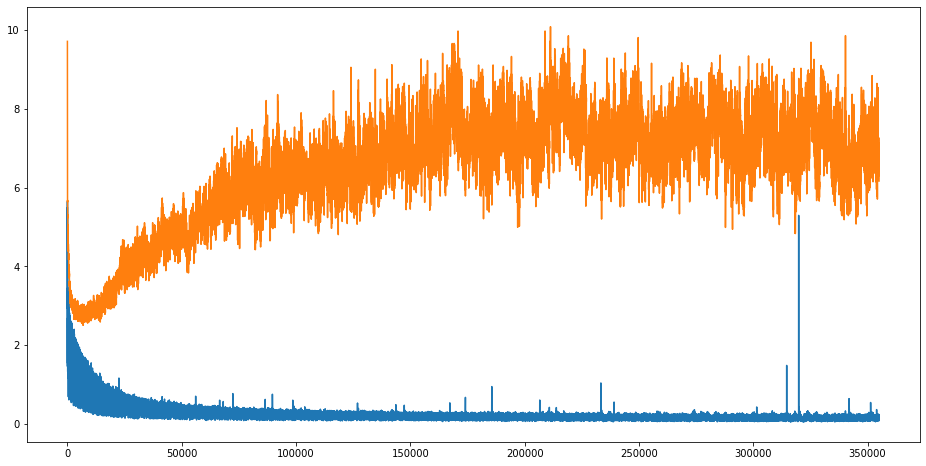

In [20]:
#### SHOW LOSSES ####

plt.plot(np.array(training_loss_history)[:,0])
plt.plot(np.array(test_loss_history)[:,0])
plt.rcParams["figure.figsize"] = (16, 8)
plt.show()